FAO_CommodityBalances_LivestockFish

# Pre-Load

## Libraries and Settings

In [1]:
"""Modules"""

import urllib.request, urllib.parse, urllib.error
import requests
from bs4 import BeautifulSoup

import lxml
import re
import os
import time
import datetime
import chardet
import zipfile
from zipfile import ZipFile
import json
from io import BytesIO

from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.transforms
%matplotlib inline

import folium
from PIL import Image

import numpy as np
import pandas as pd

pd.set_option('precision', 4)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('max_colwidth',100)

def curl(url,path,mode='wb'):
    response = urllib.request.urlopen(url).read()
    with open(path, mode) as handle:
        handle.write(response)

In [2]:
""" DIRECTOR SETTINGS"""

FAO_DOWNLOADS_ROOT = 'http://fenixservices.fao.org/faostat/static/bulkdownloads/'
FAO_DOWNLOADS_XML = os.path.join(FAO_DOWNLOADS_ROOT, 'datasets_E.xml')
FAO_DOWNLOADS_JSON = os.path.join(FAO_DOWNLOADS_ROOT, 'datasets_E.json')
FAO_DOWNLOADS_BULK = os.path.join(FAO_DOWNLOADS_ROOT, 'FAOSTAT.zip')

print(f'FAOSTAT downloads root: {FAO_DOWNLOADS_ROOT}')
print(f'FAOSTAT description in .xml: {FAO_DOWNLOADS_XML}')
print(f'FAOSTAT description in .json: {FAO_DOWNLOADS_JSON}')
print(f'FAOSTAT downloads .zip: {FAO_DOWNLOADS_BULK}')

# what is the relevant path of root
root_where = '../../'

# print('+++++++++ Attention ++++++++++')
# print(f'The root is set as "{root_where}" relevant to this file.' )
# print(f'If it is not right, you change this parameter where the parameter name is "root_where".' )
# print('+++++++++++++++++++++++++++++')
# print('')

LOCAL_ROOT = os.path.abspath(root_where)
DATA_BASE = os.path.join(LOCAL_ROOT, 'data')
# print(f'Root director: {LOCAL_ROOT}')
# print(f'Data director: {DATA_BASE}')
# print('')

DATA_FAO = os.path.join(DATA_BASE, 'FAO')
FAO_meta = os.path.join(DATA_FAO, 'metadata')
FAO_description_path = FAO_meta + '/datasets_E.xml'
FAO_BULK_zip = DATA_FAO + '/FAOSTAT.zip'
SUFFIX = '_E_All_Data_(Normalized)'  # suffix of fao data file name
# print(f'FAO data director: {DATA_FAO}')
# print(f'FAO metadata director: {FAO_meta}')
# print(f'FAO local description file: {FAO_description_path}')
# print(f'FAO local data zip: {FAO_BULK_zip}')
print(f'Suffix of raw FAO data file name: {SUFFIX}')
# print('')

DATA_NBS = os.path.join(DATA_BASE, 'NBS')
NBS_meta = os.path.join(DATA_NBS, 'metadata')
# print(f'NBS data director: {DATA_NBS}')
# print(f'NBS metadata director: {NBS_meta}')
# print('')

DATA_hybrids = os.path.join(DATA_BASE, 'hybrids')
# print(f'Hybrids data director: {DATA_hybrids}')
# print('')

FAOSTAT downloads root: http://fenixservices.fao.org/faostat/static/bulkdownloads/
FAOSTAT description in .xml: http://fenixservices.fao.org/faostat/static/bulkdownloads/datasets_E.xml
FAOSTAT description in .json: http://fenixservices.fao.org/faostat/static/bulkdownloads/datasets_E.json
FAOSTAT downloads .zip: http://fenixservices.fao.org/faostat/static/bulkdownloads/FAOSTAT.zip
Suffix of raw FAO data file name: _E_All_Data_(Normalized)


In [3]:
# plt.style.use(['ggplot'])

# fig size
FIG_size = (5,3)
DPI = 144

# font size
TIT_size = 12    # titles
LAB_size = 10    # labels
LEG_size = 10    # legends
TCK_size = 10    # ticklabels

LIN_wei = 1.5    # line weights
BAR_wid = 3      # bar width

# GRD_wid = 0.5    # grid line width
# GRD_clr = 'white' 
# GRD_aph = 1     # grid alpha

# Color setting ===================================================================

# 猪，牛，羊，禽肉，鱼，蛋，奶
Pig_pink = '#ffab91'
Bovine_red = '#c62828'
Lamb_green = '#689f38'
Bird_orange = '#ff6f00'
Aqua_cyan = '#80deea'
Egg_yellow = '#ffc400'
Milk_blue = '#1e88e5'

# Good Food
GF_brand_gold = '#fdd835'
GF_brand_gray = '#9F888C'

GF_amber1 = '#ffe57f'
GF_amber2 = '#ffab00'

GF_red0 = '#ffebee'
GF_red1 = '#ff8a80'
GF_red2 = '#d50000'

GF_green1 = '#b9f6ca'
GF_green2 = '#00c853'

GF_blue1 = '#82b1ff'
GF_blue2 = '#2962ff'

# Gray
Gray1 = '#eeeeee'
Gray2 = '#bdbdbd'
Gray3 = '#666666'

CLs = [Pig_pink, Bovine_red, Lamb_green, Bird_orange, Aqua_cyan, Egg_yellow,  Milk_blue]

MKs = ('o', 'x','o','x', 'v','.','v','.','o','x','o', 'x', 'v','.','v','.')
LSs = ('-','-','--', ':', ':','-.','-.','-','-','--','--', ':', ':','-.','-.')

## Variables

In [4]:
"""小写开头的字母用于临时变量"""

# data -- 用于创建表格的临时数据，创建完后必须赋值给永久变量
# df   -- 用于画图的临时数据，画图时将所需数据赋值给它
# dfs  -- 用于画图的临时数据字典，画图时将所需数据赋值给它
# domain
# 其他小写字母


"""初始化全局变量，请小心操作"""

# 用户自定义参数，会随着用户设置的变化而变化
D = ''    # Domain
A = ''    # Area     单一的国家/地区，
As = []
E = ''    # Element
Es = []
I = ''    # A paticular Item
Is = []   # Items

# 根据用户变量生成
DFs = {}        # 每个 Domain 的所有数据是一份 DF，keys=Domains，no index, columns=['Area Code', 'Area', 'Element', 'Item', 'Year', 'Unit', 'Value']
CDTs = {}       # 从DFs筛选数据的条件，key0=Domain, key1=Area, key2=Element, value=Items
PVs_AreaYear = {}        # 从DFs根据筛选条件生成的 DICT, key0=Domain, key1=Area, key2=Element, key3=Items, values=DF, index=Areas, columns=Years
PVs_YearArea = {}        # 从DFs根据筛选条件生成的 DICT, key0=Domain, key1=Area, key2=Element, key3=Items, values=DF, index=Years, columns=Areas

Years = []      # 年份列表

PVs_AG = {}     # 某国家地区与其所在组合的某些 Items 的比较，key0=Domain, key1=Area, key2=Element, key3=[AG, A, G], index=Years, columns=[C,G]

# 必要的信息 
DOMs = {}        # Domain 的描述字典， key=domain_name(file name's pref)
LIST_countries=[]  # 国家级地区列表，Area Code < 5000, default refer to  worlds contries
LIST_groups=[]    # 地区组合列表，Area Code >= 5000, default grouped by continents

## Meta Data

In [5]:
def FAO_description_dic(soup):
    """
    input soup parsed by bs4
    parse it to dict with nessesary info
    """
    dic = {}
    for dataset in soup.find_all('Dataset'):
        file_loc = dataset.FileLocation.string
        domain = file_loc[file_loc.find('bulkdownloads/')+len('bulkdownloads/'):file_loc.find('_E_All')]
        dic[domain] = {'DatasetCode': dataset.DatasetCode.string,
                        'DatasetName': dataset.DatasetName.string,
                        'Topic': dataset.Topic.string,
                        'DatasetDescription': dataset.DatasetDescription.string,
                        'MedaData': [dataset.Contact.string, dataset.Email.string, dataset.DateUpdate.string, dataset.CompressionFormat.string, dataset.FileType.string, dataset.FileSize.string, dataset.FileRows.string],
                        'Url_Normalized':dataset.FileLocation.string}
    return dic

In [6]:
""" If you need to update, uncomment this cell. """
# # Download or update FAOSTAT datasets if necessary
# if os.path.exists(FAO_description_path) or os.path.exists(FAO_BULK_zip): pass
# else: 
#     print('Need to download or update FAOSTAT datasets.')
#     print('Processing ...')
#     curl(url=FAO_DOWNLOADS_XML, path=FAO_description_path)
#     curl(url=FAO_DOWNLOADS_BULK, path=FAO_BULK_zip)
    
# # Check local datasets update  
# print('Checking updates ...')

# # local datasets
# print('Checking Local description ...')
# with open(FAO_description_path, 'rb') as handle:
#     xml = handle.read()
#     soup = BeautifulSoup(xml, 'xml')
# xml_local = FAO_description_dic(soup)

# # online datasets
# print('Checking latest description ...')
# response = requests.get(FAO_DOWNLOADS_XML)
# xml = response.content
# soup = BeautifulSoup(xml, 'xml')
# xml_online = FAO_description_dic(soup)

# # compare
# print('Comparing ...')
# shared_items = {k: xml_local[k] for k in xml_local if k in xml_online and xml_local[k] == xml_online[k]}
# need_update = {k: xml_local[k] for k in xml_local if xml_local[k] != xml_online[k]}
# update_to = {k: xml_local[k] for k in xml_local if xml_local[k] != xml_online[k]}

# print('No. of local datasets: ', len(xml_local))
# print('No. of latest datasets: ', len(xml_online))
# print('No. of shared datasets: ', len(shared_items))

# if len(xml_local)==len(shared_items) and len(xml_local)==len(xml_online):
#     print ('Already up to date.')
# else:
#     print('Need update: ', need_update)
#     print('Update to: ', update_to)
#     print("NOTE: If you don't concern about datasets listed above, there's no need to update!")
    
# print('Done succesfully.')

' If you need to update, uncomment this cell. '

## Read Data Frame

In [7]:
def rdDF(domain):
    
    display(DOMs[domain])
    
    zf = ZipFile(f'{DATA_FAO}/{domain}{SUFFIX}.zip')
    encodings = ["ISO-8859-1", "UTF-8", "UTF-8-SIG", "GBK"]
    for encoding in encodings:
        try:
            data = pd.read_csv(zf.open(f'{domain}{SUFFIX}.csv'), encoding=encoding)
        except:
            pass
    
    display(data.head())
    display(data.tail())

    return data

In [8]:
# 给 Domain 赋值，查看数据基础信息

D = 'CommodityBalances_LivestockFish'

with open(FAO_description_path, 'rb') as handle:
    xml = handle.read()
    soup = BeautifulSoup(xml, 'xml')
DOMs = FAO_description_dic(soup)
# display(DOMs)

# Show you raw data
try:
    DATA = rdDF(D)
except:
    with ZipFile(FAO_BULK_zip, 'r') as zf1:
        zf1.extract(f'{D}{SUFFIX}.zip', DATA_FAO)
        DATA = rdDF(D)
print('data shape: ', DATA.shape)

# For FAO Director
Domain_folder = f'FAO_{D}'

{'DatasetCode': 'BL',
 'DatasetName': 'Food Balance: Commodity Balances - Livestock and Fish Primary Equivalent',
 'Topic': 'Most crop and livestock products, including processed products, under agricultural activity.',
 'DatasetDescription': 'Food supply data is some of the most important data in FAOSTAT. In fact, this data is for the basis for estimation of global and national undernourishment assessment, when it is combined with parameters and other data sets. This data has been the foundation of food balance sheets ever since they were first constructed. The data is accessed by both business and governments for economic analysis and policy setting, as well as being used by the academic community.',
 'MedaData': ['Mr. Salar Tayyib',
  'faostat@fao.org',
  '2018-01-17',
  'zip',
  'csv',
  '16605KB',
  '2868088'],
 'Url_Normalized': 'http://fenixservices.fao.org/faostat/static/bulkdownloads/CommodityBalances_LivestockFish_E_All_Data_(Normalized).zip'}

Area Code         Area  Item Code         Item  Element Code     Element  \
0          2  Afghanistan       2731  Bovine Meat          5510  Production   
1          2  Afghanistan       2731  Bovine Meat          5510  Production   
2          2  Afghanistan       2731  Bovine Meat          5510  Production   
3          2  Afghanistan       2731  Bovine Meat          5510  Production   
4          2  Afghanistan       2731  Bovine Meat          5510  Production   

   Year Code  Year    Unit    Value Flag  
0       1961  1961  tonnes  43000.0    S  
1       1962  1962  tonnes  45800.0    S  
2       1963  1963  tonnes  47250.0    S  
3       1964  1964  tonnes  48000.0    S  
4       1965  1965  tonnes  48700.0    S

Area Code                                     Area  Item Code  \
2459786       5817  Net Food Importing Developing Countries       2945   
2459787       5817  Net Food Importing Developing Countries       2945   
2459788       5817  Net Food Importing Developing Countries       2945   
2459789       5817  Net Food Importing Developing Countries       2945   
2459790       5817  Net Food Importing Developing Countries       2945   

           Item  Element Code     Element  Year Code  Year    Unit    Value  \
2459786  Offals          5153  Other uses       2009  2009  tonnes  43075.0   
2459787  Offals          5153  Other uses       2010  2010  tonnes  25138.0   
2459788  Offals          5153  Other uses       2011  2011  tonnes  27344.0   
2459789  Offals          5153  Other uses       2012  2012  tonnes  26644.0   
2459790  Offals          5153  Other uses       2013  2013  tonnes  35772.0   

        Flag  
2459786    A  
2459787    A  
2459788    A  
2459789    A  
2459790    A

data shape:  (2459791, 11)


In [9]:
# path_img = f'{LOCAL_ROOT}/results/{Domain_folder}/img/'
# for i in os.listdir(path_img):
#     path_file = os.path.join(path_img,i)  
#     if os.path.isfile(path_file):
#           os.remove(path_file)

# path_map = f'{LOCAL_ROOT}/results/{Domain_folder}/map/'
# for i in os.listdir(path_map):
#     path_file = os.path.join(path_map,i)
#     if os.path.isfile(path_file) and path_file.endswith(".html"):
#           os.remove(path_file)

## Show Countries and Groups

In [10]:
# Countries in FAO data of this domain
Countries_FAO = DATA[DATA['Area Code']<5000]['Area'].unique().tolist()
# print('Countries in FAO data of this domain: ')
# display(Countries_FAO)

# Countries in geojson
with open(f'{FAO_meta}/geojson/world_countries.json') as json_file:
    json_data = json.load(json_file)
Countries_json = []
for feature in json_data['features']:
    Countries_json.append(feature['properties']['name'])
# print('Countries in geojson: ')
# display(Countries_json)

# Countries in FAO but not in geojson
Countries_no_json = [c for c in Countries_FAO if c not in Countries_json]
print('Countries in FAO but not in geojson: ')
display(Countries_no_json)

# Countries in geojson but not in FAO
Countries_no_FAO = [c for c in Countries_json if c not in Countries_FAO]
print('Countries in geojson but not in FAO: ')
display(Countries_no_FAO)

# Countries in both FAO and geojson
Countries = [c for c in Countries_json if c in Countries_FAO]
# print('Countries in geojson but not in FAO: ')
# display(Countries)

Countries in FAO but not in geojson: 


['Antigua and Barbuda',
 'Barbados',
 'Belgium-Luxembourg',
 'Bermuda',
 'Cabo Verde',
 "C魌e d'Ivoire",
 'Czechoslovakia',
 'Dominica',
 'Ethiopia PDR',
 'French Polynesia',
 'Grenada',
 'Kiribati',
 'Maldives',
 'Malta',
 'Mauritius',
 'Netherlands Antilles (former)',
 'Saint Kitts and Nevis',
 'Saint Lucia',
 'Saint Vincent and the Grenadines',
 'Samoa',
 'Sao Tome and Principe',
 'Serbia and Montenegro',
 'Sudan (former)',
 'USSR',
 'Yugoslav SFR']

Countries in geojson but not in FAO: 


['Antarctica',
 'French Southern and Antarctic Lands',
 'Burundi',
 'Bhutan',
 "Côte d'Ivoire",
 'Democratic Republic of the Congo',
 'Northern Cyprus',
 'Eritrea',
 'Falkland Islands (Malvinas)',
 'Equatorial Guinea',
 'Greenland',
 'Kosovo',
 'Libya',
 'Papua New Guinea',
 'Puerto Rico',
 'Qatar',
 'Western Sahara',
 'South Sudan',
 'Somaliland',
 'Somalia',
 'Syrian Arab Republic',
 'West Bank']

In [11]:
"""adjust FAO countries name"""
# rename because of decoding error
DATA.loc[DATA['Area']=="C魌e d'Ivoire", 'Area'] = "Côte d'Ivoire"

# Countries too small to consider for now
Countries_too_small = [
    'Antigua and Barbuda',  # 安提瓜和巴布达
    'Barbados',             # 巴巴多斯
    'Bermuda',              # 百慕大
    'Cabo Verde',           # 弗德角
    'Dominica',             # 多米尼克, 非多米尼加共和国
    'French Polynesia',     # 法属玻璃尼亚  a part of 'French Southern and Antarctic Lands' of geojson
    'Grenada',              # 格林纳达
    'Kiribati',             # 基里巴斯
    'Maldives',             # 马尔代夫
    'Malta',                # 马耳他
    'Mauritius',            # 毛里求斯
    'Saint Kitts and Nevis',  # 圣基茨和尼维斯
    'Saint Lucia',            # 圣卢西亚
    'Saint Vincent and the Grenadines', # 圣文森特和格林纳丁斯
    'Samoa',                  # 萨摩亚
    'Sao Tome and Principe',  # 圣多美和普林西比
]
DATA = DATA[~DATA['Area'].isin(Countries_too_small)]

# Countries not exists now
Countries_not_now = [
    # 与前苏联解体相关
    'Czechoslovakia',        # dissolved 1992, 捷克斯洛伐克
    'Ethiopia PDR',          # 1987~1991, 埃塞俄比亚人民民主共和国
    'USSR',                  # dissolved 1991
    'Yugoslav SFR',          # 1945~1992, 南斯拉夫社会主义联邦共和国
    'Serbia and Montenegro',         # 1992~2006, 塞尔维亚和黑山国家联盟
    # 
    'Netherlands Antilles (former)', # dissolved 2010, islands, too small
    # 苏丹
    'Sudan (former)',                # dissolved 2011
]
# disslved see map for old

"""adjust geojson"""
# China SARs
China_SARs = [                           # added
    'China, Hong Kong SAR', # add new polygon
    'China, Macao SAR',     # add new polygon
]

# Two Countries can say one or can say independently  # Use 'Belgium' and 'Luxembourg'
Belgium_Luxembourg = [
    'Belgium',
    'Luxembourg',
]
DATA = DATA[~DATA['Area'].isin(['Belgium-Luxembourg'])]

# Sudan (former)                          ! not considered now
Sudan_former = [
    'Sudan',
    'South Sudan',
]

# Add a map before 1992, where:
# following countries in 'USSR'           # added
USSR = [
    "Russian Federation"
    "Kazakhstan",          # 哈萨克斯坦
    "Estonia",             # 爱沙尼亚
    "Ukraine",             # 乌克兰
    "Belarus",             # 白俄罗斯
    "Uzbekistan",          # 乌兹别克斯坦
    "Georgia",             # 格鲁吉亚
    "Azerbaijan",          # 阿塞拜疆
    "Lithuania",           # 立陶宛
    "Republic of Moldova", # 摩尔多瓦
    "Latvia",              # 拉脱维亚
    "Kyrgyzstan",          # 吉尔吉斯斯坦
    "Tajikistan",          # 塔吉克斯坦
    "Armenia",             # 阿美妮娅
    "Turkmenistan",        # 土库曼斯坦
]

# following countries in 'Czechoslovakia'
Czechoslovakia = [
    'Czechia',
    'Slovakia',
]

# following countries in 'Yugoslav SFR'  ! not considered now
Yugoslav_SFR = [
    'The former Yugoslav Republic of Macedonia', # 1992~, 继任前南斯拉夫的北马其顿，rename in geojson from 'North Macedonia'
    'Serbia',      # 2006~
    'Montenegro',  # 2006~
]

# Add a map 1992~2006, where:            ! not added for not considered now
Serbia_Montenegro = [
    'Serbia',     # 2006~
    'Montenegro', # 2006~
]


# Countries in FAO data of this domain
Countries_FAO = DATA[DATA['Area Code']<5000]['Area'].unique().tolist()
print('Countries in FAO data of this domain: ')
display(Countries_FAO)

# Groups in FAO
Groups_FAO = DATA[DATA['Area Code']>=5000]['Area'].unique().tolist()
print('Groups in FAO: ')
display(Groups_FAO)

Countries in FAO data of this domain: 


['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bolivia (Plurinational State of)',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China, Hong Kong SAR',
 'China, Macao SAR',
 'China, mainland',
 'China, Taiwan Province of',
 'Colombia',
 'Congo',
 'Costa Rica',
 "Côte d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Czechoslovakia',
 "Democratic People's Republic of Korea",
 'Denmark',
 'Djibouti',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Estonia',
 'Ethiopia',
 'Ethiopia PDR',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Honduras',
 'Hungary',
 'Iceland',
 

Groups in FAO: 


['World',
 'Africa',
 'Eastern Africa',
 'Middle Africa',
 'Northern Africa',
 'Southern Africa',
 'Western Africa',
 'Americas',
 'Northern America',
 'Central America',
 'Caribbean',
 'South America',
 'Asia',
 'Central Asia',
 'Eastern Asia',
 'Southern Asia',
 'South-Eastern Asia',
 'Western Asia',
 'Europe',
 'Eastern Europe',
 'Northern Europe',
 'Southern Europe',
 'Western Europe',
 'Oceania',
 'Australia & New Zealand',
 'Melanesia',
 'Micronesia',
 'Polynesia',
 'European Union',
 'Least Developed Countries',
 'Land Locked Developing Countries',
 'Small Island Developing States',
 'Low Income Food Deficit Countries',
 'Net Food Importing Developing Countries']

In [12]:
# 加载国家列表
for cn in ['China', 'China, Hong Kong SAR', 'China, Macao SAR', 'China, Taiwan Province of']:
    try:
        Countries_FAO.remove(cn)
    except: pass
LIST_countries = Countries_FAO
print(f'There are {len(LIST_countries)} countries')
# display(LIST_countries)

# 加载区域/组合列表
LIST_groups = Groups_FAO
print(f'There are {len(LIST_groups)} groups.')
# display(LIST_groups)

# 自定义常用区域/组合列表
# China
China = ['China, mainland']+China_SARs+['China, Taiwan Province of']

# OECD
LIST_countries_OECD = []
with open(FAO_meta+'/list_countries_OECD.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries_OECD.append(line)
print(f'There are {len(LIST_countries_OECD)} OECD countries.')
# display(LIST_countries_OECD)

# BRICS
LIST_countries_BRICS = ['Brazil', 'India', 'Russian Federation', 'South Africa', 'China, mainland']

# EU
LIST_countries_EU = []
with open(FAO_meta+'/list_countries_EU.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries_EU.append(line)

# G20
LIST_countries_G20 = []
with open(FAO_meta+'/list_countries_G20.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries_G20.append(line)
LIST_countries_G20 = list(set(LIST_countries_G20 + LIST_countries_EU + China))

# Asia
LIST_countries_asia = []
with open(FAO_meta+'/list_countries_asia.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries_asia.append(line)
print(f'There are {len(LIST_countries_asia)} Asian countries.')
# display(LIST_countries_asia)

There are 162 countries
There are 34 groups.
There are 36 OECD countries.
There are 53 Asian countries.


## Show Years Range

In [13]:
# 查看数据 Years 范围
Years = DATA['Year'].unique()
print(f'Dataset years range: {Years[0]} ~ {Years[-1]}')

# 定义 Years 分析范围
# Years = range(1961,2019+1)
print(f'You choose years range: {Years[0]} ~ {Years[-1]}')

DATA = DATA[DATA['Year'].isin(Years)]

Dataset years range: 1961 ~ 2013
You choose years range: 1961 ~ 2013


## Show Element and Items

In [14]:
# 选择列
COLUMNS = ['Area Code', 'Area', 'Element', 'Item', 'Year', 'Unit', 'Value']

DATA = DATA[COLUMNS]
print('data shape: ', DATA.shape)

# 去空值和重复值（不是必须的，检查 data shape）
DATA = DATA.dropna().drop_duplicates()
print('data shape after drop Non. and Dup.: ', DATA.shape)

# 查看数据构成
print('Groupe data by Elements and Items: ')
display(DATA.groupby(['Element','Item']).count())

data shape:  (2283072, 7)
data shape after drop Non. and Dup.:  (2132504, 7)
Groupe data by Elements and Items: 


Area Code  Area  Year  \
Element                       Item                                             
Domestic supply quantity      Animal fats                   9453  9453  9453   
                              Aquatic Animals, Others       7732  7732  7732   
                              Aquatic Plants                8871  8871  8871   
                              Aquatic Products, Other       9091  9091  9091   
                              Bovine Meat                   9453  9453  9453   
                              Butter, Ghee                  9453  9453  9453   
                              Cephalopods                   9281  9281  9281   
                              Cheese                        9400  9400  9400   
                              Cream                         8691  8691  8691   
                              Crustaceans                   9398  9398  9398   
                              Demersal Fish                 9400  9400  9400   
                              Eggs                          9547  9547  9547   
                              Fats, Animals, Raw            9453  9453  9453   
                              Fish Meal                     9238  9238  9238   
                              Fish, Body Oil                8951  8951  8951   
                              Fish, Liver Oil               8208  8208  8208   
                              Fish, Seafood                 9453  9453  9453   
                              Freshwater Fish               9453  9453  9453   
                              Hides and skins               9400  9400  9400   
                              Honey                         9347  9347  9347   
                              Marine Fish, Other            9347  9347  9347   
                              Meat                          9453  9453  9453   
                              Meat Meal                     8564  8564  8564   
                              Meat, Aquatic Mammals          424   424   424   
                              Meat, Other                   9453  9453  9453   
                              Milk - Excluding Butter       9624  9624  9624   
                              Milk, Skimmed                 9400  9400  9400   
                              Milk, Whole                   9453  9453  9453   
                              Molluscs, Other               9366  9366  9366   
                              Mutton & Goat Meat            9453  9453  9453   
                              Offals                        9453  9453  9453   
                              Offals, Edible                9453  9453  9453   
                              Pelagic Fish                  9400  9400  9400   
                              Pigmeat                       9347  9347  9347   
                              Poultry Meat                  9453  9453  9453   
                              Silk                          6784  6784  6784   
                              Whey                          8661  8661  8661   
                              Wool (Clean Eq.)              7760  7760  7760   
Export Quantity               Animal fats                   8954  8954  8954   
                              Aquatic Animals, Others       5448  5448  5448   
                              Aquatic Plants                6450  6450  6450   
                              Aquatic Products, Other       7086  7086  7086   
                              Bovine Meat                   8879  8879  8879   
                              Butter, Ghee                  8361  8361  8361   
                              Cephalopods                   7834  7834  7834   
                              Cheese                        8116  8116  8116   
                              Cream                         6573  6573  6573   
                              Crustaceans                   8802  8802  8802   
                              Demersal Fish            

# Data Visualization

## Parameter Settings

### Area Selection

In [69]:
# 给 Area 赋值
A = 'China, mainland'

In [15]:
data = DATA.copy()

DF_area = data[data['Area']==A]

# display(data.groupby(['Element','Item']).count())
display('Elements:', data.Element.unique())
display('Items:', data.Item.unique())

'Elements:'

array(['Production', 'Import Quantity', 'Domestic supply quantity',
       'Food supply quantity (tonnes)', 'Seed', 'Losses', 'Other uses',
       'Stock Variation', 'Export Quantity', 'Feed', 'Processing'],
      dtype=object)

'Items:'

array(['Bovine Meat', 'Butter, Ghee', 'Cheese', 'Cream', 'Eggs',
       'Fats, Animals, Raw', 'Freshwater Fish', 'Hides and skins',
       'Honey', 'Meat, Other', 'Milk - Excluding Butter', 'Milk, Skimmed',
       'Milk, Whole', 'Mutton & Goat Meat', 'Offals, Edible',
       'Poultry Meat', 'Silk', 'Whey', 'Wool (Clean Eq.)', 'Animal fats',
       'Fish, Seafood', 'Meat', 'Offals', 'Aquatic Animals, Others',
       'Aquatic Plants', 'Cephalopods', 'Crustaceans', 'Demersal Fish',
       'Fish Meal', 'Fish, Body Oil', 'Fish, Liver Oil',
       'Marine Fish, Other', 'Meat Meal', 'Molluscs, Other',
       'Pelagic Fish', 'Pigmeat', 'Aquatic Products, Other',
       'Meat, Aquatic Mammals'], dtype=object)

### Explorded Classification of Items

#### CommodityBalances_LivestockFish

    'Animal Products':['Meat','Fish, Seafood','Milk - Excluding Butter','Eggs','Offals','Animal fats'],
    'Meat': ['Poultry Meat', 'Pigmeat','Bovine Meat','Mutton & Goat Meat','Meat, Other'],
    'Fish, Seafood':['Freshwater Fish','Molluscs, Other', 'Crustaceans','Cephalopods','Demersal Fish','Pelagic Fish','Marine Fish, Other'],
    'Milk - Excluding Butter':[],
    'Eggs':[],
    'Offals':[],
    'Animal fats':[],

In [68]:
# 给 Elements 赋值
Is = ['Pigmeat', 'Bovine Meat', 'Mutton & Goat Meat', 'Poultry Meat', 'Fish, Seafood', 'Eggs', 'Milk - Excluding Butter']

Es = {
    'Domestic Supply, Production':['Production', 'Import Quantity', 'Export Quantity',
                                   'Domestic supply quantity'],
    'Domestic Supply, Consumption':['Food supply quantity (tonnes)', 
#                                     'Seed', 
                                    'Losses', 
#                                     'Other uses',
                                    'Feed', 
#                                     'Processing',
                                    'Domestic supply quantity'],
}

### Create Pivots for Items

In [17]:
def mkPVs_forElements_YearArea(
    item,
    elements,
):
    df = DATA.copy()
    dfs = {}
    for e in elements:
        dfs[e] = df[(df['Item']==item) & (df['Element']==e)][['Area','Year','Value']]

    pivots = {}
    for e in elements:
        df = pd.pivot_table(dfs[e],index=['Year'],columns=['Area'],values=['Value'])
        df.columns.set_names([None, None], inplace=True)    # reset mult-index name 
        df.columns = df.columns.get_level_values(-1)        # flat the multi-index by the last element of each index tuple.
        if df.shape != (0, 0):
            pivots[e] = df
    return pivots

In [70]:
for i in Is:
    PVs_YearArea[i] = mkPVs_forElements_YearArea(item=i, elements=Es['Domestic Supply, Production'])

    for e, pv in PVs_YearArea[i].items():
        display(i, e, pv.tail(2))

'Pigmeat'

'Production'

Africa  Albania  Algeria    Americas   Angola  Argentina  Armenia  \
Year                                                                         
2012  1184539.0  17000.0    120.0  1.9560e+07  84500.0   331000.0   9500.0   
2013  1253703.0  17300.0    120.0  1.9621e+07  93600.0   416000.0  12600.0   

            Asia  Australia  Australia & New Zealand   Austria  Azerbaijan  \
Year                                                                         
2012  6.2857e+07   348923.0                 398709.0  530262.0       741.0   
2013  6.4542e+07   360866.0                 408025.0  529284.0       743.0   

      Bahamas   Belarus    Belgium  Belize   Benin  \
Year                                                 
2012    334.0  442900.0  1109610.0  1409.0  5040.0   
2013    334.0  468900.0  1130572.0  1342.0  5096.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                           89606.0                 15695.0     500.0   
2013                           90599.0                 13013.0     510.0   

         Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
Year                                                                   
2012  3330000.0               44.0   73159.0       31920.0   98500.0   
2013  3280000.0               44.0   72905.0       32640.0   98500.0   

      Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                             
2012   28500.0  2004410.0   296861.0                   16350.0   
2013   29400.0  1980560.0   324329.0                   17000.0   

      Central America  Central Asia   Chad     Chile  China, Hong Kong SAR  \
Year                                                                         
2012        1421124.0      145361.0  605.0  583671.0              122800.0   
2013        1463911.0      145706.0  612.0  550033.0              123700.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012            8292.0                   877628.0       5.1300e+07  238505.0   
2013            8300.0                   887000.0       5.2733e+07  243133.0   

       Congo  Costa Rica   Croatia      Cuba   Cyprus   Czechia  \
Year                                                              
2012  1925.0     54315.0  126900.0  166320.0  51722.0  249869.0   
2013  2000.0     53694.0  106500.0  193314.0  48664.0  242833.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN         7215.0                               112500.0   
2013             NaN         7323.0                               112500.0   

        Denmark  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                
2012  1669000.0             78211.0        455378.0    5.4805e+07   
2013  1589400.0             79082.0        499900.0    5.6384e+07   

      Eastern Europe   Ecuador  Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                    
2012       6846560.0  205000.0  460.0       9487.0  38400.0    1875.0   
2013       6984177.0  218800.0  470.0       7978.0  37871.0    1875.0   

      Ethiopia PDR      Europe  European Union    Fiji   Finland     France  \
Year                                                                          
2012           NaN  2.7241e+07      2.2805e+07  4005.0  192940.0  2161653.0   
2013           NaN  2.7226e+07      2.2468e+07  4050.0  194600.0  2130600.0   

       Gabon  Gambia  Georgia    Germany    Ghana   Greece  Guatemala  Guinea  \
Year                                                                            
2012  3220.0   420.0  11800.0  5474021.0  

'Pigmeat'

'Import Quantity'

Africa  Albania  Algeria   Americas   Angola  Argentina  Armenia  \
Year                                                                       
2012  216398.0  17949.0     37.0  1753009.0  90700.0    37033.0  19021.0   
2013  244259.0  17263.0     63.0  1903460.0  97238.0    20839.0  18807.0   

           Asia  Australia  Australia & New Zealand   Austria  Azerbaijan  \
Year                                                                        
2012  3562433.0   250188.0                 301216.0  160241.0      1830.0   
2013  3559046.0   245864.0                 300268.0  199405.0      1626.0   

      Bahamas  Bangladesh   Belarus   Belgium  Belize   Benin  \
Year                                                            
2012  23903.0         0.0  137632.0  177313.0  4778.0  5135.0   
2013  19264.0         0.0   90576.0  173721.0  4238.0  3120.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                            3470.0                 26182.0     936.0   
2013                            4236.0                 27213.0    1052.0   

      Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
Year                                                                          
2012  1586.0             2815.0  127742.0          94.0     113.0    2656.0   
2013  1887.0             3450.0  126585.0          91.0     184.0    3400.0   

        Canada  Caribbean  Central African Republic  Central America  \
Year                                                                   
2012  266130.0   104903.0                     109.0         743551.0   
2013  243047.0   102034.0                      90.0         835160.0   

      Central Asia  Chad    Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                                        
2012       97926.0  63.0  24264.0              538925.0           32678.0   
2013       96418.0  64.0  47214.0              551875.0           32766.0   

      China, Taiwan Province of  China, mainland  Colombia   Congo  \
Year                                                                 
2012                    29170.0         714522.0   42444.0  3215.0   
2013                    36966.0         814674.0   71283.0  8632.0   

      Costa Rica  Croatia     Cuba  Cyprus   Czechia  Czechoslovakia  \
Year                                                                   
2012      5125.0  78400.0  29858.0  9828.0  302264.0             NaN   
2013      6856.0  90615.0  30013.0  9582.0  299061.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
Year                                                                   
2012        20224.0                                 2354.0  141154.0   
2013        28535.0                                 4572.0  159142.0   

      Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                               
2012     112.0             13515.0         18308.0     3246593.0   
2013     152.0             19915.0         16745.0     3212433.0   

      Eastern Europe  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                   
2012       2998484.0   8066.0  845.0      12491.0  34904.0      99.0   
2013       2782176.0   8422.0  906.0      15813.0  37137.0      99.0   

      Ethiopia PDR     Europe  European Union   Fiji  Finland    France  \
Year                                                                      
2012           NaN  8983040.0       7421674.0  245.0  43483.0  603322.0   
2013           NaN  8873483.0       7519800.0  200.0  39936.0  611393.0   

        Gabon  Gambia  Georgia    Germany    Ghana    Greece  Guatemala  \
Year                                                                      
2012   8699.0    75.0  22853.0  1218042.0

'Pigmeat'

'Export Quantity'

Africa  Albania  Algeria   Americas  Angola  Argentina  Armenia  \
Year                                                                     
2012   7483.0     39.0      0.0  4855003.0    46.0     1353.0    389.0   
2013  29951.0     56.0      0.0  4633197.0    46.0     1415.0    609.0   

          Asia  Australia  Australia & New Zealand   Austria  Azerbaijan  \
Year                                                                       
2012  457635.0    42430.0                  43371.0  282531.0         0.0   
2013  544540.0    43186.0                  44312.0  282179.0         5.0   

      Bahamas   Belarus   Belgium  Belize  Benin  \
Year                                               
2012      0.0  199393.0  840149.0     1.0    0.0   
2013      0.0  180953.0  875125.0     1.0    0.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                               0.0                  5014.0      31.0   
2013                               0.0                  4300.0      61.0   

        Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
Year                                                                            
2012  818827.0                0.0   12693.0           0.0       0.0       0.0   
2013  756830.0                4.0    9832.0           0.0       0.0       0.0   

         Canada  Caribbean  Central America  Central Asia  Chad     Chile  \
Year                                                                        
2012  1264252.0     2376.0         133349.0         337.0   0.0  179977.0   
2013  1262754.0     1951.0         156825.0         281.0   0.0  162390.0   

      China, Hong Kong SAR  China, Macao SAR  China, Taiwan Province of  \
Year                                                                      
2012              110428.0               0.0                     3808.0   
2013              175368.0               0.0                     3480.0   

      China, mainland  Colombia  Congo  Costa Rica  Croatia  Cuba  Cyprus  \
Year                                                                        
2012         262105.0      14.0    0.0      9566.0  12715.0   0.0  3245.0   
2013         279497.0      20.0    0.0      9806.0  13548.0   0.0  1559.0   

       Czechia  Czechoslovakia  Côte d'Ivoire  \
Year                                            
2012  101287.0             NaN           34.0   
2013  101271.0             NaN           31.0   

      Democratic People's Republic of Korea    Denmark  Dominican Republic  \
Year                                                                         
2012                                    0.0  1476980.0                16.0   
2013                                    0.0  1446941.0                16.0   

      Eastern Africa  Eastern Asia  Eastern Europe  Ecuador  Egypt  \
Year                                                                 
2012          2386.0      379905.0       1236629.0     25.0   39.0   
2013          2985.0      464433.0       1282353.0      2.0   45.0   

      El Salvador  Estonia  Ethiopia  Ethiopia PDR      Europe  \
Year                                                             
2012       4486.0  30383.0      12.0           NaN  1.0095e+07   
2013       3318.0  31838.0      12.0           NaN  1.0199e+07   

      European Union   Fiji  Finland    France  Gabon  Gambia  Georgia  \
Year                                                                     
2012       9777994.0  147.0  34633.0  614471.0    0.0     0.0    117.0   
2013       9912098.0  280.0  38421.0  617261.0    0.0    18.0    522.0   

        Germany  Ghana   Greece  Guatemala  Guyana  Honduras   Hungary  \
Year                                                                     
2012  2350557.0   58.0  10856.0    12233.0     0.0       6.0  183063.0   
2013  2407126.0    0.0   8410.0    12671.0    44.0      22.0  183139.0  

'Pigmeat'

'Domestic supply quantity'

Africa  Albania  Algeria    Americas    Angola  Argentina  Armenia  \
Year                                                                          
2012  1393454.0  34911.0    157.0  1.6457e+07  175154.0   366679.0  28132.0   
2013  1468011.0  34507.0    183.0  1.6892e+07  190791.0   435424.0  30799.0   

            Asia  Australia  Australia & New Zealand   Austria  Azerbaijan  \
Year                                                                         
2012  6.5961e+07   556682.0                 656554.0  407973.0      2571.0   
2013  6.7556e+07   563544.0                 663981.0  446509.0      2364.0   

      Bahamas  Bangladesh   Belarus   Belgium  Belize    Benin  \
Year                                                             
2012  23468.0         0.0  381139.0  446774.0  6186.0  10175.0   
2013  20367.0         0.0  378523.0  429167.0  5579.0   8216.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                           93076.0                 36863.0    1405.0   
2013                           94835.0                 35925.0    1501.0   

         Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
Year                                                                   
2012  2512759.0             2859.0  188209.0       32014.0   98613.0   
2013  2525057.0             3490.0  189658.0       32731.0   98684.0   

      Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                             
2012   31156.0  1006288.0   398869.0                   16459.0   
2013   32800.0   960853.0   425431.0                   17090.0   

      Central America  Central Asia   Chad     Chile  China, Hong Kong SAR  \
Year                                                                         
2012        2031326.0      242950.0  668.0  427958.0              551298.0   
2013        2142246.0      241843.0  676.0  434857.0              500207.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012           40970.0                   902990.0       5.1752e+07  280935.0   
2013           41066.0                   920486.0       5.3268e+07  314396.0   

        Congo  Costa Rica   Croatia      Cuba   Cyprus   Czechia  \
Year                                                               
2012   5140.0     49875.0  192585.0  196178.0  58305.0  450846.0   
2013  10632.0     50744.0  183567.0  223327.0  56686.0  440623.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN        27405.0                               114854.0   
2013             NaN        35826.0                               117072.0   

       Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                         
2012  332618.0     112.0             91711.0        471300.0    5.7671e+07   
2013  291167.0     152.0             98982.0        513660.0    5.9132e+07   

      Eastern Europe   Ecuador   Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                     
2012       8545243.0  213041.0  1266.0      17492.0  42921.0    1962.0   
2013       8548558.0  227220.0  1332.0      20473.0  43169.0    1962.0   

      Ethiopia PDR      Europe  European Union    Fiji   Finland     France  \
Year                                                                          
2012           NaN  2.6069e+07      2.0388e+07  4103.0  201790.0  2150504.0   
2013           NaN  2.5940e+07      2.0114e+07  3969.0  196115.0  2124732.0   

        Gabon  Gambia  Georgia    Germany    Ghana    Greece  Guatemala  \
Year                             

'Bovine Meat'

'Production'

Afghanistan     Africa  Albania   Algeria    Americas    Angola  \
Year                                                                    
2012     139000.0  5685985.0  69100.0  135674.0  3.0375e+07  102000.0   
2013     134000.0  5907237.0  69700.0  139948.0  3.0927e+07  105400.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012  2594336.0  47600.0  1.7215e+07  2128837.0                2731844.0   
2013  2822000.0  53600.0  1.7553e+07  2317766.0                2944940.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
Year                                                                          
2012  222156.0    118410.0     18.0    199380.0  293000.0  262280.0  1665.0   
2013  228903.0    120799.0     18.0    200470.0  315700.0  249973.0  1848.0   

        Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                      
2012  30800.0                          212595.0                 22900.0   
2013  31350.0                          215179.0                 16415.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012   37000.0  9307000.0             1236.0   20684.0      128357.0   
2013   49000.0  9675000.0             1296.0   19366.0       75842.0   

      Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                                       
2012   73200.0   87495.0  1059920.0   218370.0                   90000.0   
2013   73200.0   92163.0  1055720.0   222808.0                   55000.0   

      Central America  Central Asia     Chad     Chile  China, Hong Kong SAR  \
Year                                                                           
2012        2287818.0     1403681.0  98000.0  197571.0                7800.0   
2013        2264038.0     1470428.0  98400.0  206200.0                7900.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012             788.0                     6187.0        6623000.0  854232.0   
2013             800.0                     6400.0        6730000.0  848410.0   

       Congo  Costa Rica  Croatia     Cuba  Cyprus  Czechia  Czechoslovakia  \
Year                                                                          
2012  6552.0     87520.0  47100.0  67050.0  5313.0  66060.0             NaN   
2013  6552.0     85033.0  47400.0  66900.0  4562.0  65322.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
Year                                                                   
2012        31080.0                                21975.0  126700.0   
2013        31835.0                                21975.0  128000.0   

      Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                               
2012    6050.0             95861.0       1671578.0     7550104.0   
2013    6050.0            100654.0       1710865.0     7667496.0   

      Eastern Europe   Ecuador     Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                       
2012       2955207.0  265000.0  849512.0      26023.0  10700.0  338150.0   
2013       2987091.0  260500.0  824470.0      18412.0   8520.0  340750.0   

      Ethiopia PDR      Europe  European Union    Fiji  Finland     France  \
Year                                                                         
2012           NaN  1.0466e+07       7732887.0  7600.0  81180.0  1496865.0   
2013           NaN  1.0192e+07       7416771.0  7790.0  81190.0  1400400.0   

       Gabon  Gambia  Georgia    Germany    Ghana   Greec

'Bovine Meat'

'Import Quantity'

Afghanistan    Africa  Albania  Algeria   Americas   Angola  Argentina  \
Year                                                                           
2012      14438.0  449470.0   1758.0  86152.0  2111695.0  67870.0     1790.0   
2013       6087.0  508406.0   1685.0  79634.0  2267824.0  75314.0      187.0   

      Armenia       Asia  Australia  Australia & New Zealand  Austria  \
Year                                                                    
2012  10456.0  2893295.0    11024.0                  20788.0  44766.0   
2013   7037.0  3233616.0    10324.0                  25125.0  41909.0   

      Azerbaijan  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
Year                                                                     
2012      5516.0  21451.0        52.0   2924.0  84734.0   238.0  518.0   
2013      6759.0  18951.0        52.0   5144.0  83856.0   266.0  170.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                             985.0                 11939.0    1625.0   
2013                             322.0                 19197.0    2719.0   

       Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
Year                                                                           
2012  58531.0             3376.0    9065.0          97.0     122.0    1216.0   
2013  56477.0             3880.0   10557.0         103.0     279.0     694.0   

        Canada  Caribbean  Central African Republic  Central America  \
Year                                                                   
2012  316266.0    50521.0                       0.0         234172.0   
2013  320066.0    49531.0                       0.0         250597.0   

      Central Asia  Chad     Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                                         
2012       40935.0   3.0  165889.0              300968.0            5071.0   
2013       41684.0   3.0  218658.0              249512.0            5115.0   

      China, Taiwan Province of  China, mainland  Colombia    Congo  \
Year                                                                  
2012                   103156.0          85063.0    1873.0   7748.0   
2013                   116066.0         394137.0    2906.0  12788.0   

      Costa Rica  Croatia    Cuba  Cyprus  Czechia  Czechoslovakia  \
Year                                                                 
2012      6714.0  10393.0  3480.0  3312.0  32077.0             NaN   
2013      6624.0  11518.0  5139.0  2954.0  32942.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
Year                                                                   
2012         2833.0                                    0.0  133728.0   
2013         2743.0                                    0.0  135736.0   

      Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                               
2012    1206.0              2189.0         10446.0     1554550.0   
2013    2679.0              2189.0         11631.0     1847653.0   

      Eastern Europe  Ecuador     Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                      
2012        941945.0    951.0  218385.0      20238.0   7268.0      94.0   
2013        939715.0    878.0  232544.0      19350.0   4794.0      94.0   

      Ethiopia PDR     Europe  European Union    Fiji  Finland    France  \
Year                                                                       
2012           NaN  4071426.0       3176088.0  2271.0  23927.0  385544.0   
2013           NaN  3991879.0       3091956.0  1601.0  24563.0  379488.0   

        Gabon  Gambia  Georgia   Germany   Ghana    Greece  Guatemala  Guinea  \
Year                                                

'Bovine Meat'

'Export Quantity'

Africa  Albania  Algeria   Americas  Angola  Argentina  Armenia  \
Year                                                                      
2012   70015.0     34.0      0.0  4280079.0     0.0   213423.0    474.0   
2013  108649.0      1.0      0.0  4625838.0     0.0   233103.0    116.0   

           Asia  Australia  Australia & New Zealand   Austria  Azerbaijan  \
Year                                                                        
2012  1468891.0  1321447.0                1851936.0  119388.0      2633.0   
2013  1940031.0  1537728.0                2078385.0  125224.0      2241.0   

      Bahamas  Bangladesh   Belarus   Belgium  Belize  Benin  \
Year                                                           
2012      0.0         0.0  113205.0  172009.0     0.0    0.0   
2013      0.0         0.0  160224.0  160328.0     0.0    0.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                            2110.0                   748.0   21992.0   
2013                            4436.0                   690.0   35861.0   

         Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
Year                                                                   
2012  1554428.0                3.0    1611.0           1.0      26.0   
2013  1868135.0               96.0    2190.0           1.0       0.0   

      Cameroon    Canada  Caribbean  Central America  Central Asia  Chad  \
Year                                                                       
2012       0.0  313274.0     1807.0         335261.0        1040.0   0.0   
2013       0.0  311461.0     1935.0         276963.0        1561.0   0.0   

       Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                   
2012  4192.0               63862.0               0.0   
2013  4848.0               62526.0               0.0   

      China, Taiwan Province of  China, mainland  Colombia  Congo  Costa Rica  \
Year                                                                            
2012                      706.0         101888.0   11349.0  271.0     20028.0   
2013                      864.0          34658.0   43940.0    0.0     17463.0   

      Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  Côte d'Ivoire   Denmark  \
Year                                                                            
2012   3242.0   0.0   133.0  11464.0             NaN           34.0  106359.0   
2013   5387.0   0.0   158.0  11005.0             NaN           40.0  102535.0   

      Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                               
2012       0.0                13.0          4491.0      186565.0   
2013       0.0                13.0         10813.0      120139.0   

      Eastern Europe  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                   
2012        498529.0      0.0  520.0          5.0   3961.0     993.0   
2013        560110.0      0.0  295.0          8.0   3949.0     993.0   

      Ethiopia PDR     Europe  European Union    Fiji  Finland    France  \
Year                                                                       
2012           NaN  3266011.0       3117997.0   256.0    820.0  276390.0   
2013           NaN  3142168.0       2937398.0  1178.0   1465.0  248909.0   

      Gabon  Gambia  Georgia   Germany  Ghana  Greece  Guatemala  Guyana  \
Year                                                                       
2012    0.0    50.0    111.0  447255.0  114.0   803.0     6901.0     0.0   
2013    0.0   146.0     43.0  410450.0    2.0   777.0     3807.0     0.0   

      Haiti  Honduras  Hungary  Iceland      India  Indonesia  \
Year                                                            
2012    0.0   10060.0  17164.0     38.0  1038571.0     3511.0   


'Bovine Meat'

'Domestic supply quantity'

Afghanistan     Africa  Albania   Algeria    Americas    Angola  \
Year                                                                    
2012     153438.0  6065426.0  70824.0  221826.0  2.8212e+07  169870.0   
2013     140087.0  6307008.0  71383.0  219582.0  2.8578e+07  180714.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012  2382702.0  57582.0  1.8661e+07   818414.0                 900697.0   
2013  2589084.0  60521.0  1.8855e+07   790362.0                 891681.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
Year                                                                          
2012  147534.0    121294.0  21469.0    199432.0  182719.0  175005.0  1903.0   
2013  145587.0    125317.0  18969.0    200522.0  160621.0  173502.0  2114.0   

        Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                      
2012  31318.0                          211470.0                 34085.0   
2013  31520.0                          211064.0                 34929.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012   16633.0  7811103.0             4609.0   28138.0      128453.0   
2013   15858.0  7863343.0             5080.0   27733.0       75944.0   

      Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                                       
2012   73296.0   88711.0  1062911.0   267349.0                   90000.0   
2013   73479.0   92857.0  1064325.0   270404.0                   55000.0   

      Central America  Central Asia     Chad     Chile  China, Hong Kong SAR  \
Year                                                                           
2012        2192043.0     1459576.0  98003.0  359003.0              244906.0   
2013        2246302.0     1510551.0  98403.0  420275.0              194886.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012            5859.0                   108637.0        6606176.0  844756.0   
2013            5915.0                   121602.0        7089479.0  807375.0   

        Congo  Costa Rica  Croatia     Cuba  Cyprus  Czechia  Czechoslovakia  \
Year                                                                           
2012  14029.0     74206.0  54252.0  70530.0  8492.0  86673.0             NaN   
2013  19340.0     74194.0  53253.0  72039.0  7358.0  87259.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
Year                                                                   
2012        33879.0                                21975.0  154069.0   
2013        34539.0                                21975.0  161201.0   

      Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                               
2012    7256.0             98037.0       1677533.0     8918089.0   
2013    8729.0            102830.0       1711683.0     9395009.0   

      Eastern Europe   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                        
2012       3406594.0  265951.0  1067378.0      46256.0  14007.0  337251.0   
2013       3378102.0  261378.0  1056718.0      37754.0   9365.0  339851.0   

      Ethiopia PDR      Europe  European Union    Fiji   Finland     France  \
Year                                                                          
2012           NaN  1.1302e+07       7820883.0  9615.0  104287.0  1606019.0   
2013           NaN  1.1053e+07       7582582.0  8213.0  104289.0  1530979.0   

        Gabon  Gambia  Georgia    Germany    

'Mutton & Goat Meat'

'Production'

Afghanistan     Africa  Albania   Algeria  Americas   Angola  Argentina  \
Year                                                                            
2012     155200.0  2698079.0  48000.0  278698.0  544672.0  21855.0    68664.0   
2013     150200.0  2768266.0  48500.0  298463.0  550193.0  22725.0    66227.0   

      Armenia       Asia  Australia  Australia & New Zealand  Austria  \
Year                                                                    
2012   8500.0  7633297.0   586184.0                1035411.0   7360.0   
2013   9000.0  7839131.0   696937.0                1178796.0   7938.0   

      Azerbaijan  Bahamas  Bangladesh  Belarus  Belgium  Belize   Benin  \
Year                                                                      
2012     70366.0    100.0    204130.0   1000.0   2163.0    36.0  8500.0   
2013     70929.0    100.0    208200.0   1100.0   2406.0    44.0  8600.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                           18704.0                  2270.0    7396.0   
2013                           18309.0                  1468.0    7410.0   

        Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cameroon   Canada  \
Year                                                                           
2012  114500.0               62.0   17025.0       54823.0   27016.0  16100.0   
2013  115800.0               69.0   12817.0       41073.0   31200.0  17310.0   

      Caribbean  Central African Republic  Central America  Central Asia  \
Year                                                                       
2012    24876.0                   23592.0         103116.0      499591.0   
2013    24198.0                   23740.0         101659.0      518799.0   

         Chad    Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                             
2012  42242.0  14832.0                 113.0               0.0   
2013  43020.0  13483.0                 118.0               0.0   

      China, Taiwan Province of  China, mainland  Colombia   Congo  \
Year                                                                 
2012                     2294.0        4010000.0   10544.0  1515.0   
2013                     2300.0        4081000.0   10312.0  1545.0   

      Costa Rica  Croatia     Cuba  Cyprus  Czechia  Czechoslovakia  \
Year                                                                  
2012        35.0   5609.0  14700.0  5732.0   3007.0             NaN   
2013        35.0   5800.0  13800.0  5294.0   3340.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
Year                                                                            
2012        12620.0                                15705.0   1348.0    4664.0   
2013        12770.0                                15705.0   1535.0    4664.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                     
2012              1809.0        459616.0     4153442.0        312905.0   
2013              1899.0        476530.0     4257352.0        307679.0   

      Ecuador     Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
Year                                                                    
2012   6700.0  129028.0        125.0    573.0  157500.0           NaN   
2013   6935.0  127734.0        128.0    514.0  161450.0           NaN   

         Europe  European Union   Fiji  Finland    France   Gabon  Gambia  \
Year                                                                        
2012  1309509.0        980580.0  420.0    950.0  126070.0  1250.0  1375.0   
2013  1302866.0        967159.0  632.0    980.0  123274.0  1290.0  1298.0   

      Georgia  Germany    Ghana    Greece  Guatemala   Guinea  Guinea-Bissau  \
Year                 

'Mutton & Goat Meat'

'Import Quantity'

Africa  Albania  Algeria  Americas  Angola  Argentina  Armenia  \
Year                                                                    
2012  25542.0    221.0   3055.0  121214.0   375.0       21.0      0.0   
2013  33126.0    118.0   2857.0  135702.0   376.0        0.0      0.0   

          Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
Year                                                                      
2012  371009.0      988.0                   3371.0   2320.0        40.0   
2013  509677.0     1099.0                   4069.0   2086.0        65.0   

      Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
Year                                                         
2012   2464.0        10.0     19.0  21639.0     1.0   35.0   
2013   1919.0        10.0     27.0  23620.0     2.0   17.0   

      Bosnia and Herzegovina  Botswana  Brazil  Brunei Darussalam  Bulgaria  \
Year                                                                          
2012                   201.0     178.0  6276.0              990.0     544.0   
2013                   315.0     190.0  8857.0              889.0     405.0   

      Burkina Faso  Cambodia  Cameroon   Canada  Caribbean  \
Year                                                         
2012          19.0      13.0       6.0  17215.0    10414.0   
2013           0.0      22.0      18.0  19186.0    10016.0   

      Central African Republic  Central America  Central Asia  Chad  Chile  \
Year                                                                         
2012                       0.0           8413.0         636.0   0.0    0.0   
2013                       0.0          11845.0         759.0   0.0    0.0   

      China, Hong Kong SAR  China, Macao SAR  China, Taiwan Province of  \
Year                                                                      
2012               15786.0             392.0                    18889.0   
2013               18000.0             410.0                    19070.0   

      China, mainland  Colombia  Congo  Costa Rica  Croatia   Cuba  Cyprus  \
Year                                                                         
2012         123939.0      24.0  171.0        45.0   1341.0   21.0  1219.0   
2013         258723.0      15.0  243.0        39.0   1516.0  132.0   986.0   

      Czechia  Czechoslovakia  Côte d'Ivoire  Denmark  Djibouti  \
Year                                                              
2012    350.0             NaN         1105.0   3926.0       3.0   
2013    377.0             NaN         1087.0   4424.0       1.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                     
2012               371.0          4780.0      181403.0         13189.0   
2013               371.0          5470.0      319846.0         12951.0   

      Ecuador   Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR    Europe  \
Year                                                                            
2012     12.0  2204.0          5.0    128.0       3.0           NaN  362315.0   
2013     14.0  1896.0          6.0    150.0       3.0           NaN  381526.0   

      European Union    Fiji  Finland    France  Gabon  Gambia  Georgia  \
Year                                                                      
2012        344462.0  4743.0   2199.0  106805.0  844.0    20.0      1.0   
2013        362323.0  4668.0   1952.0  103465.0  832.0    17.0      1.0   

      Germany   Ghana  Greece  Guatemala  Guinea  Guyana  Haiti  Honduras  \
Year                                                                        
2012  31692.0  5485.0  5513.0       19.0    20.0     6.0   43.0      30.0   
2013  33916.0  3947.0  6549.0       25.0    20.0     3.0   43.0      60.0   

      Hungary  India  Indonesia  Iran (Islamic Republic of)    Iraq  Ireland  \
Year                                                                           
2012    12

'Mutton & Goat Meat'

'Export Quantity'

Africa  Albania  Algeria  Americas  Angola  Argentina     Asia  \
Year                                                                    
2012  30675.0      0.0      0.0   27940.0     0.0     3068.0  43977.0   
2013  33912.0      0.0      0.0   31199.0     0.0     1639.0  42333.0   

      Australia  Australia & New Zealand  Austria  Bangladesh  Belarus  \
Year                                                                     
2012   343255.0                 692823.0    144.0         0.0      0.0   
2013   449705.0                 848256.0    147.0         0.0      0.0   

      Belgium  Bosnia and Herzegovina  Botswana  Brazil  Brunei Darussalam  \
Year                                                                         
2012  10257.0                     0.0       0.0     7.0                0.0   
2013  11418.0                     0.0       0.0     0.0                0.0   

      Bulgaria  Burkina Faso  Cameroon  Canada  Caribbean  Central America  \
Year                                                                         
2012    1641.0           0.0       0.0   188.0       11.0             68.0   
2013    1450.0           0.0       0.0   506.0        4.0             67.0   

      Central Asia  Chad   Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                                       
2012           7.0   0.0  4904.0                1130.0               0.0   
2013          23.0   0.0  6047.0                1140.0               0.0   

      China, Taiwan Province of  China, mainland  Colombia  Costa Rica  \
Year                                                                     
2012                        0.0           5044.0      23.0         0.0   
2013                        0.0           3215.0      50.0         0.0   

      Croatia  Cyprus  Czechia  Czechoslovakia  Côte d'Ivoire  Denmark  \
Year                                                                     
2012      0.0     0.0     27.0             NaN            8.0   1050.0   
2013      0.0     0.0     51.0             NaN            7.0    798.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  Egypt  \
Year                                                                            
2012                 0.0         14524.0        6174.0          5903.0   13.0   
2013                 0.0         15399.0        4373.0          5795.0    5.0   

      El Salvador  Estonia  Ethiopia  Ethiopia PDR    Europe  European Union  \
Year                                                                           
2012          0.0    137.0   13660.0           NaN  237721.0        230769.0   
2013          0.0     99.0   13660.0           NaN  253241.0        246570.0   

       Fiji  Finland   France  Georgia  Germany  Ghana  Greece  Guatemala  \
Year                                                                        
2012    2.0     44.0  10337.0    231.0   6671.0    7.0  2037.0        0.0   
2013  102.0     39.0   9454.0     93.0   7331.0    2.0  3239.0        0.0   

      Guyana  Haiti  Honduras  Hungary  Iceland    India  Indonesia  \
Year                                                                  
2012     0.0    0.0       0.0     36.0   2761.0  11997.0        0.0   
2013     0.0    0.0       0.0    140.0   2924.0  21431.0        0.0   

      Iran (Islamic Republic of)  Ireland   Italy  Japan  Jordan  Kazakhstan  \
Year                                                                           
2012                         0.0  43498.0  2124.0    0.0  3658.0         0.0   
2013                         0.0  42595.0  2140.0    0.0  1335.0        16.0   

       Kenya  Kuwait  Kyrgyzstan  Land Locked Developing Countries  Latvia  \
Year                                                                         
2012   838.0     0.0         7.0                           17760.0    32.0   
2013  1590.0   426.0         7.0                           17217.0    49.0   

      Least Develo

'Mutton & Goat Meat'

'Domestic supply quantity'

Afghanistan     Africa  Albania   Algeria  Americas   Angola  Argentina  \
Year                                                                            
2012     155200.0  2692946.0  48221.0  281753.0  637946.0  22230.0    65617.0   
2013     150200.0  2767480.0  48618.0  301320.0  654696.0  23101.0    64588.0   

      Armenia       Asia  Australia  Australia & New Zealand  Austria  \
Year                                                                    
2012   8500.0  7960329.0   243917.0                 345959.0   9536.0   
2013   9000.0  8306475.0   248331.0                 334609.0   9877.0   

      Azerbaijan  Bahamas  Bangladesh  Belarus  Belgium  Belize   Benin  \
Year                                                                      
2012     70406.0   2564.0    204140.0   1019.0  13545.0    37.0  8535.0   
2013     70994.0   2019.0    208210.0   1127.0  14608.0    46.0  8617.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                           18704.0                  2471.0    7574.0   
2013                           18309.0                  1783.0    7600.0   

        Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
Year                                                                            
2012  120769.0             1052.0   15928.0       54842.0      13.0   27022.0   
2013  124657.0              958.0   11772.0       41073.0      22.0   31218.0   

       Canada  Caribbean  Central African Republic  Central America  \
Year                                                                  
2012  33127.0    35279.0                   23592.0         111461.0   
2013  35990.0    34210.0                   23740.0         113437.0   

      Central Asia     Chad   Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                                          
2012      500220.0  42242.0  9928.0               14769.0             392.0   
2013      519535.0  43020.0  7436.0               16978.0             410.0   

      China, Taiwan Province of  China, mainland  Colombia   Congo  \
Year                                                                 
2012                    21183.0        4128895.0   10545.0  1686.0   
2013                    21370.0        4336508.0   10277.0  1788.0   

      Costa Rica  Croatia     Cuba  Cyprus  Czechia  Czechoslovakia  \
Year                                                                  
2012        80.0   6950.0  14721.0  6951.0   3330.0             NaN   
2013        74.0   7316.0  13932.0  6280.0   3666.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
Year                                                                            
2012        13717.0                                15705.0   4224.0    4667.0   
2013        13850.0                                15705.0   5161.0    4665.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                     
2012              2180.0        449872.0     4328671.0        320191.0   
2013              2270.0        466601.0     4572825.0        314835.0   

      Ecuador     Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
Year                                                                    
2012   6712.0  131219.0        130.0    564.0  143843.0           NaN   
2013   6949.0  129625.0        134.0    565.0  147793.0           NaN   

         Europe  European Union    Fiji  Finland    France   Gabon  Gambia  \
Year                                                                         
2012  1434103.0       1094273.0  5161.0   3105.0  222538.0  2094.0  1395.0   
2013  1431151.0       1082912.0  5198.0   2893.0  217285.0  2122.0  1315.0   

      Georgia  Germany    Ghana    Greece  Guatemala   Guinea

'Poultry Meat'

'Production'

Afghanistan     Africa  Albania   Algeria    Americas   Angola  \
Year                                                                   
2012      24800.0  4910503.0  16000.0  288825.0  4.3967e+07  25650.0   
2013      26400.0  5292772.0  17000.0  287525.0  4.5399e+07  29880.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012  1948548.0   8300.0  3.7493e+07  1075799.0                1247744.0   
2013  1966548.0   8200.0  3.8375e+07  1097682.0                1267327.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium   Belize  \
Year                                                                           
2012  134020.0     86518.0   6600.0    217200.0  353300.0  410863.0  14552.0   
2013  130820.0     94411.0   6720.0    219600.0  384500.0  389288.0  16263.0   

        Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                      
2012  21200.0                          362630.0                 53399.0   
2013  17600.0                          367850.0                 41549.0   

      Botswana      Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                    
2012    5040.0  1.2053e+07            24184.0  107601.0       38800.0   
2013    5200.0  1.2915e+07            24207.0   98364.0       38160.0   

      Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                                       
2012   28150.0   70400.0  1233104.0   487743.0                    6000.0   
2013   26650.0   72000.0  1254211.0   506930.0                    6000.0   

      Central America  Central Asia    Chad     Chile  China, Hong Kong SAR  \
Year                                                                          
2012        3641944.0      186647.0  5334.0  669348.0               28224.0   
2013        3703297.0      196296.0  5355.0  675597.0               28240.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland   Colombia  \
Year                                                                            
2012            3600.0                   631985.0       1.8033e+07  1112246.0   
2013            3600.0                   641650.0       1.8265e+07  1275515.0   

       Congo  Costa Rica  Croatia     Cuba   Cyprus   Czechia  Czechoslovakia  \
Year                                                                            
2012  6600.0    108030.0  33500.0  35022.0  25297.0  157017.0             NaN   
2013  6700.0    114594.0  29274.0  32448.0  21972.0  152692.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
Year                                                                   
2012        41987.0                                43800.0  191554.0   
2013        47553.0                                43800.0  172003.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                     
2012            251389.0        528295.0    2.0894e+07       7424967.0   
2013            271609.0        522128.0    2.1132e+07       7766662.0   

       Ecuador      Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
Year                                                                      
2012  332224.0   923297.0     109545.0  16530.0   60480.0           NaN   
2013  342481.0  1059827.0     113850.0  18118.0   61840.0           NaN   

          Europe  European Union     Fiji   Finland     France   Gabon  \
Year                                                                     
2012  1.7858e+07      1.2770e+07  26278.0  107410.0  1765867.0  3840.0   
2013  1.8162e+07      1.2780e+07  17598.0  111090.0  1702384.0  3920.0   

      Gambia  Georgia    Germany    Ghana

'Poultry Meat'

'Import Quantity'

Afghanistan     Africa  Albania  Algeria   Americas    Angola  \
Year                                                                  
2012      21750.0  1456686.0  24337.0   2771.0  1988727.0  323673.0   
2013      48389.0  1487178.0  24986.0   3420.0  2233509.0  342214.0   

      Argentina  Armenia       Asia  Australia  Australia & New Zealand  \
Year                                                                      
2012     5319.0  33040.0  6118141.0    14360.0                  15361.0   
2013     3732.0  31619.0  6337883.0    17155.0                  18000.0   

       Austria  Azerbaijan  Bahamas  Bangladesh  Belarus   Belgium  Belize  \
Year                                                                         
2012  107795.0     12945.0  19171.0        39.0  23848.0  255743.0   131.0   
2013  104725.0      4599.0  18858.0        39.0  15625.0  251923.0   147.0   

         Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                       
2012  180095.0                             509.0                 16697.0   
2013  185204.0                             625.0                 14418.0   

      Botswana  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
Year                                                                          
2012    4175.0  2229.0             1986.0  108524.0         440.0     531.0   
2013    5578.0  3377.0             2101.0   86078.0          82.0    1167.0   

      Cameroon    Canada  Caribbean  Central African Republic  \
Year                                                            
2012     361.0  223664.0   389233.0                     932.0   
2013    1251.0  226145.0   417466.0                     711.0   

      Central America  Central Asia  Chad    Chile  China, Hong Kong SAR  \
Year                                                                       
2012         913395.0      296964.0  65.0  76779.0             1028331.0   
2013         999717.0      263750.0  65.0  80791.0             1185857.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012           17163.0                   130758.0         521850.0   57612.0   
2013           17244.0                   115576.0         584195.0   57594.0   

        Congo  Costa Rica  Croatia      Cuba   Cyprus   Czechia  \
Year                                                              
2012  35810.0      5645.0  16725.0  177365.0  11422.0  109174.0   
2013  51194.0      7578.0  17678.0  194617.0  12975.0  101458.0   

      Czechoslovakia  Côte d'Ivoire   Denmark  Djibouti  Dominican Republic  \
Year                                                                          
2012             NaN         1201.0   73326.0    4603.0             14500.0   
2013             NaN         1202.0  100988.0    1794.0             24000.0   

      Eastern Africa  Eastern Asia  Eastern Europe  Ecuador     Egypt  \
Year                                                                    
2012         48544.0     2921005.0       1162440.0   1428.0  111248.0   
2013         24341.0     3098461.0       1081530.0   1393.0  125287.0   

      El Salvador  Estonia  Ethiopia  Ethiopia PDR     Europe  European Union  \
Year                                                                            
2012      14948.0  19493.0      28.0           NaN  5135847.0       4289605.0   
2013      16510.0  19990.0      28.0           NaN  4990952.0       4209164.0   

        Fiji  Finland    France    Gabon  Gambia  Georgia   Germany     Ghana  \
Year                                                                            
2012  2328.0  15014.0  424245.0  66173.0  5573.0  44409.0  822972.0  158082.0   
2013  1070.0  15886.0  422997.0  69748.0  3639.0  43297.0  788275.0  172685.0   

       Greece  Guatemala   Guinea  Guinea-Bissau  Guyana    Haiti  Ho

'Poultry Meat'

'Export Quantity'

Africa  Albania  Algeria   Americas  Angola  Argentina  Armenia  \
Year                                                                     
2012  20358.0      2.0    240.0  8700278.0     0.0   333780.0     19.0   
2013  62065.0      0.0    320.0  8719809.0     0.0   368019.0     70.0   

           Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
Year                                                                       
2012  2283999.0    39617.0                  49271.0  68031.0         0.0   
2013  2535786.0    38154.0                  51013.0  66972.0         0.0   

      Bahamas   Belarus   Belgium  Belize  Benin  \
Year                                               
2012      0.0  106258.0  521726.0     0.0   25.0   
2013      0.0  106640.0  498241.0    10.0    0.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                            1777.0                  7724.0       3.0   
2013                            2305.0                  5333.0       2.0   

         Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
Year                                                                   
2012  3942267.0                1.0   43411.0          43.0      20.0   
2013  3902419.0               27.0   33814.0           0.0       0.0   

      Cameroon    Canada  Caribbean  Central America  Central Asia  Chad  \
Year                                                                       
2012       0.0  177636.0    11002.0          27291.0        2832.0   0.0   
2013       0.0  189860.0    10562.0          30577.0        2679.0   0.0   

         Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                     
2012  119063.0              635123.0               0.0   
2013  112912.0              805527.0               0.0   

      China, Taiwan Province of  China, mainland  Colombia  Congo  Costa Rica  \
Year                                                                            
2012                     3581.0         553811.0     903.0    0.0      2866.0   
2013                     7450.0         563993.0    1078.0    3.0      2959.0   

      Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  Côte d'Ivoire   Denmark  \
Year                                                                            
2012  11154.0   0.0  1177.0  49273.0             NaN           32.0  140759.0   
2013  10150.0   0.0   916.0  49817.0             NaN           27.0  121994.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                     
2012              9226.0           259.0     1228311.0       1179798.0   
2013              8917.0           748.0     1418797.0       1315863.0   

      Ecuador   Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
Year                                                                  
2012    157.0  1472.0       4536.0  10083.0       1.0           NaN   
2013     50.0   646.0       4591.0  10935.0       1.0           NaN   

         Europe  European Union   Fiji  Finland    France  Gabon  Gambia  \
Year                                                                       
2012  5253328.0       5041275.0   45.0  12547.0  580761.0    0.0     0.0   
2013  5322441.0       5027234.0  102.0  12838.0  579399.0    0.0    20.0   

      Georgia   Germany  Ghana   Greece  Guatemala  Guinea  Guyana  Honduras  \
Year                                                                           
2012    355.0  710908.0    8.0  20363.0     7481.0    52.0     1.0     297.0   
2013    103.0  676184.0   41.0  19427.0     7766.0    52.0     1.0    3370.0   

       Hungary  Iceland   India  Indonesia  Iran (Islamic Republic of)  \
Year                                                                     
2012  194268.0      0.0  5672.0       12.0                

'Poultry Meat'

'Domestic supply quantity'

Afghanistan     Africa  Albania   Algeria    Americas    Angola  \
Year                                                                    
2012      46550.0  6341239.0  40335.0  291356.0  3.7255e+07  349323.0   
2013      74789.0  6719542.0  41986.0  290625.0  3.8912e+07  372094.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012  1620088.0  41321.0  4.1366e+07  1050543.0                1213834.0   
2013  1602261.0  39748.0  4.2225e+07  1076683.0                1234314.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium   Belize  \
Year                                                                           
2012  173784.0     99463.0  24628.0    217239.0  270890.0  144880.0  14683.0   
2013  168573.0     99010.0  24292.0    219639.0  293485.0  142970.0  16400.0   

         Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                       
2012  201270.0                          361362.0                 62372.0   
2013  202804.0                          366170.0                 50635.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012    9212.0  8112862.0            26169.0  172715.0       39197.0   
2013   10776.0  9016208.0            26281.0  150628.0       38242.0   

      Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                                       
2012   28661.0   70761.0  1279131.0   864871.0                    6932.0   
2013   27817.0   73251.0  1290495.0   912588.0                    6711.0   

      Central America  Central Asia    Chad     Chile  China, Hong Kong SAR  \
Year                                                                          
2012        4528049.0      480778.0  5399.0  627064.0              461432.0   
2013        4672437.0      457367.0  5420.0  643476.0              448570.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland   Colombia  \
Year                                                                            
2012           20763.0                   759162.0       1.8001e+07  1168954.0   
2013           20844.0                   749777.0       1.8285e+07  1332031.0   

        Congo  Costa Rica  Croatia      Cuba   Cyprus   Czechia  \
Year                                                              
2012  42410.0    110808.0  39071.0  212387.0  35542.0  216918.0   
2013  57891.0    119213.0  36802.0  227065.0  34031.0  204333.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN        43155.0                                43800.0   
2013             NaN        48728.0                                43800.0   

       Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                         
2012  124120.0    4603.0            256663.0        576580.0    2.2626e+07   
2013  150997.0    1794.0            286692.0        545720.0    2.2851e+07   

      Eastern Europe   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                        
2012       7392609.0  333495.0  1033074.0     119957.0  25940.0   60507.0   
2013       7522328.0  343824.0  1184467.0     125769.0  27173.0   61867.0   

      Ethiopia PDR      Europe  European Union     Fiji   Finland     France  \
Year                                                                           
2012           NaN  1.7726e+07      1.2003e+07  28561.0  109877.0  1609351.0   
2013           NaN  1.7820e+07      1.1952e+07  18566.0  114138.0  1545982.0   

        Gabon  Gambia

'Fish, Seafood'

'Production'

Afghanistan     Africa  Albania   Algeria    Americas    Angola  \
Year                                                                    
2012       2050.0  8885661.0   6953.0  108206.0  2.4620e+07  273410.0   
2013       2050.0  8753936.0   7459.0  108206.0  2.4065e+07  273410.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012   741000.0   9711.0  1.0524e+08   233293.0                 773216.0   
2013   873895.0  16390.0  1.0515e+08   228931.0                 767588.0   

      Austria  Azerbaijan  Bahamas  Bangladesh  Belarus  Belgium    Belize  \
Year                                                                         
2012   3426.0      1578.0  16472.0   3124677.0  16464.0  24936.0  155682.0   
2013   3587.0      1578.0  12765.0   3124677.0  14245.0  25835.0  155682.0   

        Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                      
2012  40864.0                            7880.0                  3943.0   
2013  43083.0                            8247.0                  3228.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012     378.0  1549444.0             5073.0   15556.0       20502.0   
2013     431.0  1549444.0             4830.0   21822.0       20502.0   

      Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                                       
2012  640625.0  137498.0   982082.0   177430.0                   32140.0   
2013  729398.0  154295.0  1014910.0   207633.0                   30140.0   

      Central America  Central Asia     Chad      Chile  China, Hong Kong SAR  \
Year                                                                            
2012        2263219.0       70778.0  60000.0  3613744.0              159323.0   
2013        2264513.0       70982.0  60000.0  2772575.0              159323.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012            1500.0                  1250311.0       5.6229e+07  167654.0   
2013            1500.0                  1250311.0       5.6229e+07  167654.0   

        Congo  Costa Rica  Croatia     Cuba  Cyprus  Czechia  Czechoslovakia  \
Year                                                                           
2012  81152.0     53880.0  74433.0  48429.0  5928.0  24796.0             NaN   
2013  73236.0     55174.0  87683.0  51604.0  5928.0  23118.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
Year                                                                   
2012        79331.0                               268850.0  536339.0   
2013        79331.0                               268850.0  698665.0   

      Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                               
2012    2167.0             16153.0       1670263.0    6.4298e+07   
2013    1702.0             16153.0       1671571.0    6.4120e+07   

      Eastern Europe   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                        
2012       4974818.0  815330.0  1371960.0      57322.0  95971.0   24066.0   
2013       5067363.0  815330.0  1454401.0      57322.0  95971.0   24066.0   

      Ethiopia PDR      Europe  European Union     Fiji   Finland    France  \
Year                                                                          
2012           NaN  1.5627e+07       6099388.0  41207.0  164944.0  661585.0   
2013           NaN  1.5884e+07       6429009.0  41207.0  164944.0  695000.0   

        Gabon   Gambia  Georgia   Germany    

'Fish, Seafood'

'Import Quantity'

Afghanistan     Africa  Albania  Algeria   Americas    Angola  \
Year                                                                  
2012          0.0  5373069.0  15879.0  47179.0  8671176.0  116162.0   
2013          0.0  5447406.0  17275.0  47179.0  8703434.0  116162.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012    69921.0  13009.0  2.4029e+07   654519.0                 715113.0   
2013    68507.0  12305.0  2.3590e+07   607867.0                 662854.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
Year                                                                          
2012  165988.0     18829.0   8125.0     44890.0  242648.0  548682.0   607.0   
2013  168607.0     18829.0   7275.0     44890.0  267146.0  536888.0   607.0   

         Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                       
2012   94033.0                           15046.0                 18590.0   
2013  103281.0                           15131.0                 17555.0   

      Botswana    Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
Year                                                                            
2012    9895.0  765421.0            15281.0   53612.0       99123.0    4940.0   
2013    8191.0  765421.0            17679.0   54736.0       99123.0    2610.0   

      Cameroon    Canada  Caribbean  Central African Republic  \
Year                                                            
2012  237500.0  895904.0   248407.0                    6346.0   
2013  222508.0  866213.0   243500.0                    5715.0   

      Central America  Central Asia   Chad     Chile  China, Hong Kong SAR  \
Year                                                                         
2012         543629.0      126064.0  842.0  398161.0              624146.0   
2013         544138.0      135336.0  842.0  394469.0              624146.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012           29682.0                  1249272.0        9329840.0  287946.0   
2013           29682.0                  1249272.0        9329840.0  287946.0   

        Congo  Costa Rica  Croatia     Cuba   Cyprus   Czechia  \
Year                                                             
2012  28790.0     52164.0  47778.0  21518.0  68398.0  118718.0   
2013  44694.0     52672.0  42539.0  18974.0  68398.0  122805.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN       304745.0                                34772.0   
2013             NaN       304745.0                                34772.0   

        Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                          
2012  1623528.0    1006.0             87563.0        359399.0    1.7827e+07   
2013  1479972.0    1597.0             87563.0        380421.0    1.7272e+07   

      Eastern Europe   Ecuador     Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                       
2012       3472324.0  218449.0  500304.0      22788.0  49252.0    1076.0   
2013       3694602.0  218449.0  415931.0      22788.0  49252.0    1076.0   

      Ethiopia PDR      Europe  European Union     Fiji   Finland     France  \
Year                                                                           
2012           NaN  2.2289e+07      1.8205e+07  83949.0  151650.0  2026642.0   
2013           NaN  2.1790e+07      1.7776e+07  83949.0  151650.0  2013299.0   

        Gabon  Gambia  Georgia    Germany     Ghana  

'Fish, Seafood'

'Export Quantity'

Africa  Albania  Algeria    Americas  Angola  Argentina  Armenia  \
Year                                                                        
2012  2428803.0   6902.0   1647.0  1.4893e+07  8101.0   562022.0   4309.0   
2013  2342769.0   8905.0   1647.0  1.4747e+07  8101.0   642156.0   7245.0   

            Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
Year                                                                        
2012  1.9147e+07    51371.0                 501715.0  27017.0       335.0   
2013  1.9293e+07    55245.0                 489845.0  29555.0       335.0   

      Bahamas  Bangladesh  Belarus   Belgium  Belize  Benin  \
Year                                                          
2012   5770.0    106887.0  62589.0  281274.0  7032.0  587.0   
2013   6030.0    106887.0  88143.0  278389.0  7032.0  604.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                               0.0                  3146.0     265.0   
2013                               0.0                  2564.0     578.0   

       Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
Year                                                                           
2012  65047.0             1706.0   17955.0        3149.0   31940.0    3690.0   
2013  65047.0             2968.0   18599.0        3149.0   33037.0    2920.0   

        Canada  Caribbean  Central African Republic  Central America  \
Year                                                                   
2012  832028.0    33369.0                       0.0         828697.0   
2013  825219.0    33680.0                       0.0         831697.0   

      Central Asia   Chad      Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                                           
2012       36977.0  104.0  2750083.0              215655.0             104.0   
2013       36832.0  104.0  2447915.0              215655.0             104.0   

      China, Taiwan Province of  China, mainland  Colombia  Congo  Costa Rica  \
Year                                                                            
2012                   695398.0        7170465.0   71767.0  351.0     41894.0   
2013                   695398.0        7170465.0   71767.0  225.0     44894.0   

      Croatia    Cuba  Cyprus  Czechia  Czechoslovakia  Côte d'Ivoire  \
Year                                                                    
2012  48014.0  5132.0  3628.0  37827.0             NaN        69501.0   
2013  49379.0  5248.0  3628.0  39883.0             NaN        69501.0   

      Democratic People's Republic of Korea    Denmark  Djibouti  \
Year                                                               
2012                                69906.0  1913958.0       6.0   
2013                                69906.0  2006184.0      23.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                     
2012             13083.0        392862.0     9525361.0       2824146.0   
2013             13083.0        399394.0     9671450.0       3107737.0   

       Ecuador    Egypt  El Salvador   Estonia  Ethiopia  Ethiopia PDR  \
Year                                                                     
2012  836779.0  16504.0      36787.0  143459.0    2063.0           NaN   
2013  836779.0  24185.0      36787.0  143459.0    2063.0           NaN   

          Europe  European Union     Fiji  Finland    France  Gabon  Gambia  \
Year                                                                          
2012  1.7837e+07      1.1262e+07  79052.0  53337.0  447022.0  657.0  3400.0   
2013  1.7870e+07      1.1100e+07  79052.0  53337.0  426906.0  576.0  2485.0   

      Georgia    Germany    Ghana    Greece  Guatemala   Guinea  \
Year                             

'Fish, Seafood'

'Domestic supply quantity'

Afghanistan      Africa  Albania   Algeria    Americas    Angola  \
Year                                                                     
2012       2050.0  1.1876e+07  15930.0  153739.0  1.7071e+07  381471.0   
2013       2050.0  1.1895e+07  15828.0  153739.0  1.6726e+07  381471.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012   248899.0  18411.0  1.1026e+08   836416.0                 986590.0   
2013   300246.0  21449.0  1.0964e+08   781653.0                 940696.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium    Belize  \
Year                                                                            
2012  143508.0     20072.0  17466.0   3062680.0  199856.0  290010.0  149257.0   
2013  142640.0     20072.0  15370.0   3062680.0  193249.0  289000.0  149257.0   

         Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                       
2012  134310.0                           22926.0                 19387.0   
2013  145760.0                           23378.0                 18220.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012    9858.0  2249818.0            18982.0   51436.0      116476.0   
2013    8195.0  2249818.0            19541.0   57960.0      116476.0   

      Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                                       
2012  613625.0  371308.0  1045958.0   396072.0                   38486.0   
2013  698972.0  373883.0  1055904.0   423628.0                   35855.0   

      Central America  Central Asia     Chad      Chile  China, Hong Kong SAR  \
Year                                                                            
2012        2005250.0      159864.0  60738.0  1261526.0              567814.0   
2013        2002464.0      169486.0  60738.0   746080.0              567814.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012           31078.0                  1804185.0       5.8388e+07  383833.0   
2013           31078.0                  1804185.0       5.8388e+07  383833.0   

         Congo  Costa Rica  Croatia     Cuba   Cyprus   Czechia  \
Year                                                              
2012  109591.0     67166.0  80145.0  64815.0  70698.0  106678.0   
2013  117705.0     64380.0  81742.0  65330.0  70698.0  107048.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN       314575.0                               233716.0   
2013             NaN       314575.0                               233716.0   

       Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                         
2012  238905.0    3167.0             95179.0       1652356.0    7.2570e+07   
2013  249734.0    3276.0             95179.0       1652598.0    7.1750e+07   

      Eastern Europe   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                        
2012       5628297.0  199000.0  1855760.0      43323.0  19863.0   23079.0   
2013       5655516.0  199000.0  1846146.0      43323.0  19863.0   23079.0   

      Ethiopia PDR      Europe  European Union     Fiji   Finland     France  \
Year                                                                           
2012           NaN  2.0189e+07      1.3238e+07  46104.0  267702.0  2241205.0   
2013           NaN  2.0156e+07      1.3333e+07  46104.0  267702.0  2281393.0   

        G

'Eggs'

'Production'

Afghanistan     Africa  Albania   Algeria    Americas  Angola  \
Year                                                                  
2012      18000.0  3086783.0  51059.0  308966.0  1.3695e+07  5020.0   
2013      18000.0  3137053.0  47710.0  347275.0  1.4167e+07  5080.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012   600000.0  36229.0  4.4340e+07   203952.0                 260652.0   
2013   559906.0  33903.0  4.5250e+07   240925.0                 298125.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
Year                                                                          
2012  106901.0     74084.0   1300.0    341000.0  211935.0  153515.0  1679.0   
2013  107292.0     84283.0   1300.0    392000.0  215965.0  173530.0  2187.0   

        Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                      
2012  11552.0                           70250.0                 20450.0   
2013  12522.0                           70785.0                 21060.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012    4600.0  2254785.0             7050.0   72241.0       59500.0   
2013    4700.0  2285750.0             7039.0   74225.0       60025.0   

      Cambodia  Cameroon    Canada  Caribbean  Central African Republic  \
Year                                                                      
2012   22000.0   15500.0  467850.0   234835.0                    2500.0   
2013   22000.0   16000.0  473000.0   236258.0                    2600.0   

      Central America  Central Asia    Chad     Chile  China, Hong Kong SAR  \
Year                                                                          
2012        2772872.0      515408.0  3960.0  208240.0                 310.0   
2013        2995199.0      562255.0  3960.0  208930.0                 315.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012             385.0                   365581.0       2.8612e+07  636343.0   
2013             400.0                   368000.0       2.8760e+07  667649.0   

       Congo  Costa Rica  Croatia      Cuba   Cyprus   Czechia  \
Year                                                             
2012  1600.0     54635.0  35385.0  110554.0   9610.0  115019.0   
2013  1650.0     60450.0  36685.0  116842.0  10594.0  124111.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN        40400.0                               125000.0   
2013             NaN        46000.0                               125000.0   

      Denmark  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                              
2012  80179.0             98125.0        406001.0    3.2243e+07   
2013  82029.0             92785.0        409576.0    3.2423e+07   

      Eastern Europe   Ecuador     Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                       
2012       4977534.0  140000.0  472412.0      62295.0  10750.0   40000.0   
2013       5005334.0  140000.0  470863.0      70703.0  11400.0   41000.0   

      Ethiopia PDR      Europe  European Union    Fiji  Finland    France  \
Year                                                                        
2012           NaN  1.0640e+07       6636952.0  3792.0  62200.0  845300.0   
2013           NaN  1.0920e+07       6935086.0  6719.0  66900.0  945952.0   

       Gabon  Gambia  Georgia   Germany    Ghana   Greece  Guatemala   Guinea  \
Year                        

'Eggs'

'Import Quantity'

Afghanistan   Africa  Albania  Algeria  Americas   Angola  Argentina  \
Year                                                                         
2012      13437.0  82701.0    171.0    374.0  122582.0  47794.0     1727.0   
2013      28825.0  62923.0    225.0    390.0  195116.0  23829.0     1027.0   

      Armenia      Asia  Australia  Australia & New Zealand  Austria  \
Year                                                                   
2012    155.0  580358.0     2378.0                   3576.0  28807.0   
2013   1272.0  675182.0     3316.0                   4321.0  31345.0   

      Azerbaijan  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
Year                                                                     
2012      3316.0   1921.0         0.0   3080.0  84884.0    99.0   39.0   
2013      5687.0   1465.0         0.0   2154.0  88932.0   189.0   22.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                            1066.0                  1253.0     872.0   
2013                            1474.0                   719.0     164.0   

      Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
Year                                                                          
2012   218.0             1703.0    6798.0          93.0     186.0     202.0   
2013   166.0             1696.0    8924.0          17.0     176.0     220.0   

       Canada  Caribbean  Central African Republic  Central America  \
Year                                                                  
2012  33638.0    13230.0                     190.0          49632.0   
2013  43836.0    13411.0                      91.0         109637.0   

      Central Asia  Chad  Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                                      
2012       13869.0  35.0  432.0              117047.0            8849.0   
2013       12574.0  35.0  793.0              114223.0            8800.0   

      China, Taiwan Province of  China, mainland  Colombia   Congo  \
Year                                                                 
2012                     2593.0            218.0    1662.0  1840.0   
2013                     2537.0            179.0    1516.0  1912.0   

      Costa Rica  Croatia    Cuba  Cyprus  Czechia  Czechoslovakia  \
Year                                                                 
2012      1556.0   3298.0  2274.0  1308.0  38033.0             NaN   
2013      2277.0   2985.0  1773.0  1026.0  34105.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
Year                                                                            
2012          485.0                                    0.0  31776.0     578.0   
2013          264.0                                    0.0  27981.0     611.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                     
2012               210.0          7215.0      178631.0        186622.0   
2013               210.0          8995.0      175079.0        207912.0   

      Ecuador   Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
Year                                                                  
2012   5013.0  2173.0        512.0   8354.0       5.0           NaN   
2013   5291.0  2914.0        820.0   9955.0       5.0           NaN   

         Europe  European Union  Fiji  Finland    France  Gabon  Gambia  \
Year                                                                      
2012  1530649.0       1408701.0  57.0   3781.0  139531.0    0.0   328.0   
2013  1614411.0       1486198.0  70.0   1406.0   99518.0   14.0  1131.0   

      Georgia   Germany  Ghana   Greece  Guatemala  Guinea  Guyana  Haiti  \
Year                                                

'Eggs'

'Export Quantity'

Africa  Albania  Algeria  Americas  Angola  Argentina  Armenia  \
Year                                                                    
2012  15942.0   3617.0      0.0  319175.0     0.0    13151.0      2.0   
2013  25196.0    831.0      0.0  321385.0     0.0     8960.0      0.0   

          Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
Year                                                                      
2012  713606.0      914.0                   4267.0  12048.0       292.0   
2013  683373.0      678.0                   4398.0   8573.0         0.0   

      Bahamas  Belarus   Belgium  Belize  Bolivia (Plurinational State of)  \
Year                                                                         
2012      0.0  33065.0   86109.0     9.0                               0.0   
2013      0.0  49362.0  100351.0     9.0                               0.0   

      Bosnia and Herzegovina  Botswana   Brazil  Brunei Darussalam  Bulgaria  \
Year                                                                           
2012                  3348.0     135.0  36722.0                0.0   12537.0   
2013                  4349.0      26.0  19774.0                0.0   12487.0   

      Burkina Faso  Cameroon   Canada  Caribbean  Central America  \
Year                                                                
2012           0.0       0.0  11460.0       75.0          12645.0   
2013           0.0       0.0  11352.0       49.0           5132.0   

      Central Asia  Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                                
2012          28.0   17.0                1351.0               0.0   
2013          10.0   12.0                1244.0               0.0   

      China, Taiwan Province of  China, mainland  Colombia  Congo  Costa Rica  \
Year                                                                            
2012                     2524.0         108398.0     578.0    0.0      2879.0   
2013                     2946.0          97837.0     717.0    0.0      3071.0   

      Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  Côte d'Ivoire  Denmark  \
Year                                                                           
2012   1235.0   0.0    76.0  13871.0             NaN           34.0  17727.0   
2013    883.0   0.0     7.0  18164.0             NaN           12.0  13679.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                     
2012                 0.0          3467.0      113404.0        377749.0   
2013                 0.0          3494.0      103771.0        438742.0   

      Ecuador   Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
Year                                                                  
2012      0.0  1814.0         58.0   2983.0     202.0           NaN   
2013      0.0  2170.0         20.0   3811.0     202.0           NaN   

         Europe  European Union   Fiji  Finland    France  Gabon  Gambia  \
Year                                                                       
2012  1563959.0       1466006.0  587.0  10445.0   97560.0    0.0     0.0   
2013  1748579.0       1624284.0  662.0  10953.0  103670.0    0.0     0.0   

      Georgia   Germany  Ghana  Greece  Guatemala  Guyana  Honduras  Hungary  \
Year                                                                           
2012    237.0  167191.0  336.0  3754.0      120.0     0.0      96.0  11013.0   
2013     72.0  152164.0  229.0  3847.0       28.0     0.0     353.0  12704.0   

      Iceland    India  Indonesia  Iran (Islamic Republic of)   Iraq  Ireland  \
Year                                                                            
2012      5.0  78468.0        5.0                       999.0   63.0   7200.0   
2013      3.0  72931.0        0.0                       605.0  110.0   6654.0   

      Israel    Italy  Jamaica   Japan   Jorda

'Eggs'

'Domestic supply quantity'

Afghanistan     Africa  Albania   Algeria    Americas   Angola  \
Year                                                                   
2012      31437.0  3153544.0  47613.0  309340.0  1.3498e+07  52814.0   
2013      46825.0  3174814.0  47104.0  347665.0  1.4041e+07  28909.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012   588575.0  36382.0  4.4206e+07   205416.0                 259962.0   
2013   551973.0  35175.0  4.5242e+07   243563.0                 298048.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
Year                                                                          
2012  123660.0     77108.0   3221.0    341000.0  181949.0  152290.0  1769.0   
2013  130064.0     89970.0   2765.0    392000.0  168756.0  162111.0  2367.0   

        Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                      
2012  11591.0                           71316.0                 18355.0   
2013  12544.0                           72259.0                 17431.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012    5337.0  2218281.0             8753.0   66502.0       59593.0   
2013    4838.0  2266142.0             8735.0   70661.0       60042.0   

      Cambodia  Cameroon    Canada  Caribbean  Central African Republic  \
Year                                                                      
2012   22186.0   15702.0  490028.0   247990.0                    2690.0   
2013   22176.0   16220.0  505485.0   249620.0                    2691.0   

      Central America  Central Asia    Chad     Chile  China, Hong Kong SAR  \
Year                                                                          
2012        2809847.0      529249.0  3995.0  208655.0              116006.0   
2013        3099715.0      574819.0  3995.0  209711.0              113294.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012            9234.0                   365650.0       2.8504e+07  637427.0   
2013            9200.0                   367591.0       2.8662e+07  668448.0   

       Congo  Costa Rica  Croatia      Cuba   Cyprus   Czechia  \
Year                                                             
2012  3440.0     53312.0  37448.0  112828.0  10842.0  139181.0   
2013  3562.0     59656.0  38787.0  118615.0  11613.0  140052.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN        40851.0                               125000.0   
2013             NaN        46252.0                               125000.0   

      Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                        
2012  94228.0     578.0             98335.0        409748.0    3.2308e+07   
2013  96331.0     611.0             92995.0        415077.0    3.2494e+07   

      Eastern Europe   Ecuador     Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                       
2012       4806151.0  145013.0  472771.0      62737.0  16121.0   39803.0   
2013       4777380.0  145291.0  471607.0      71515.0  17544.0   40803.0   

      Ethiopia PDR      Europe  European Union    Fiji  Finland    France  \
Year                                                                        
2012           NaN  1.0620e+07       6592968.0  3262.0  55536.0  887271.0   
2013           NaN  1.0802e+07       6812920.0  6127.0  57354.0  941801.0   

       Gabon  Gambia  Georgia    Germany    Ghana    Greece  Guat

'Milk - Excluding Butter'

'Production'

Afghanistan      Africa    Albania    Algeria    Americas    Angola  \
Year                                                                        
2012    1844700.0  4.0785e+07  1105064.0  2907654.0  1.7831e+08  185500.0   
2013    1835200.0  4.1119e+07  1131260.0  3129402.0  1.7898e+08  187000.0   

       Argentina   Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                         
2012  1.1239e+07  618200.0  2.8389e+08  9480132.0               2.8609e+07   
2013  1.1184e+07  657000.0  2.8782e+08  9522000.0               2.8991e+07   

        Austria  Azerbaijan  Bahamas  Bangladesh    Belarus    Belgium  \
Year                                                                     
2012  3413021.0   1695588.0   2740.0   3518800.0  6766300.0  3081213.0   
2013  3424598.0   1796706.0   2940.0   3531150.0  6632700.0  3483230.0   

      Belize    Benin  Bolivia (Plurinational State of)  \
Year                                                      
2012  5385.0  41925.0                          562381.0   
2013  5002.0  42110.0                          593563.0   

      Bosnia and Herzegovina  Botswana      Brazil  Brunei Darussalam  \
Year                                                                    
2012                691000.0  119600.0  3.2454e+07               78.0   
2013                704000.0  119625.0  3.2653e+07               78.0   

       Bulgaria  Burkina Faso  Cambodia  Cameroon     Canada  Caribbean  \
Year                                                                      
2012  1241851.0      317645.0   23460.0  248700.0  8564000.0  1498289.0   
2013  1306048.0      440488.0   23460.0  252760.0  8394000.0  1580291.0   

      Central African Republic  Central America  Central Asia      Chad  \
Year                                                                      
2012                   80000.0       1.4785e+07    1.6476e+07  277015.0   
2013                   62000.0       1.5011e+07    1.7151e+07  277290.0   

          Chile  China, Hong Kong SAR  China, Taiwan Province of  \
Year                                                               
2012  2660000.0                   2.0                   364851.0   
2013  2686706.0                   2.0                   376500.0   

      China, mainland   Colombia   Congo  Costa Rica   Croatia      Cuba  \
Year                                                                       
2012       4.2384e+07  6482572.0  1350.0   1014664.0  827794.0  606875.0   
2013       4.0193e+07  6457398.0  1350.0   1066310.0  739088.0  591263.0   

        Cyprus    Czechia  Czechoslovakia  Côte d'Ivoire  \
Year                                                       
2012  205584.0  2824600.0             NaN        31358.0   
2013  204928.0  2859632.0             NaN        31395.0   

      Democratic People's Republic of Korea    Denmark  Djibouti  \
Year                                                               
2012                                98000.0  4995020.0   16075.0   
2013                                98000.0  5104720.0   16075.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                     
2012            573430.0      1.3922e+07    5.3046e+07      7.4913e+07   
2013            669193.0      1.4271e+07    5.0783e+07      7.3843e+07   

        Ecuador      Egypt  El Salvador   Estonia   Ethiopia  Ethiopia PDR  \
Year                                                                         
2012  2145633.0  5835185.0     472731.0  721246.0  4085108.0           NaN   
2013  2366733.0  5550903.0     484843.0  772048.0  4287750.0           NaN   

          Europe  European Union     Fiji    Finland      France   Gabon  \
Year                                                                       
2012  2.1571e+08      1.5574e+08  62000.0  2296694.0  2.4883e+07  2450.0   
2013  2.1605e+08      1.5

'Milk - Excluding Butter'

'Import Quantity'

Afghanistan     Africa  Albania    Algeria    Americas   Angola  \
Year                                                                    
2012     229406.0  8485349.0  28561.0  2841746.0  1.6970e+07  87106.0   
2013     247728.0  7891103.0  22596.0  2581483.0  1.5658e+07  90391.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012    95080.0  27070.0  2.9736e+07   778528.0                 895628.0   
2013    78588.0  29817.0  3.2015e+07   775430.0                 873326.0   

        Austria  Azerbaijan  Bahamas  Bangladesh   Belarus    Belgium  \
Year                                                                    
2012  1140575.0     91456.0  59264.0    660965.0   73693.0  4529099.0   
2013  1123100.0    147738.0  56651.0    752169.0  110586.0  4332170.0   

       Belize    Benin  Bolivia (Plurinational State of)  \
Year                                                       
2012  24225.0  45888.0                           33483.0   
2013  22080.0  47272.0                           34222.0   

      Bosnia and Herzegovina  Botswana     Brazil  Brunei Darussalam  \
Year                                                                   
2012                145074.0  131852.0  1233319.0            14300.0   
2013                128054.0  142729.0  1032349.0            21483.0   

      Bulgaria  Burkina Faso  Cambodia  Cameroon    Canada  Caribbean  \
Year                                                                    
2012  286793.0       64920.0   18734.0  100440.0  803904.0  1106314.0   
2013  300703.0       89246.0   30344.0   99883.0  747156.0  1165462.0   

      Central African Republic  Central America  Central Asia    Chad  \
Year                                                                    
2012                    5300.0        4749742.0      745305.0  9645.0   
2013                    4673.0        4732452.0      654929.0  9645.0   

         Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                     
2012  348239.0              906228.0           20828.0   
2013  374481.0              870892.0           21272.0   

      China, Taiwan Province of  China, mainland  Colombia    Congo  \
Year                                                                  
2012                   655117.0        5677579.0  207878.0  34419.0   
2013                   681377.0        8206767.0   79383.0  46212.0   

      Costa Rica   Croatia      Cuba   Cyprus   Czechia  Czechoslovakia  \
Year                                                                      
2012     46194.0  261065.0  537462.0  86943.0  726928.0             NaN   
2013     48546.0  334240.0  594085.0  91136.0  712070.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
Year                                                                   
2012       165112.0                                 1158.0  959586.0   
2013       101573.0                                 1158.0  979976.0   

      Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                               
2012   22483.0            119624.0        551823.0    1.0539e+07   
2013   52518.0            132887.0        572590.0    1.3124e+07   

      Eastern Europe  Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                       
2012       8679679.0  10194.0  1302834.0     318822.0  65123.0   12976.0   
2013       9822536.0  10285.0  1166938.0     363740.0  86263.0   12983.0   

      Ethiopia PDR      Europe  European Union     Fiji   Finland     France  \
Year                                                                           
2012           NaN  5.9459e+07      5.4060e+07  44629.0  829094.0  3508199.0   
2013           NaN  6.0255e+07      5.3972e+07  37692.0  903541.0  347225

'Milk - Excluding Butter'

'Export Quantity'

Afghanistan     Africa  Albania  Algeria    Americas  Angola  Argentina  \
Year                                                                            
2012         31.0   971397.0    811.0   2462.0  1.4650e+07    13.0  2839522.0   
2013         31.0  1766718.0    437.0   5449.0  1.6793e+07    13.0  2781645.0   

      Armenia       Asia  Australia  Australia & New Zealand    Austria  \
Year                                                                      
2012   8979.0  6141307.0  4310949.0               2.3317e+07  1928978.0   
2013  16125.0  8054734.0  3815888.0               2.2760e+07  1898351.0   

      Azerbaijan  Bahamas  Bangladesh    Belarus    Belgium  Belize  Benin  \
Year                                                                         
2012         3.0      0.0         6.0  3742289.0  4559818.0   160.0  336.0   
2013       766.0      0.0         6.0  3999025.0  4336792.0   160.0    0.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                           48480.0                 82524.0     141.0   
2013                           86615.0                 69210.0     564.0   

        Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
Year                                                                            
2012  132671.0                5.0  175071.0          62.0       0.0    4427.0   
2013  143102.0              878.0  186129.0          38.0       0.0     221.0   

        Canada  Caribbean  Central African Republic  Central America  \
Year                                                                   
2012  252389.0    10186.0                       0.0         802802.0   
2013  318385.0     7706.0                       0.0         843974.0   

      Central Asia  Chad     Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                                         
2012       46087.0   0.0  355907.0               89947.0              18.0   
2013       52110.0   0.0  347979.0               87178.0              22.0   

      China, Taiwan Province of  China, mainland  Colombia  Congo  Costa Rica  \
Year                                                                            
2012                    17050.0         259764.0    5316.0  246.0    174696.0   
2013                    17153.0         128885.0   53579.0    0.0    171579.0   

      Croatia  Cuba   Cyprus    Czechia  Czechoslovakia  Côte d'Ivoire  \
Year                                                                     
2012  71779.0   0.0  65874.0  1267997.0             NaN         6187.0   
2013  56636.0   0.0  76716.0  1250804.0             NaN         3836.0   

        Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                          
2012  4239401.0       0.0              1224.0         58812.0      388105.0   
2013  3693627.0       0.0              1224.0        202678.0      263899.0   

      Eastern Europe  Ecuador     Egypt  El Salvador   Estonia  Ethiopia  \
Year                                                                       
2012      1.1728e+07  50631.0  455885.0      25818.0  338852.0    5221.0   
2013      1.1599e+07  10111.0  571399.0      30807.0  387518.0    5221.0   

      Ethiopia PDR      Europe  European Union    Fiji   Finland      France  \
Year                                                                           
2012           NaN  7.7452e+07      7.1183e+07   623.0  764618.0  1.1017e+07   
2013           NaN  7.5721e+07      6.9695e+07  2544.0  807312.0  1.0084e+07   

      Gabon   Gambia  Georgia     Germany   Ghana    Greece  Guatemala  \
Year                                                                     
2012    0.0  19088.0   1463.0  1.5386e+07  6013.0  561422.0     3453.0   
2013    0.0  10463.0   6669.0  1.5677e+07  6943.

'Milk - Excluding Butter'

'Domestic supply quantity'

Afghanistan      Africa    Albania    Algeria    Americas    Angola  \
Year                                                                        
2012    2074074.0  4.8184e+07  1132815.0  5746918.0  1.8067e+08  272593.0   
2013    2082897.0  4.7510e+07  1153419.0  5705456.0  1.8017e+08  277378.0   

      Argentina   Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                        
2012  8494458.0  636291.0  3.0745e+08  5787711.0                8249419.0   
2013  8480693.0  670692.0  3.1184e+08  6375159.0                8969674.0   

        Austria  Azerbaijan  Bahamas  Bangladesh    Belarus    Belgium  \
Year                                                                     
2012  2571480.0   1787041.0  62004.0   4179760.0  3047991.0  3050503.0   
2013  2594609.0   1943678.0  59591.0   4283314.0  2793566.0  3513310.0   

       Belize    Benin  Bolivia (Plurinational State of)  \
Year                                                       
2012  29450.0  87477.0                          547384.0   
2013  26922.0  89382.0                          541170.0   

      Bosnia and Herzegovina  Botswana      Brazil  Brunei Darussalam  \
Year                                                                    
2012                753550.0  251311.0  3.3555e+07            26168.0   
2013                762845.0  261790.0  3.3542e+07            30089.0   

       Bulgaria  Burkina Faso  Cambodia  Cameroon     Canada  Caribbean  \
Year                                                                      
2012  1353573.0      382504.0   42194.0  344713.0  9115515.0  2602257.0   
2013  1420622.0      529696.0   53804.0  352422.0  8939726.0  2746634.0   

      Central African Republic  Central America  Central Asia      Chad  \
Year                                                                      
2012                   85300.0       1.8740e+07    1.7175e+07  286660.0   
2013                   66673.0       1.8909e+07    1.7754e+07  286935.0   

          Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                      
2012  2652176.0              817193.0           20810.0   
2013  2713364.0              783716.0           21250.0   

      China, Taiwan Province of  China, mainland   Colombia    Congo  \
Year                                                                   
2012                  1002918.0       4.7802e+07  6685134.0  35523.0   
2013                  1040724.0       4.8271e+07  6483201.0  47562.0   

      Costa Rica    Croatia       Cuba    Cyprus    Czechia  Czechoslovakia  \
Year                                                                          
2012    886162.0  1018072.0  1144337.0  226653.0  2283531.0             NaN   
2013    943277.0  1017767.0  1185348.0  219348.0  2320898.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea    Denmark  \
Year                                                                    
2012       194283.0                                99158.0  1712853.0   
2013       130846.0                                99158.0  2386657.0   

      Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                               
2012   38558.0            691830.0      1.4415e+07    6.3198e+07   
2013   53209.0            800856.0      1.4626e+07    6.3643e+07   

      Eastern Europe    Ecuador      Egypt  El Salvador   Estonia   Ethiopia  \
Year                                                                           
2012      7.1891e+07  2105196.0  6682468.0     766986.0  482592.0  4092864.0   
2013      7.2184e+07  2366907.0  6146443.0     819650.0  470792.0  4295513.0   

      Ethiopia PDR      Europe  European Union      Fiji    Finland  \
Year                                                                  
2012           NaN  1.9814e+08      1.3906e+08  106006.0  2355814.0   
2013        

## Results

### Production, Export, Import

#### Pigmeat

In [71]:
def trendsOfArea (
    area,
    item,
    elements,
):
    
    df_res = pd.DataFrame()
    columns=[]
    for e in elements:
        try:
            df = PVs_YearArea[item][e].copy()
            df = df[[area]]
            df_res = pd.concat([df_res, df],axis=1)
            columns.append(e)
        except: pass
        
    df_res.columns = columns
    return df_res

In [72]:
def plotTrendsLine(
    area, 
    item,
    elements, 
    ax1_ylim,
    ax2_ylim,
    toUnit='',   
    changeUnit = 1,             # 单位转换，值变为原来的多少倍
    fig_size = FIG_size,
    colors=CLs,
):
    
    df = trendsOfArea (area, item, elements=elements)
    df = df * changeUnit
    display(df.tail())
    
    prod = df['Production'].copy()
    impor = df['Import Quantity'].copy()
    expor = df['Export Quantity'].copy() * (-1)
    supply = df['Domestic supply quantity'].copy()
    
    X_step=10
    X_ticks=range(Years[-1]-50,Years[-1]+X_step,X_step)
    
    fig_size = (8,4)

    fig = plt.figure(figsize = fig_size, dpi=DPI)
    fig.tight_layout()                          
    plt.subplots_adjust(hspace =0)
    
    # === Upper
    
    title = f"Production, Import & Export Quantity of {''.join(item.split('- ')).title()} in {' '.join(area.split(', '))}"
    sub_title = f"Unit: {toUnit}"
    print(title)
    ax1 = fig.add_subplot(211)
    plt.suptitle(title, fontsize=TIT_size, y=1)
    plt.title(sub_title, fontsize=TIT_size-1)
    
    prod.plot.line(color=GF_blue1, ax=ax1)
    impor.plot.line(color=GF_red1, ax=ax1)
    expor.plot.line(color=GF_brand_gold, ax=ax1)
    supply.plot.line(color='gray', linestyle=':', linewidth=2.5,  ax=ax1)

    ax1.xaxis.label.set_visible(False)
    ax1.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    plt.xticks([])
    ax1.set_ylim(ax1_ylim[0], ax1_ylim[1])
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # === Lower
    ax2 = fig.add_subplot(212)
    
    prod.plot.line(color=GF_blue1, ax=ax2)
    plt.legend(
        fontsize=LEG_size,frameon=False,
        loc='center left',bbox_to_anchor=(1.0,0.5),borderaxespad = 0.
    )
    impor.plot.line(color=GF_red1, ax=ax2)
    plt.legend(
        fontsize=LEG_size,frameon=False,
        loc='center left',bbox_to_anchor=(1.0,0.5),borderaxespad = 0.
    )
    expor.plot.line(color=GF_brand_gold, ax=ax2)
    plt.legend(
        fontsize=LEG_size,frameon=False,
        loc='center left',bbox_to_anchor=(1.0,0.5),borderaxespad = 0.
    )
    
    supply.plot.line(color='gray', linestyle=':', linewidth=2.5,  ax=ax2)
    plt.legend(
        fontsize=LEG_size,frameon=False,
        loc='center left',bbox_to_anchor=(1.0,0.5),borderaxespad = 0.
    )

    ax2.xaxis.label.set_visible(False)
    ax2.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    ax2.set_ylim(ax2_ylim[0], ax2_ylim[1])
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    path = f"{LOCAL_ROOT}/results/{Domain_folder}/img/GroupbyItems_01_{title}.png"
    print('Img saved as: ' + path)
    bbox = matplotlib.transforms.Bbox([[0.5, 0], [fig_size[0]+1.5, fig_size[1]+0.6]])
    fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)

Production  Import Quantity  Export Quantity  Domestic supply quantity
Year                                                                        
2009     46.9344           0.2053           0.2635                   46.8762
2010     48.6000           0.2944           0.3180                   48.5764
2011     48.4070           0.6331           0.2764                   48.7637
2012     51.3000           0.7145           0.2621                   51.7524
2013     52.7330           0.8147           0.2795                   53.2682

Production, Import & Export Quantity of Pigmeat in China mainland
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_01_Production, Import & Export Quantity of Pigmeat in China mainland.png


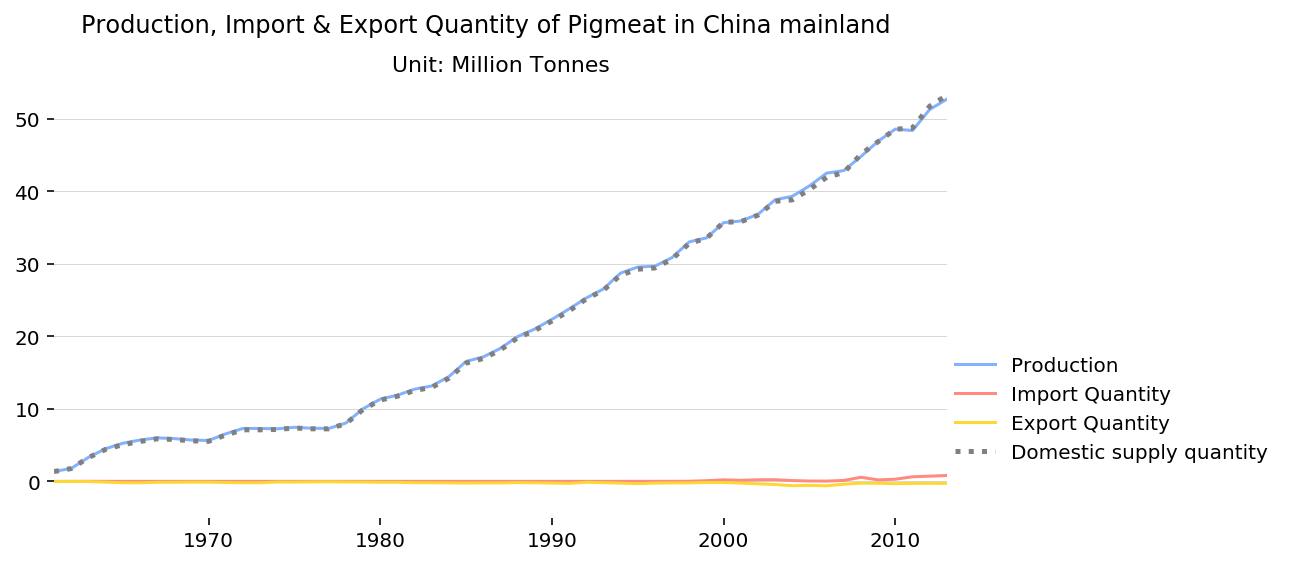

In [84]:
I = 'Pigmeat'

plotTrendsLine(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Production'], 
    ax1_ylim=(25,55),
    ax2_ylim=(-5,25),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

#### Bovine Meat

Production  Import Quantity  Export Quantity  Domestic supply quantity
Year                                                                        
2009      6.3540           0.0209           0.0860                    6.2889
2010      6.5384           0.0330           0.0553                    6.5161
2011      6.4750           0.0279           0.0601                    6.4428
2012      6.6230           0.0851           0.1019                    6.6062
2013      6.7300           0.3941           0.0347                    7.0895

Production, Import & Export Quantity of Bovine Meat in China mainland
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_01_Production, Import & Export Quantity of Bovine Meat in China mainland.png


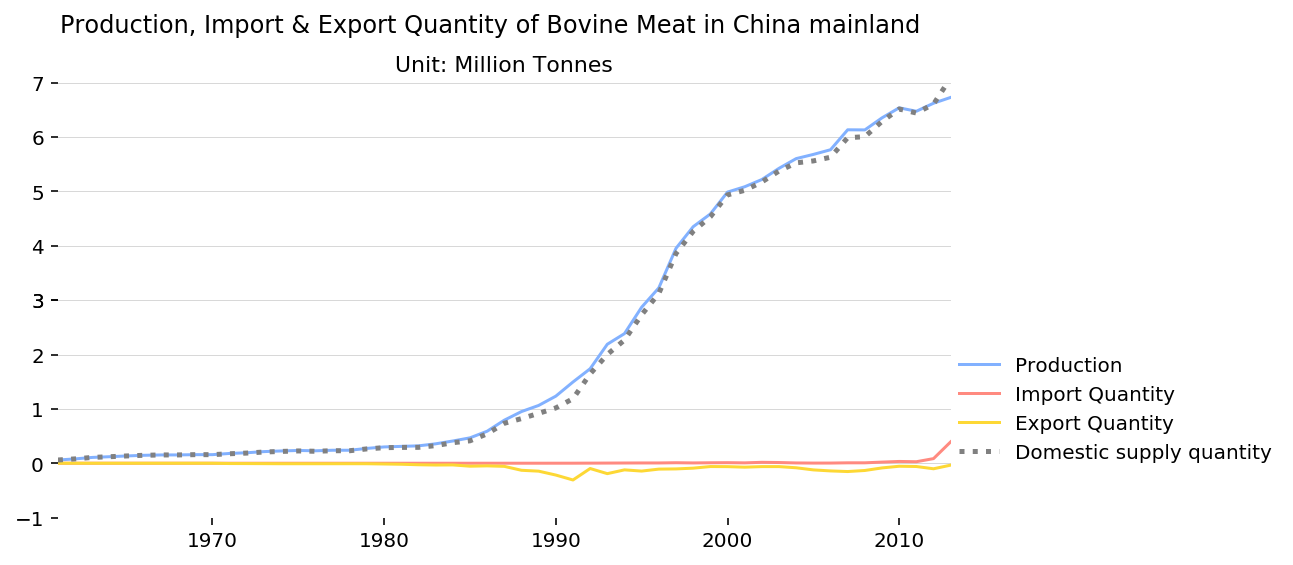

In [82]:
# 给 Item 赋值
I = 'Bovine Meat'
    
plotTrendsLine(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Production'], 
    ax1_ylim=(3,7),
    ax2_ylim=(-1,3),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

Production  Import Quantity  Export Quantity  Domestic supply quantity
Year                                                                        
2009      3.8385           0.0665           0.0095                    3.8954
2010      3.9890           0.0570           0.0135                    4.0325
2011      3.9310           0.0831           0.0081                    4.0060
2012      4.0100           0.1239           0.0050                    4.1289
2013      4.0810           0.2587           0.0032                    4.3365

Production, Import & Export Quantity of Mutton & Goat Meat in China mainland
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_01_Production, Import & Export Quantity of Mutton & Goat Meat in China mainland.png


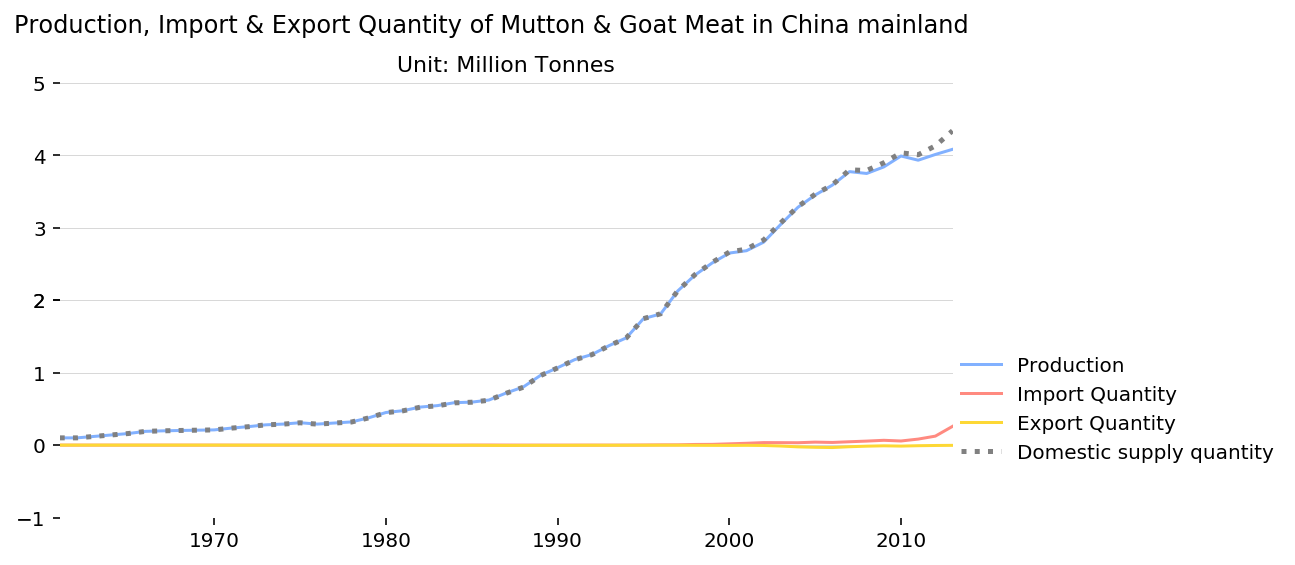

In [81]:
# 给 Item 赋值
I = 'Mutton & Goat Meat'
    
plotTrendsLine(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Production'], 
    ax1_ylim=(2,5),
    ax2_ylim=(-1,2),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

Production  Import Quantity  Export Quantity  Domestic supply quantity
Year                                                                        
2009     15.9490           0.7497           0.3858                   16.3129
2010     16.5610           0.5425           0.4916                   16.6118
2011     17.0880           0.4212           0.5521                   16.9570
2012     18.0326           0.5218           0.5538                   18.0006
2013     18.2649           0.5842           0.5640                   18.2851

Production, Import & Export Quantity of Poultry Meat in China mainland
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_01_Production, Import & Export Quantity of Poultry Meat in China mainland.png


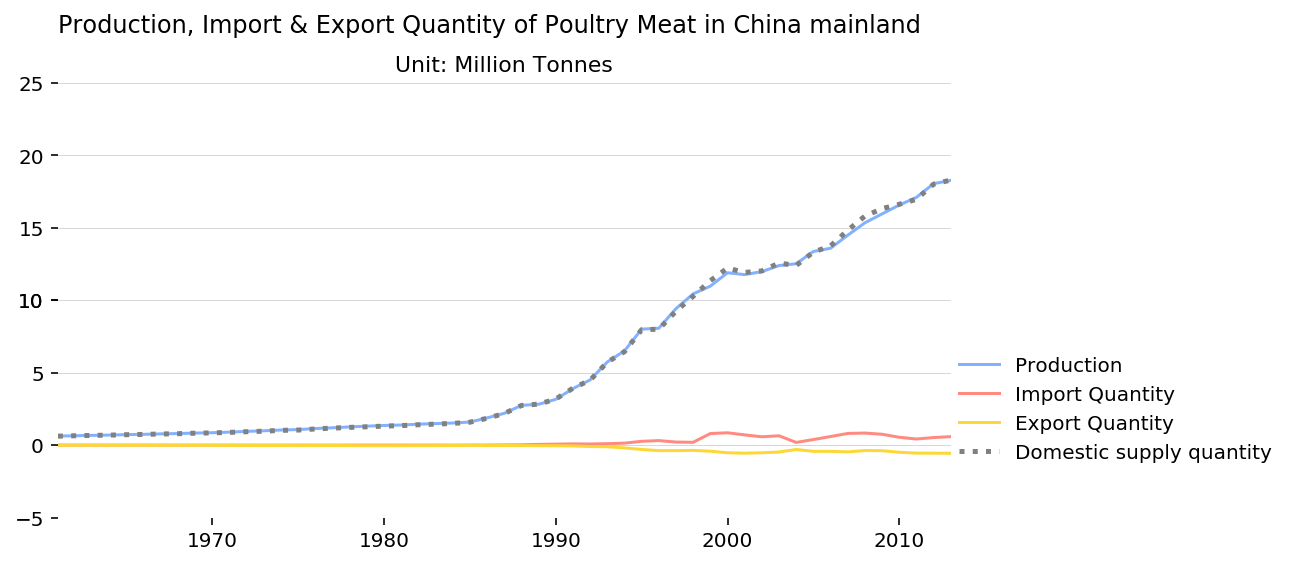

In [80]:
I = 'Poultry Meat'
    
plotTrendsLine(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Production'], 
    ax1_ylim=(10,25),
    ax2_ylim=(-5,10),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

Production  Import Quantity  Export Quantity  Domestic supply quantity
Year                                                                        
2009     48.7646           9.3423           6.2592                   51.7366
2010     51.1366           8.4508           7.3804                   52.1515
2011     53.4448           9.6753           8.2905                   54.9963
2012     56.2285           9.3298           7.1705                   58.3879
2013     56.2285           9.3298           7.1705                   58.3879

Production, Import & Export Quantity of Fish, Seafood in China mainland
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_01_Production, Import & Export Quantity of Fish, Seafood in China mainland.png


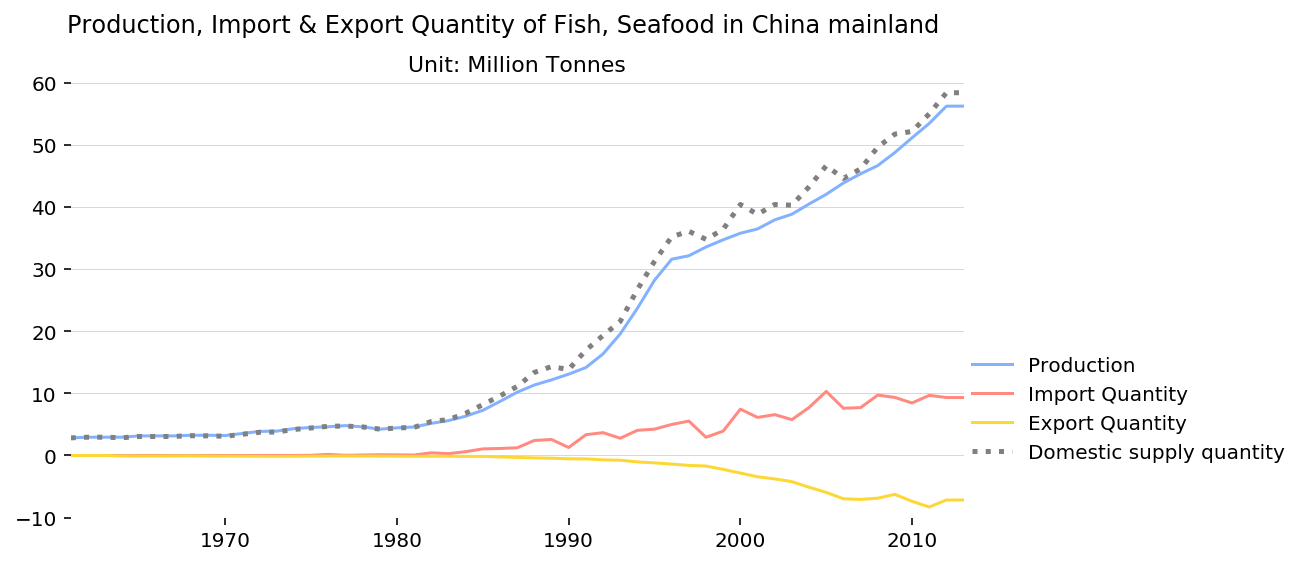

In [28]:
I = 'Fish, Seafood'
    
plotTrendsLine(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Production'], 
    ax1_ylim=(25,60),
    ax2_ylim=(-10,25),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

Production  Import Quantity  Export Quantity  Domestic supply quantity
Year                                                                        
2009     27.4250           0.0002           0.1458                   27.2794
2010     27.6270           0.0004           0.1102                   27.5172
2011     28.1141           0.0004           0.1082                   28.0063
2012     28.6120           0.0002           0.1084                   28.5038
2013     28.7600           0.0002           0.0978                   28.6623

Production, Import & Export Quantity of Eggs in China mainland
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_01_Production, Import & Export Quantity of Eggs in China mainland.png


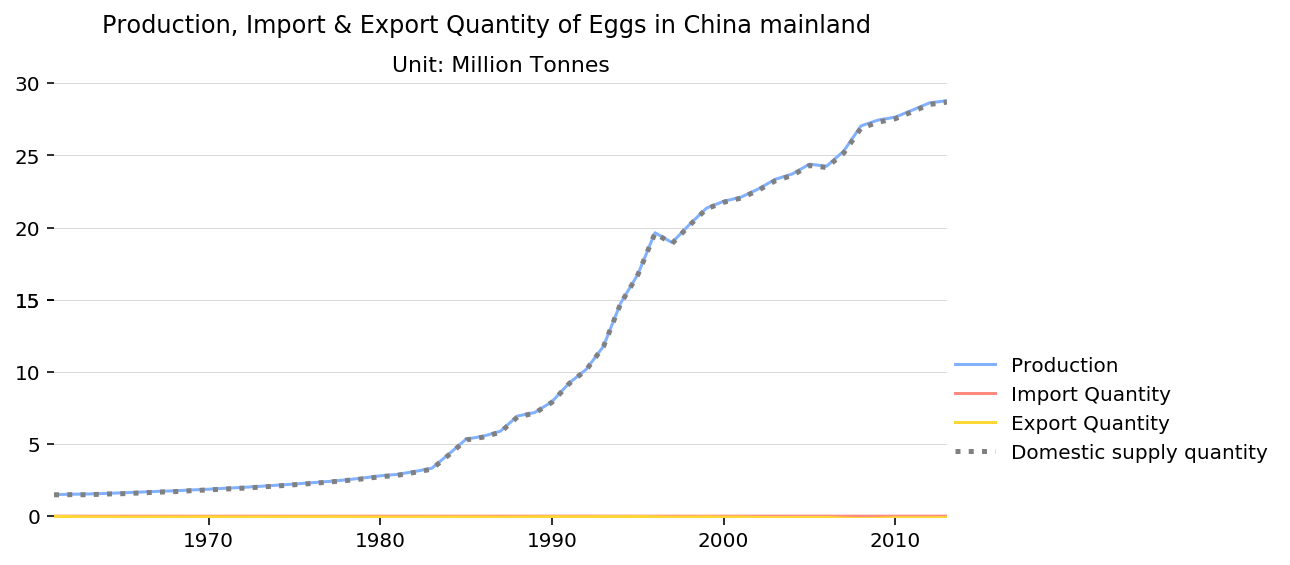

In [77]:
I = 'Eggs'

plotTrendsLine(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Production'], 
    ax1_ylim=(15,30),
    ax2_ylim=(-0.1,15),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

Production  Import Quantity  Export Quantity  Domestic supply quantity
Year                                                                        
2009     40.0461           2.2957           0.1493                   42.1925
2010     40.8028           3.6887           0.1901                   44.3014
2011     41.4350           4.1324           0.2375                   45.3299
2012     42.3841           5.6776           0.2598                   47.8019
2013     40.1932           8.2068           0.1289                   48.2711

Production, Import & Export Quantity of Milk Excluding Butter in China mainland
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_01_Production, Import & Export Quantity of Milk Excluding Butter in China mainland.png


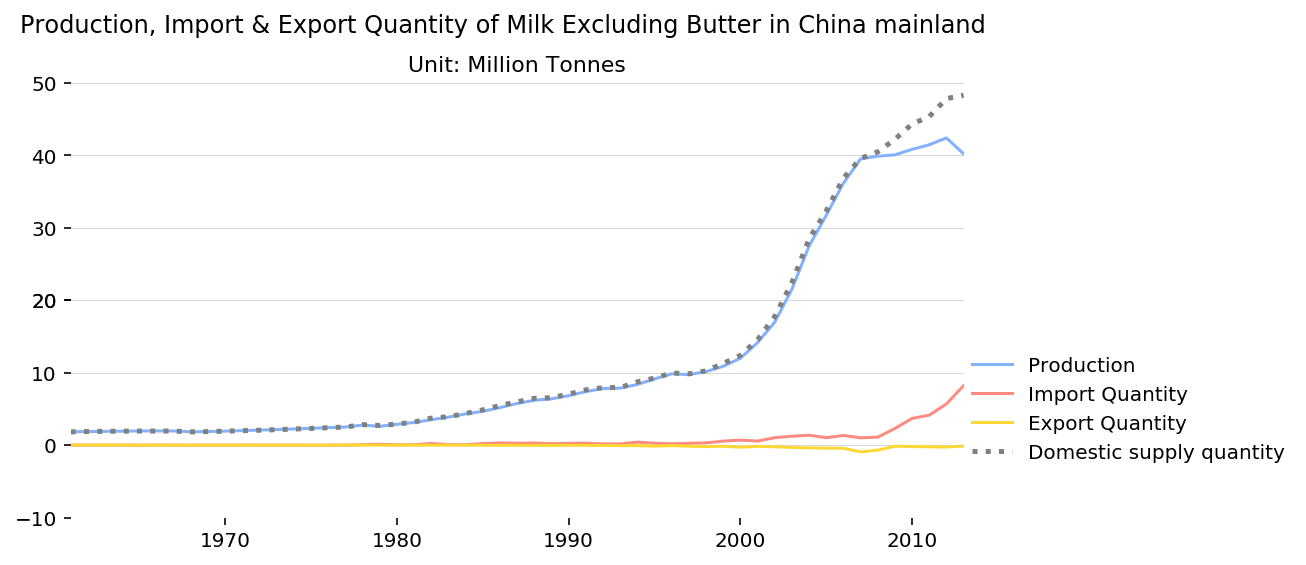

In [79]:
I = 'Milk - Excluding Butter'

plotTrendsLine(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Production'], 
    ax1_ylim=(20,50),
    ax2_ylim=(-10,20),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

### Domestic Supply, Food Supply, Feed Supply

In [21]:
for i in Is:
    PVs_YearArea[i] = mkPVs_forElements_YearArea(item=i, elements=Es['Domestic Supply, Consumption'])

    for e, pv in PVs_YearArea[i].items():
        display(i, e, pv.tail(2)) 

'Pigmeat'

'Food supply quantity (tonnes)'

Africa  Albania  Algeria    Americas    Angola  Argentina  Armenia  \
Year                                                                          
2012  1393326.0  34911.0    156.0  1.6339e+07  175154.0   366678.0  26532.0   
2013  1467822.0  34507.0    142.0  1.6817e+07  190791.0   435424.0  28799.0   

            Asia  Australia  Australia & New Zealand   Austria  Azerbaijan  \
Year                                                                         
2012  6.5766e+07   556682.0                 656554.0  407973.0      2571.0   
2013  6.7445e+07   563544.0                 663981.0  446509.0      2364.0   

      Bahamas  Bangladesh   Belarus   Belgium  Belize    Benin  \
Year                                                             
2012  12550.0         0.0  380351.0  446774.0  6186.0  10175.0   
2013  12344.0         0.0  377731.0  429167.0  5579.0   8216.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                           93076.0                 36863.0    1405.0   
2013                           94835.0                 35925.0    1501.0   

         Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
Year                                                                   
2012  2512759.0             2859.0  188209.0       32014.0   98613.0   
2013  2525057.0             3490.0  189659.0       32731.0   98684.0   

      Cameroon    Canada  Caribbean  Central African Republic  \
Year                                                            
2012   31156.0  845938.0   377201.0                   16459.0   
2013   32800.0  802413.0   412853.0                   17090.0   

      Central America  Central Asia   Chad     Chile  China, Hong Kong SAR  \
Year                                                                         
2012        2029254.0      242080.0  668.0  427958.0              460021.0   
2013        2139849.0      241378.0  677.0  434857.0              483496.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012           40363.0                   901004.0       5.1724e+07  280935.0   
2013           40457.0                   918440.0       5.3247e+07  314396.0   

        Congo  Costa Rica   Croatia      Cuba   Cyprus   Czechia  \
Year                                                               
2012   5140.0     49522.0  192585.0  196178.0  44799.0  450846.0   
2013  10632.0     50088.0  183567.0  223327.0  43788.0  440624.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN        27405.0                               114854.0   
2013             NaN        35826.0                               117072.0   

       Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                         
2012  141189.0     112.0             91711.0        471300.0    5.7500e+07   
2013  139739.0     152.0             98982.0        513661.0    5.9043e+07   

      Eastern Europe   Ecuador   Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                     
2012       8492609.0  213041.0  1266.0      17492.0  38177.0    1962.0   
2013       8507695.0  227220.0  1332.0      20473.0  38193.0    1962.0   

      Ethiopia PDR      Europe  European Union    Fiji   Finland     France  \
Year                                                                          
2012           NaN  2.5758e+07      2.0101e+07  3935.0  201789.0  2150504.0   
2013           NaN  2.5686e+07      1.9878e+07  3800.0  196114.0  2124732.0   

        Gabon  Gambia  Georgia    Germany    Ghana    Greece  Guatemala  \
Year                                 

'Pigmeat'

'Losses'

Americas     Asia  Belarus    Canada  Central America  Central Asia  \
Year                                                                        
2012  184024.0  71499.0    787.0  160350.0           1720.0         870.0   
2013  180134.0  71034.0    792.0  158440.0           1740.0         464.0   

      Cyprus  Eastern Asia  Eastern Europe  Estonia   Europe  European Union  \
Year                                                                           
2012  2689.0       49000.0         18856.0   4744.0  27654.0         20385.0   
2013  2526.0       49000.0         15493.0   4976.0  24318.0         20195.0   

      Georgia  Hungary    Japan  Kyrgyzstan  Land Locked Developing Countries  \
Year                                                                            
2012    339.0    174.0  49000.0       855.0                             870.0   
2013    425.0   2369.0  49000.0       449.0                             464.0   

      Latvia  Least Developed Countries  Lithuania  \
Year                                                 
2012   600.0                    18601.0     3454.0   
2013   600.0                    18619.0     3249.0   

      Low Income Food Deficit Countries  Myanmar  \
Year                                               
2012                              855.0  18601.0   
2013                              449.0  18619.0   

      Net Food Importing Developing Countries  Northern America  \
Year                                                              
2012                                  40541.0          160364.0   
2013                                  38559.0          158454.0   

      Northern Europe  Panama     Peru  Romania  Russian Federation  \
Year                                                                  
2012           8798.0  1720.0  20000.0   8725.0              9170.0   
2013           8825.0  1740.0  18000.0   6475.0              5857.0   

      Small Island Developing States  South America  South-Eastern Asia  \
Year                                                                      
2012                            14.0        21940.0             18601.0   
2013                            14.0        19940.0             18619.0   

      Turkmenistan  USSR  Venezuela (Bolivarian Republic of)  Western Asia  \
Year                                                                         
2012          15.0   NaN                              1940.0        3028.0   
2013          15.0   NaN                              1940.0        2951.0   

         World  
Year            
2012  283177.0  
2013  275487.0

'Pigmeat'

'Processing'

Africa  Americas     Asia  Austria  Belarus  Bulgaria  Canada  \
Year                                                                  
2012     0.0       1.0  28814.0      0.0      0.0       0.0     0.0   
2013    -1.0      -2.0  21148.0      0.0      0.0      -1.0     0.0   

      Central Asia  Chad  Chile  China, Taiwan Province of  China, mainland  \
Year                                                                          
2012           0.0   0.0    0.0                       -1.0          28815.0   
2013           0.0   0.0    0.0                        0.0          21148.0   

      Croatia  Cyprus  Czechia  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                           
2012      0.0     0.0      0.0             0.0       28814.0             0.0   
2013      0.0     0.0     -1.0            -1.0       21148.0            -1.0   

       Europe  European Union  Fiji  Finland  Georgia  Greece  Hungary  India  \
Year                                                                            
2012  15176.0          2676.0  -1.0      1.0      0.0     0.0      0.0    0.0   
2013  15027.0          2627.0  -1.0      1.0      0.0     1.0      1.0    0.0   

      Indonesia  Italy  Kazakhstan  Kenya  Land Locked Developing Countries  \
Year                                                                          
2012        0.0   -1.0         0.0    0.0                               0.0   
2013        0.0    0.0         0.0    0.0                              -1.0   

      Latvia  Least Developed Countries  Low Income Food Deficit Countries  \
Year                                                                         
2012     0.0                        0.0                                0.0   
2013     0.0                        0.0                               -1.0   

      Madagascar  Melanesia  Middle Africa  \
Year                                         
2012         0.0       -1.0            0.0   
2013         0.0       -1.0            0.0   

      Net Food Importing Developing Countries  Northern America  \
Year                                                              
2012                                      1.0               1.0   
2013                                      0.0              -2.0   

      Northern Europe  Oceania  Portugal  Russian Federation   Serbia  \
Year                                                                    
2012              1.0     -1.0    2675.0                 0.0  12500.0   
2013              1.0     -1.0    2626.0                 0.0  12400.0   

      Serbia and Montenegro  Slovenia  Small Island Developing States  \
Year                                                                    
2012                    NaN       0.0                            -1.0   
2013                    NaN       0.0                            -1.0   

      South America  South-Eastern Asia  Southern Asia  Southern Europe  \
Year                                                                      
2012            0.0                -1.0            1.0          15175.0   
2013            0.0                 0.0            0.0          15027.0   

      Spain  Sri Lanka  Thailand  USSR  Ukraine  United Kingdom  \
Year                                                              
2012    1.0        1.0      -1.0   NaN      0.0             0.0   
2013    0.0        0.0       0.0   NaN      0.0             0.0   

      United States of America  Western Asia  Western Europe    World  \
Year                                                                    
2012                       1.0           0.0             0.0  43990.0   
2013                      -2.0           0.0             0.0  36171.0   

      Zimbabwe  
Year            
2012       0.0  
2013      -1.0

'Pigmeat'

'Domestic supply quantity'

Africa  Albania  Algeria    Americas    Angola  Argentina  Armenia  \
Year                                                                          
2012  1393454.0  34911.0    157.0  1.6457e+07  175154.0   366679.0  28132.0   
2013  1468011.0  34507.0    183.0  1.6892e+07  190791.0   435424.0  30799.0   

            Asia  Australia  Australia & New Zealand   Austria  Azerbaijan  \
Year                                                                         
2012  6.5961e+07   556682.0                 656554.0  407973.0      2571.0   
2013  6.7556e+07   563544.0                 663981.0  446509.0      2364.0   

      Bahamas  Bangladesh   Belarus   Belgium  Belize    Benin  \
Year                                                             
2012  23468.0         0.0  381139.0  446774.0  6186.0  10175.0   
2013  20367.0         0.0  378523.0  429167.0  5579.0   8216.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                           93076.0                 36863.0    1405.0   
2013                           94835.0                 35925.0    1501.0   

         Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
Year                                                                   
2012  2512759.0             2859.0  188209.0       32014.0   98613.0   
2013  2525057.0             3490.0  189658.0       32731.0   98684.0   

      Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                             
2012   31156.0  1006288.0   398869.0                   16459.0   
2013   32800.0   960853.0   425431.0                   17090.0   

      Central America  Central Asia   Chad     Chile  China, Hong Kong SAR  \
Year                                                                         
2012        2031326.0      242950.0  668.0  427958.0              551298.0   
2013        2142246.0      241843.0  676.0  434857.0              500207.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012           40970.0                   902990.0       5.1752e+07  280935.0   
2013           41066.0                   920486.0       5.3268e+07  314396.0   

        Congo  Costa Rica   Croatia      Cuba   Cyprus   Czechia  \
Year                                                               
2012   5140.0     49875.0  192585.0  196178.0  58305.0  450846.0   
2013  10632.0     50744.0  183567.0  223327.0  56686.0  440623.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN        27405.0                               114854.0   
2013             NaN        35826.0                               117072.0   

       Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                         
2012  332618.0     112.0             91711.0        471300.0    5.7671e+07   
2013  291167.0     152.0             98982.0        513660.0    5.9132e+07   

      Eastern Europe   Ecuador   Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                     
2012       8545243.0  213041.0  1266.0      17492.0  42921.0    1962.0   
2013       8548558.0  227220.0  1332.0      20473.0  43169.0    1962.0   

      Ethiopia PDR      Europe  European Union    Fiji   Finland     France  \
Year                                                                          
2012           NaN  2.6069e+07      2.0388e+07  4103.0  201790.0  2150504.0   
2013           NaN  2.5940e+07      2.0114e+07  3969.0  196115.0  2124732.0   

        Gabon  Gambia  Georgia    Germany    Ghana    Greece  Guatemala  \
Year                             

'Bovine Meat'

'Food supply quantity (tonnes)'

Afghanistan     Africa  Albania   Algeria    Americas    Angola  \
Year                                                                    
2012     153438.0  6058170.0  70824.0  221826.0  2.7997e+07  169870.0   
2013     140087.0  6299307.0  71383.0  219582.0  2.8181e+07  180712.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012  2271775.0  56582.0  1.8535e+07   818413.0                 900695.0   
2013  2299590.0  58521.0  1.8768e+07   790362.0                 891681.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
Year                                                                          
2012  147534.0    115294.0   9304.0    199432.0  181246.0  175005.0  1603.0   
2013  145588.0    119317.0   7511.0    200522.0  160063.0  173502.0  1614.0   

        Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                      
2012  31318.0                          211470.0                 34085.0   
2013  31520.0                          211065.0                 34929.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012   16633.0  7811103.0             4609.0   28137.0      128453.0   
2013   15858.0  7863343.0             5080.0   27733.0       75944.0   

      Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                                       
2012   73296.0   88711.0  1062911.0   254483.0                   90000.0   
2013   73479.0   92857.0  1064325.0   257572.0                   55000.0   

      Central America  Central Asia     Chad     Chile  China, Hong Kong SAR  \
Year                                                                           
2012        2187158.0     1394608.0  98003.0  359012.0              205402.0   
2013        2241586.0     1455129.0  98403.0  420339.0              185974.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012            5829.0                   108620.0        6606176.0  827677.0   
2013            5885.0                   121585.0        7089479.0  790406.0   

        Congo  Costa Rica  Croatia     Cuba  Cyprus  Czechia  Czechoslovakia  \
Year                                                                           
2012  14029.0     74210.0  54252.0  70530.0  7643.0  86673.0             NaN   
2013  19340.0     74199.0  53253.0  72039.0  6611.0  87260.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
Year                                                                   
2012        33879.0                                21975.0  153334.0   
2013        34539.0                                21975.0  159920.0   

      Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                               
2012    7256.0             98037.0       1678700.0     8853538.0   
2013    8729.0            102830.0       1713491.0     9361049.0   

      Eastern Europe   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                        
2012       3410302.0  265951.0  1067378.0      46256.0  13845.0  337251.0   
2013       3381153.0  261378.0  1056718.0      37754.0   9253.0  339851.0   

      Ethiopia PDR      Europe  European Union    Fiji   Finland     France  \
Year                                                                          
2012           NaN  1.1295e+07       7822261.0  9304.0  104287.0  1606019.0   
2013           NaN  1.1048e+07       7585066.0  7897.0  104287.0  1530980.0   

        Gabon  Gambia  Georgia    Germany    

'Bovine Meat'

'Losses'

Americas  Argentina     Asia  Belarus  Caribbean  Central America  \
Year                                                                      
2012  212937.0   110927.0  50807.0   1473.0       58.0           4625.0   
2013  394107.0   289494.0  51335.0    558.0       56.0           4290.0   

      Central Asia  Colombia  Cyprus  Czechoslovakia  Denmark  Eastern Asia  \
Year                                                                          
2012       24118.0   17085.0   402.0             NaN    736.0       25000.0   
2013       24634.0   16968.0   356.0             NaN   1281.0       25000.0   

      Eastern Europe  Estonia   Europe  European Union  Georgia  Germany  \
Year                                                                       
2012         14730.0    162.0  22200.0         14228.0    325.0   5000.0   
2013         12837.0    112.0  19766.0         12788.0    405.0   5000.0   

      Guatemala  Hungary  Jamaica    Japan  Kazakhstan  \
Year                                                     
2012        0.0    500.0     58.0  25000.0     17800.0   
2013        0.0    500.0     56.0  25000.0     18300.0   

      Land Locked Developing Countries  Latvia  Least Developed Countries  \
Year                                                                        
2012                           24118.0   365.0                        0.0   
2013                           24634.0   360.0                        0.0   

      Lithuania  Myanmar  Net Food Importing Developing Countries  \
Year                                                                
2012     1207.0      0.0                                  80194.0   
2013      176.0      0.0                                  83301.0   

      Northern America  Northern Europe  Panama     Peru  Romania  \
Year                                                                
2012             106.0           2470.0  4625.0  55000.0   5857.0   
2013              54.0           1929.0  4290.0  54000.0   5003.0   

      Russian Federation  Small Island Developing States  South America  \
Year                                                                      
2012              5346.0                           164.0       208148.0   
2013              5065.0                           110.0       389707.0   

      South-Eastern Asia  Turkmenistan  USSR  Ukraine  United Arab Emirates  \
Year                                                                          
2012                 0.0        6318.0   NaN   1554.0                 962.0   
2013                 0.0        6334.0   NaN   1711.0                 940.0   

      Venezuela (Bolivarian Republic of)  Western Asia  Western Europe  \
Year                                                                     
2012                             25136.0        1689.0          5000.0   
2013                             29245.0        1701.0          5000.0   

         World  
Year            
2012  285943.0  
2013  465208.0

'Bovine Meat'

'Feed'

Asia  Central Asia  Eastern Europe  Europe  Georgia  Kazakhstan  \
Year                                                                      
2012  8300.0        8200.0             0.0     0.0    100.0      8200.0   
2013  8600.0        8500.0             0.0     0.0    100.0      8500.0   

      Land Locked Developing Countries  Ukraine  Western Asia   World  
Year                                                                   
2012                            8200.0      0.0         100.0  8300.0  
2013                            8500.0      0.0         100.0  8600.0

'Bovine Meat'

'Processing'

Africa  Americas  Asia  Australia  Australia & New Zealand  Austria  \
Year                                                                        
2012     1.0       0.0  -1.0        0.0                      0.0      0.0   
2013     2.0       0.0  -1.0        0.0                      0.0     -1.0   

      Caribbean  China, Taiwan Province of  Cyprus  Eastern Africa  \
Year                                                                 
2012        0.0                        0.0     0.0             1.0   
2013        0.0                        0.0     0.0             1.0   

      Eastern Asia  Eastern Europe   Europe  European Union  Fiji  Finland  \
Year                                                                         
2012           0.0        -21415.0 -21417.0        -21417.0   0.0      0.0   
2013           1.0        -18625.0 -18631.0        -18631.0   0.0      0.0   

      France  Greece  Hungary  India  Indonesia  Ireland  Japan  \
Year                                                              
2012     0.0     0.0 -21415.0   -1.0        1.0      0.0    0.0   
2013    -1.0    -1.0 -18625.0   -1.0        0.0      0.0    0.0   

      Land Locked Developing Countries  Latvia  Least Developed Countries  \
Year                                                                        
2012                               0.0    -1.0                        1.0   
2013                               0.0    -2.0                        1.0   

      Low Income Food Deficit Countries  Madagascar  Malaysia  Melanesia  \
Year                                                                       
2012                                1.0         1.0       0.0        0.0   
2013                               -1.0         1.0       0.0        0.0   

      Morocco  Net Food Importing Developing Countries  Northern Africa  \
Year                                                                      
2012      0.0                                      2.0              0.0   
2013      1.0                                      1.0              1.0   

      Northern America  Northern Europe  Norway  Oceania  Pakistan  Poland  \
Year                                                                         
2012               0.0             -2.0     0.0      0.0       1.0     0.0   
2013               0.0             -2.0     0.0      0.0      -1.0     0.0   

      Republic of Korea  Serbia and Montenegro  Slovenia  \
Year                                                       
2012                0.0                    NaN       0.0   
2013                1.0                    NaN       0.0   

      Small Island Developing States  South-Eastern Asia  Southern Asia  \
Year                                                                      
2012                             0.0                 0.0            0.0   
2013                             0.0                -1.0           -2.0   

      Southern Europe  Sweden  Thailand  Turkey  Uganda  United Kingdom  \
Year                                                                      
2012              0.0    -1.0      -1.0    -1.0     0.0             0.0   
2013             -1.0     1.0      -1.0     1.0     0.0            -1.0   

      United States of America  Western Asia  Western Europe    World  \
Year                                                                    
2012                       0.0          -1.0             0.0 -21417.0   
2013                       0.0           1.0            -2.0 -18630.0   

      Yugoslav SFR  Zimbabwe  
Year                          
2012           NaN       0.0  
2013           NaN       0.0

'Bovine Meat'

'Domestic supply quantity'

Afghanistan     Africa  Albania   Algeria    Americas    Angola  \
Year                                                                    
2012     153438.0  6065426.0  70824.0  221826.0  2.8212e+07  169870.0   
2013     140087.0  6307008.0  71383.0  219582.0  2.8578e+07  180714.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012  2382702.0  57582.0  1.8661e+07   818414.0                 900697.0   
2013  2589084.0  60521.0  1.8855e+07   790362.0                 891681.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
Year                                                                          
2012  147534.0    121294.0  21469.0    199432.0  182719.0  175005.0  1903.0   
2013  145587.0    125317.0  18969.0    200522.0  160621.0  173502.0  2114.0   

        Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                      
2012  31318.0                          211470.0                 34085.0   
2013  31520.0                          211064.0                 34929.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012   16633.0  7811103.0             4609.0   28138.0      128453.0   
2013   15858.0  7863343.0             5080.0   27733.0       75944.0   

      Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                                       
2012   73296.0   88711.0  1062911.0   267349.0                   90000.0   
2013   73479.0   92857.0  1064325.0   270404.0                   55000.0   

      Central America  Central Asia     Chad     Chile  China, Hong Kong SAR  \
Year                                                                           
2012        2192043.0     1459576.0  98003.0  359003.0              244906.0   
2013        2246302.0     1510551.0  98403.0  420275.0              194886.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012            5859.0                   108637.0        6606176.0  844756.0   
2013            5915.0                   121602.0        7089479.0  807375.0   

        Congo  Costa Rica  Croatia     Cuba  Cyprus  Czechia  Czechoslovakia  \
Year                                                                           
2012  14029.0     74206.0  54252.0  70530.0  8492.0  86673.0             NaN   
2013  19340.0     74194.0  53253.0  72039.0  7358.0  87259.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
Year                                                                   
2012        33879.0                                21975.0  154069.0   
2013        34539.0                                21975.0  161201.0   

      Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                               
2012    7256.0             98037.0       1677533.0     8918089.0   
2013    8729.0            102830.0       1711683.0     9395009.0   

      Eastern Europe   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                        
2012       3406594.0  265951.0  1067378.0      46256.0  14007.0  337251.0   
2013       3378102.0  261378.0  1056718.0      37754.0   9365.0  339851.0   

      Ethiopia PDR      Europe  European Union    Fiji   Finland     France  \
Year                                                                          
2012           NaN  1.1302e+07       7820883.0  9615.0  104287.0  1606019.0   
2013           NaN  1.1053e+07       7582582.0  8213.0  104289.0  1530979.0   

        Gabon  Gambia  Georgia    Germany    

'Mutton & Goat Meat'

'Food supply quantity (tonnes)'

Afghanistan     Africa  Albania   Algeria  Americas   Angola  Argentina  \
Year                                                                            
2012     155201.0  2692310.0  48221.0  281753.0  606674.0  22230.0    65617.0   
2013     150201.0  2766828.0  48618.0  301320.0  625754.0  23101.0    64588.0   

      Armenia       Asia  Australia  Australia & New Zealand  Austria  \
Year                                                                    
2012   8500.0  7932382.0   227034.0                 320232.0   9536.0   
2013   9000.0  8255188.0   230507.0                 315714.0   9877.0   

      Azerbaijan  Bahamas  Bangladesh  Belarus  Belgium  Belize   Benin  \
Year                                                                      
2012     70406.0   2514.0    204140.0   1000.0  13545.0    37.0  8535.0   
2013     70994.0   1969.0    208210.0   1000.0  14608.0    46.0  8617.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                           18706.0                  2471.0    7574.0   
2013                           18309.0                  1783.0    7600.0   

        Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
Year                                                                            
2012  120769.0             1052.0   15928.0       54842.0      13.0   27022.0   
2013  124657.0              958.0   11772.0       41073.0      22.0   31218.0   

       Canada  Caribbean  Central African Republic  Central America  \
Year                                                                  
2012  31220.0    35040.0                   23592.0         111462.0   
2013  34008.0    33993.0                   23740.0         113437.0   

      Central Asia     Chad   Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                                          
2012      490627.0  42242.0  9928.0                9769.0             392.0   
2013      509242.0  43020.0  7436.0               15978.0             410.0   

      China, Taiwan Province of  China, mainland  Colombia   Congo  \
Year                                                                 
2012                    21183.0        4128895.0   10546.0  1686.0   
2013                    21370.0        4336508.0   10278.0  1788.0   

      Costa Rica  Croatia     Cuba  Cyprus  Czechia  Czechoslovakia  \
Year                                                                  
2012        80.0   6950.0  14721.0  6391.0   3330.0             NaN   
2013        74.0   7316.0  13932.0  5766.0   3666.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
Year                                                                            
2012        13717.0                                15705.0   4224.0    4667.0   
2013        13850.0                                15705.0   5161.0    4665.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                     
2012              2180.0        449871.0     4322324.0        318703.0   
2013              2270.0        466601.0     4544451.0        313245.0   

      Ecuador     Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
Year                                                                    
2012   6712.0  131219.0        130.0    564.0  143843.0           NaN   
2013   6949.0  129625.0        134.0    565.0  147793.0           NaN   

         Europe  European Union    Fiji  Finland    France   Gabon  Gambia  \
Year                                                                         
2012  1413505.0       1073133.0  5161.0   3105.0  210769.0  2094.0  1395.0   
2013  1416099.0       1067472.0  5198.0   2893.0  210636.0  2122.0  1315.0   

      Georgia  Germany    Ghana    Greece  Guatemala   Guinea

'Mutton & Goat Meat'

'Losses'

Americas     Asia  Belarus  Central Asia  Cyprus  Eastern Asia  \
Year                                                                   
2012   13600.0  17205.0     19.0        9593.0   347.0         347.0   
2013   11000.0  18422.0    127.0       10293.0   314.0         374.0   

      Eastern Europe  Europe  European Union   Italy  Japan  Kyrgyzstan  \
Year                                                                      
2012          1488.0  4220.0          4548.0  2732.0  347.0      3093.0   
2013          1590.0  3897.0          4084.0  2307.0  374.0      3793.0   

      Land Locked Developing Countries  Low Income Food Deficit Countries  \
Year                                                                        
2012                            9593.0                             3093.0   
2013                           10293.0                             3793.0   

      Net Food Importing Developing Countries   Oman     Peru  Poland  \
Year                                                                    
2012                                  13600.0  861.0  13600.0    88.0   
2013                                  11000.0  869.0  11000.0    86.0   

      Romania  South America  Southern Europe  Turkmenistan  USSR  \
Year                                                                
2012   1381.0        13600.0           2732.0        6500.0   NaN   
2013   1377.0        11000.0           2307.0        6500.0   NaN   

      United Arab Emirates  Western Asia    World  
Year                                               
2012                6057.0        7265.0  35025.0  
2013                6572.0        7755.0  33319.0

'Mutton & Goat Meat'

'Feed'

Americas  Canada  Northern America  United States of America    World
Year                                                                       
2012   17402.0  1907.0           17402.0                   15495.0  17402.0
2013   17699.0  1982.0           17699.0                   15717.0  17699.0

'Mutton & Goat Meat'

'Domestic supply quantity'

Afghanistan     Africa  Albania   Algeria  Americas   Angola  Argentina  \
Year                                                                            
2012     155200.0  2692946.0  48221.0  281753.0  637946.0  22230.0    65617.0   
2013     150200.0  2767480.0  48618.0  301320.0  654696.0  23101.0    64588.0   

      Armenia       Asia  Australia  Australia & New Zealand  Austria  \
Year                                                                    
2012   8500.0  7960329.0   243917.0                 345959.0   9536.0   
2013   9000.0  8306475.0   248331.0                 334609.0   9877.0   

      Azerbaijan  Bahamas  Bangladesh  Belarus  Belgium  Belize   Benin  \
Year                                                                      
2012     70406.0   2564.0    204140.0   1019.0  13545.0    37.0  8535.0   
2013     70994.0   2019.0    208210.0   1127.0  14608.0    46.0  8617.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                           18704.0                  2471.0    7574.0   
2013                           18309.0                  1783.0    7600.0   

        Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
Year                                                                            
2012  120769.0             1052.0   15928.0       54842.0      13.0   27022.0   
2013  124657.0              958.0   11772.0       41073.0      22.0   31218.0   

       Canada  Caribbean  Central African Republic  Central America  \
Year                                                                  
2012  33127.0    35279.0                   23592.0         111461.0   
2013  35990.0    34210.0                   23740.0         113437.0   

      Central Asia     Chad   Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                                          
2012      500220.0  42242.0  9928.0               14769.0             392.0   
2013      519535.0  43020.0  7436.0               16978.0             410.0   

      China, Taiwan Province of  China, mainland  Colombia   Congo  \
Year                                                                 
2012                    21183.0        4128895.0   10545.0  1686.0   
2013                    21370.0        4336508.0   10277.0  1788.0   

      Costa Rica  Croatia     Cuba  Cyprus  Czechia  Czechoslovakia  \
Year                                                                  
2012        80.0   6950.0  14721.0  6951.0   3330.0             NaN   
2013        74.0   7316.0  13932.0  6280.0   3666.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
Year                                                                            
2012        13717.0                                15705.0   4224.0    4667.0   
2013        13850.0                                15705.0   5161.0    4665.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                     
2012              2180.0        449872.0     4328671.0        320191.0   
2013              2270.0        466601.0     4572825.0        314835.0   

      Ecuador     Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
Year                                                                    
2012   6712.0  131219.0        130.0    564.0  143843.0           NaN   
2013   6949.0  129625.0        134.0    565.0  147793.0           NaN   

         Europe  European Union    Fiji  Finland    France   Gabon  Gambia  \
Year                                                                         
2012  1434103.0       1094273.0  5161.0   3105.0  222538.0  2094.0  1395.0   
2013  1431151.0       1082912.0  5198.0   2893.0  217285.0  2122.0  1315.0   

      Georgia  Germany    Ghana    Greece  Guatemala   Guinea

'Poultry Meat'

'Food supply quantity (tonnes)'

Afghanistan     Africa  Albania   Algeria    Americas    Angola  \
Year                                                                    
2012      46550.0  6323309.0  40335.0  291485.0  3.6195e+07  349323.0   
2013      74789.0  6700229.0  41986.0  290945.0  3.7826e+07  372094.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012  1620088.0  41321.0  4.0811e+07  1050543.0                1213833.0   
2013  1602261.0  39748.0  4.1721e+07  1076683.0                1234314.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
Year                                                                          
2012  162984.0     99463.0  17628.0    217239.0  270280.0  140380.0  8761.0   
2013  158073.0     99010.0  17242.0    219639.0  292785.0  135470.0  9400.0   

         Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                       
2012  201270.0                          361362.0                 62372.0   
2013  202804.0                          366169.0                 50435.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012    9212.0  8112864.0            26170.0  171532.0       39197.0   
2013   10776.0  9016211.0            26281.0  149381.0       38242.0   

      Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                                       
2012   28661.0   70761.0  1279131.0   835097.0                    6932.0   
2013   27817.0   73251.0  1290495.0   881449.0                    6711.0   

      Central America  Central Asia    Chad     Chile  China, Hong Kong SAR  \
Year                                                                          
2012        4465369.0      433660.0  5399.0  627064.0              424704.0   
2013        4606679.0      410249.0  5420.0  643476.0              395180.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland   Colombia  \
Year                                                                            
2012           20441.0                   759025.0       1.7999e+07  1168954.0   
2013           20522.0                   749640.0       1.8284e+07  1332031.0   

        Congo  Costa Rica  Croatia      Cuba   Cyprus   Czechia  \
Year                                                              
2012  42410.0    110808.0  38821.0  212387.0  29195.0  216918.0   
2013  57891.0    119213.0  36557.0  227065.0  27900.0  204333.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN        43155.0                                43800.0   
2013             NaN        48728.0                                43800.0   

       Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                         
2012  123420.0    4603.0            256663.0        575443.0    2.2550e+07   
2013  150297.0    1794.0            286692.0        544561.0    2.2758e+07   

      Eastern Europe   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                        
2012       7324726.0  333495.0  1033074.0     119957.0  25940.0   60507.0   
2013       7433865.0  343824.0  1184467.0     125769.0  27173.0   61867.0   

      Ethiopia PDR      Europe  European Union     Fiji   Finland     France  \
Year                                                                           
2012           NaN  1.7302e+07      1.1591e+07  27462.0  103577.0  1535351.0   
2013           NaN  1.7330e+07      1.1488e+07  17849.0  107838.0  1473982.0   

        Gabon  Gambia  Ge

'Poultry Meat'

'Losses'

Americas     Asia  Central America  Central Asia  Cyprus  Eastern Asia  \
Year                                                                           
2012  249758.0  98657.0          19758.0         618.0  1588.0       37648.0   
2013  250758.0  99894.0          20758.0         618.0  1533.0       37467.0   

      Eastern Europe   Europe  European Union  Guatemala  Hungary    Japan  \
Year                                                                         
2012         28890.0  28890.0         30478.0    18235.0  12700.0  37648.0   
2013         32616.0  32616.0         34149.0    19208.0  11000.0  37467.0   

      Land Locked Developing Countries  Least Developed Countries  Myanmar  \
Year                                                                         
2012                             618.0                    32403.0  32403.0   
2013                             618.0                    32504.0  32504.0   

      Net Food Importing Developing Countries  Panama      Peru   Poland  \
Year                                                                       
2012                                 262403.0  1523.0  230000.0  16190.0   
2013                                 262504.0  1550.0  230000.0  21616.0   

      South America  South-Eastern Asia  Thailand  Turkmenistan  Western Asia  \
Year                                                                            
2012       230000.0             58803.0   26400.0         618.0        1588.0   
2013       230000.0             60276.0   27772.0         618.0        1533.0   

         World  
Year            
2012  377305.0  
2013  383268.0

'Poultry Meat'

'Feed'

Austria  Europe  European Union  Western Europe  World
Year                                                        
2012      0.0     0.0             0.0             0.0    0.0
2013      0.0     0.0             0.0             0.0    0.0

'Poultry Meat'

'Processing'

Americas    Asia  Australia & New Zealand  Austria  Belarus  Belgium  \
Year                                                                         
2012   35400.0  2601.0                      0.0  10800.0    610.0   4500.0   
2013   29456.0  2599.0                      0.0  10500.0    700.0   7500.0   

      Bosnia and Herzegovina  Brazil  Bulgaria  China, mainland  Croatia  \
Year                                                                       
2012                     0.0     0.0    1350.0           1500.0    250.0   
2013                   200.0     0.0    1350.0           1500.0    245.0   

      Cyprus  Czechia  Czechoslovakia  Denmark  Eastern Asia  Eastern Europe  \
Year                                                                           
2012     0.0      0.0             NaN    700.0        1500.0         39160.0   
2013     0.0      0.0             NaN    700.0        1500.0         55950.0   

        Europe  European Union  Finland   France   Germany  Greece  Hungary  \
Year                                                                          
2012  377305.0        359349.0   6300.0  74000.0   82000.0   669.0   9300.0   
2013  438706.0        406231.0   6300.0  72000.0  100000.0   706.0   9800.0   

      Ireland  Israel    Italy  Land Locked Developing Countries  Lithuania  \
Year                                                                          
2012   3700.0  1100.0  17000.0                               0.0      500.0   
2013   8800.0  1100.0  16000.0                               0.0      500.0   

      Netherlands  New Zealand  Northern America  Northern Europe  Norway  \
Year                                                                        
2012      18000.0          0.0           30800.0         115396.0    96.0   
2013      31500.0          0.0           24100.0         125975.0    75.0   

      Oceania  Poland  Portugal  Republic of Moldova  Romania  \
Year                                                            
2012      0.0  6600.0     800.0                  0.0    250.0   
2013      0.0  8600.0     800.0                  0.0    200.0   

      Russian Federation  Slovakia  Slovenia  South America  Southern Europe  \
Year                                                                           
2012             14250.0    3800.0    1230.0         4600.0          33449.0   
2013             28500.0    3800.0    1330.0         5356.0          35281.0   

        Spain   Sweden  Turkey  Ukraine  United Kingdom  \
Year                                                      
2012  13500.0  17100.0     1.0   3000.0         87000.0   
2013  16000.0  18600.0    -1.0   3000.0         91000.0   

      United States of America  Uruguay  Western Asia  Western Europe  \
Year                                                                    
2012                   30800.0   4600.0        1101.0        189300.0   
2013                   24100.0   5356.0        1099.0        221500.0   

         World  Yugoslav SFR  
Year                          
2012  415306.0           NaN  
2013  470761.0           NaN

'Poultry Meat'

'Domestic supply quantity'

Afghanistan     Africa  Albania   Algeria    Americas    Angola  \
Year                                                                    
2012      46550.0  6341239.0  40335.0  291356.0  3.7255e+07  349323.0   
2013      74789.0  6719542.0  41986.0  290625.0  3.8912e+07  372094.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012  1620088.0  41321.0  4.1366e+07  1050543.0                1213834.0   
2013  1602261.0  39748.0  4.2225e+07  1076683.0                1234314.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium   Belize  \
Year                                                                           
2012  173784.0     99463.0  24628.0    217239.0  270890.0  144880.0  14683.0   
2013  168573.0     99010.0  24292.0    219639.0  293485.0  142970.0  16400.0   

         Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                       
2012  201270.0                          361362.0                 62372.0   
2013  202804.0                          366170.0                 50635.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012    9212.0  8112862.0            26169.0  172715.0       39197.0   
2013   10776.0  9016208.0            26281.0  150628.0       38242.0   

      Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                                       
2012   28661.0   70761.0  1279131.0   864871.0                    6932.0   
2013   27817.0   73251.0  1290495.0   912588.0                    6711.0   

      Central America  Central Asia    Chad     Chile  China, Hong Kong SAR  \
Year                                                                          
2012        4528049.0      480778.0  5399.0  627064.0              461432.0   
2013        4672437.0      457367.0  5420.0  643476.0              448570.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland   Colombia  \
Year                                                                            
2012           20763.0                   759162.0       1.8001e+07  1168954.0   
2013           20844.0                   749777.0       1.8285e+07  1332031.0   

        Congo  Costa Rica  Croatia      Cuba   Cyprus   Czechia  \
Year                                                              
2012  42410.0    110808.0  39071.0  212387.0  35542.0  216918.0   
2013  57891.0    119213.0  36802.0  227065.0  34031.0  204333.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN        43155.0                                43800.0   
2013             NaN        48728.0                                43800.0   

       Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                         
2012  124120.0    4603.0            256663.0        576580.0    2.2626e+07   
2013  150997.0    1794.0            286692.0        545720.0    2.2851e+07   

      Eastern Europe   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                        
2012       7392609.0  333495.0  1033074.0     119957.0  25940.0   60507.0   
2013       7522328.0  343824.0  1184467.0     125769.0  27173.0   61867.0   

      Ethiopia PDR      Europe  European Union     Fiji   Finland     France  \
Year                                                                           
2012           NaN  1.7726e+07      1.2003e+07  28561.0  109877.0  1609351.0   
2013           NaN  1.7820e+07      1.1952e+07  18566.0  114138.0  1545982.0   

        Gabon  Gambia

'Fish, Seafood'

'Food supply quantity (tonnes)'

Afghanistan      Africa  Albania   Algeria    Americas    Angola  \
Year                                                                     
2012       2050.0  1.0638e+07  15705.0  153590.0  1.3563e+07  329326.0   
2013       2050.0  1.0718e+07  15458.0  153590.0  1.3724e+07  329326.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012   241392.0  10156.0  9.1915e+07   598646.0                 707089.0   
2013   292243.0  13044.0  9.1356e+07   609128.0                 721435.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
Year                                                                          
2012  115921.0     20072.0  11082.0   3007715.0  143831.0  277640.0  4557.0   
2013  117929.0     20072.0  10427.0   3007715.0  153819.0  277915.0  4557.0   

         Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                       
2012  128535.0                           22916.0                 17657.0   
2013  137755.0                           23368.0                 16380.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012    9851.0  2177590.0            18939.0   42226.0      113831.0   
2013    8182.0  2177590.0            19521.0   50139.0      113831.0   

      Cambodia  Cameroon    Canada  Caribbean  Central African Republic  \
Year                                                                      
2012  603625.0  341708.0  756461.0   334361.0                   38486.0   
2013  626972.0  341763.0  792322.0   334964.0                   35855.0   

      Central America  Central Asia     Chad     Chile  China, Hong Kong SAR  \
Year                                                                           
2012        1521786.0      146057.0  60738.0  221752.0              503104.0   
2013        1521319.0      145495.0  60738.0  220097.0              503104.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012           31034.0                   826007.0       4.7754e+07  300898.0   
2013           31034.0                   826007.0       4.7754e+07  300898.0   

         Congo  Costa Rica  Croatia     Cuba   Cyprus  Czechia  \
Year                                                             
2012  109481.0     63298.0  79759.0  61780.0  24652.0  90737.0   
2013  117705.0     62831.0  81438.0  62705.0  24652.0  92018.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN       314575.0                               232357.0   
2013             NaN       314575.0                               232357.0   

       Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                         
2012  127810.0    3167.0             84149.0       1595595.0    5.8696e+07   
2013  130130.0    3276.0             84149.0       1598914.0    5.8128e+07   

      Eastern Europe   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                        
2012       4989550.0  128435.0  1811370.0      42923.0  18911.0   23079.0   
2013       5025088.0  128435.0  1814761.0      42923.0  18911.0   23079.0   

      Ethiopia PDR      Europe  European Union     Fiji   Finland     France  \
Year                                                                           
2012           NaN  1.6084e+07      1.1322e+07  31794.0  197240.0  2125356.0   
2013           NaN  1.6214e+07      1.1452e+07  31794.0  197240.0  2152447.0   

        Gabon   Gambia  Georg

'Fish, Seafood'

'Feed'

Africa  Albania  Algeria   Americas   Angola  Argentina  Armenia  \
Year                                                                        
2012  1234648.0    225.0    105.0  2757247.0  52145.0     7505.0   8255.0   
2013  1171217.0    370.0    105.0  2111306.0  52145.0     8000.0   8405.0   

            Asia  Australia  Australia & New Zealand  Austria  Bahamas  \
Year                                                                     
2012  1.5098e+07   237770.0                 279485.0  27560.0      0.0   
2013  1.5043e+07   172525.0                 219245.0  24685.0      0.0   

      Bangladesh  Belarus  Belgium  Belize   Benin  \
Year                                                 
2012     54965.0  56025.0  11905.0     0.0  5775.0   
2013     54965.0  39430.0  10590.0     0.0  8005.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                              10.0                  1730.0       5.0   
2013                              10.0                  1840.0      10.0   

       Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
Year                                                                           
2012  71545.0                0.0    9195.0        2645.0   10000.0   29600.0   
2013  71545.0                5.0    7810.0        2645.0   72000.0   32120.0   

        Canada  Caribbean  Central African Republic  Central America  \
Year                                                                   
2012  272497.0    14870.0                       0.0         329980.0   
2013  245582.0    14475.0                       0.0         327660.0   

      Central Asia  Chad      Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                                          
2012       13805.0   0.0  1003774.0               62710.0               0.0   
2013       23990.0   0.0   502983.0               62710.0               0.0   

      China, Taiwan Province of  China, mainland  Colombia  Congo  Costa Rica  \
Year                                                                            
2012                   938096.0        8634255.0   82935.0  110.0      3845.0   
2013                   938096.0        8634255.0   82935.0    0.0      1525.0   

      Croatia    Cuba   Cyprus  Czechia  Czechoslovakia  \
Year                                                      
2012    381.0  3035.0  45194.0  15915.0             NaN   
2013    300.0  2625.0  45194.0  15000.0             NaN   

      Democratic People's Republic of Korea  Denmark  Djibouti  \
Year                                                             
2012                                 1355.0  85170.0       0.0   
2013                                 1355.0  91740.0       0.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                     
2012             11030.0         56735.0    1.1800e+07        636596.0   
2013             11030.0         53656.0    1.1549e+07        628191.0   

      Ecuador    Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
Year                                                                   
2012  70565.0  44390.0        400.0    950.0       0.0           NaN   
2013  70565.0  31385.0        400.0    950.0       0.0           NaN   

         Europe  European Union     Fiji  Finland    France  Gabon  Gambia  \
Year                                                                         
2012  3853305.0       1765673.0  12310.0  70430.0  115400.0    0.0   150.0   
2013  3652003.0       1702018.0  12310.0  70430.0  128555.0    0.0    20.0   

      Georgia  Germany    Ghana    Greece  Guatemala  Guinea  Guinea-Bissau  \
Year                                                                          
2012   4865.0   5550.0  45405.0  332250.0    16970.0   750.0          

'Fish, Seafood'

'Domestic supply quantity'

Afghanistan      Africa  Albania   Algeria    Americas    Angola  \
Year                                                                     
2012       2050.0  1.1876e+07  15930.0  153739.0  1.7071e+07  381471.0   
2013       2050.0  1.1895e+07  15828.0  153739.0  1.6726e+07  381471.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012   248899.0  18411.0  1.1026e+08   836416.0                 986590.0   
2013   300246.0  21449.0  1.0964e+08   781653.0                 940696.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium    Belize  \
Year                                                                            
2012  143508.0     20072.0  17466.0   3062680.0  199856.0  290010.0  149257.0   
2013  142640.0     20072.0  15370.0   3062680.0  193249.0  289000.0  149257.0   

         Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                       
2012  134310.0                           22926.0                 19387.0   
2013  145760.0                           23378.0                 18220.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012    9858.0  2249818.0            18982.0   51436.0      116476.0   
2013    8195.0  2249818.0            19541.0   57960.0      116476.0   

      Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                                       
2012  613625.0  371308.0  1045958.0   396072.0                   38486.0   
2013  698972.0  373883.0  1055904.0   423628.0                   35855.0   

      Central America  Central Asia     Chad      Chile  China, Hong Kong SAR  \
Year                                                                            
2012        2005250.0      159864.0  60738.0  1261526.0              567814.0   
2013        2002464.0      169486.0  60738.0   746080.0              567814.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012           31078.0                  1804185.0       5.8388e+07  383833.0   
2013           31078.0                  1804185.0       5.8388e+07  383833.0   

         Congo  Costa Rica  Croatia     Cuba   Cyprus   Czechia  \
Year                                                              
2012  109591.0     67166.0  80145.0  64815.0  70698.0  106678.0   
2013  117705.0     64380.0  81742.0  65330.0  70698.0  107048.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN       314575.0                               233716.0   
2013             NaN       314575.0                               233716.0   

       Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                         
2012  238905.0    3167.0             95179.0       1652356.0    7.2570e+07   
2013  249734.0    3276.0             95179.0       1652598.0    7.1750e+07   

      Eastern Europe   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                        
2012       5628297.0  199000.0  1855760.0      43323.0  19863.0   23079.0   
2013       5655516.0  199000.0  1846146.0      43323.0  19863.0   23079.0   

      Ethiopia PDR      Europe  European Union     Fiji   Finland     France  \
Year                                                                           
2012           NaN  2.0189e+07      1.3238e+07  46104.0  267702.0  2241205.0   
2013           NaN  2.0156e+07      1.3333e+07  46104.0  267702.0  2281393.0   

        G

'Eggs'

'Food supply quantity (tonnes)'

Afghanistan     Africa  Albania   Algeria    Americas   Angola  \
Year                                                                   
2012      25803.0  2624145.0  40133.0  279566.0  1.1307e+07  47181.0   
2013      39672.0  2642173.0  39502.0  315937.0  1.1768e+07  23910.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012   505435.0  35893.0  3.9146e+07   163762.0                 208663.0   
2013   472060.0  34788.0  4.0028e+07   198558.0                 243201.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
Year                                                                          
2012  118218.0     70367.0   2781.0    280600.0  163444.0  131233.0  1098.0   
2013  124675.0     77297.0   2338.0    326000.0  148414.0  139815.0  1609.0   

       Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                     
2012  8132.0                           54103.0                 18043.0   
2013  9340.0                           55313.0                 17205.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012    4406.0  1779100.0             6730.0   58843.0       43754.0   
2013    3940.0  1799270.0             6756.0   60368.0       44139.0   

      Cambodia  Cameroon    Canada  Caribbean  Central African Republic  \
Year                                                                      
2012   20676.0    8463.0  441424.0   210027.0                    2180.0   
2013   20742.0    8929.0  455475.0   210756.0                    2171.0   

      Central America  Central Asia    Chad     Chile  China, Hong Kong SAR  \
Year                                                                          
2012        2407310.0      352602.0  3140.0  174619.0              106931.0   
2013        2671667.0      368695.0  3140.0  175666.0              104435.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012            8496.0                   303853.0       2.5846e+07  505152.0   
2013            8463.0                   305142.0       2.5999e+07  521032.0   

       Congo  Costa Rica  Croatia      Cuba   Cyprus   Czechia  \
Year                                                             
2012  2555.0     45399.0  34867.0  104992.0   9551.0  124083.0   
2013  2648.0     51380.0  36360.0  110632.0  10251.0  124776.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN        35017.0                               116550.0   
2013             NaN        39648.0                               116550.0   

      Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                        
2012  85122.0     578.0             80818.0        337300.0    2.9350e+07   
2013  86235.0     611.0             74845.0        341491.0    2.9528e+07   

      Eastern Europe   Ecuador     Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                       
2012       4199311.0  126543.0  385468.0      51806.0  15333.0   33055.0   
2013       4167015.0  126118.0  376733.0      60301.0  16298.0   33855.0   

      Ethiopia PDR     Europe  European Union    Fiji  Finland    France  \
Year                                                                       
2012           NaN  9473184.0       5912867.0  2420.0  50172.0  788171.0   
2013           NaN  9637899.0       6139297.0  5675.0  51809.0  844403.0   

       Gabon  Gambia  Georgia    Germany    Ghana    Greece  Guatemala  \

'Eggs'

'Losses'

Afghanistan    Africa  Albania  Algeria  Americas  Angola  Argentina  \
Year                                                                         
2012       3144.0  213128.0   7398.0   9274.0  600390.0  3240.0    30000.0   
2013       4682.0  214336.0   7456.0  10428.0  630800.0  2190.0    27995.0   

           Asia  Australia  Australia & New Zealand  Bahamas  Bangladesh  \
Year                                                                       
2012  2411623.0     2044.0                   4076.0    130.0     34100.0   
2013  2473008.0     2412.0                   4444.0    112.0     39200.0   

      Belarus  Belgium  Belize   Benin  Bolivia (Plurinational State of)  \
Year                                                                       
2012      0.0   4011.0    89.0  1159.0                            5623.0   
2013      0.0   4525.0   119.0  1254.0                            5669.0   

      Botswana   Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cameroon  \
Year                                                                           
2012     540.0  71071.0              846.0    3618.0       11919.0    1570.0   
2013     484.0  72293.0              807.0    5549.0       12008.0    1622.0   

      Canada  Caribbean  Central America  Central Asia   Chad    Chile  \
Year                                                                     
2012  9130.0    12328.0         244787.0       30939.0  400.0  10412.0   
2013  9220.0    12434.0         269857.0       33111.0  400.0  10447.0   

      China, Hong Kong SAR  China, Macao SAR  China, Taiwan Province of  \
Year                                                                      
2012                5688.0             462.0                    36569.0   
2013                5555.0             460.0                    36849.0   

      China, mainland  Colombia  Congo  Costa Rica    Cuba  Cyprus  Czechia  \
Year                                                                          
2012        1430609.0   43291.0  510.0      1096.0  5528.0   498.0   2761.0   
2013        1438007.0   45414.0  534.0      1216.0  5842.0   542.0   2863.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN         2034.0                                 6250.0   
2013             NaN         2304.0                                 6250.0   

      Denmark  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                              
2012    800.0              4917.0         37705.0     1561678.0   
2013    800.0              4650.0         38282.0     1570327.0   

      Eastern Europe  Ecuador    Egypt  El Salvador  Ethiopia  Ethiopia PDR  \
Year                                                                          
2012         28740.0   5780.0  18896.0       1877.0    2000.0           NaN   
2013         29639.0   5793.0  18835.0       2134.0    2050.0           NaN   

       Europe  European Union  Finland  France  Gabon  Gambia  Germany  \
Year                                                                     
2012  94546.0         76464.0    645.0  7200.0  125.0   126.0   6800.0   
2013  99014.0         81132.0    670.0  8900.0  128.0   126.0   7000.0   

       Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
Year                                                                    
2012  2006.0  2150.0     4651.0  3898.0           72.0   158.0  310.0   
2013  2102.0  2432.0     4782.0  4118.0           72.0   136.0  310.0   

      Honduras  Hungary  Iceland     India  Indonesia  \
Year                                                    
2012    1034.0   1618.0    135.0  365521.0    98430.0   
2013    1026.0   1735.0    150.0  383544.0   103186.0   

      Iran (Islamic Republic of)     Iraq  Ireland  Israel   Italy  Jamaica  \
Year                                              

'Eggs'

'Feed'

Asia  Central Asia  Eastern Europe   Europe  European Union  Hungary  \
Year                                                                            
2012  50800.0       50800.0         19200.0  19635.0          2635.0   1200.0   
2013  53300.0       53300.0         19200.0  19708.0          2708.0   1200.0   

      Kazakhstan  Land Locked Developing Countries  Lithuania  \
Year                                                            
2012     50800.0                           50800.0        0.0   
2013     53300.0                           53300.0        0.0   

      Northern Europe  Poland  Southern Europe  Spain  Ukraine    World  
Year                                                                     
2012              0.0  1000.0            435.0  435.0  17000.0  70435.0  
2013              0.0  1000.0            508.0  508.0  17000.0  73008.0

'Eggs'

'Processing'

Africa  Americas  Asia  Brazil  Canada  Czechoslovakia  Denmark  \
Year                                                                    
2012    -1.0       0.0   0.0     0.0     0.0             NaN      0.0   
2013     0.0      -1.0  -1.0     0.0    -1.0             NaN      0.0   

      Eastern Africa  Eastern Asia  Eastern Europe  Europe  European Union  \
Year                                                                         
2012            -1.0           0.0             0.0     0.0             0.0   
2013             0.0           0.0             0.0     0.0             0.0   

      France  Hungary  Japan  Land Locked Developing Countries  \
Year                                                             
2012     0.0      0.0    0.0                              -1.0   
2013     1.0      1.0    0.0                               0.0   

      Low Income Food Deficit Countries  Northern America  Northern Europe  \
Year                                                                         
2012                               -1.0               0.0              0.0   
2013                                0.0              -1.0             -1.0   

      Romania  South America  South-Eastern Asia  Sweden  Thailand  \
Year                                                                 
2012      0.0            0.0                 0.0     0.0       0.0   
2013     -1.0            0.0                -1.0    -1.0      -1.0   

      Western Europe  World  Zimbabwe  
Year                                   
2012             0.0   -1.0      -1.0  
2013             1.0   -2.0       0.0

'Eggs'

'Domestic supply quantity'

Afghanistan     Africa  Albania   Algeria    Americas   Angola  \
Year                                                                   
2012      31437.0  3153544.0  47613.0  309340.0  1.3498e+07  52814.0   
2013      46825.0  3174814.0  47104.0  347665.0  1.4041e+07  28909.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012   588575.0  36382.0  4.4206e+07   205416.0                 259962.0   
2013   551973.0  35175.0  4.5242e+07   243563.0                 298048.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
Year                                                                          
2012  123660.0     77108.0   3221.0    341000.0  181949.0  152290.0  1769.0   
2013  130064.0     89970.0   2765.0    392000.0  168756.0  162111.0  2367.0   

        Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                      
2012  11591.0                           71316.0                 18355.0   
2013  12544.0                           72259.0                 17431.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012    5337.0  2218281.0             8753.0   66502.0       59593.0   
2013    4838.0  2266142.0             8735.0   70661.0       60042.0   

      Cambodia  Cameroon    Canada  Caribbean  Central African Republic  \
Year                                                                      
2012   22186.0   15702.0  490028.0   247990.0                    2690.0   
2013   22176.0   16220.0  505485.0   249620.0                    2691.0   

      Central America  Central Asia    Chad     Chile  China, Hong Kong SAR  \
Year                                                                          
2012        2809847.0      529249.0  3995.0  208655.0              116006.0   
2013        3099715.0      574819.0  3995.0  209711.0              113294.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012            9234.0                   365650.0       2.8504e+07  637427.0   
2013            9200.0                   367591.0       2.8662e+07  668448.0   

       Congo  Costa Rica  Croatia      Cuba   Cyprus   Czechia  \
Year                                                             
2012  3440.0     53312.0  37448.0  112828.0  10842.0  139181.0   
2013  3562.0     59656.0  38787.0  118615.0  11613.0  140052.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN        40851.0                               125000.0   
2013             NaN        46252.0                               125000.0   

      Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                        
2012  94228.0     578.0             98335.0        409748.0    3.2308e+07   
2013  96331.0     611.0             92995.0        415077.0    3.2494e+07   

      Eastern Europe   Ecuador     Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                       
2012       4806151.0  145013.0  472771.0      62737.0  16121.0   39803.0   
2013       4777380.0  145291.0  471607.0      71515.0  17544.0   40803.0   

      Ethiopia PDR      Europe  European Union    Fiji  Finland    France  \
Year                                                                        
2012           NaN  1.0620e+07       6592968.0  3262.0  55536.0  887271.0   
2013           NaN  1.0802e+07       6812920.0  6127.0  57354.0  941801.0   

       Gabon  Gambia  Georgia    Germany    Ghana    Greece  Guat

'Milk - Excluding Butter'

'Food supply quantity (tonnes)'

Afghanistan      Africa   Albania    Algeria    Americas    Angola  \
Year                                                                       
2012    1895077.0  4.4129e+07  948114.0  5601555.0  1.6379e+08  259710.0   
2013    1901323.0  4.3616e+07  963712.0  5548979.0  1.6319e+08  264155.0   

      Argentina   Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                        
2012  8015707.0  610600.0  2.5452e+08  5215429.0                5795839.0   
2013  8085199.0  622269.0  2.5708e+08  5473767.0                6092224.0   

        Austria  Azerbaijan  Bahamas  Bangladesh    Belarus    Belgium  \
Year                                                                     
2012  2133788.0   1354770.0  37719.0   3335567.0  1614877.0  2526206.0   
2013  2192469.0   1431391.0  39494.0   3431436.0  1251291.0  2622604.0   

       Belize    Benin  Bolivia (Plurinational State of)  \
Year                                                       
2012  29167.0  84368.0                          499142.0   
2013  26660.0  86724.0                          491280.0   

      Bosnia and Herzegovina  Botswana      Brazil  Brunei Darussalam  \
Year                                                                    
2012                663709.0  225057.0  2.9984e+07            26168.0   
2013                666358.0  237958.0  2.9910e+07            29458.0   

       Bulgaria  Burkina Faso  Cambodia  Cameroon     Canada  Caribbean  \
Year                                                                      
2012  1081549.0      364970.0   40969.0  332206.0  6712366.0  2478996.0   
2013  1124695.0      504522.0   52462.0  339712.0  6606084.0  2611985.0   

      Central African Republic  Central America  Central Asia      Chad  \
Year                                                                      
2012                   81299.0       1.7632e+07    1.0678e+07  264333.0   
2013                   62450.0       1.7643e+07    1.0858e+07  264594.0   

          Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                      
2012  1944732.0              799001.0           20770.0   
2013  2045828.0              762526.0           21205.0   

      China, Taiwan Province of  China, mainland   Colombia    Congo  \
Year                                                                   
2012                   934662.0       4.4706e+07  5438125.0  35488.0   
2013                   973255.0       4.5252e+07  5241538.0  47562.0   

      Costa Rica   Croatia       Cuba    Cyprus    Czechia  Czechoslovakia  \
Year                                                                         
2012    838627.0  990635.0  1094112.0  142782.0  2078448.0             NaN   
2013    892926.0  991059.0  1125883.0  129288.0  2088990.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea    Denmark  \
Year                                                                    
2012       192669.0                                94258.0  1365612.0   
2013       129203.0                                94258.0  1558146.0   

      Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                               
2012   37616.0            663050.0      1.3236e+07    5.7647e+07   
2013   52211.0            767288.0      1.3445e+07    5.8093e+07   

      Eastern Europe    Ecuador      Egypt  El Salvador   Estonia   Ethiopia  \
Year                                                                           
2012      5.1559e+07  1966055.0  5376109.0     738814.0  338039.0  3956791.0   
2013      5.0315e+07  2196961.0  4878830.0     788328.0  366599.0  4153346.0   

      Ethiopia PDR      Europe  European Union     Fiji    Finland  \
Year                                                                 
2012           NaN  1.6047e+08      1.1976e+08  38889.0  2249819.0   
2013           NaN  1.5

'Milk - Excluding Butter'

'Losses'

Afghanistan     Africa  Albania   Algeria   Americas   Angola  \
Year                                                                  
2012      57712.0  1566791.0  83750.0  145385.0  3253307.0  10736.0   
2013      58393.0  1588236.0  87067.0  156477.0  3277985.0  11019.0   

      Argentina        Asia  Australia & New Zealand  Austria  Bahamas  \
Year                                                                     
2012    50590.0  1.2399e+07                 191295.0  34130.0    218.0   
2013    48993.0  1.2699e+07                 194696.0  34247.0    244.0   

      Bangladesh  Belarus  Belize   Benin  Bolivia (Plurinational State of)  \
Year                                                                          
2012    306333.0    500.0   283.0  2126.0                           28124.0   
2013    307318.0    500.0   262.0  2131.0                           29681.0   

      Bosnia and Herzegovina  Botswana     Brazil  Bulgaria  Burkina Faso  \
Year                                                                        
2012                 35068.0    7796.0  1623326.0   23172.0       15486.0   
2013                 35341.0    7863.0  1633577.0   19221.0       22115.0   

      Cambodia  Cameroon  Caribbean  Central African Republic  \
Year                                                            
2012    1225.0   12510.0    65352.0                    4001.0   
2013    1342.0   12710.0    69549.0                    3100.0   

      Central America  Central Asia     Chad    Chile  China, Hong Kong SAR  \
Year                                                                          
2012         672807.0       54269.0  14857.0  64761.0                3201.0   
2013         683098.0       54684.0  14871.0  58850.0                3000.0   

      China, Taiwan Province of  China, mainland  Colombia  Costa Rica  \
Year                                                                     
2012                    19383.0        1491066.0  453828.0     50819.0   
2013                    20148.0        1410126.0  452018.0     53514.0   

      Croatia     Cuba   Cyprus  Czechia  Czechoslovakia  Côte d'Ivoire  \
Year                                                                      
2012   9033.0  30225.0  18345.0  86548.0             NaN         1614.0   
2013   8744.0  29465.0  18907.0  87093.0             NaN         1643.0   

      Democratic People's Republic of Korea  Djibouti  Dominican Republic  \
Year                                                                        
2012                                 4900.0     942.0             28780.0   
2013                                 4900.0     998.0             33568.0   

      Eastern Africa  Eastern Asia  Eastern Europe  Ecuador     Egypt  \
Year                                                                    
2012        688010.0     1570256.0        721714.0  42927.0  291767.0   
2013        699920.0     1490603.0        755058.0  47346.0  277546.0   

      El Salvador  Ethiopia  Ethiopia PDR     Europe  European Union    Fiji  \
Year                                                                           
2012      23926.0  122409.0           NaN  1212534.0        801731.0  1957.0   
2013      24551.0  128503.0           NaN  1339413.0        890389.0  1934.0   

       France  Gabon  Gambia  Germany   Ghana   Greece  Guinea  Guinea-Bissau  \
Year                                                                            
2012  45711.0  319.0   807.0  30000.0  2125.0  29855.0  8873.0         1199.0   
2013  65700.0  303.0   977.0  30000.0  2176.0  29906.0  9319.0         1225.0   

       Haiti  Hungary      India  Indonesia  Iran (Islamic Republic of)  \
Year                                                                      
2012  4194.0  56585.0  4686518.0    46000.0                    325502.0   
2013  4194.0  54502.0  4878251.0    40000.0                    313302.0   

         Iraq   Ireland  Israel    Italy  Jamaica   Jordan  Kazakhstan  \

'Milk - Excluding Butter'

'Feed'

Afghanistan     Africa   Albania   Americas  Angola  Argentina  Armenia  \
Year                                                                            
2012     121285.0  2413204.0   99393.0  5042617.0  2147.0   343426.0  25691.0   
2013     123181.0  2243154.0  100973.0  5080288.0  2204.0   272738.0  48423.0   

            Asia  Australia  Australia & New Zealand   Austria  Azerbaijan  \
Year                                                                         
2012  3.9192e+07   352424.0                1069251.0  339793.0    432238.0   
2013  4.0967e+07   448910.0                1128033.0  304842.0    512287.0   

      Bahamas  Bangladesh    Belarus   Belgium  \
Year                                             
2012    688.0    537860.0  1432614.0  496425.0   
2013    722.0    544560.0  1541775.0  884813.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                           20117.0                 48922.0   18458.0   
2013                           20174.0                 56961.0   15969.0   

         Brazil  Bulgaria  Burkina Faso    Canada  Caribbean  Central America  \
Year                                                                            
2012  1867780.0  221588.0        2047.0  547780.0     4787.0          27457.0   
2013  1898391.0  250951.0        3058.0  547773.0     4336.0          26820.0   

      Central Asia    Chad     Chile  China, Taiwan Province of  \
Year                                                              
2012     6434968.0  7472.0  638828.0                    22490.0   
2013     6837771.0  7472.0  605457.0                    23476.0   

      China, mainland  Colombia  Croatia   Cyprus  Czechia  Czechoslovakia  \
Year                                                                         
2012        1604302.0  784327.0  12716.0  32766.0  53776.0             NaN   
2013        1608306.0  783286.0  12131.0  35207.0  75372.0             NaN   

       Denmark  Eastern Africa  Eastern Asia  Eastern Europe   Ecuador  \
Year                                                                     
2012  336350.0        494431.0     3263310.0      1.7253e+07   95972.0   
2013  826605.0        482504.0     3347158.0      1.8485e+07  124316.0   

         Egypt   Estonia  Ethiopia  Ethiopia PDR      Europe  European Union  \
Year                                                                           
2012  907803.0  144554.0   18001.0           NaN  2.9986e+07      1.4426e+07   
2013  891606.0  104224.0   18001.0           NaN  3.2508e+07      1.5762e+07   

         Fiji  Finland     France  Georgia    Germany    Greece   Hungary  \
Year                                                                        
2012  51173.0  59484.0  2183225.0  49277.0  2087750.0  116110.0  159774.0   
2013  46591.0  47931.0  2300035.0  50712.0  2063710.0  111410.0  132418.0   

      Iceland       India  Indonesia  Iran (Islamic Republic of)     Iraq  \
Year                                                                        
2012  35004.0  2.1681e+07    60000.0                   1982717.0  14224.0   
2013  43920.0  2.2757e+07    65000.0                   1915150.0  14566.0   

       Ireland   Israel     Italy     Japan  Jordan  Kazakhstan     Kenya  \
Year                                                                        
2012  450437.0  17000.0  585406.0  194350.0  2491.0    878989.0  442728.0   
2013  665915.0  16000.0  524322.0  210904.0  3018.0    721818.0  426986.0   

      Kyrgyzstan  Land Locked Developing Countries  \
Year                                                 
2012    206937.0                         7595159.0   
2013    224052.0                         8145488.0   

      Lao People's Democratic Republic    Latvia  Least Developed Countries  \
Year                                                                          
2012                            376

'Milk - Excluding Butter'

'Processing'

Africa  Albania  Americas  Angola  Armenia   Asia  Australia  \
Year                                                                  
2012  50999.0      0.0      -6.0     0.0      0.0  318.0        0.0   
2013  46999.0      0.0      -1.0    -1.0      0.0  -13.0        0.0   

      Australia & New Zealand  Azerbaijan  Belarus  Belgium  \
Year                                                          
2012                      0.0        33.0      0.0   4312.0   
2013                      0.0         0.0      0.0      0.0   

      Bosnia and Herzegovina  Canada  Central Asia  China, Taiwan Province of  \
Year                                                                            
2012                     0.0     0.0           0.0                       -1.0   
2013                     0.0     0.0           0.0                        2.0   

      China, mainland  Czechia  Czechoslovakia  Eastern Africa  Eastern Asia  \
Year                                                                           
2012            438.0    185.0             NaN            -1.0         437.0   
2013            438.0    178.0             NaN             0.0         440.0   

      Eastern Europe    Egypt  Estonia    Europe  European Union  France  \
Year                                                                       
2012           790.0  51000.0      0.0  313074.0        197082.0     0.0   
2013           712.0  47000.0    -30.0  216491.0        125166.0    -1.0   

      Georgia  Germany  Hungary  Indonesia  Iran (Islamic Republic of)  Iraq  \
Year                                                                           
2012      0.0    -13.0     -1.0        0.0                         1.0   0.0   
2013      0.0    -14.0      1.0       -1.0                         0.0   0.0   

      Italy  Kazakhstan  Kyrgyzstan  Land Locked Developing Countries  Latvia  \
Year                                                                            
2012    0.0         0.0         0.0                              33.0     0.0   
2013    0.0         0.0         0.0                              -9.0     0.0   

      Least Developed Countries  Lebanon  Lithuania  \
Year                                                  
2012                       -1.0     -1.0        0.0   
2013                       -1.0      1.0        0.0   

      Low Income Food Deficit Countries  Madagascar  Middle Africa  Mongolia  \
Year                                                                           
2012                               -1.0        -1.0            0.0       0.0   
2013                               -1.0         0.0           -1.0       0.0   

      Net Food Importing Developing Countries  Netherlands  New Zealand  \
Year                                                                      
2012                                  50999.0          0.0          0.0   
2013                                  46998.0          0.0          0.0   

      Northern Africa  Northern America  Northern Europe  Norway  Oceania  \
Year                                                                        
2012          51000.0              -6.0         171500.0     0.0      0.0   
2013          47000.0              -1.0         108336.0     0.0      0.0   

      Oman  Pakistan  Poland  Portugal  Republic of Korea  \
Year                                                        
2012  -1.0       0.0     0.0   20493.0                0.0   
2013   1.0      -1.0    -1.0   16125.0                0.0   

      Republic of Moldova  Russian Federation  Serbia and Montenegro  \
Year                                                                   
2012                  0.0                 0.0                    NaN   
2013                 -9.0                 0.0                    NaN   

      Slovakia  Slovenia  South Africa  South-Eastern Asia  Southern Africa  \
Year                                                                          
2012     607.0       0.0    

'Milk - Excluding Butter'

'Domestic supply quantity'

Afghanistan      Africa    Albania    Algeria    Americas    Angola  \
Year                                                                        
2012    2074074.0  4.8184e+07  1132815.0  5746918.0  1.8067e+08  272593.0   
2013    2082897.0  4.7510e+07  1153419.0  5705456.0  1.8017e+08  277378.0   

      Argentina   Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                        
2012  8494458.0  636291.0  3.0745e+08  5787711.0                8249419.0   
2013  8480693.0  670692.0  3.1184e+08  6375159.0                8969674.0   

        Austria  Azerbaijan  Bahamas  Bangladesh    Belarus    Belgium  \
Year                                                                     
2012  2571480.0   1787041.0  62004.0   4179760.0  3047991.0  3050503.0   
2013  2594609.0   1943678.0  59591.0   4283314.0  2793566.0  3513310.0   

       Belize    Benin  Bolivia (Plurinational State of)  \
Year                                                       
2012  29450.0  87477.0                          547384.0   
2013  26922.0  89382.0                          541170.0   

      Bosnia and Herzegovina  Botswana      Brazil  Brunei Darussalam  \
Year                                                                    
2012                753550.0  251311.0  3.3555e+07            26168.0   
2013                762845.0  261790.0  3.3542e+07            30089.0   

       Bulgaria  Burkina Faso  Cambodia  Cameroon     Canada  Caribbean  \
Year                                                                      
2012  1353573.0      382504.0   42194.0  344713.0  9115515.0  2602257.0   
2013  1420622.0      529696.0   53804.0  352422.0  8939726.0  2746634.0   

      Central African Republic  Central America  Central Asia      Chad  \
Year                                                                      
2012                   85300.0       1.8740e+07    1.7175e+07  286660.0   
2013                   66673.0       1.8909e+07    1.7754e+07  286935.0   

          Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                      
2012  2652176.0              817193.0           20810.0   
2013  2713364.0              783716.0           21250.0   

      China, Taiwan Province of  China, mainland   Colombia    Congo  \
Year                                                                   
2012                  1002918.0       4.7802e+07  6685134.0  35523.0   
2013                  1040724.0       4.8271e+07  6483201.0  47562.0   

      Costa Rica    Croatia       Cuba    Cyprus    Czechia  Czechoslovakia  \
Year                                                                          
2012    886162.0  1018072.0  1144337.0  226653.0  2283531.0             NaN   
2013    943277.0  1017767.0  1185348.0  219348.0  2320898.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea    Denmark  \
Year                                                                    
2012       194283.0                                99158.0  1712853.0   
2013       130846.0                                99158.0  2386657.0   

      Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                               
2012   38558.0            691830.0      1.4415e+07    6.3198e+07   
2013   53209.0            800856.0      1.4626e+07    6.3643e+07   

      Eastern Europe    Ecuador      Egypt  El Salvador   Estonia   Ethiopia  \
Year                                                                           
2012      7.1891e+07  2105196.0  6682468.0     766986.0  482592.0  4092864.0   
2013      7.2184e+07  2366907.0  6146443.0     819650.0  470792.0  4295513.0   

      Ethiopia PDR      Europe  European Union      Fiji    Finland  \
Year                                                                  
2012           NaN  1.9814e+08      1.3906e+08  106006.0  2355814.0   
2013        

In [47]:
def plotTrendsLine2(
    area, 
    item,
    elements, 
    ax1_ylim,
    ax2_ylim,
    toUnit='',   
    changeUnit = 1,
    fig_size = FIG_size,
    colors=CLs,
):
    
    df = trendsOfArea (area, item, elements=elements)
    df = df * changeUnit
    display(df.tail())
    
    food = df['Food supply quantity (tonnes)'].copy()
    try: feed = df['Feed'].copy() * (-1)
    except: pass
    try: loss = df['Losses'].copy() * (-1)
    except: pass
#     try: proce = df['Processing'].copy() * (-1)
#     except: pass
    try: other = df['Other uses'].copy() * (-1)
    except: pass
    supply = df['Domestic supply quantity'].copy()
    
    X_step=10
    X_ticks=range(Years[-1]-50,Years[-1]+X_step,X_step)
    
    fig_size = (8,4)

    fig = plt.figure(figsize = fig_size, dpi=DPI)
    fig.tight_layout()                          
    plt.subplots_adjust(hspace =0)
    
    title = f"Food & Feed Supply Quantity and Losses of {''.join(item.split('- ')).title()} in {' '.join(area.split(', '))}"
    sub_title = f"Unit: {toUnit}"

    ax1 = fig.add_subplot(211)
    plt.suptitle(title, fontsize=TIT_size, y=1)
    plt.title(sub_title, fontsize=TIT_size-1)

    food.plot.line(color=GF_green2, ax=ax1)
    try: feed.plot.line(color=GF_blue2, ax=ax1)
    except: pass
    try: loss.plot.line(color=GF_red2, ax=ax1)
    except: pass
#     try: proce.plot.line(color=GF_amber2, ax=ax1)
#     except: pass
    try: other.plot.line(color=GF_green1, ax=ax1)
    except: pass
    supply.plot.line(color='gray', linestyle=':', linewidth=2.5, ax=ax1)

    ax1.xaxis.label.set_visible(False)
    ax1.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    plt.xticks([])
    ax1.set_ylim(ax1_ylim[0], ax1_ylim[1])
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    ax2 = fig.add_subplot(212)
    
    food.plot.line(color=GF_green2, ax=ax2)
    plt.legend(
        fontsize=LEG_size,frameon=False,
        loc='center left',bbox_to_anchor=(1.0,0.5),borderaxespad = 0.
    )
    try: 
        feed.plot.line(color=GF_blue2, ax=ax2)
        plt.legend(
            fontsize=LEG_size,frameon=False,
            loc='center left',bbox_to_anchor=(1.0,0.5),borderaxespad = 0.
        )
    except: pass
    try: 
        loss.plot.line(color=GF_red2, ax=ax2)
        plt.legend(
            fontsize=LEG_size,frameon=False,
            loc='center left',bbox_to_anchor=(1.0,0.5),borderaxespad = 0.
        )
    except: pass
#     try: 
#         proce.plot.line(color=GF_amber2, ax=ax2)
#         plt.legend(
#             fontsize=LEG_size,frameon=False,
#             loc='center left',bbox_to_anchor=(1.0,0.5),borderaxespad = 0.
#         )
#     except: pass
    try: 
        other.plot.line(color=GF_green1, ax=ax2)
        plt.legend(
            fontsize=LEG_size,frameon=False,
            loc='center left',bbox_to_anchor=(1.0,0.5),borderaxespad = 0.
        )
    except: pass

    supply.plot.line(color='gray', linestyle=':', linewidth=2.5, ax=ax2)
    plt.legend(
        fontsize=LEG_size,frameon=False,
        loc='center left',bbox_to_anchor=(1.0,0.5),borderaxespad = 0.
    )

    ax2.xaxis.label.set_visible(False)
    ax2.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    ax2.set_ylim(ax2_ylim[0], ax2_ylim[1])
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    path = f"{LOCAL_ROOT}/results/{Domain_folder}/img/GroupbyItems_02_{title}.png"
    print('Img saved as: ' + path)
    bbox = matplotlib.transforms.Bbox([[0.5, 0], [fig_size[0]+1.5, fig_size[1]+0.6]])
    fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)

Food supply quantity (tonnes)  Processing  Domestic supply quantity
Year                                                                     
2009                        46.8630      0.0131                   46.8762
2010                        48.5628      0.0136                   48.5764
2011                        48.7501      0.0136                   48.7637
2012                        51.7236      0.0288                   51.7524
2013                        53.2470      0.0211                   53.2682

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_02_Food & Feed Supply Quantity and Losses of Pigmeat in China mainland.png


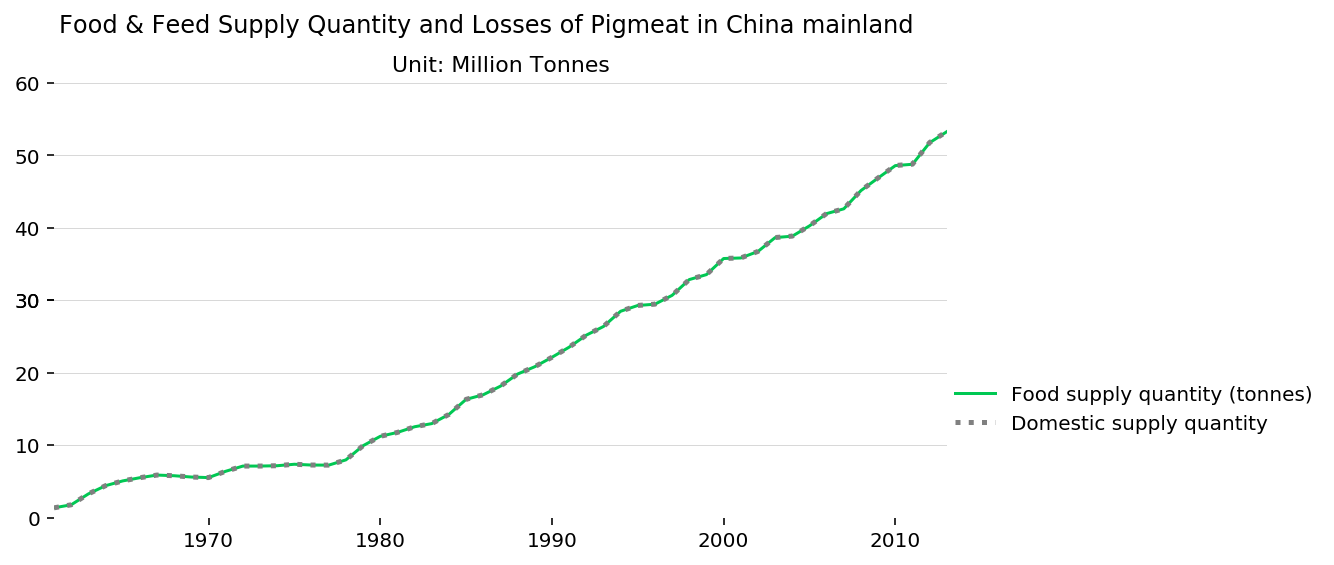

In [50]:
I = 'Pigmeat'

plotTrendsLine2(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Consumption'], 
    ax1_ylim=(30,60),
    ax2_ylim=(0,30),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

Food supply quantity (tonnes)  Domestic supply quantity
Year                                                         
2009                         6.2889                    6.2889
2010                         6.5161                    6.5161
2011                         6.4428                    6.4428
2012                         6.6062                    6.6062
2013                         7.0895                    7.0895

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_02_Food & Feed Supply Quantity and Losses of Bovine Meat in China mainland.png


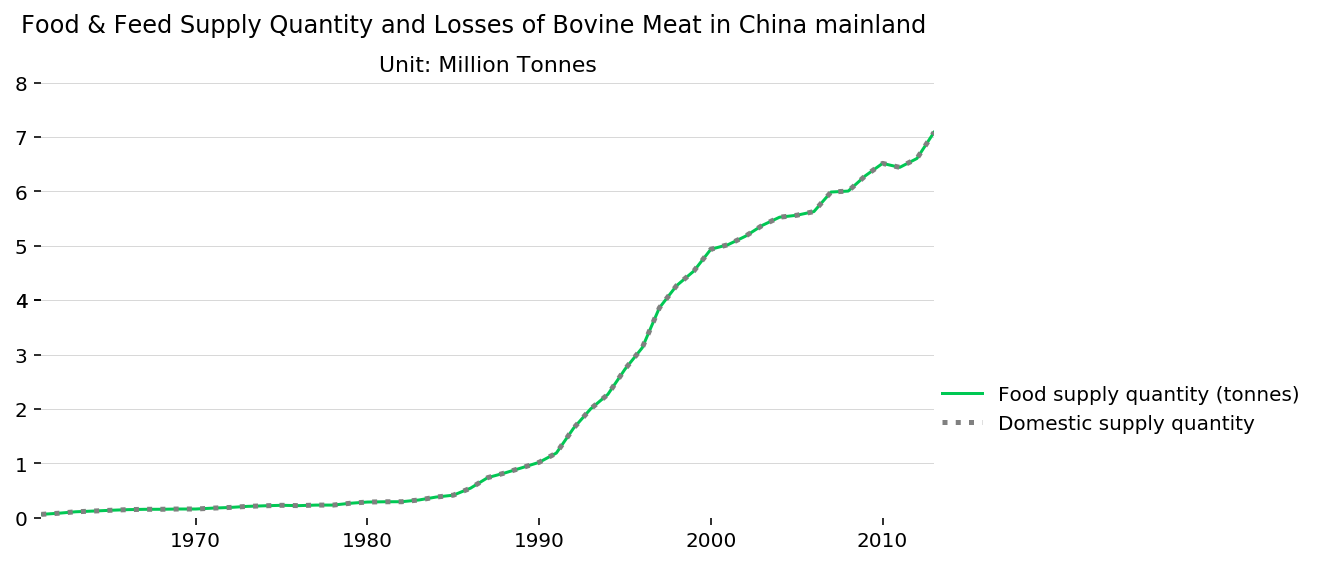

In [28]:
I = 'Bovine Meat'

plotTrendsLine2(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Consumption'], 
    ax1_ylim=(4,8),
    ax2_ylim=(0,4),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

Food supply quantity (tonnes)  Domestic supply quantity
Year                                                         
2009                         3.8954                    3.8954
2010                         4.0325                    4.0325
2011                         4.0060                    4.0060
2012                         4.1289                    4.1289
2013                         4.3365                    4.3365

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_02_Food & Feed Supply Quantity and Losses of Mutton & Goat Meat in China mainland.png


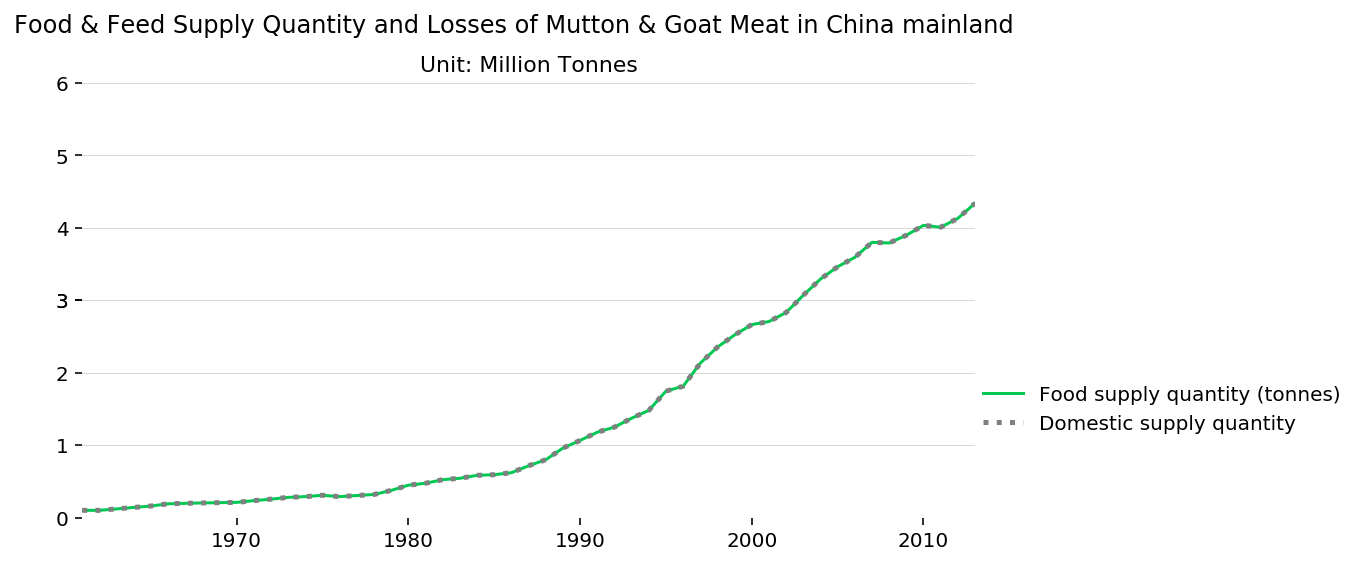

In [30]:
I = 'Mutton & Goat Meat'

plotTrendsLine2(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Consumption'], 
    ax1_ylim=(3,6),
    ax2_ylim=(0,3),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

Food supply quantity (tonnes)  Processing  Domestic supply quantity
Year                                                                     
2009                        16.3114      0.0015                   16.3129
2010                        16.6103      0.0015                   16.6118
2011                        16.9555      0.0015                   16.9570
2012                        17.9991      0.0015                   18.0006
2013                        18.2836      0.0015                   18.2851

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_02_Food & Feed Supply Quantity and Losses of Poultry Meat in China mainland.png


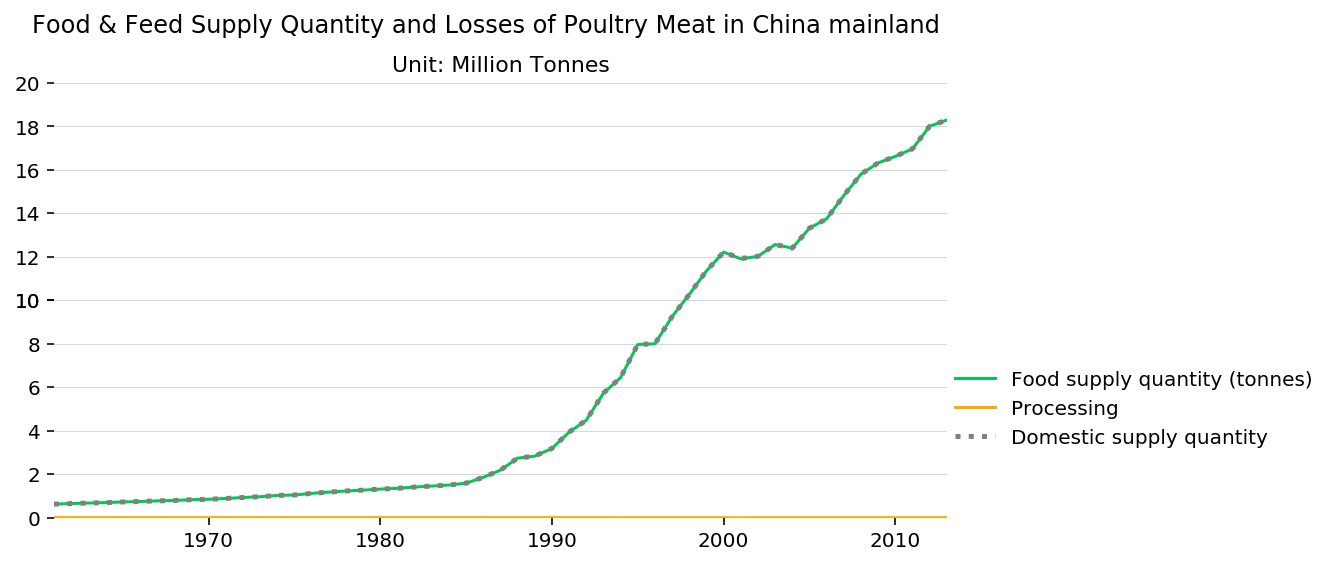

In [31]:
I = 'Poultry Meat'

plotTrendsLine2(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Consumption'], 
    ax1_ylim=(10,20),
    ax2_ylim=(0,10),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

Food supply quantity (tonnes)    Feed  Domestic supply quantity
Year                                                                 
2009                        42.1287  8.1079                   51.7366
2010                        43.7251  7.2764                   52.1515
2011                        44.9631  8.4331                   54.9963
2012                        47.7536  8.6343                   58.3879
2013                        47.7536  8.6343                   58.3879

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_02_Food & Feed Supply Quantity and Losses of Fish, Seafood in China mainland.png


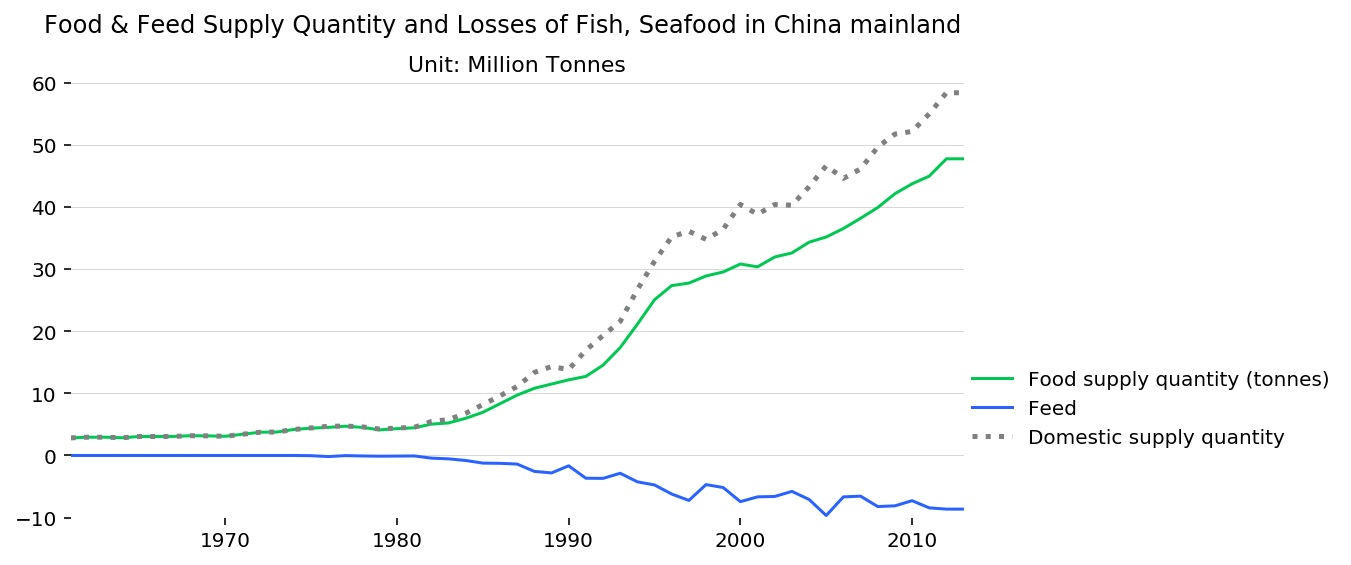

In [32]:
I = 'Fish, Seafood'

plotTrendsLine2(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Consumption'], 
    ax1_ylim=(25,60),
    ax2_ylim=(-10,25),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

Food supply quantity (tonnes)  Losses  Domestic supply quantity
Year                                                                 
2009                        24.7765  1.3713                   27.2794
2010                        24.9819  1.3814                   27.5172
2011                        25.4361  1.4057                   28.0063
2012                        25.8461  1.4306                   28.5038
2013                        25.9991  1.4380                   28.6623

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_02_Food & Feed Supply Quantity and Losses of Eggs in China mainland.png


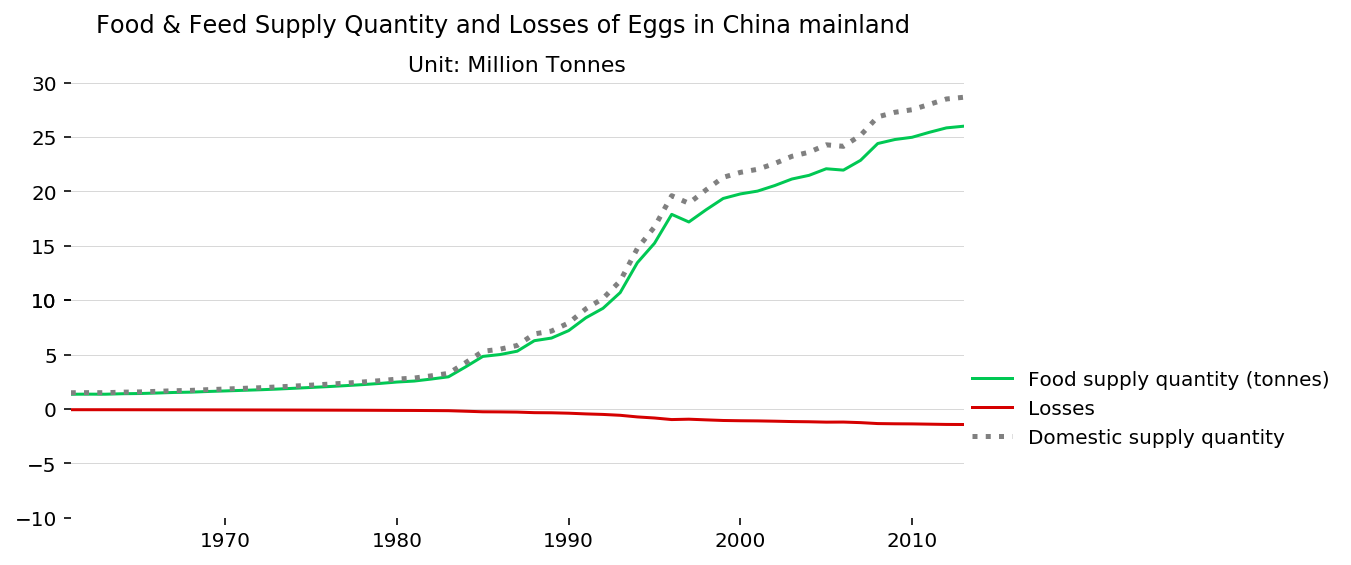

In [33]:
I = 'Eggs'

plotTrendsLine2(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Consumption'], 
    ax1_ylim=(10,30),
    ax2_ylim=(-10,10),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

Food supply quantity (tonnes)  Losses    Feed  Processing  \
Year                                                              
2009                        39.4427  1.4169  1.3326      0.0003   
2010                        41.5832  1.4410  1.2769      0.0003   
2011                        42.5228  1.4667  1.3397      0.0006   
2012                        44.7061  1.4911  1.6043      0.0004   
2013                        45.2522  1.4101  1.6083      0.0004   

      Domestic supply quantity  
Year                            
2009                   42.1925  
2010                   44.3014  
2011                   45.3299  
2012                   47.8019  
2013                   48.2711

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_02_Food & Feed Supply Quantity and Losses of Milk Excluding Butter in China mainland.png


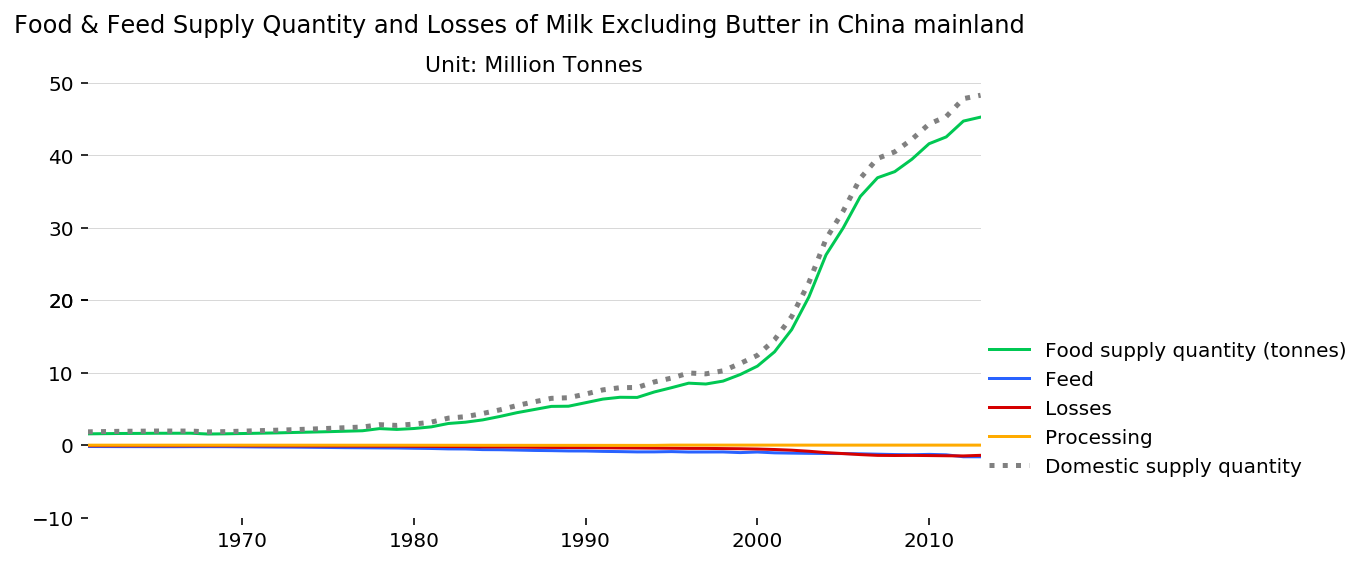

In [34]:
I = 'Milk - Excluding Butter'

plotTrendsLine2(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Consumption'], 
    ax1_ylim=(20,50),
    ax2_ylim=(-10,20),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

## Some Other Areas 

### Production, Import, Export in the World

In [65]:
A = 'Northern America'

In [37]:
for i in Is:
    PVs_YearArea[i] = mkPVs_forElements_YearArea(item=i, elements=Es['Domestic Supply, Production'])

    for e, pv in PVs_YearArea[i].items():
        display(i, e, pv.tail(2))

'Pigmeat'

'Production'

Africa  Albania  Algeria    Americas   Angola  Argentina  Armenia  \
Year                                                                         
2012  1184539.0  17000.0    120.0  1.9560e+07  84500.0   331000.0   9500.0   
2013  1253703.0  17300.0    120.0  1.9621e+07  93600.0   416000.0  12600.0   

            Asia  Australia  Australia & New Zealand   Austria  Azerbaijan  \
Year                                                                         
2012  6.2857e+07   348923.0                 398709.0  530262.0       741.0   
2013  6.4542e+07   360866.0                 408025.0  529284.0       743.0   

      Bahamas   Belarus    Belgium  Belize   Benin  \
Year                                                 
2012    334.0  442900.0  1109610.0  1409.0  5040.0   
2013    334.0  468900.0  1130572.0  1342.0  5096.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                           89606.0                 15695.0     500.0   
2013                           90599.0                 13013.0     510.0   

         Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
Year                                                                   
2012  3330000.0               44.0   73159.0       31920.0   98500.0   
2013  3280000.0               44.0   72905.0       32640.0   98500.0   

      Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                             
2012   28500.0  2004410.0   296861.0                   16350.0   
2013   29400.0  1980560.0   324329.0                   17000.0   

      Central America  Central Asia   Chad     Chile  China, Hong Kong SAR  \
Year                                                                         
2012        1421124.0      145361.0  605.0  583671.0              122800.0   
2013        1463911.0      145706.0  612.0  550033.0              123700.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012            8292.0                   877628.0       5.1300e+07  238505.0   
2013            8300.0                   887000.0       5.2733e+07  243133.0   

       Congo  Costa Rica   Croatia      Cuba   Cyprus   Czechia  \
Year                                                              
2012  1925.0     54315.0  126900.0  166320.0  51722.0  249869.0   
2013  2000.0     53694.0  106500.0  193314.0  48664.0  242833.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN         7215.0                               112500.0   
2013             NaN         7323.0                               112500.0   

        Denmark  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                
2012  1669000.0             78211.0        455378.0    5.4805e+07   
2013  1589400.0             79082.0        499900.0    5.6384e+07   

      Eastern Europe   Ecuador  Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                    
2012       6846560.0  205000.0  460.0       9487.0  38400.0    1875.0   
2013       6984177.0  218800.0  470.0       7978.0  37871.0    1875.0   

      Ethiopia PDR      Europe  European Union    Fiji   Finland     France  \
Year                                                                          
2012           NaN  2.7241e+07      2.2805e+07  4005.0  192940.0  2161653.0   
2013           NaN  2.7226e+07      2.2468e+07  4050.0  194600.0  2130600.0   

       Gabon  Gambia  Georgia    Germany    Ghana   Greece  Guatemala  Guinea  \
Year                                                                            
2012  3220.0   420.0  11800.0  5474021.0  

'Pigmeat'

'Import Quantity'

Africa  Albania  Algeria   Americas   Angola  Argentina  Armenia  \
Year                                                                       
2012  216398.0  17949.0     37.0  1753009.0  90700.0    37033.0  19021.0   
2013  244259.0  17263.0     63.0  1903460.0  97238.0    20839.0  18807.0   

           Asia  Australia  Australia & New Zealand   Austria  Azerbaijan  \
Year                                                                        
2012  3562433.0   250188.0                 301216.0  160241.0      1830.0   
2013  3559046.0   245864.0                 300268.0  199405.0      1626.0   

      Bahamas  Bangladesh   Belarus   Belgium  Belize   Benin  \
Year                                                            
2012  23903.0         0.0  137632.0  177313.0  4778.0  5135.0   
2013  19264.0         0.0   90576.0  173721.0  4238.0  3120.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                            3470.0                 26182.0     936.0   
2013                            4236.0                 27213.0    1052.0   

      Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
Year                                                                          
2012  1586.0             2815.0  127742.0          94.0     113.0    2656.0   
2013  1887.0             3450.0  126585.0          91.0     184.0    3400.0   

        Canada  Caribbean  Central African Republic  Central America  \
Year                                                                   
2012  266130.0   104903.0                     109.0         743551.0   
2013  243047.0   102034.0                      90.0         835160.0   

      Central Asia  Chad    Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                                        
2012       97926.0  63.0  24264.0              538925.0           32678.0   
2013       96418.0  64.0  47214.0              551875.0           32766.0   

      China, Taiwan Province of  China, mainland  Colombia   Congo  \
Year                                                                 
2012                    29170.0         714522.0   42444.0  3215.0   
2013                    36966.0         814674.0   71283.0  8632.0   

      Costa Rica  Croatia     Cuba  Cyprus   Czechia  Czechoslovakia  \
Year                                                                   
2012      5125.0  78400.0  29858.0  9828.0  302264.0             NaN   
2013      6856.0  90615.0  30013.0  9582.0  299061.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
Year                                                                   
2012        20224.0                                 2354.0  141154.0   
2013        28535.0                                 4572.0  159142.0   

      Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                               
2012     112.0             13515.0         18308.0     3246593.0   
2013     152.0             19915.0         16745.0     3212433.0   

      Eastern Europe  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                   
2012       2998484.0   8066.0  845.0      12491.0  34904.0      99.0   
2013       2782176.0   8422.0  906.0      15813.0  37137.0      99.0   

      Ethiopia PDR     Europe  European Union   Fiji  Finland    France  \
Year                                                                      
2012           NaN  8983040.0       7421674.0  245.0  43483.0  603322.0   
2013           NaN  8873483.0       7519800.0  200.0  39936.0  611393.0   

        Gabon  Gambia  Georgia    Germany    Ghana    Greece  Guatemala  \
Year                                                                      
2012   8699.0    75.0  22853.0  1218042.0

'Pigmeat'

'Export Quantity'

Africa  Albania  Algeria   Americas  Angola  Argentina  Armenia  \
Year                                                                     
2012   7483.0     39.0      0.0  4855003.0    46.0     1353.0    389.0   
2013  29951.0     56.0      0.0  4633197.0    46.0     1415.0    609.0   

          Asia  Australia  Australia & New Zealand   Austria  Azerbaijan  \
Year                                                                       
2012  457635.0    42430.0                  43371.0  282531.0         0.0   
2013  544540.0    43186.0                  44312.0  282179.0         5.0   

      Bahamas   Belarus   Belgium  Belize  Benin  \
Year                                               
2012      0.0  199393.0  840149.0     1.0    0.0   
2013      0.0  180953.0  875125.0     1.0    0.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                               0.0                  5014.0      31.0   
2013                               0.0                  4300.0      61.0   

        Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
Year                                                                            
2012  818827.0                0.0   12693.0           0.0       0.0       0.0   
2013  756830.0                4.0    9832.0           0.0       0.0       0.0   

         Canada  Caribbean  Central America  Central Asia  Chad     Chile  \
Year                                                                        
2012  1264252.0     2376.0         133349.0         337.0   0.0  179977.0   
2013  1262754.0     1951.0         156825.0         281.0   0.0  162390.0   

      China, Hong Kong SAR  China, Macao SAR  China, Taiwan Province of  \
Year                                                                      
2012              110428.0               0.0                     3808.0   
2013              175368.0               0.0                     3480.0   

      China, mainland  Colombia  Congo  Costa Rica  Croatia  Cuba  Cyprus  \
Year                                                                        
2012         262105.0      14.0    0.0      9566.0  12715.0   0.0  3245.0   
2013         279497.0      20.0    0.0      9806.0  13548.0   0.0  1559.0   

       Czechia  Czechoslovakia  Côte d'Ivoire  \
Year                                            
2012  101287.0             NaN           34.0   
2013  101271.0             NaN           31.0   

      Democratic People's Republic of Korea    Denmark  Dominican Republic  \
Year                                                                         
2012                                    0.0  1476980.0                16.0   
2013                                    0.0  1446941.0                16.0   

      Eastern Africa  Eastern Asia  Eastern Europe  Ecuador  Egypt  \
Year                                                                 
2012          2386.0      379905.0       1236629.0     25.0   39.0   
2013          2985.0      464433.0       1282353.0      2.0   45.0   

      El Salvador  Estonia  Ethiopia  Ethiopia PDR      Europe  \
Year                                                             
2012       4486.0  30383.0      12.0           NaN  1.0095e+07   
2013       3318.0  31838.0      12.0           NaN  1.0199e+07   

      European Union   Fiji  Finland    France  Gabon  Gambia  Georgia  \
Year                                                                     
2012       9777994.0  147.0  34633.0  614471.0    0.0     0.0    117.0   
2013       9912098.0  280.0  38421.0  617261.0    0.0    18.0    522.0   

        Germany  Ghana   Greece  Guatemala  Guyana  Honduras   Hungary  \
Year                                                                     
2012  2350557.0   58.0  10856.0    12233.0     0.0       6.0  183063.0   
2013  2407126.0    0.0   8410.0    12671.0    44.0      22.0  183139.0  

'Pigmeat'

'Domestic supply quantity'

Africa  Albania  Algeria    Americas    Angola  Argentina  Armenia  \
Year                                                                          
2012  1393454.0  34911.0    157.0  1.6457e+07  175154.0   366679.0  28132.0   
2013  1468011.0  34507.0    183.0  1.6892e+07  190791.0   435424.0  30799.0   

            Asia  Australia  Australia & New Zealand   Austria  Azerbaijan  \
Year                                                                         
2012  6.5961e+07   556682.0                 656554.0  407973.0      2571.0   
2013  6.7556e+07   563544.0                 663981.0  446509.0      2364.0   

      Bahamas  Bangladesh   Belarus   Belgium  Belize    Benin  \
Year                                                             
2012  23468.0         0.0  381139.0  446774.0  6186.0  10175.0   
2013  20367.0         0.0  378523.0  429167.0  5579.0   8216.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                           93076.0                 36863.0    1405.0   
2013                           94835.0                 35925.0    1501.0   

         Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
Year                                                                   
2012  2512759.0             2859.0  188209.0       32014.0   98613.0   
2013  2525057.0             3490.0  189658.0       32731.0   98684.0   

      Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                             
2012   31156.0  1006288.0   398869.0                   16459.0   
2013   32800.0   960853.0   425431.0                   17090.0   

      Central America  Central Asia   Chad     Chile  China, Hong Kong SAR  \
Year                                                                         
2012        2031326.0      242950.0  668.0  427958.0              551298.0   
2013        2142246.0      241843.0  676.0  434857.0              500207.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012           40970.0                   902990.0       5.1752e+07  280935.0   
2013           41066.0                   920486.0       5.3268e+07  314396.0   

        Congo  Costa Rica   Croatia      Cuba   Cyprus   Czechia  \
Year                                                               
2012   5140.0     49875.0  192585.0  196178.0  58305.0  450846.0   
2013  10632.0     50744.0  183567.0  223327.0  56686.0  440623.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN        27405.0                               114854.0   
2013             NaN        35826.0                               117072.0   

       Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                         
2012  332618.0     112.0             91711.0        471300.0    5.7671e+07   
2013  291167.0     152.0             98982.0        513660.0    5.9132e+07   

      Eastern Europe   Ecuador   Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                     
2012       8545243.0  213041.0  1266.0      17492.0  42921.0    1962.0   
2013       8548558.0  227220.0  1332.0      20473.0  43169.0    1962.0   

      Ethiopia PDR      Europe  European Union    Fiji   Finland     France  \
Year                                                                          
2012           NaN  2.6069e+07      2.0388e+07  4103.0  201790.0  2150504.0   
2013           NaN  2.5940e+07      2.0114e+07  3969.0  196115.0  2124732.0   

        Gabon  Gambia  Georgia    Germany    Ghana    Greece  Guatemala  \
Year                             

'Bovine Meat'

'Production'

Afghanistan     Africa  Albania   Algeria    Americas    Angola  \
Year                                                                    
2012     139000.0  5685985.0  69100.0  135674.0  3.0375e+07  102000.0   
2013     134000.0  5907237.0  69700.0  139948.0  3.0927e+07  105400.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012  2594336.0  47600.0  1.7215e+07  2128837.0                2731844.0   
2013  2822000.0  53600.0  1.7553e+07  2317766.0                2944940.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
Year                                                                          
2012  222156.0    118410.0     18.0    199380.0  293000.0  262280.0  1665.0   
2013  228903.0    120799.0     18.0    200470.0  315700.0  249973.0  1848.0   

        Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                      
2012  30800.0                          212595.0                 22900.0   
2013  31350.0                          215179.0                 16415.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012   37000.0  9307000.0             1236.0   20684.0      128357.0   
2013   49000.0  9675000.0             1296.0   19366.0       75842.0   

      Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                                       
2012   73200.0   87495.0  1059920.0   218370.0                   90000.0   
2013   73200.0   92163.0  1055720.0   222808.0                   55000.0   

      Central America  Central Asia     Chad     Chile  China, Hong Kong SAR  \
Year                                                                           
2012        2287818.0     1403681.0  98000.0  197571.0                7800.0   
2013        2264038.0     1470428.0  98400.0  206200.0                7900.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012             788.0                     6187.0        6623000.0  854232.0   
2013             800.0                     6400.0        6730000.0  848410.0   

       Congo  Costa Rica  Croatia     Cuba  Cyprus  Czechia  Czechoslovakia  \
Year                                                                          
2012  6552.0     87520.0  47100.0  67050.0  5313.0  66060.0             NaN   
2013  6552.0     85033.0  47400.0  66900.0  4562.0  65322.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
Year                                                                   
2012        31080.0                                21975.0  126700.0   
2013        31835.0                                21975.0  128000.0   

      Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                               
2012    6050.0             95861.0       1671578.0     7550104.0   
2013    6050.0            100654.0       1710865.0     7667496.0   

      Eastern Europe   Ecuador     Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                       
2012       2955207.0  265000.0  849512.0      26023.0  10700.0  338150.0   
2013       2987091.0  260500.0  824470.0      18412.0   8520.0  340750.0   

      Ethiopia PDR      Europe  European Union    Fiji  Finland     France  \
Year                                                                         
2012           NaN  1.0466e+07       7732887.0  7600.0  81180.0  1496865.0   
2013           NaN  1.0192e+07       7416771.0  7790.0  81190.0  1400400.0   

       Gabon  Gambia  Georgia    Germany    Ghana   Greec

'Bovine Meat'

'Import Quantity'

Afghanistan    Africa  Albania  Algeria   Americas   Angola  Argentina  \
Year                                                                           
2012      14438.0  449470.0   1758.0  86152.0  2111695.0  67870.0     1790.0   
2013       6087.0  508406.0   1685.0  79634.0  2267824.0  75314.0      187.0   

      Armenia       Asia  Australia  Australia & New Zealand  Austria  \
Year                                                                    
2012  10456.0  2893295.0    11024.0                  20788.0  44766.0   
2013   7037.0  3233616.0    10324.0                  25125.0  41909.0   

      Azerbaijan  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
Year                                                                     
2012      5516.0  21451.0        52.0   2924.0  84734.0   238.0  518.0   
2013      6759.0  18951.0        52.0   5144.0  83856.0   266.0  170.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                             985.0                 11939.0    1625.0   
2013                             322.0                 19197.0    2719.0   

       Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
Year                                                                           
2012  58531.0             3376.0    9065.0          97.0     122.0    1216.0   
2013  56477.0             3880.0   10557.0         103.0     279.0     694.0   

        Canada  Caribbean  Central African Republic  Central America  \
Year                                                                   
2012  316266.0    50521.0                       0.0         234172.0   
2013  320066.0    49531.0                       0.0         250597.0   

      Central Asia  Chad     Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                                         
2012       40935.0   3.0  165889.0              300968.0            5071.0   
2013       41684.0   3.0  218658.0              249512.0            5115.0   

      China, Taiwan Province of  China, mainland  Colombia    Congo  \
Year                                                                  
2012                   103156.0          85063.0    1873.0   7748.0   
2013                   116066.0         394137.0    2906.0  12788.0   

      Costa Rica  Croatia    Cuba  Cyprus  Czechia  Czechoslovakia  \
Year                                                                 
2012      6714.0  10393.0  3480.0  3312.0  32077.0             NaN   
2013      6624.0  11518.0  5139.0  2954.0  32942.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
Year                                                                   
2012         2833.0                                    0.0  133728.0   
2013         2743.0                                    0.0  135736.0   

      Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                               
2012    1206.0              2189.0         10446.0     1554550.0   
2013    2679.0              2189.0         11631.0     1847653.0   

      Eastern Europe  Ecuador     Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                      
2012        941945.0    951.0  218385.0      20238.0   7268.0      94.0   
2013        939715.0    878.0  232544.0      19350.0   4794.0      94.0   

      Ethiopia PDR     Europe  European Union    Fiji  Finland    France  \
Year                                                                       
2012           NaN  4071426.0       3176088.0  2271.0  23927.0  385544.0   
2013           NaN  3991879.0       3091956.0  1601.0  24563.0  379488.0   

        Gabon  Gambia  Georgia   Germany   Ghana    Greece  Guatemala  Guinea  \
Year                                                

'Bovine Meat'

'Export Quantity'

Africa  Albania  Algeria   Americas  Angola  Argentina  Armenia  \
Year                                                                      
2012   70015.0     34.0      0.0  4280079.0     0.0   213423.0    474.0   
2013  108649.0      1.0      0.0  4625838.0     0.0   233103.0    116.0   

           Asia  Australia  Australia & New Zealand   Austria  Azerbaijan  \
Year                                                                        
2012  1468891.0  1321447.0                1851936.0  119388.0      2633.0   
2013  1940031.0  1537728.0                2078385.0  125224.0      2241.0   

      Bahamas  Bangladesh   Belarus   Belgium  Belize  Benin  \
Year                                                           
2012      0.0         0.0  113205.0  172009.0     0.0    0.0   
2013      0.0         0.0  160224.0  160328.0     0.0    0.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                            2110.0                   748.0   21992.0   
2013                            4436.0                   690.0   35861.0   

         Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
Year                                                                   
2012  1554428.0                3.0    1611.0           1.0      26.0   
2013  1868135.0               96.0    2190.0           1.0       0.0   

      Cameroon    Canada  Caribbean  Central America  Central Asia  Chad  \
Year                                                                       
2012       0.0  313274.0     1807.0         335261.0        1040.0   0.0   
2013       0.0  311461.0     1935.0         276963.0        1561.0   0.0   

       Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                   
2012  4192.0               63862.0               0.0   
2013  4848.0               62526.0               0.0   

      China, Taiwan Province of  China, mainland  Colombia  Congo  Costa Rica  \
Year                                                                            
2012                      706.0         101888.0   11349.0  271.0     20028.0   
2013                      864.0          34658.0   43940.0    0.0     17463.0   

      Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  Côte d'Ivoire   Denmark  \
Year                                                                            
2012   3242.0   0.0   133.0  11464.0             NaN           34.0  106359.0   
2013   5387.0   0.0   158.0  11005.0             NaN           40.0  102535.0   

      Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                               
2012       0.0                13.0          4491.0      186565.0   
2013       0.0                13.0         10813.0      120139.0   

      Eastern Europe  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                   
2012        498529.0      0.0  520.0          5.0   3961.0     993.0   
2013        560110.0      0.0  295.0          8.0   3949.0     993.0   

      Ethiopia PDR     Europe  European Union    Fiji  Finland    France  \
Year                                                                       
2012           NaN  3266011.0       3117997.0   256.0    820.0  276390.0   
2013           NaN  3142168.0       2937398.0  1178.0   1465.0  248909.0   

      Gabon  Gambia  Georgia   Germany  Ghana  Greece  Guatemala  Guyana  \
Year                                                                       
2012    0.0    50.0    111.0  447255.0  114.0   803.0     6901.0     0.0   
2013    0.0   146.0     43.0  410450.0    2.0   777.0     3807.0     0.0   

      Haiti  Honduras  Hungary  Iceland      India  Indonesia  \
Year                                                            
2012    0.0   10060.0  17164.0     38.0  1038571.0     3511.0   


'Bovine Meat'

'Domestic supply quantity'

Afghanistan     Africa  Albania   Algeria    Americas    Angola  \
Year                                                                    
2012     153438.0  6065426.0  70824.0  221826.0  2.8212e+07  169870.0   
2013     140087.0  6307008.0  71383.0  219582.0  2.8578e+07  180714.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012  2382702.0  57582.0  1.8661e+07   818414.0                 900697.0   
2013  2589084.0  60521.0  1.8855e+07   790362.0                 891681.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
Year                                                                          
2012  147534.0    121294.0  21469.0    199432.0  182719.0  175005.0  1903.0   
2013  145587.0    125317.0  18969.0    200522.0  160621.0  173502.0  2114.0   

        Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                      
2012  31318.0                          211470.0                 34085.0   
2013  31520.0                          211064.0                 34929.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012   16633.0  7811103.0             4609.0   28138.0      128453.0   
2013   15858.0  7863343.0             5080.0   27733.0       75944.0   

      Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                                       
2012   73296.0   88711.0  1062911.0   267349.0                   90000.0   
2013   73479.0   92857.0  1064325.0   270404.0                   55000.0   

      Central America  Central Asia     Chad     Chile  China, Hong Kong SAR  \
Year                                                                           
2012        2192043.0     1459576.0  98003.0  359003.0              244906.0   
2013        2246302.0     1510551.0  98403.0  420275.0              194886.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012            5859.0                   108637.0        6606176.0  844756.0   
2013            5915.0                   121602.0        7089479.0  807375.0   

        Congo  Costa Rica  Croatia     Cuba  Cyprus  Czechia  Czechoslovakia  \
Year                                                                           
2012  14029.0     74206.0  54252.0  70530.0  8492.0  86673.0             NaN   
2013  19340.0     74194.0  53253.0  72039.0  7358.0  87259.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
Year                                                                   
2012        33879.0                                21975.0  154069.0   
2013        34539.0                                21975.0  161201.0   

      Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                               
2012    7256.0             98037.0       1677533.0     8918089.0   
2013    8729.0            102830.0       1711683.0     9395009.0   

      Eastern Europe   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                        
2012       3406594.0  265951.0  1067378.0      46256.0  14007.0  337251.0   
2013       3378102.0  261378.0  1056718.0      37754.0   9365.0  339851.0   

      Ethiopia PDR      Europe  European Union    Fiji   Finland     France  \
Year                                                                          
2012           NaN  1.1302e+07       7820883.0  9615.0  104287.0  1606019.0   
2013           NaN  1.1053e+07       7582582.0  8213.0  104289.0  1530979.0   

        Gabon  Gambia  Georgia    Germany    

'Mutton & Goat Meat'

'Production'

Afghanistan     Africa  Albania   Algeria  Americas   Angola  Argentina  \
Year                                                                            
2012     155200.0  2698079.0  48000.0  278698.0  544672.0  21855.0    68664.0   
2013     150200.0  2768266.0  48500.0  298463.0  550193.0  22725.0    66227.0   

      Armenia       Asia  Australia  Australia & New Zealand  Austria  \
Year                                                                    
2012   8500.0  7633297.0   586184.0                1035411.0   7360.0   
2013   9000.0  7839131.0   696937.0                1178796.0   7938.0   

      Azerbaijan  Bahamas  Bangladesh  Belarus  Belgium  Belize   Benin  \
Year                                                                      
2012     70366.0    100.0    204130.0   1000.0   2163.0    36.0  8500.0   
2013     70929.0    100.0    208200.0   1100.0   2406.0    44.0  8600.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                           18704.0                  2270.0    7396.0   
2013                           18309.0                  1468.0    7410.0   

        Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cameroon   Canada  \
Year                                                                           
2012  114500.0               62.0   17025.0       54823.0   27016.0  16100.0   
2013  115800.0               69.0   12817.0       41073.0   31200.0  17310.0   

      Caribbean  Central African Republic  Central America  Central Asia  \
Year                                                                       
2012    24876.0                   23592.0         103116.0      499591.0   
2013    24198.0                   23740.0         101659.0      518799.0   

         Chad    Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                             
2012  42242.0  14832.0                 113.0               0.0   
2013  43020.0  13483.0                 118.0               0.0   

      China, Taiwan Province of  China, mainland  Colombia   Congo  \
Year                                                                 
2012                     2294.0        4010000.0   10544.0  1515.0   
2013                     2300.0        4081000.0   10312.0  1545.0   

      Costa Rica  Croatia     Cuba  Cyprus  Czechia  Czechoslovakia  \
Year                                                                  
2012        35.0   5609.0  14700.0  5732.0   3007.0             NaN   
2013        35.0   5800.0  13800.0  5294.0   3340.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
Year                                                                            
2012        12620.0                                15705.0   1348.0    4664.0   
2013        12770.0                                15705.0   1535.0    4664.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                     
2012              1809.0        459616.0     4153442.0        312905.0   
2013              1899.0        476530.0     4257352.0        307679.0   

      Ecuador     Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
Year                                                                    
2012   6700.0  129028.0        125.0    573.0  157500.0           NaN   
2013   6935.0  127734.0        128.0    514.0  161450.0           NaN   

         Europe  European Union   Fiji  Finland    France   Gabon  Gambia  \
Year                                                                        
2012  1309509.0        980580.0  420.0    950.0  126070.0  1250.0  1375.0   
2013  1302866.0        967159.0  632.0    980.0  123274.0  1290.0  1298.0   

      Georgia  Germany    Ghana    Greece  Guatemala   Guinea  Guinea-Bissau  \
Year                 

'Mutton & Goat Meat'

'Import Quantity'

Africa  Albania  Algeria  Americas  Angola  Argentina  Armenia  \
Year                                                                    
2012  25542.0    221.0   3055.0  121214.0   375.0       21.0      0.0   
2013  33126.0    118.0   2857.0  135702.0   376.0        0.0      0.0   

          Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
Year                                                                      
2012  371009.0      988.0                   3371.0   2320.0        40.0   
2013  509677.0     1099.0                   4069.0   2086.0        65.0   

      Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
Year                                                         
2012   2464.0        10.0     19.0  21639.0     1.0   35.0   
2013   1919.0        10.0     27.0  23620.0     2.0   17.0   

      Bosnia and Herzegovina  Botswana  Brazil  Brunei Darussalam  Bulgaria  \
Year                                                                          
2012                   201.0     178.0  6276.0              990.0     544.0   
2013                   315.0     190.0  8857.0              889.0     405.0   

      Burkina Faso  Cambodia  Cameroon   Canada  Caribbean  \
Year                                                         
2012          19.0      13.0       6.0  17215.0    10414.0   
2013           0.0      22.0      18.0  19186.0    10016.0   

      Central African Republic  Central America  Central Asia  Chad  Chile  \
Year                                                                         
2012                       0.0           8413.0         636.0   0.0    0.0   
2013                       0.0          11845.0         759.0   0.0    0.0   

      China, Hong Kong SAR  China, Macao SAR  China, Taiwan Province of  \
Year                                                                      
2012               15786.0             392.0                    18889.0   
2013               18000.0             410.0                    19070.0   

      China, mainland  Colombia  Congo  Costa Rica  Croatia   Cuba  Cyprus  \
Year                                                                         
2012         123939.0      24.0  171.0        45.0   1341.0   21.0  1219.0   
2013         258723.0      15.0  243.0        39.0   1516.0  132.0   986.0   

      Czechia  Czechoslovakia  Côte d'Ivoire  Denmark  Djibouti  \
Year                                                              
2012    350.0             NaN         1105.0   3926.0       3.0   
2013    377.0             NaN         1087.0   4424.0       1.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                     
2012               371.0          4780.0      181403.0         13189.0   
2013               371.0          5470.0      319846.0         12951.0   

      Ecuador   Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR    Europe  \
Year                                                                            
2012     12.0  2204.0          5.0    128.0       3.0           NaN  362315.0   
2013     14.0  1896.0          6.0    150.0       3.0           NaN  381526.0   

      European Union    Fiji  Finland    France  Gabon  Gambia  Georgia  \
Year                                                                      
2012        344462.0  4743.0   2199.0  106805.0  844.0    20.0      1.0   
2013        362323.0  4668.0   1952.0  103465.0  832.0    17.0      1.0   

      Germany   Ghana  Greece  Guatemala  Guinea  Guyana  Haiti  Honduras  \
Year                                                                        
2012  31692.0  5485.0  5513.0       19.0    20.0     6.0   43.0      30.0   
2013  33916.0  3947.0  6549.0       25.0    20.0     3.0   43.0      60.0   

      Hungary  India  Indonesia  Iran (Islamic Republic of)    Iraq  Ireland  \
Year                                                                           
2012    12

'Mutton & Goat Meat'

'Export Quantity'

Africa  Albania  Algeria  Americas  Angola  Argentina     Asia  \
Year                                                                    
2012  30675.0      0.0      0.0   27940.0     0.0     3068.0  43977.0   
2013  33912.0      0.0      0.0   31199.0     0.0     1639.0  42333.0   

      Australia  Australia & New Zealand  Austria  Bangladesh  Belarus  \
Year                                                                     
2012   343255.0                 692823.0    144.0         0.0      0.0   
2013   449705.0                 848256.0    147.0         0.0      0.0   

      Belgium  Bosnia and Herzegovina  Botswana  Brazil  Brunei Darussalam  \
Year                                                                         
2012  10257.0                     0.0       0.0     7.0                0.0   
2013  11418.0                     0.0       0.0     0.0                0.0   

      Bulgaria  Burkina Faso  Cameroon  Canada  Caribbean  Central America  \
Year                                                                         
2012    1641.0           0.0       0.0   188.0       11.0             68.0   
2013    1450.0           0.0       0.0   506.0        4.0             67.0   

      Central Asia  Chad   Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                                       
2012           7.0   0.0  4904.0                1130.0               0.0   
2013          23.0   0.0  6047.0                1140.0               0.0   

      China, Taiwan Province of  China, mainland  Colombia  Costa Rica  \
Year                                                                     
2012                        0.0           5044.0      23.0         0.0   
2013                        0.0           3215.0      50.0         0.0   

      Croatia  Cyprus  Czechia  Czechoslovakia  Côte d'Ivoire  Denmark  \
Year                                                                     
2012      0.0     0.0     27.0             NaN            8.0   1050.0   
2013      0.0     0.0     51.0             NaN            7.0    798.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  Egypt  \
Year                                                                            
2012                 0.0         14524.0        6174.0          5903.0   13.0   
2013                 0.0         15399.0        4373.0          5795.0    5.0   

      El Salvador  Estonia  Ethiopia  Ethiopia PDR    Europe  European Union  \
Year                                                                           
2012          0.0    137.0   13660.0           NaN  237721.0        230769.0   
2013          0.0     99.0   13660.0           NaN  253241.0        246570.0   

       Fiji  Finland   France  Georgia  Germany  Ghana  Greece  Guatemala  \
Year                                                                        
2012    2.0     44.0  10337.0    231.0   6671.0    7.0  2037.0        0.0   
2013  102.0     39.0   9454.0     93.0   7331.0    2.0  3239.0        0.0   

      Guyana  Haiti  Honduras  Hungary  Iceland    India  Indonesia  \
Year                                                                  
2012     0.0    0.0       0.0     36.0   2761.0  11997.0        0.0   
2013     0.0    0.0       0.0    140.0   2924.0  21431.0        0.0   

      Iran (Islamic Republic of)  Ireland   Italy  Japan  Jordan  Kazakhstan  \
Year                                                                           
2012                         0.0  43498.0  2124.0    0.0  3658.0         0.0   
2013                         0.0  42595.0  2140.0    0.0  1335.0        16.0   

       Kenya  Kuwait  Kyrgyzstan  Land Locked Developing Countries  Latvia  \
Year                                                                         
2012   838.0     0.0         7.0                           17760.0    32.0   
2013  1590.0   426.0         7.0                           17217.0    49.0   

      Least Develo

'Mutton & Goat Meat'

'Domestic supply quantity'

Afghanistan     Africa  Albania   Algeria  Americas   Angola  Argentina  \
Year                                                                            
2012     155200.0  2692946.0  48221.0  281753.0  637946.0  22230.0    65617.0   
2013     150200.0  2767480.0  48618.0  301320.0  654696.0  23101.0    64588.0   

      Armenia       Asia  Australia  Australia & New Zealand  Austria  \
Year                                                                    
2012   8500.0  7960329.0   243917.0                 345959.0   9536.0   
2013   9000.0  8306475.0   248331.0                 334609.0   9877.0   

      Azerbaijan  Bahamas  Bangladesh  Belarus  Belgium  Belize   Benin  \
Year                                                                      
2012     70406.0   2564.0    204140.0   1019.0  13545.0    37.0  8535.0   
2013     70994.0   2019.0    208210.0   1127.0  14608.0    46.0  8617.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                           18704.0                  2471.0    7574.0   
2013                           18309.0                  1783.0    7600.0   

        Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
Year                                                                            
2012  120769.0             1052.0   15928.0       54842.0      13.0   27022.0   
2013  124657.0              958.0   11772.0       41073.0      22.0   31218.0   

       Canada  Caribbean  Central African Republic  Central America  \
Year                                                                  
2012  33127.0    35279.0                   23592.0         111461.0   
2013  35990.0    34210.0                   23740.0         113437.0   

      Central Asia     Chad   Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                                          
2012      500220.0  42242.0  9928.0               14769.0             392.0   
2013      519535.0  43020.0  7436.0               16978.0             410.0   

      China, Taiwan Province of  China, mainland  Colombia   Congo  \
Year                                                                 
2012                    21183.0        4128895.0   10545.0  1686.0   
2013                    21370.0        4336508.0   10277.0  1788.0   

      Costa Rica  Croatia     Cuba  Cyprus  Czechia  Czechoslovakia  \
Year                                                                  
2012        80.0   6950.0  14721.0  6951.0   3330.0             NaN   
2013        74.0   7316.0  13932.0  6280.0   3666.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
Year                                                                            
2012        13717.0                                15705.0   4224.0    4667.0   
2013        13850.0                                15705.0   5161.0    4665.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                     
2012              2180.0        449872.0     4328671.0        320191.0   
2013              2270.0        466601.0     4572825.0        314835.0   

      Ecuador     Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
Year                                                                    
2012   6712.0  131219.0        130.0    564.0  143843.0           NaN   
2013   6949.0  129625.0        134.0    565.0  147793.0           NaN   

         Europe  European Union    Fiji  Finland    France   Gabon  Gambia  \
Year                                                                         
2012  1434103.0       1094273.0  5161.0   3105.0  222538.0  2094.0  1395.0   
2013  1431151.0       1082912.0  5198.0   2893.0  217285.0  2122.0  1315.0   

      Georgia  Germany    Ghana    Greece  Guatemala   Guinea

'Poultry Meat'

'Production'

Afghanistan     Africa  Albania   Algeria    Americas   Angola  \
Year                                                                   
2012      24800.0  4910503.0  16000.0  288825.0  4.3967e+07  25650.0   
2013      26400.0  5292772.0  17000.0  287525.0  4.5399e+07  29880.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012  1948548.0   8300.0  3.7493e+07  1075799.0                1247744.0   
2013  1966548.0   8200.0  3.8375e+07  1097682.0                1267327.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium   Belize  \
Year                                                                           
2012  134020.0     86518.0   6600.0    217200.0  353300.0  410863.0  14552.0   
2013  130820.0     94411.0   6720.0    219600.0  384500.0  389288.0  16263.0   

        Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                      
2012  21200.0                          362630.0                 53399.0   
2013  17600.0                          367850.0                 41549.0   

      Botswana      Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                    
2012    5040.0  1.2053e+07            24184.0  107601.0       38800.0   
2013    5200.0  1.2915e+07            24207.0   98364.0       38160.0   

      Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                                       
2012   28150.0   70400.0  1233104.0   487743.0                    6000.0   
2013   26650.0   72000.0  1254211.0   506930.0                    6000.0   

      Central America  Central Asia    Chad     Chile  China, Hong Kong SAR  \
Year                                                                          
2012        3641944.0      186647.0  5334.0  669348.0               28224.0   
2013        3703297.0      196296.0  5355.0  675597.0               28240.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland   Colombia  \
Year                                                                            
2012            3600.0                   631985.0       1.8033e+07  1112246.0   
2013            3600.0                   641650.0       1.8265e+07  1275515.0   

       Congo  Costa Rica  Croatia     Cuba   Cyprus   Czechia  Czechoslovakia  \
Year                                                                            
2012  6600.0    108030.0  33500.0  35022.0  25297.0  157017.0             NaN   
2013  6700.0    114594.0  29274.0  32448.0  21972.0  152692.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
Year                                                                   
2012        41987.0                                43800.0  191554.0   
2013        47553.0                                43800.0  172003.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                     
2012            251389.0        528295.0    2.0894e+07       7424967.0   
2013            271609.0        522128.0    2.1132e+07       7766662.0   

       Ecuador      Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
Year                                                                      
2012  332224.0   923297.0     109545.0  16530.0   60480.0           NaN   
2013  342481.0  1059827.0     113850.0  18118.0   61840.0           NaN   

          Europe  European Union     Fiji   Finland     France   Gabon  \
Year                                                                     
2012  1.7858e+07      1.2770e+07  26278.0  107410.0  1765867.0  3840.0   
2013  1.8162e+07      1.2780e+07  17598.0  111090.0  1702384.0  3920.0   

      Gambia  Georgia    Germany    Ghana

'Poultry Meat'

'Import Quantity'

Afghanistan     Africa  Albania  Algeria   Americas    Angola  \
Year                                                                  
2012      21750.0  1456686.0  24337.0   2771.0  1988727.0  323673.0   
2013      48389.0  1487178.0  24986.0   3420.0  2233509.0  342214.0   

      Argentina  Armenia       Asia  Australia  Australia & New Zealand  \
Year                                                                      
2012     5319.0  33040.0  6118141.0    14360.0                  15361.0   
2013     3732.0  31619.0  6337883.0    17155.0                  18000.0   

       Austria  Azerbaijan  Bahamas  Bangladesh  Belarus   Belgium  Belize  \
Year                                                                         
2012  107795.0     12945.0  19171.0        39.0  23848.0  255743.0   131.0   
2013  104725.0      4599.0  18858.0        39.0  15625.0  251923.0   147.0   

         Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                       
2012  180095.0                             509.0                 16697.0   
2013  185204.0                             625.0                 14418.0   

      Botswana  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
Year                                                                          
2012    4175.0  2229.0             1986.0  108524.0         440.0     531.0   
2013    5578.0  3377.0             2101.0   86078.0          82.0    1167.0   

      Cameroon    Canada  Caribbean  Central African Republic  \
Year                                                            
2012     361.0  223664.0   389233.0                     932.0   
2013    1251.0  226145.0   417466.0                     711.0   

      Central America  Central Asia  Chad    Chile  China, Hong Kong SAR  \
Year                                                                       
2012         913395.0      296964.0  65.0  76779.0             1028331.0   
2013         999717.0      263750.0  65.0  80791.0             1185857.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012           17163.0                   130758.0         521850.0   57612.0   
2013           17244.0                   115576.0         584195.0   57594.0   

        Congo  Costa Rica  Croatia      Cuba   Cyprus   Czechia  \
Year                                                              
2012  35810.0      5645.0  16725.0  177365.0  11422.0  109174.0   
2013  51194.0      7578.0  17678.0  194617.0  12975.0  101458.0   

      Czechoslovakia  Côte d'Ivoire   Denmark  Djibouti  Dominican Republic  \
Year                                                                          
2012             NaN         1201.0   73326.0    4603.0             14500.0   
2013             NaN         1202.0  100988.0    1794.0             24000.0   

      Eastern Africa  Eastern Asia  Eastern Europe  Ecuador     Egypt  \
Year                                                                    
2012         48544.0     2921005.0       1162440.0   1428.0  111248.0   
2013         24341.0     3098461.0       1081530.0   1393.0  125287.0   

      El Salvador  Estonia  Ethiopia  Ethiopia PDR     Europe  European Union  \
Year                                                                            
2012      14948.0  19493.0      28.0           NaN  5135847.0       4289605.0   
2013      16510.0  19990.0      28.0           NaN  4990952.0       4209164.0   

        Fiji  Finland    France    Gabon  Gambia  Georgia   Germany     Ghana  \
Year                                                                            
2012  2328.0  15014.0  424245.0  66173.0  5573.0  44409.0  822972.0  158082.0   
2013  1070.0  15886.0  422997.0  69748.0  3639.0  43297.0  788275.0  172685.0   

       Greece  Guatemala   Guinea  Guinea-Bissau  Guyana    Haiti  Ho

'Poultry Meat'

'Export Quantity'

Africa  Albania  Algeria   Americas  Angola  Argentina  Armenia  \
Year                                                                     
2012  20358.0      2.0    240.0  8700278.0     0.0   333780.0     19.0   
2013  62065.0      0.0    320.0  8719809.0     0.0   368019.0     70.0   

           Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
Year                                                                       
2012  2283999.0    39617.0                  49271.0  68031.0         0.0   
2013  2535786.0    38154.0                  51013.0  66972.0         0.0   

      Bahamas   Belarus   Belgium  Belize  Benin  \
Year                                               
2012      0.0  106258.0  521726.0     0.0   25.0   
2013      0.0  106640.0  498241.0    10.0    0.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                            1777.0                  7724.0       3.0   
2013                            2305.0                  5333.0       2.0   

         Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
Year                                                                   
2012  3942267.0                1.0   43411.0          43.0      20.0   
2013  3902419.0               27.0   33814.0           0.0       0.0   

      Cameroon    Canada  Caribbean  Central America  Central Asia  Chad  \
Year                                                                       
2012       0.0  177636.0    11002.0          27291.0        2832.0   0.0   
2013       0.0  189860.0    10562.0          30577.0        2679.0   0.0   

         Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                     
2012  119063.0              635123.0               0.0   
2013  112912.0              805527.0               0.0   

      China, Taiwan Province of  China, mainland  Colombia  Congo  Costa Rica  \
Year                                                                            
2012                     3581.0         553811.0     903.0    0.0      2866.0   
2013                     7450.0         563993.0    1078.0    3.0      2959.0   

      Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  Côte d'Ivoire   Denmark  \
Year                                                                            
2012  11154.0   0.0  1177.0  49273.0             NaN           32.0  140759.0   
2013  10150.0   0.0   916.0  49817.0             NaN           27.0  121994.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                     
2012              9226.0           259.0     1228311.0       1179798.0   
2013              8917.0           748.0     1418797.0       1315863.0   

      Ecuador   Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
Year                                                                  
2012    157.0  1472.0       4536.0  10083.0       1.0           NaN   
2013     50.0   646.0       4591.0  10935.0       1.0           NaN   

         Europe  European Union   Fiji  Finland    France  Gabon  Gambia  \
Year                                                                       
2012  5253328.0       5041275.0   45.0  12547.0  580761.0    0.0     0.0   
2013  5322441.0       5027234.0  102.0  12838.0  579399.0    0.0    20.0   

      Georgia   Germany  Ghana   Greece  Guatemala  Guinea  Guyana  Honduras  \
Year                                                                           
2012    355.0  710908.0    8.0  20363.0     7481.0    52.0     1.0     297.0   
2013    103.0  676184.0   41.0  19427.0     7766.0    52.0     1.0    3370.0   

       Hungary  Iceland   India  Indonesia  Iran (Islamic Republic of)  \
Year                                                                     
2012  194268.0      0.0  5672.0       12.0                

'Poultry Meat'

'Domestic supply quantity'

Afghanistan     Africa  Albania   Algeria    Americas    Angola  \
Year                                                                    
2012      46550.0  6341239.0  40335.0  291356.0  3.7255e+07  349323.0   
2013      74789.0  6719542.0  41986.0  290625.0  3.8912e+07  372094.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012  1620088.0  41321.0  4.1366e+07  1050543.0                1213834.0   
2013  1602261.0  39748.0  4.2225e+07  1076683.0                1234314.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium   Belize  \
Year                                                                           
2012  173784.0     99463.0  24628.0    217239.0  270890.0  144880.0  14683.0   
2013  168573.0     99010.0  24292.0    219639.0  293485.0  142970.0  16400.0   

         Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                       
2012  201270.0                          361362.0                 62372.0   
2013  202804.0                          366170.0                 50635.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012    9212.0  8112862.0            26169.0  172715.0       39197.0   
2013   10776.0  9016208.0            26281.0  150628.0       38242.0   

      Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                                       
2012   28661.0   70761.0  1279131.0   864871.0                    6932.0   
2013   27817.0   73251.0  1290495.0   912588.0                    6711.0   

      Central America  Central Asia    Chad     Chile  China, Hong Kong SAR  \
Year                                                                          
2012        4528049.0      480778.0  5399.0  627064.0              461432.0   
2013        4672437.0      457367.0  5420.0  643476.0              448570.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland   Colombia  \
Year                                                                            
2012           20763.0                   759162.0       1.8001e+07  1168954.0   
2013           20844.0                   749777.0       1.8285e+07  1332031.0   

        Congo  Costa Rica  Croatia      Cuba   Cyprus   Czechia  \
Year                                                              
2012  42410.0    110808.0  39071.0  212387.0  35542.0  216918.0   
2013  57891.0    119213.0  36802.0  227065.0  34031.0  204333.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN        43155.0                                43800.0   
2013             NaN        48728.0                                43800.0   

       Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                         
2012  124120.0    4603.0            256663.0        576580.0    2.2626e+07   
2013  150997.0    1794.0            286692.0        545720.0    2.2851e+07   

      Eastern Europe   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                        
2012       7392609.0  333495.0  1033074.0     119957.0  25940.0   60507.0   
2013       7522328.0  343824.0  1184467.0     125769.0  27173.0   61867.0   

      Ethiopia PDR      Europe  European Union     Fiji   Finland     France  \
Year                                                                           
2012           NaN  1.7726e+07      1.2003e+07  28561.0  109877.0  1609351.0   
2013           NaN  1.7820e+07      1.1952e+07  18566.0  114138.0  1545982.0   

        Gabon  Gambia

'Fish, Seafood'

'Production'

Afghanistan     Africa  Albania   Algeria    Americas    Angola  \
Year                                                                    
2012       2050.0  8885661.0   6953.0  108206.0  2.4620e+07  273410.0   
2013       2050.0  8753936.0   7459.0  108206.0  2.4065e+07  273410.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012   741000.0   9711.0  1.0524e+08   233293.0                 773216.0   
2013   873895.0  16390.0  1.0515e+08   228931.0                 767588.0   

      Austria  Azerbaijan  Bahamas  Bangladesh  Belarus  Belgium    Belize  \
Year                                                                         
2012   3426.0      1578.0  16472.0   3124677.0  16464.0  24936.0  155682.0   
2013   3587.0      1578.0  12765.0   3124677.0  14245.0  25835.0  155682.0   

        Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                      
2012  40864.0                            7880.0                  3943.0   
2013  43083.0                            8247.0                  3228.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012     378.0  1549444.0             5073.0   15556.0       20502.0   
2013     431.0  1549444.0             4830.0   21822.0       20502.0   

      Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                                       
2012  640625.0  137498.0   982082.0   177430.0                   32140.0   
2013  729398.0  154295.0  1014910.0   207633.0                   30140.0   

      Central America  Central Asia     Chad      Chile  China, Hong Kong SAR  \
Year                                                                            
2012        2263219.0       70778.0  60000.0  3613744.0              159323.0   
2013        2264513.0       70982.0  60000.0  2772575.0              159323.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012            1500.0                  1250311.0       5.6229e+07  167654.0   
2013            1500.0                  1250311.0       5.6229e+07  167654.0   

        Congo  Costa Rica  Croatia     Cuba  Cyprus  Czechia  Czechoslovakia  \
Year                                                                           
2012  81152.0     53880.0  74433.0  48429.0  5928.0  24796.0             NaN   
2013  73236.0     55174.0  87683.0  51604.0  5928.0  23118.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
Year                                                                   
2012        79331.0                               268850.0  536339.0   
2013        79331.0                               268850.0  698665.0   

      Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                               
2012    2167.0             16153.0       1670263.0    6.4298e+07   
2013    1702.0             16153.0       1671571.0    6.4120e+07   

      Eastern Europe   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                        
2012       4974818.0  815330.0  1371960.0      57322.0  95971.0   24066.0   
2013       5067363.0  815330.0  1454401.0      57322.0  95971.0   24066.0   

      Ethiopia PDR      Europe  European Union     Fiji   Finland    France  \
Year                                                                          
2012           NaN  1.5627e+07       6099388.0  41207.0  164944.0  661585.0   
2013           NaN  1.5884e+07       6429009.0  41207.0  164944.0  695000.0   

        Gabon   Gambia  Georgia   Germany    

'Fish, Seafood'

'Import Quantity'

Afghanistan     Africa  Albania  Algeria   Americas    Angola  \
Year                                                                  
2012          0.0  5373069.0  15879.0  47179.0  8671176.0  116162.0   
2013          0.0  5447406.0  17275.0  47179.0  8703434.0  116162.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012    69921.0  13009.0  2.4029e+07   654519.0                 715113.0   
2013    68507.0  12305.0  2.3590e+07   607867.0                 662854.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
Year                                                                          
2012  165988.0     18829.0   8125.0     44890.0  242648.0  548682.0   607.0   
2013  168607.0     18829.0   7275.0     44890.0  267146.0  536888.0   607.0   

         Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                       
2012   94033.0                           15046.0                 18590.0   
2013  103281.0                           15131.0                 17555.0   

      Botswana    Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
Year                                                                            
2012    9895.0  765421.0            15281.0   53612.0       99123.0    4940.0   
2013    8191.0  765421.0            17679.0   54736.0       99123.0    2610.0   

      Cameroon    Canada  Caribbean  Central African Republic  \
Year                                                            
2012  237500.0  895904.0   248407.0                    6346.0   
2013  222508.0  866213.0   243500.0                    5715.0   

      Central America  Central Asia   Chad     Chile  China, Hong Kong SAR  \
Year                                                                         
2012         543629.0      126064.0  842.0  398161.0              624146.0   
2013         544138.0      135336.0  842.0  394469.0              624146.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012           29682.0                  1249272.0        9329840.0  287946.0   
2013           29682.0                  1249272.0        9329840.0  287946.0   

        Congo  Costa Rica  Croatia     Cuba   Cyprus   Czechia  \
Year                                                             
2012  28790.0     52164.0  47778.0  21518.0  68398.0  118718.0   
2013  44694.0     52672.0  42539.0  18974.0  68398.0  122805.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN       304745.0                                34772.0   
2013             NaN       304745.0                                34772.0   

        Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                          
2012  1623528.0    1006.0             87563.0        359399.0    1.7827e+07   
2013  1479972.0    1597.0             87563.0        380421.0    1.7272e+07   

      Eastern Europe   Ecuador     Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                       
2012       3472324.0  218449.0  500304.0      22788.0  49252.0    1076.0   
2013       3694602.0  218449.0  415931.0      22788.0  49252.0    1076.0   

      Ethiopia PDR      Europe  European Union     Fiji   Finland     France  \
Year                                                                           
2012           NaN  2.2289e+07      1.8205e+07  83949.0  151650.0  2026642.0   
2013           NaN  2.1790e+07      1.7776e+07  83949.0  151650.0  2013299.0   

        Gabon  Gambia  Georgia    Germany     Ghana  

'Fish, Seafood'

'Export Quantity'

Africa  Albania  Algeria    Americas  Angola  Argentina  Armenia  \
Year                                                                        
2012  2428803.0   6902.0   1647.0  1.4893e+07  8101.0   562022.0   4309.0   
2013  2342769.0   8905.0   1647.0  1.4747e+07  8101.0   642156.0   7245.0   

            Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
Year                                                                        
2012  1.9147e+07    51371.0                 501715.0  27017.0       335.0   
2013  1.9293e+07    55245.0                 489845.0  29555.0       335.0   

      Bahamas  Bangladesh  Belarus   Belgium  Belize  Benin  \
Year                                                          
2012   5770.0    106887.0  62589.0  281274.0  7032.0  587.0   
2013   6030.0    106887.0  88143.0  278389.0  7032.0  604.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                               0.0                  3146.0     265.0   
2013                               0.0                  2564.0     578.0   

       Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
Year                                                                           
2012  65047.0             1706.0   17955.0        3149.0   31940.0    3690.0   
2013  65047.0             2968.0   18599.0        3149.0   33037.0    2920.0   

        Canada  Caribbean  Central African Republic  Central America  \
Year                                                                   
2012  832028.0    33369.0                       0.0         828697.0   
2013  825219.0    33680.0                       0.0         831697.0   

      Central Asia   Chad      Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                                           
2012       36977.0  104.0  2750083.0              215655.0             104.0   
2013       36832.0  104.0  2447915.0              215655.0             104.0   

      China, Taiwan Province of  China, mainland  Colombia  Congo  Costa Rica  \
Year                                                                            
2012                   695398.0        7170465.0   71767.0  351.0     41894.0   
2013                   695398.0        7170465.0   71767.0  225.0     44894.0   

      Croatia    Cuba  Cyprus  Czechia  Czechoslovakia  Côte d'Ivoire  \
Year                                                                    
2012  48014.0  5132.0  3628.0  37827.0             NaN        69501.0   
2013  49379.0  5248.0  3628.0  39883.0             NaN        69501.0   

      Democratic People's Republic of Korea    Denmark  Djibouti  \
Year                                                               
2012                                69906.0  1913958.0       6.0   
2013                                69906.0  2006184.0      23.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                     
2012             13083.0        392862.0     9525361.0       2824146.0   
2013             13083.0        399394.0     9671450.0       3107737.0   

       Ecuador    Egypt  El Salvador   Estonia  Ethiopia  Ethiopia PDR  \
Year                                                                     
2012  836779.0  16504.0      36787.0  143459.0    2063.0           NaN   
2013  836779.0  24185.0      36787.0  143459.0    2063.0           NaN   

          Europe  European Union     Fiji  Finland    France  Gabon  Gambia  \
Year                                                                          
2012  1.7837e+07      1.1262e+07  79052.0  53337.0  447022.0  657.0  3400.0   
2013  1.7870e+07      1.1100e+07  79052.0  53337.0  426906.0  576.0  2485.0   

      Georgia    Germany    Ghana    Greece  Guatemala   Guinea  \
Year                             

'Fish, Seafood'

'Domestic supply quantity'

Afghanistan      Africa  Albania   Algeria    Americas    Angola  \
Year                                                                     
2012       2050.0  1.1876e+07  15930.0  153739.0  1.7071e+07  381471.0   
2013       2050.0  1.1895e+07  15828.0  153739.0  1.6726e+07  381471.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012   248899.0  18411.0  1.1026e+08   836416.0                 986590.0   
2013   300246.0  21449.0  1.0964e+08   781653.0                 940696.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium    Belize  \
Year                                                                            
2012  143508.0     20072.0  17466.0   3062680.0  199856.0  290010.0  149257.0   
2013  142640.0     20072.0  15370.0   3062680.0  193249.0  289000.0  149257.0   

         Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                       
2012  134310.0                           22926.0                 19387.0   
2013  145760.0                           23378.0                 18220.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012    9858.0  2249818.0            18982.0   51436.0      116476.0   
2013    8195.0  2249818.0            19541.0   57960.0      116476.0   

      Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                                       
2012  613625.0  371308.0  1045958.0   396072.0                   38486.0   
2013  698972.0  373883.0  1055904.0   423628.0                   35855.0   

      Central America  Central Asia     Chad      Chile  China, Hong Kong SAR  \
Year                                                                            
2012        2005250.0      159864.0  60738.0  1261526.0              567814.0   
2013        2002464.0      169486.0  60738.0   746080.0              567814.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012           31078.0                  1804185.0       5.8388e+07  383833.0   
2013           31078.0                  1804185.0       5.8388e+07  383833.0   

         Congo  Costa Rica  Croatia     Cuba   Cyprus   Czechia  \
Year                                                              
2012  109591.0     67166.0  80145.0  64815.0  70698.0  106678.0   
2013  117705.0     64380.0  81742.0  65330.0  70698.0  107048.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN       314575.0                               233716.0   
2013             NaN       314575.0                               233716.0   

       Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                         
2012  238905.0    3167.0             95179.0       1652356.0    7.2570e+07   
2013  249734.0    3276.0             95179.0       1652598.0    7.1750e+07   

      Eastern Europe   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                        
2012       5628297.0  199000.0  1855760.0      43323.0  19863.0   23079.0   
2013       5655516.0  199000.0  1846146.0      43323.0  19863.0   23079.0   

      Ethiopia PDR      Europe  European Union     Fiji   Finland     France  \
Year                                                                           
2012           NaN  2.0189e+07      1.3238e+07  46104.0  267702.0  2241205.0   
2013           NaN  2.0156e+07      1.3333e+07  46104.0  267702.0  2281393.0   

        G

'Eggs'

'Production'

Afghanistan     Africa  Albania   Algeria    Americas  Angola  \
Year                                                                  
2012      18000.0  3086783.0  51059.0  308966.0  1.3695e+07  5020.0   
2013      18000.0  3137053.0  47710.0  347275.0  1.4167e+07  5080.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012   600000.0  36229.0  4.4340e+07   203952.0                 260652.0   
2013   559906.0  33903.0  4.5250e+07   240925.0                 298125.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
Year                                                                          
2012  106901.0     74084.0   1300.0    341000.0  211935.0  153515.0  1679.0   
2013  107292.0     84283.0   1300.0    392000.0  215965.0  173530.0  2187.0   

        Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                      
2012  11552.0                           70250.0                 20450.0   
2013  12522.0                           70785.0                 21060.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012    4600.0  2254785.0             7050.0   72241.0       59500.0   
2013    4700.0  2285750.0             7039.0   74225.0       60025.0   

      Cambodia  Cameroon    Canada  Caribbean  Central African Republic  \
Year                                                                      
2012   22000.0   15500.0  467850.0   234835.0                    2500.0   
2013   22000.0   16000.0  473000.0   236258.0                    2600.0   

      Central America  Central Asia    Chad     Chile  China, Hong Kong SAR  \
Year                                                                          
2012        2772872.0      515408.0  3960.0  208240.0                 310.0   
2013        2995199.0      562255.0  3960.0  208930.0                 315.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012             385.0                   365581.0       2.8612e+07  636343.0   
2013             400.0                   368000.0       2.8760e+07  667649.0   

       Congo  Costa Rica  Croatia      Cuba   Cyprus   Czechia  \
Year                                                             
2012  1600.0     54635.0  35385.0  110554.0   9610.0  115019.0   
2013  1650.0     60450.0  36685.0  116842.0  10594.0  124111.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN        40400.0                               125000.0   
2013             NaN        46000.0                               125000.0   

      Denmark  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                              
2012  80179.0             98125.0        406001.0    3.2243e+07   
2013  82029.0             92785.0        409576.0    3.2423e+07   

      Eastern Europe   Ecuador     Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                       
2012       4977534.0  140000.0  472412.0      62295.0  10750.0   40000.0   
2013       5005334.0  140000.0  470863.0      70703.0  11400.0   41000.0   

      Ethiopia PDR      Europe  European Union    Fiji  Finland    France  \
Year                                                                        
2012           NaN  1.0640e+07       6636952.0  3792.0  62200.0  845300.0   
2013           NaN  1.0920e+07       6935086.0  6719.0  66900.0  945952.0   

       Gabon  Gambia  Georgia   Germany    Ghana   Greece  Guatemala   Guinea  \
Year                        

'Eggs'

'Import Quantity'

Afghanistan   Africa  Albania  Algeria  Americas   Angola  Argentina  \
Year                                                                         
2012      13437.0  82701.0    171.0    374.0  122582.0  47794.0     1727.0   
2013      28825.0  62923.0    225.0    390.0  195116.0  23829.0     1027.0   

      Armenia      Asia  Australia  Australia & New Zealand  Austria  \
Year                                                                   
2012    155.0  580358.0     2378.0                   3576.0  28807.0   
2013   1272.0  675182.0     3316.0                   4321.0  31345.0   

      Azerbaijan  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
Year                                                                     
2012      3316.0   1921.0         0.0   3080.0  84884.0    99.0   39.0   
2013      5687.0   1465.0         0.0   2154.0  88932.0   189.0   22.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                            1066.0                  1253.0     872.0   
2013                            1474.0                   719.0     164.0   

      Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
Year                                                                          
2012   218.0             1703.0    6798.0          93.0     186.0     202.0   
2013   166.0             1696.0    8924.0          17.0     176.0     220.0   

       Canada  Caribbean  Central African Republic  Central America  \
Year                                                                  
2012  33638.0    13230.0                     190.0          49632.0   
2013  43836.0    13411.0                      91.0         109637.0   

      Central Asia  Chad  Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                                      
2012       13869.0  35.0  432.0              117047.0            8849.0   
2013       12574.0  35.0  793.0              114223.0            8800.0   

      China, Taiwan Province of  China, mainland  Colombia   Congo  \
Year                                                                 
2012                     2593.0            218.0    1662.0  1840.0   
2013                     2537.0            179.0    1516.0  1912.0   

      Costa Rica  Croatia    Cuba  Cyprus  Czechia  Czechoslovakia  \
Year                                                                 
2012      1556.0   3298.0  2274.0  1308.0  38033.0             NaN   
2013      2277.0   2985.0  1773.0  1026.0  34105.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
Year                                                                            
2012          485.0                                    0.0  31776.0     578.0   
2013          264.0                                    0.0  27981.0     611.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                     
2012               210.0          7215.0      178631.0        186622.0   
2013               210.0          8995.0      175079.0        207912.0   

      Ecuador   Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
Year                                                                  
2012   5013.0  2173.0        512.0   8354.0       5.0           NaN   
2013   5291.0  2914.0        820.0   9955.0       5.0           NaN   

         Europe  European Union  Fiji  Finland    France  Gabon  Gambia  \
Year                                                                      
2012  1530649.0       1408701.0  57.0   3781.0  139531.0    0.0   328.0   
2013  1614411.0       1486198.0  70.0   1406.0   99518.0   14.0  1131.0   

      Georgia   Germany  Ghana   Greece  Guatemala  Guinea  Guyana  Haiti  \
Year                                                

'Eggs'

'Export Quantity'

Africa  Albania  Algeria  Americas  Angola  Argentina  Armenia  \
Year                                                                    
2012  15942.0   3617.0      0.0  319175.0     0.0    13151.0      2.0   
2013  25196.0    831.0      0.0  321385.0     0.0     8960.0      0.0   

          Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
Year                                                                      
2012  713606.0      914.0                   4267.0  12048.0       292.0   
2013  683373.0      678.0                   4398.0   8573.0         0.0   

      Bahamas  Belarus   Belgium  Belize  Bolivia (Plurinational State of)  \
Year                                                                         
2012      0.0  33065.0   86109.0     9.0                               0.0   
2013      0.0  49362.0  100351.0     9.0                               0.0   

      Bosnia and Herzegovina  Botswana   Brazil  Brunei Darussalam  Bulgaria  \
Year                                                                           
2012                  3348.0     135.0  36722.0                0.0   12537.0   
2013                  4349.0      26.0  19774.0                0.0   12487.0   

      Burkina Faso  Cameroon   Canada  Caribbean  Central America  \
Year                                                                
2012           0.0       0.0  11460.0       75.0          12645.0   
2013           0.0       0.0  11352.0       49.0           5132.0   

      Central Asia  Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                                
2012          28.0   17.0                1351.0               0.0   
2013          10.0   12.0                1244.0               0.0   

      China, Taiwan Province of  China, mainland  Colombia  Congo  Costa Rica  \
Year                                                                            
2012                     2524.0         108398.0     578.0    0.0      2879.0   
2013                     2946.0          97837.0     717.0    0.0      3071.0   

      Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  Côte d'Ivoire  Denmark  \
Year                                                                           
2012   1235.0   0.0    76.0  13871.0             NaN           34.0  17727.0   
2013    883.0   0.0     7.0  18164.0             NaN           12.0  13679.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                     
2012                 0.0          3467.0      113404.0        377749.0   
2013                 0.0          3494.0      103771.0        438742.0   

      Ecuador   Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
Year                                                                  
2012      0.0  1814.0         58.0   2983.0     202.0           NaN   
2013      0.0  2170.0         20.0   3811.0     202.0           NaN   

         Europe  European Union   Fiji  Finland    France  Gabon  Gambia  \
Year                                                                       
2012  1563959.0       1466006.0  587.0  10445.0   97560.0    0.0     0.0   
2013  1748579.0       1624284.0  662.0  10953.0  103670.0    0.0     0.0   

      Georgia   Germany  Ghana  Greece  Guatemala  Guyana  Honduras  Hungary  \
Year                                                                           
2012    237.0  167191.0  336.0  3754.0      120.0     0.0      96.0  11013.0   
2013     72.0  152164.0  229.0  3847.0       28.0     0.0     353.0  12704.0   

      Iceland    India  Indonesia  Iran (Islamic Republic of)   Iraq  Ireland  \
Year                                                                            
2012      5.0  78468.0        5.0                       999.0   63.0   7200.0   
2013      3.0  72931.0        0.0                       605.0  110.0   6654.0   

      Israel    Italy  Jamaica   Japan   Jorda

'Eggs'

'Domestic supply quantity'

Afghanistan     Africa  Albania   Algeria    Americas   Angola  \
Year                                                                   
2012      31437.0  3153544.0  47613.0  309340.0  1.3498e+07  52814.0   
2013      46825.0  3174814.0  47104.0  347665.0  1.4041e+07  28909.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012   588575.0  36382.0  4.4206e+07   205416.0                 259962.0   
2013   551973.0  35175.0  4.5242e+07   243563.0                 298048.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
Year                                                                          
2012  123660.0     77108.0   3221.0    341000.0  181949.0  152290.0  1769.0   
2013  130064.0     89970.0   2765.0    392000.0  168756.0  162111.0  2367.0   

        Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                      
2012  11591.0                           71316.0                 18355.0   
2013  12544.0                           72259.0                 17431.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012    5337.0  2218281.0             8753.0   66502.0       59593.0   
2013    4838.0  2266142.0             8735.0   70661.0       60042.0   

      Cambodia  Cameroon    Canada  Caribbean  Central African Republic  \
Year                                                                      
2012   22186.0   15702.0  490028.0   247990.0                    2690.0   
2013   22176.0   16220.0  505485.0   249620.0                    2691.0   

      Central America  Central Asia    Chad     Chile  China, Hong Kong SAR  \
Year                                                                          
2012        2809847.0      529249.0  3995.0  208655.0              116006.0   
2013        3099715.0      574819.0  3995.0  209711.0              113294.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012            9234.0                   365650.0       2.8504e+07  637427.0   
2013            9200.0                   367591.0       2.8662e+07  668448.0   

       Congo  Costa Rica  Croatia      Cuba   Cyprus   Czechia  \
Year                                                             
2012  3440.0     53312.0  37448.0  112828.0  10842.0  139181.0   
2013  3562.0     59656.0  38787.0  118615.0  11613.0  140052.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN        40851.0                               125000.0   
2013             NaN        46252.0                               125000.0   

      Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                        
2012  94228.0     578.0             98335.0        409748.0    3.2308e+07   
2013  96331.0     611.0             92995.0        415077.0    3.2494e+07   

      Eastern Europe   Ecuador     Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                       
2012       4806151.0  145013.0  472771.0      62737.0  16121.0   39803.0   
2013       4777380.0  145291.0  471607.0      71515.0  17544.0   40803.0   

      Ethiopia PDR      Europe  European Union    Fiji  Finland    France  \
Year                                                                        
2012           NaN  1.0620e+07       6592968.0  3262.0  55536.0  887271.0   
2013           NaN  1.0802e+07       6812920.0  6127.0  57354.0  941801.0   

       Gabon  Gambia  Georgia    Germany    Ghana    Greece  Guat

'Milk - Excluding Butter'

'Production'

Afghanistan      Africa    Albania    Algeria    Americas    Angola  \
Year                                                                        
2012    1844700.0  4.0785e+07  1105064.0  2907654.0  1.7831e+08  185500.0   
2013    1835200.0  4.1119e+07  1131260.0  3129402.0  1.7898e+08  187000.0   

       Argentina   Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                         
2012  1.1239e+07  618200.0  2.8389e+08  9480132.0               2.8609e+07   
2013  1.1184e+07  657000.0  2.8782e+08  9522000.0               2.8991e+07   

        Austria  Azerbaijan  Bahamas  Bangladesh    Belarus    Belgium  \
Year                                                                     
2012  3413021.0   1695588.0   2740.0   3518800.0  6766300.0  3081213.0   
2013  3424598.0   1796706.0   2940.0   3531150.0  6632700.0  3483230.0   

      Belize    Benin  Bolivia (Plurinational State of)  \
Year                                                      
2012  5385.0  41925.0                          562381.0   
2013  5002.0  42110.0                          593563.0   

      Bosnia and Herzegovina  Botswana      Brazil  Brunei Darussalam  \
Year                                                                    
2012                691000.0  119600.0  3.2454e+07               78.0   
2013                704000.0  119625.0  3.2653e+07               78.0   

       Bulgaria  Burkina Faso  Cambodia  Cameroon     Canada  Caribbean  \
Year                                                                      
2012  1241851.0      317645.0   23460.0  248700.0  8564000.0  1498289.0   
2013  1306048.0      440488.0   23460.0  252760.0  8394000.0  1580291.0   

      Central African Republic  Central America  Central Asia      Chad  \
Year                                                                      
2012                   80000.0       1.4785e+07    1.6476e+07  277015.0   
2013                   62000.0       1.5011e+07    1.7151e+07  277290.0   

          Chile  China, Hong Kong SAR  China, Taiwan Province of  \
Year                                                               
2012  2660000.0                   2.0                   364851.0   
2013  2686706.0                   2.0                   376500.0   

      China, mainland   Colombia   Congo  Costa Rica   Croatia      Cuba  \
Year                                                                       
2012       4.2384e+07  6482572.0  1350.0   1014664.0  827794.0  606875.0   
2013       4.0193e+07  6457398.0  1350.0   1066310.0  739088.0  591263.0   

        Cyprus    Czechia  Czechoslovakia  Côte d'Ivoire  \
Year                                                       
2012  205584.0  2824600.0             NaN        31358.0   
2013  204928.0  2859632.0             NaN        31395.0   

      Democratic People's Republic of Korea    Denmark  Djibouti  \
Year                                                               
2012                                98000.0  4995020.0   16075.0   
2013                                98000.0  5104720.0   16075.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                     
2012            573430.0      1.3922e+07    5.3046e+07      7.4913e+07   
2013            669193.0      1.4271e+07    5.0783e+07      7.3843e+07   

        Ecuador      Egypt  El Salvador   Estonia   Ethiopia  Ethiopia PDR  \
Year                                                                         
2012  2145633.0  5835185.0     472731.0  721246.0  4085108.0           NaN   
2013  2366733.0  5550903.0     484843.0  772048.0  4287750.0           NaN   

          Europe  European Union     Fiji    Finland      France   Gabon  \
Year                                                                       
2012  2.1571e+08      1.5574e+08  62000.0  2296694.0  2.4883e+07  2450.0   
2013  2.1605e+08      1.5

'Milk - Excluding Butter'

'Import Quantity'

Afghanistan     Africa  Albania    Algeria    Americas   Angola  \
Year                                                                    
2012     229406.0  8485349.0  28561.0  2841746.0  1.6970e+07  87106.0   
2013     247728.0  7891103.0  22596.0  2581483.0  1.5658e+07  90391.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012    95080.0  27070.0  2.9736e+07   778528.0                 895628.0   
2013    78588.0  29817.0  3.2015e+07   775430.0                 873326.0   

        Austria  Azerbaijan  Bahamas  Bangladesh   Belarus    Belgium  \
Year                                                                    
2012  1140575.0     91456.0  59264.0    660965.0   73693.0  4529099.0   
2013  1123100.0    147738.0  56651.0    752169.0  110586.0  4332170.0   

       Belize    Benin  Bolivia (Plurinational State of)  \
Year                                                       
2012  24225.0  45888.0                           33483.0   
2013  22080.0  47272.0                           34222.0   

      Bosnia and Herzegovina  Botswana     Brazil  Brunei Darussalam  \
Year                                                                   
2012                145074.0  131852.0  1233319.0            14300.0   
2013                128054.0  142729.0  1032349.0            21483.0   

      Bulgaria  Burkina Faso  Cambodia  Cameroon    Canada  Caribbean  \
Year                                                                    
2012  286793.0       64920.0   18734.0  100440.0  803904.0  1106314.0   
2013  300703.0       89246.0   30344.0   99883.0  747156.0  1165462.0   

      Central African Republic  Central America  Central Asia    Chad  \
Year                                                                    
2012                    5300.0        4749742.0      745305.0  9645.0   
2013                    4673.0        4732452.0      654929.0  9645.0   

         Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                     
2012  348239.0              906228.0           20828.0   
2013  374481.0              870892.0           21272.0   

      China, Taiwan Province of  China, mainland  Colombia    Congo  \
Year                                                                  
2012                   655117.0        5677579.0  207878.0  34419.0   
2013                   681377.0        8206767.0   79383.0  46212.0   

      Costa Rica   Croatia      Cuba   Cyprus   Czechia  Czechoslovakia  \
Year                                                                      
2012     46194.0  261065.0  537462.0  86943.0  726928.0             NaN   
2013     48546.0  334240.0  594085.0  91136.0  712070.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
Year                                                                   
2012       165112.0                                 1158.0  959586.0   
2013       101573.0                                 1158.0  979976.0   

      Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                               
2012   22483.0            119624.0        551823.0    1.0539e+07   
2013   52518.0            132887.0        572590.0    1.3124e+07   

      Eastern Europe  Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                       
2012       8679679.0  10194.0  1302834.0     318822.0  65123.0   12976.0   
2013       9822536.0  10285.0  1166938.0     363740.0  86263.0   12983.0   

      Ethiopia PDR      Europe  European Union     Fiji   Finland     France  \
Year                                                                           
2012           NaN  5.9459e+07      5.4060e+07  44629.0  829094.0  3508199.0   
2013           NaN  6.0255e+07      5.3972e+07  37692.0  903541.0  347225

'Milk - Excluding Butter'

'Export Quantity'

Afghanistan     Africa  Albania  Algeria    Americas  Angola  Argentina  \
Year                                                                            
2012         31.0   971397.0    811.0   2462.0  1.4650e+07    13.0  2839522.0   
2013         31.0  1766718.0    437.0   5449.0  1.6793e+07    13.0  2781645.0   

      Armenia       Asia  Australia  Australia & New Zealand    Austria  \
Year                                                                      
2012   8979.0  6141307.0  4310949.0               2.3317e+07  1928978.0   
2013  16125.0  8054734.0  3815888.0               2.2760e+07  1898351.0   

      Azerbaijan  Bahamas  Bangladesh    Belarus    Belgium  Belize  Benin  \
Year                                                                         
2012         3.0      0.0         6.0  3742289.0  4559818.0   160.0  336.0   
2013       766.0      0.0         6.0  3999025.0  4336792.0   160.0    0.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                           48480.0                 82524.0     141.0   
2013                           86615.0                 69210.0     564.0   

        Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
Year                                                                            
2012  132671.0                5.0  175071.0          62.0       0.0    4427.0   
2013  143102.0              878.0  186129.0          38.0       0.0     221.0   

        Canada  Caribbean  Central African Republic  Central America  \
Year                                                                   
2012  252389.0    10186.0                       0.0         802802.0   
2013  318385.0     7706.0                       0.0         843974.0   

      Central Asia  Chad     Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                                         
2012       46087.0   0.0  355907.0               89947.0              18.0   
2013       52110.0   0.0  347979.0               87178.0              22.0   

      China, Taiwan Province of  China, mainland  Colombia  Congo  Costa Rica  \
Year                                                                            
2012                    17050.0         259764.0    5316.0  246.0    174696.0   
2013                    17153.0         128885.0   53579.0    0.0    171579.0   

      Croatia  Cuba   Cyprus    Czechia  Czechoslovakia  Côte d'Ivoire  \
Year                                                                     
2012  71779.0   0.0  65874.0  1267997.0             NaN         6187.0   
2013  56636.0   0.0  76716.0  1250804.0             NaN         3836.0   

        Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                          
2012  4239401.0       0.0              1224.0         58812.0      388105.0   
2013  3693627.0       0.0              1224.0        202678.0      263899.0   

      Eastern Europe  Ecuador     Egypt  El Salvador   Estonia  Ethiopia  \
Year                                                                       
2012      1.1728e+07  50631.0  455885.0      25818.0  338852.0    5221.0   
2013      1.1599e+07  10111.0  571399.0      30807.0  387518.0    5221.0   

      Ethiopia PDR      Europe  European Union    Fiji   Finland      France  \
Year                                                                           
2012           NaN  7.7452e+07      7.1183e+07   623.0  764618.0  1.1017e+07   
2013           NaN  7.5721e+07      6.9695e+07  2544.0  807312.0  1.0084e+07   

      Gabon   Gambia  Georgia     Germany   Ghana    Greece  Guatemala  \
Year                                                                     
2012    0.0  19088.0   1463.0  1.5386e+07  6013.0  561422.0     3453.0   
2013    0.0  10463.0   6669.0  1.5677e+07  6943.

'Milk - Excluding Butter'

'Domestic supply quantity'

Afghanistan      Africa    Albania    Algeria    Americas    Angola  \
Year                                                                        
2012    2074074.0  4.8184e+07  1132815.0  5746918.0  1.8067e+08  272593.0   
2013    2082897.0  4.7510e+07  1153419.0  5705456.0  1.8017e+08  277378.0   

      Argentina   Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                        
2012  8494458.0  636291.0  3.0745e+08  5787711.0                8249419.0   
2013  8480693.0  670692.0  3.1184e+08  6375159.0                8969674.0   

        Austria  Azerbaijan  Bahamas  Bangladesh    Belarus    Belgium  \
Year                                                                     
2012  2571480.0   1787041.0  62004.0   4179760.0  3047991.0  3050503.0   
2013  2594609.0   1943678.0  59591.0   4283314.0  2793566.0  3513310.0   

       Belize    Benin  Bolivia (Plurinational State of)  \
Year                                                       
2012  29450.0  87477.0                          547384.0   
2013  26922.0  89382.0                          541170.0   

      Bosnia and Herzegovina  Botswana      Brazil  Brunei Darussalam  \
Year                                                                    
2012                753550.0  251311.0  3.3555e+07            26168.0   
2013                762845.0  261790.0  3.3542e+07            30089.0   

       Bulgaria  Burkina Faso  Cambodia  Cameroon     Canada  Caribbean  \
Year                                                                      
2012  1353573.0      382504.0   42194.0  344713.0  9115515.0  2602257.0   
2013  1420622.0      529696.0   53804.0  352422.0  8939726.0  2746634.0   

      Central African Republic  Central America  Central Asia      Chad  \
Year                                                                      
2012                   85300.0       1.8740e+07    1.7175e+07  286660.0   
2013                   66673.0       1.8909e+07    1.7754e+07  286935.0   

          Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                      
2012  2652176.0              817193.0           20810.0   
2013  2713364.0              783716.0           21250.0   

      China, Taiwan Province of  China, mainland   Colombia    Congo  \
Year                                                                   
2012                  1002918.0       4.7802e+07  6685134.0  35523.0   
2013                  1040724.0       4.8271e+07  6483201.0  47562.0   

      Costa Rica    Croatia       Cuba    Cyprus    Czechia  Czechoslovakia  \
Year                                                                          
2012    886162.0  1018072.0  1144337.0  226653.0  2283531.0             NaN   
2013    943277.0  1017767.0  1185348.0  219348.0  2320898.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea    Denmark  \
Year                                                                    
2012       194283.0                                99158.0  1712853.0   
2013       130846.0                                99158.0  2386657.0   

      Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                               
2012   38558.0            691830.0      1.4415e+07    6.3198e+07   
2013   53209.0            800856.0      1.4626e+07    6.3643e+07   

      Eastern Europe    Ecuador      Egypt  El Salvador   Estonia   Ethiopia  \
Year                                                                           
2012      7.1891e+07  2105196.0  6682468.0     766986.0  482592.0  4092864.0   
2013      7.2184e+07  2366907.0  6146443.0     819650.0  470792.0  4295513.0   

      Ethiopia PDR      Europe  European Union      Fiji    Finland  \
Year                                                                  
2012           NaN  1.9814e+08      1.3906e+08  106006.0  2355814.0   
2013        

Production  Import Quantity  Export Quantity  Domestic supply quantity
Year                                                                        
2009     12.3919           0.6640           3.0471                    9.9799
2010     12.1240           0.6910           3.1271                    9.6830
2011     12.3062           0.6934           3.6076                    9.3870
2012     12.5587           0.7187           3.7174                    9.5600
2013     12.5052           0.7386           3.5522                    9.6916

Production, Import & Export Quantity of Pigmeat in Northern America
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_01_Production, Import & Export Quantity of Pigmeat in Northern America.png


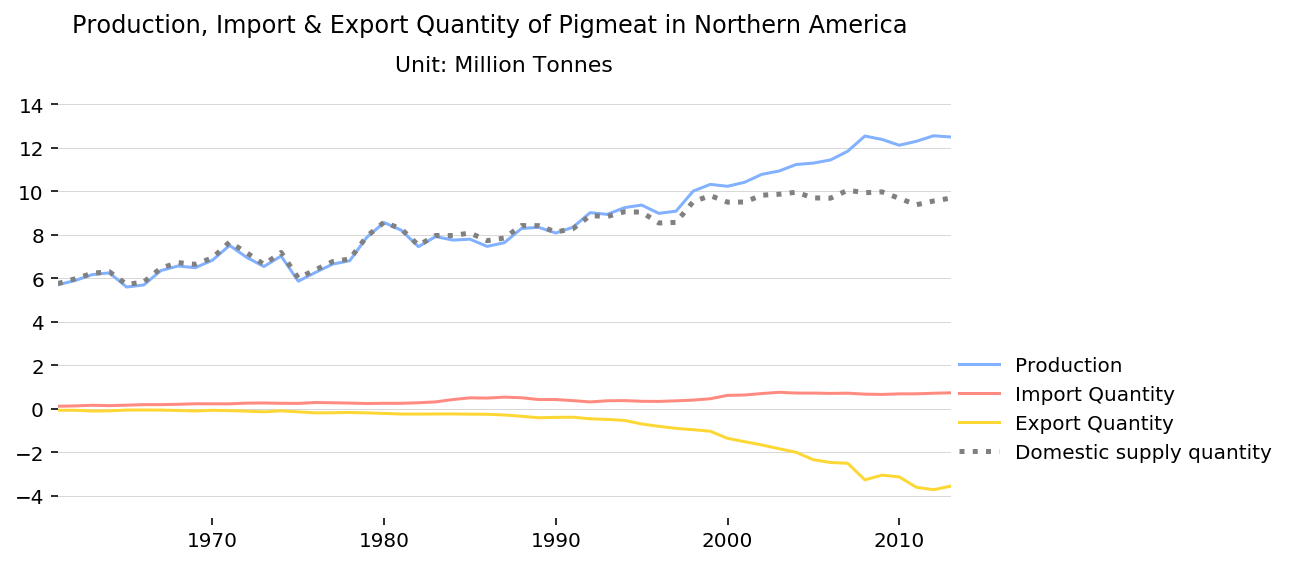

In [43]:
I = 'Pigmeat'
plotTrendsLine(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Production'], 
    ax1_ylim=(5,15),
    ax2_ylim=(-5,5),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

Production  Import Quantity  Export Quantity  Domestic supply quantity
Year                                                                        
2009     13.1431           1.5172           1.3513                   13.3093
2010     13.3181           1.3699           1.5928                   13.0951
2011     13.0621           1.2906           1.7409                   12.6118
2012     12.8705           1.4157           1.4953                   12.7909
2013     12.7751           1.4350           1.5565                   12.6536

Production, Import & Export Quantity of Bovine Meat in Northern America
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_01_Production, Import & Export Quantity of Bovine Meat in Northern America.png


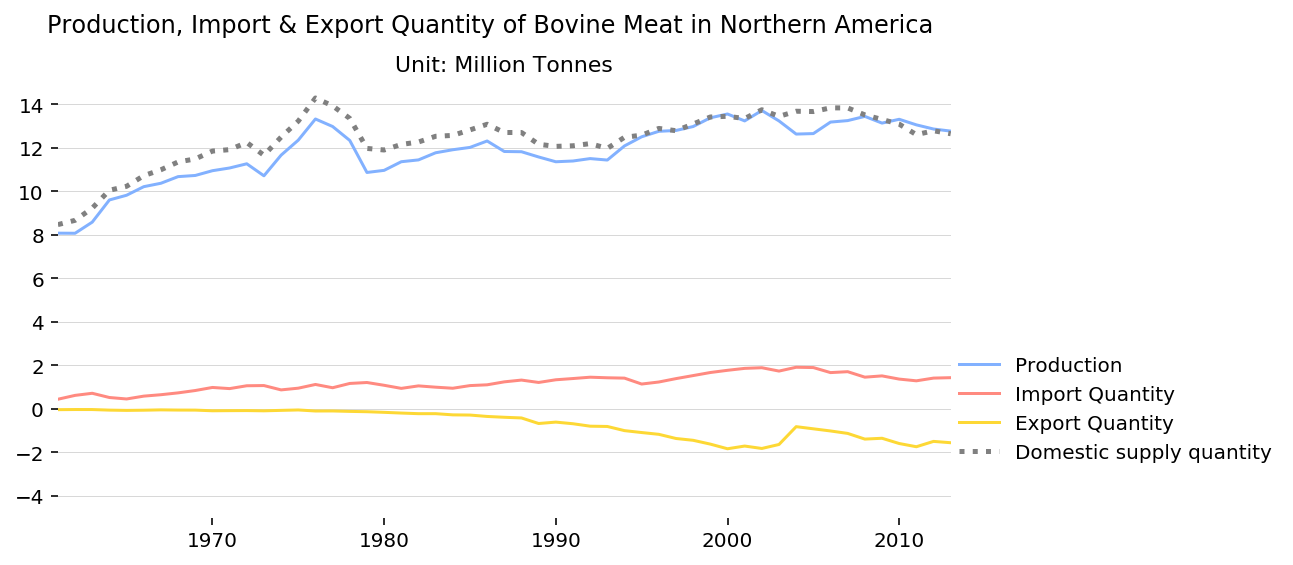

In [45]:
I = 'Bovine Meat'
plotTrendsLine(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Production'], 
    ax1_ylim=(5,15),
    ax2_ylim=(-5,5),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

Production  Import Quantity  Export Quantity  Domestic supply quantity
Year                                                                        
2009      0.0967           0.1048           0.0086                    0.1929
2010      0.0925           0.1030           0.0090                    0.1865
2011      0.0866           0.1024           0.0098                    0.1792
2012      0.0890           0.0960           0.0058                    0.1793
2013      0.0904           0.1048           0.0044                    0.1908

Production, Import & Export Quantity of Mutton & Goat Meat in Northern America
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_01_Production, Import & Export Quantity of Mutton & Goat Meat in Northern America.png


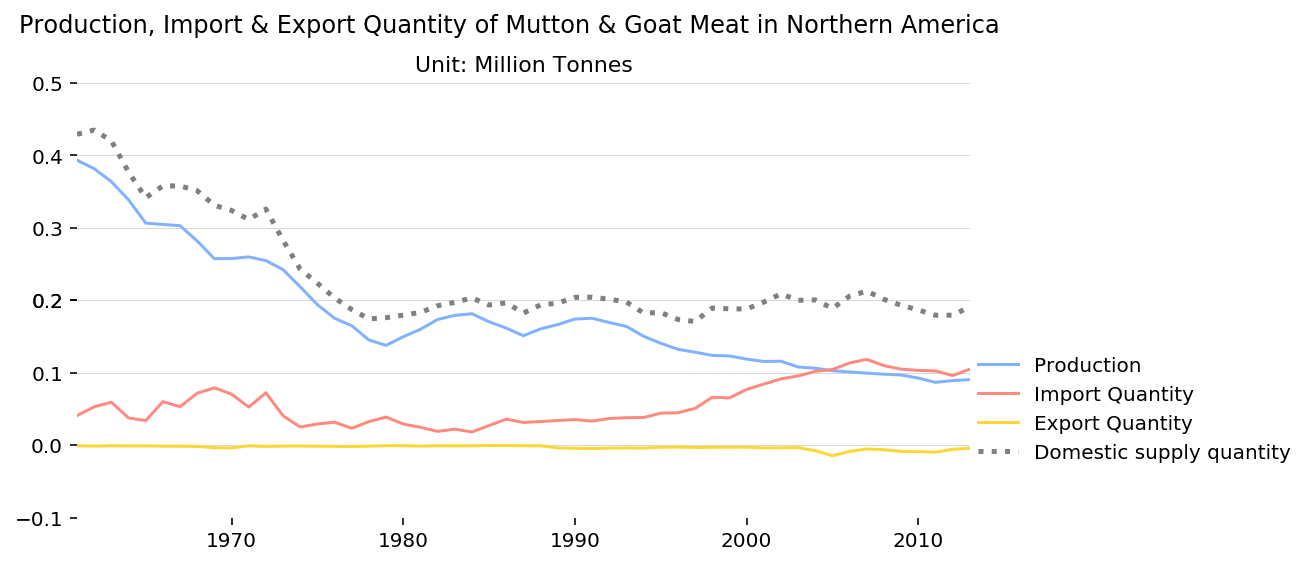

In [52]:
I = 'Mutton & Goat Meat'
plotTrendsLine(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Production'], 
    ax1_ylim=(0.2,0.5),
    ax2_ylim=(-0.1,0.2),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

Production  Import Quantity  Export Quantity  Domestic supply quantity
Year                                                                        
2009     20.1639           0.2876           4.0486                   16.3981
2010     20.7994           0.2955           3.8771                   17.2348
2011     21.0138           0.2969           4.0701                   17.5501
2012     21.0289           0.3201           4.2441                   17.1049
2013     21.3395           0.3307           4.2760                   17.3943

Production, Import & Export Quantity of Poultry Meat in Northern America
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_01_Production, Import & Export Quantity of Poultry Meat in Northern America.png


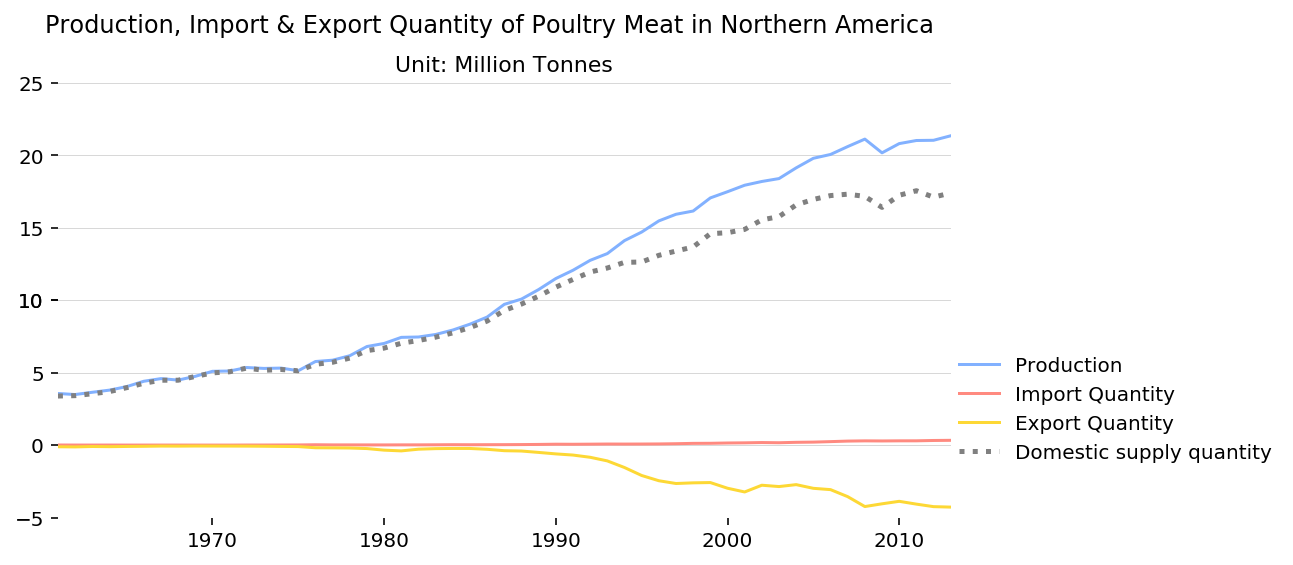

In [51]:
I = 'Poultry Meat'
plotTrendsLine(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Production'], 
    ax1_ylim=(10,25),
    ax2_ylim=(-5,10),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

Production  Import Quantity  Export Quantity  Domestic supply quantity
Year                                                                        
2009      5.7888           5.6492           2.8016                    8.6518
2010      6.0014           5.9470           2.9704                    8.9827
2011      6.5571           5.9452           3.4277                    9.0746
2012      6.5193           5.8323           3.3648                    8.9868
2013      6.6745           5.9030           3.4562                    9.1212

Production, Import & Export Quantity of Fish, Seafood in Northern America
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_01_Production, Import & Export Quantity of Fish, Seafood in Northern America.png


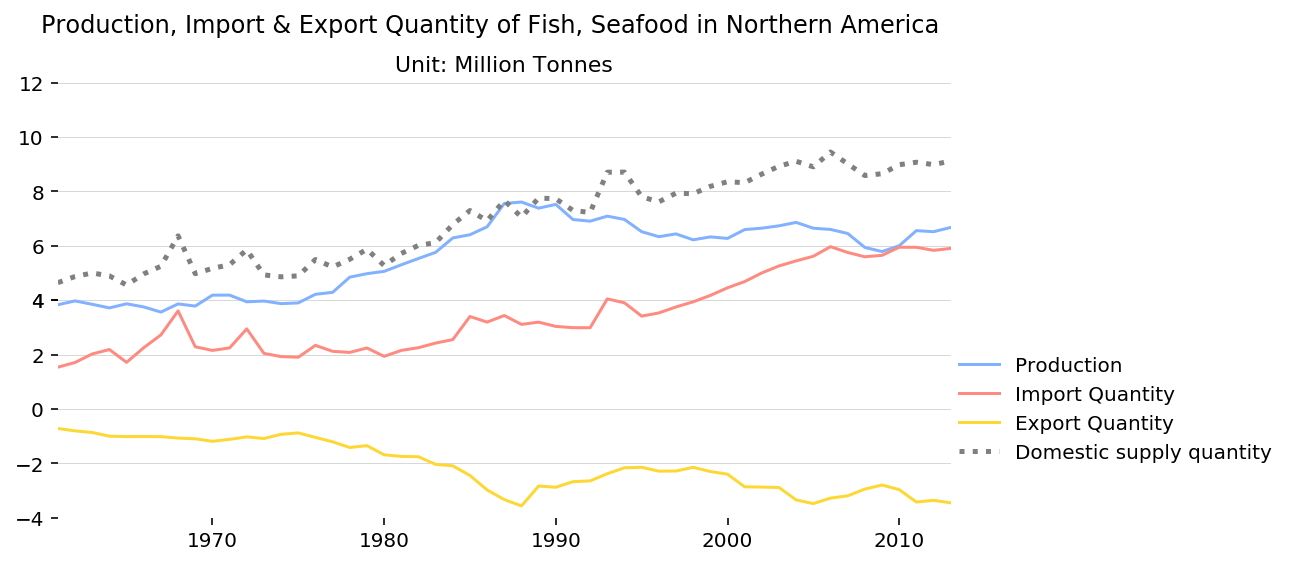

In [56]:
I = 'Fish, Seafood'
plotTrendsLine(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Production'], 
    ax1_ylim=(4,12),
    ax2_ylim=(-4,4),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

Production  Import Quantity  Export Quantity  Domestic supply quantity
Year                                                                        
2009      5.7908           0.0445           0.1780                    5.6573
2010      5.8635           0.0435           0.1817                    5.7253
2011      5.8993           0.0407           0.1898                    5.7502
2012      6.0563           0.0439           0.2508                    5.8495
2013      6.2505           0.0553           0.2800                    6.0258

Production, Import & Export Quantity of Eggs in Northern America
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_01_Production, Import & Export Quantity of Eggs in Northern America.png


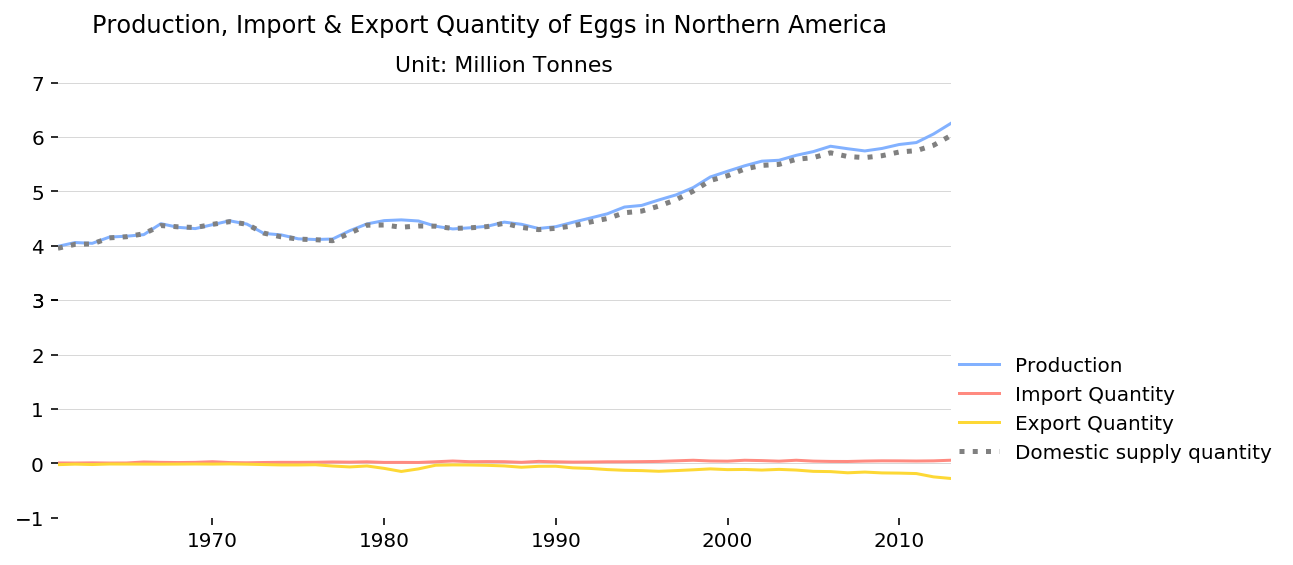

In [62]:
I = 'Eggs'
plotTrendsLine(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Production'], 
    ax1_ylim=(3,7),
    ax2_ylim=(-1,3),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

Production  Import Quantity  Export Quantity  Domestic supply quantity
Year                                                                        
2009     94.0952           4.0209           4.8819                   92.9830
2010     95.7188           3.4958           7.1776                   92.0942
2011     97.3800           4.0785           8.5374                   93.8161
2012     99.5752           6.3233           8.9823                   96.9162
2013     99.6723           5.9927          11.0748                   96.9170

Production, Import & Export Quantity of Milk Excluding Butter in Northern America
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_01_Production, Import & Export Quantity of Milk Excluding Butter in Northern America.png


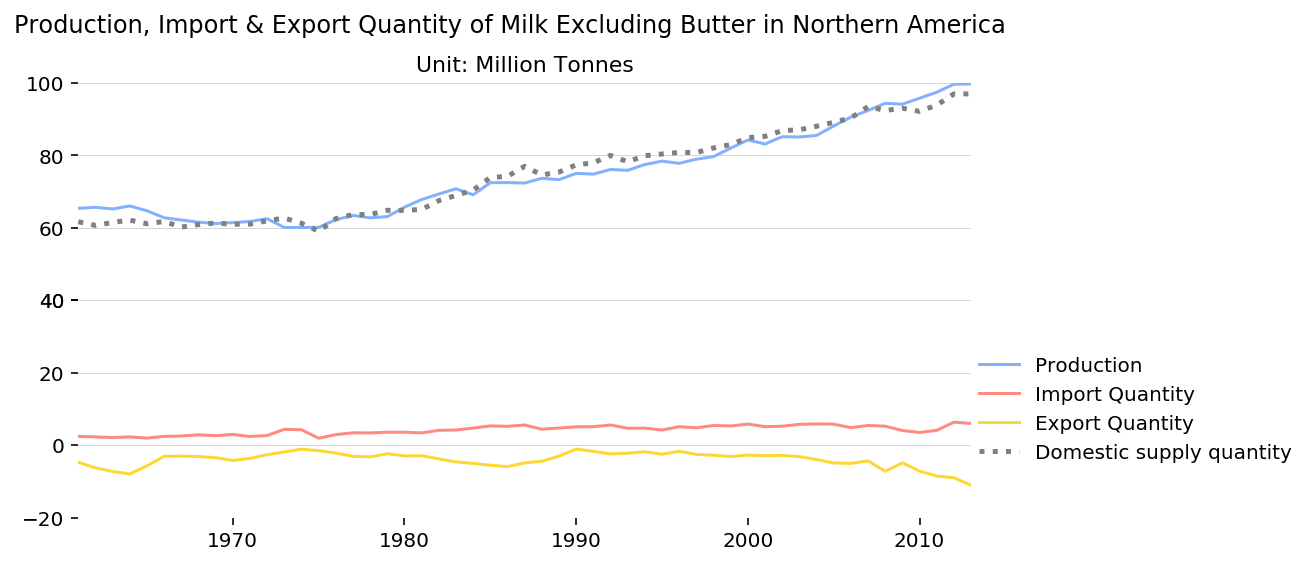

In [66]:
I = 'Milk - Excluding Butter'
plotTrendsLine(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Production'], 
    ax1_ylim=(40,100),
    ax2_ylim=(-20,40),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

### Food Supply, Feed and Losses

In [63]:
for i in Is:
    PVs_YearArea[i] = mkPVs_forElements_YearArea(item=i, elements=Es['Domestic Supply, Consumption'])

    for e, pv in PVs_YearArea[i].items():
        display(i, e, pv.tail(2)) 

'Pigmeat'

'Food supply quantity (tonnes)'

Africa  Albania  Algeria    Americas    Angola  Argentina  Armenia  \
Year                                                                          
2012  1393326.0  34911.0    156.0  1.6339e+07  175154.0   366678.0  26532.0   
2013  1467822.0  34507.0    142.0  1.6817e+07  190791.0   435424.0  28799.0   

            Asia  Australia  Australia & New Zealand   Austria  Azerbaijan  \
Year                                                                         
2012  6.5766e+07   556682.0                 656554.0  407973.0      2571.0   
2013  6.7445e+07   563544.0                 663981.0  446509.0      2364.0   

      Bahamas  Bangladesh   Belarus   Belgium  Belize    Benin  \
Year                                                             
2012  12550.0         0.0  380351.0  446774.0  6186.0  10175.0   
2013  12344.0         0.0  377731.0  429167.0  5579.0   8216.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                           93076.0                 36863.0    1405.0   
2013                           94835.0                 35925.0    1501.0   

         Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
Year                                                                   
2012  2512759.0             2859.0  188209.0       32014.0   98613.0   
2013  2525057.0             3490.0  189659.0       32731.0   98684.0   

      Cameroon    Canada  Caribbean  Central African Republic  \
Year                                                            
2012   31156.0  845938.0   377201.0                   16459.0   
2013   32800.0  802413.0   412853.0                   17090.0   

      Central America  Central Asia   Chad     Chile  China, Hong Kong SAR  \
Year                                                                         
2012        2029254.0      242080.0  668.0  427958.0              460021.0   
2013        2139849.0      241378.0  677.0  434857.0              483496.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012           40363.0                   901004.0       5.1724e+07  280935.0   
2013           40457.0                   918440.0       5.3247e+07  314396.0   

        Congo  Costa Rica   Croatia      Cuba   Cyprus   Czechia  \
Year                                                               
2012   5140.0     49522.0  192585.0  196178.0  44799.0  450846.0   
2013  10632.0     50088.0  183567.0  223327.0  43788.0  440624.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN        27405.0                               114854.0   
2013             NaN        35826.0                               117072.0   

       Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                         
2012  141189.0     112.0             91711.0        471300.0    5.7500e+07   
2013  139739.0     152.0             98982.0        513661.0    5.9043e+07   

      Eastern Europe   Ecuador   Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                     
2012       8492609.0  213041.0  1266.0      17492.0  38177.0    1962.0   
2013       8507695.0  227220.0  1332.0      20473.0  38193.0    1962.0   

      Ethiopia PDR      Europe  European Union    Fiji   Finland     France  \
Year                                                                          
2012           NaN  2.5758e+07      2.0101e+07  3935.0  201789.0  2150504.0   
2013           NaN  2.5686e+07      1.9878e+07  3800.0  196114.0  2124732.0   

        Gabon  Gambia  Georgia    Germany    Ghana    Greece  Guatemala  \
Year                                 

'Pigmeat'

'Losses'

Americas     Asia  Belarus    Canada  Central America  Central Asia  \
Year                                                                        
2012  184024.0  71499.0    787.0  160350.0           1720.0         870.0   
2013  180134.0  71034.0    792.0  158440.0           1740.0         464.0   

      Cyprus  Eastern Asia  Eastern Europe  Estonia   Europe  European Union  \
Year                                                                           
2012  2689.0       49000.0         18856.0   4744.0  27654.0         20385.0   
2013  2526.0       49000.0         15493.0   4976.0  24318.0         20195.0   

      Georgia  Hungary    Japan  Kyrgyzstan  Land Locked Developing Countries  \
Year                                                                            
2012    339.0    174.0  49000.0       855.0                             870.0   
2013    425.0   2369.0  49000.0       449.0                             464.0   

      Latvia  Least Developed Countries  Lithuania  \
Year                                                 
2012   600.0                    18601.0     3454.0   
2013   600.0                    18619.0     3249.0   

      Low Income Food Deficit Countries  Myanmar  \
Year                                               
2012                              855.0  18601.0   
2013                              449.0  18619.0   

      Net Food Importing Developing Countries  Northern America  \
Year                                                              
2012                                  40541.0          160364.0   
2013                                  38559.0          158454.0   

      Northern Europe  Panama     Peru  Romania  Russian Federation  \
Year                                                                  
2012           8798.0  1720.0  20000.0   8725.0              9170.0   
2013           8825.0  1740.0  18000.0   6475.0              5857.0   

      Small Island Developing States  South America  South-Eastern Asia  \
Year                                                                      
2012                            14.0        21940.0             18601.0   
2013                            14.0        19940.0             18619.0   

      Turkmenistan  USSR  Venezuela (Bolivarian Republic of)  Western Asia  \
Year                                                                         
2012          15.0   NaN                              1940.0        3028.0   
2013          15.0   NaN                              1940.0        2951.0   

         World  
Year            
2012  283177.0  
2013  275487.0

'Pigmeat'

'Other uses'

Africa  Algeria  Americas  Armenia      Asia  Bahamas  Belize  Brazil  \
Year                                                                          
2012   144.0      2.0   23437.0   1600.0  125386.0  10917.0     0.0     0.0   
2013   207.0     42.0   14035.0   2000.0   49181.0   8023.0     0.0     0.0   

      Bulgaria  Caribbean  Central America  China, Hong Kong SAR  \
Year                                                               
2012       0.0    21668.0            358.0               91277.0   
2013       0.0    12596.0            730.0               16712.0   

      China, Macao SAR  China, Taiwan Province of  Costa Rica   Cyprus  \
Year                                                                     
2012             608.0                     1986.0       358.0  10818.0   
2013             609.0                     2045.0       730.0  10372.0   

       Denmark  Eastern Asia  Eastern Europe    Europe  European Union   Fiji  \
Year                                                                            
2012  191429.0       93871.0         33778.0  268223.0        264041.0  169.0   
2013  151429.0       19365.0         25370.0  214728.0        214101.0  169.0   

       Greece  Guyana  Hungary  Land Locked Developing Countries  \
Year                                                               
2012  12486.0  1269.0      0.0                            1600.0   
2013  12211.0   238.0      0.0                            2000.0   

      Least Developed Countries  Lebanon  Lithuania  \
Year                                                  
2012                      195.0    635.0      974.0   
2013                      185.0    635.0      361.0   

      Low Income Food Deficit Countries  Malaysia  Mauritania  Melanesia  \
Year                                                                       
2012                                0.0      37.0         0.0     4700.0   
2013                                1.0      36.0         1.0     4724.0   

      Micronesia  Net Food Importing Developing Countries  \
Year                                                        
2012       195.0                                  11089.0   
2013       184.0                                   4923.0   

      Netherlands Antilles (former)  New Caledonia  Northern Africa  \
Year                                                                  
2012                            NaN         4531.0            144.0   
2013                            NaN         4555.0            206.0   

      Northern America  Northern Europe   Norway  Oceania    Oman   Poland  \
Year                                                                         
2012             141.0         207403.0  15000.0   6061.0  3561.0  33778.0   
2013             471.0         162790.0  11000.0   6472.0   785.0  25370.0   

      Polynesia  Portugal  Small Island Developing States  South America  \
Year                                                                       
2012     1166.0   12792.0                         29139.0         1269.0   
2013     1564.0   12599.0                         19777.0          238.0   

      South-Eastern Asia  Southern Europe  Sudan (former)  Tunisia  \
Year                                                                 
2012                37.0          27042.0             NaN    143.0   
2013                36.0          26568.0             NaN    165.0   

      United Arab Emirates  United States of America  Western Africa  \
Year                                                                   
2012               14864.0                       0.0             0.0   
2013               15988.0                       0.0             1.0   

      Western Asia     World  Yugoslav SFR  
Year                                        
2012       31478.0  423251.0           NaN  
2013       29780.0  284625.0           NaN

'Pigmeat'

'Processing'

Africa  Americas     Asia  Austria  Belarus  Bulgaria  Canada  \
Year                                                                  
2012     0.0       1.0  28814.0      0.0      0.0       0.0     0.0   
2013    -1.0      -2.0  21148.0      0.0      0.0      -1.0     0.0   

      Central Asia  Chad  Chile  China, Taiwan Province of  China, mainland  \
Year                                                                          
2012           0.0   0.0    0.0                       -1.0          28815.0   
2013           0.0   0.0    0.0                        0.0          21148.0   

      Croatia  Cyprus  Czechia  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                           
2012      0.0     0.0      0.0             0.0       28814.0             0.0   
2013      0.0     0.0     -1.0            -1.0       21148.0            -1.0   

       Europe  European Union  Fiji  Finland  Georgia  Greece  Hungary  India  \
Year                                                                            
2012  15176.0          2676.0  -1.0      1.0      0.0     0.0      0.0    0.0   
2013  15027.0          2627.0  -1.0      1.0      0.0     1.0      1.0    0.0   

      Indonesia  Italy  Kazakhstan  Kenya  Land Locked Developing Countries  \
Year                                                                          
2012        0.0   -1.0         0.0    0.0                               0.0   
2013        0.0    0.0         0.0    0.0                              -1.0   

      Latvia  Least Developed Countries  Low Income Food Deficit Countries  \
Year                                                                         
2012     0.0                        0.0                                0.0   
2013     0.0                        0.0                               -1.0   

      Madagascar  Melanesia  Middle Africa  \
Year                                         
2012         0.0       -1.0            0.0   
2013         0.0       -1.0            0.0   

      Net Food Importing Developing Countries  Northern America  \
Year                                                              
2012                                      1.0               1.0   
2013                                      0.0              -2.0   

      Northern Europe  Oceania  Portugal  Russian Federation   Serbia  \
Year                                                                    
2012              1.0     -1.0    2675.0                 0.0  12500.0   
2013              1.0     -1.0    2626.0                 0.0  12400.0   

      Serbia and Montenegro  Slovenia  Small Island Developing States  \
Year                                                                    
2012                    NaN       0.0                            -1.0   
2013                    NaN       0.0                            -1.0   

      South America  South-Eastern Asia  Southern Asia  Southern Europe  \
Year                                                                      
2012            0.0                -1.0            1.0          15175.0   
2013            0.0                 0.0            0.0          15027.0   

      Spain  Sri Lanka  Thailand  USSR  Ukraine  United Kingdom  \
Year                                                              
2012    1.0        1.0      -1.0   NaN      0.0             0.0   
2013    0.0        0.0       0.0   NaN      0.0             0.0   

      United States of America  Western Asia  Western Europe    World  \
Year                                                                    
2012                       1.0           0.0             0.0  43990.0   
2013                      -2.0           0.0             0.0  36171.0   

      Zimbabwe  
Year            
2012       0.0  
2013      -1.0

'Pigmeat'

'Domestic supply quantity'

Africa  Albania  Algeria    Americas    Angola  Argentina  Armenia  \
Year                                                                          
2012  1393454.0  34911.0    157.0  1.6457e+07  175154.0   366679.0  28132.0   
2013  1468011.0  34507.0    183.0  1.6892e+07  190791.0   435424.0  30799.0   

            Asia  Australia  Australia & New Zealand   Austria  Azerbaijan  \
Year                                                                         
2012  6.5961e+07   556682.0                 656554.0  407973.0      2571.0   
2013  6.7556e+07   563544.0                 663981.0  446509.0      2364.0   

      Bahamas  Bangladesh   Belarus   Belgium  Belize    Benin  \
Year                                                             
2012  23468.0         0.0  381139.0  446774.0  6186.0  10175.0   
2013  20367.0         0.0  378523.0  429167.0  5579.0   8216.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                           93076.0                 36863.0    1405.0   
2013                           94835.0                 35925.0    1501.0   

         Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
Year                                                                   
2012  2512759.0             2859.0  188209.0       32014.0   98613.0   
2013  2525057.0             3490.0  189658.0       32731.0   98684.0   

      Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                             
2012   31156.0  1006288.0   398869.0                   16459.0   
2013   32800.0   960853.0   425431.0                   17090.0   

      Central America  Central Asia   Chad     Chile  China, Hong Kong SAR  \
Year                                                                         
2012        2031326.0      242950.0  668.0  427958.0              551298.0   
2013        2142246.0      241843.0  676.0  434857.0              500207.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012           40970.0                   902990.0       5.1752e+07  280935.0   
2013           41066.0                   920486.0       5.3268e+07  314396.0   

        Congo  Costa Rica   Croatia      Cuba   Cyprus   Czechia  \
Year                                                               
2012   5140.0     49875.0  192585.0  196178.0  58305.0  450846.0   
2013  10632.0     50744.0  183567.0  223327.0  56686.0  440623.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN        27405.0                               114854.0   
2013             NaN        35826.0                               117072.0   

       Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                         
2012  332618.0     112.0             91711.0        471300.0    5.7671e+07   
2013  291167.0     152.0             98982.0        513660.0    5.9132e+07   

      Eastern Europe   Ecuador   Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                     
2012       8545243.0  213041.0  1266.0      17492.0  42921.0    1962.0   
2013       8548558.0  227220.0  1332.0      20473.0  43169.0    1962.0   

      Ethiopia PDR      Europe  European Union    Fiji   Finland     France  \
Year                                                                          
2012           NaN  2.6069e+07      2.0388e+07  4103.0  201790.0  2150504.0   
2013           NaN  2.5940e+07      2.0114e+07  3969.0  196115.0  2124732.0   

        Gabon  Gambia  Georgia    Germany    Ghana    Greece  Guatemala  \
Year                             

'Bovine Meat'

'Food supply quantity (tonnes)'

Afghanistan     Africa  Albania   Algeria    Americas    Angola  \
Year                                                                    
2012     153438.0  6058170.0  70824.0  221826.0  2.7997e+07  169870.0   
2013     140087.0  6299307.0  71383.0  219582.0  2.8181e+07  180712.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012  2271775.0  56582.0  1.8535e+07   818413.0                 900695.0   
2013  2299590.0  58521.0  1.8768e+07   790362.0                 891681.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
Year                                                                          
2012  147534.0    115294.0   9304.0    199432.0  181246.0  175005.0  1603.0   
2013  145588.0    119317.0   7511.0    200522.0  160063.0  173502.0  1614.0   

        Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                      
2012  31318.0                          211470.0                 34085.0   
2013  31520.0                          211065.0                 34929.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012   16633.0  7811103.0             4609.0   28137.0      128453.0   
2013   15858.0  7863343.0             5080.0   27733.0       75944.0   

      Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                                       
2012   73296.0   88711.0  1062911.0   254483.0                   90000.0   
2013   73479.0   92857.0  1064325.0   257572.0                   55000.0   

      Central America  Central Asia     Chad     Chile  China, Hong Kong SAR  \
Year                                                                           
2012        2187158.0     1394608.0  98003.0  359012.0              205402.0   
2013        2241586.0     1455129.0  98403.0  420339.0              185974.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012            5829.0                   108620.0        6606176.0  827677.0   
2013            5885.0                   121585.0        7089479.0  790406.0   

        Congo  Costa Rica  Croatia     Cuba  Cyprus  Czechia  Czechoslovakia  \
Year                                                                           
2012  14029.0     74210.0  54252.0  70530.0  7643.0  86673.0             NaN   
2013  19340.0     74199.0  53253.0  72039.0  6611.0  87260.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
Year                                                                   
2012        33879.0                                21975.0  153334.0   
2013        34539.0                                21975.0  159920.0   

      Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                               
2012    7256.0             98037.0       1678700.0     8853538.0   
2013    8729.0            102830.0       1713491.0     9361049.0   

      Eastern Europe   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                        
2012       3410302.0  265951.0  1067378.0      46256.0  13845.0  337251.0   
2013       3381153.0  261378.0  1056718.0      37754.0   9253.0  339851.0   

      Ethiopia PDR      Europe  European Union    Fiji   Finland     France  \
Year                                                                          
2012           NaN  1.1295e+07       7822261.0  9304.0  104287.0  1606019.0   
2013           NaN  1.1048e+07       7585066.0  7897.0  104287.0  1530980.0   

        Gabon  Gambia  Georgia    Germany    

'Bovine Meat'

'Losses'

Americas  Argentina     Asia  Belarus  Caribbean  Central America  \
Year                                                                      
2012  212937.0   110927.0  50807.0   1473.0       58.0           4625.0   
2013  394107.0   289494.0  51335.0    558.0       56.0           4290.0   

      Central Asia  Colombia  Cyprus  Czechoslovakia  Denmark  Eastern Asia  \
Year                                                                          
2012       24118.0   17085.0   402.0             NaN    736.0       25000.0   
2013       24634.0   16968.0   356.0             NaN   1281.0       25000.0   

      Eastern Europe  Estonia   Europe  European Union  Georgia  Germany  \
Year                                                                       
2012         14730.0    162.0  22200.0         14228.0    325.0   5000.0   
2013         12837.0    112.0  19766.0         12788.0    405.0   5000.0   

      Guatemala  Hungary  Jamaica    Japan  Kazakhstan  \
Year                                                     
2012        0.0    500.0     58.0  25000.0     17800.0   
2013        0.0    500.0     56.0  25000.0     18300.0   

      Land Locked Developing Countries  Latvia  Least Developed Countries  \
Year                                                                        
2012                           24118.0   365.0                        0.0   
2013                           24634.0   360.0                        0.0   

      Lithuania  Myanmar  Net Food Importing Developing Countries  \
Year                                                                
2012     1207.0      0.0                                  80194.0   
2013      176.0      0.0                                  83301.0   

      Northern America  Northern Europe  Panama     Peru  Romania  \
Year                                                                
2012             106.0           2470.0  4625.0  55000.0   5857.0   
2013              54.0           1929.0  4290.0  54000.0   5003.0   

      Russian Federation  Small Island Developing States  South America  \
Year                                                                      
2012              5346.0                           164.0       208148.0   
2013              5065.0                           110.0       389707.0   

      South-Eastern Asia  Turkmenistan  USSR  Ukraine  United Arab Emirates  \
Year                                                                          
2012                 0.0        6318.0   NaN   1554.0                 962.0   
2013                 0.0        6334.0   NaN   1711.0                 940.0   

      Venezuela (Bolivarian Republic of)  Western Asia  Western Europe  \
Year                                                                     
2012                             25136.0        1689.0          5000.0   
2013                             29245.0        1701.0          5000.0   

         World  
Year            
2012  285943.0  
2013  465208.0

'Bovine Meat'

'Other uses'

Africa  Americas  Armenia     Asia  Azerbaijan  Bahamas  Belize  \
Year                                                                    
2012  8462.0   13537.0   1000.0  87059.0      6000.0  12165.0   300.0   
2013  9619.0   13497.0   2000.0  47930.0      6000.0  11457.0   500.0   

      Burkina Faso  Caribbean  Central America  Central Asia  \
Year                                                           
2012           0.0    12811.0            300.0       32650.0   
2013           0.0    12780.0            500.0       22288.0   

      China, Hong Kong SAR  China, Macao SAR  China, Taiwan Province of  \
Year                                                                      
2012               39505.0              29.0                       20.0   
2013                8912.0              30.0                       18.0   

      Cyprus  Eastern Asia  Eastern Europe   Europe  European Union   Fiji  \
Year                                                                         
2012   448.0       39554.0          2976.0  15893.0         16022.0  311.0   
2013   394.0        8960.0          2739.0  15006.0         14614.0  316.0   

      Georgia  Greece  Iraq  Jordan  Kazakhstan  Kuwait  Kyrgyzstan  \
Year                                                                  
2012    860.0  7829.0   0.0     0.0     11550.0     0.0     21100.0   
2013   1340.0  7490.0   0.0     0.0      4088.0     0.0     18200.0   

      Land Locked Developing Countries  Least Developed Countries  Lebanon  \
Year                                                                         
2012                           39650.0                       75.0   5000.0   
2013                           30288.0                       36.0   5000.0   

      Low Income Food Deficit Countries  Melanesia  Micronesia  \
Year                                                             
2012                            21100.0     2930.0        75.0   
2013                            18200.0     2906.0        36.0   

      Net Food Importing Developing Countries  Netherlands Antilles (former)  \
Year                                                                           
2012                                   2270.0                            NaN   
2013                                   3306.0                            NaN   

      New Caledonia  Northern America  Oceania  Poland  Polynesia  Portugal  \
Year                                                                          
2012         2619.0             426.0   3385.0  2657.0      380.0    4408.0   
2013         2590.0             217.0   3178.0  1952.0      236.0    4090.0   

      Small Island Developing States  South Africa  Southern Africa  \
Year                                                                  
2012                         18470.0        8462.0           8462.0   
2013                         18623.0        9619.0           9619.0   

      Southern Asia  Southern Europe  Ukraine  United States of America  \
Year                                                                      
2012         1548.0          12917.0    319.0                       0.0   
2013         1948.0          12268.0    787.0                       0.0   

      Western Africa  Western Asia     World  
Year                                          
2012             0.0       13308.0  128337.0  
2013             0.0       14734.0   89231.0

'Bovine Meat'

'Feed'

Asia  Central Asia  Eastern Europe  Europe  Georgia  Kazakhstan  \
Year                                                                      
2012  8300.0        8200.0             0.0     0.0    100.0      8200.0   
2013  8600.0        8500.0             0.0     0.0    100.0      8500.0   

      Land Locked Developing Countries  Ukraine  Western Asia   World  
Year                                                                   
2012                            8200.0      0.0         100.0  8300.0  
2013                            8500.0      0.0         100.0  8600.0

'Bovine Meat'

'Processing'

Africa  Americas  Asia  Australia  Australia & New Zealand  Austria  \
Year                                                                        
2012     1.0       0.0  -1.0        0.0                      0.0      0.0   
2013     2.0       0.0  -1.0        0.0                      0.0     -1.0   

      Caribbean  China, Taiwan Province of  Cyprus  Eastern Africa  \
Year                                                                 
2012        0.0                        0.0     0.0             1.0   
2013        0.0                        0.0     0.0             1.0   

      Eastern Asia  Eastern Europe   Europe  European Union  Fiji  Finland  \
Year                                                                         
2012           0.0        -21415.0 -21417.0        -21417.0   0.0      0.0   
2013           1.0        -18625.0 -18631.0        -18631.0   0.0      0.0   

      France  Greece  Hungary  India  Indonesia  Ireland  Japan  \
Year                                                              
2012     0.0     0.0 -21415.0   -1.0        1.0      0.0    0.0   
2013    -1.0    -1.0 -18625.0   -1.0        0.0      0.0    0.0   

      Land Locked Developing Countries  Latvia  Least Developed Countries  \
Year                                                                        
2012                               0.0    -1.0                        1.0   
2013                               0.0    -2.0                        1.0   

      Low Income Food Deficit Countries  Madagascar  Malaysia  Melanesia  \
Year                                                                       
2012                                1.0         1.0       0.0        0.0   
2013                               -1.0         1.0       0.0        0.0   

      Morocco  Net Food Importing Developing Countries  Northern Africa  \
Year                                                                      
2012      0.0                                      2.0              0.0   
2013      1.0                                      1.0              1.0   

      Northern America  Northern Europe  Norway  Oceania  Pakistan  Poland  \
Year                                                                         
2012               0.0             -2.0     0.0      0.0       1.0     0.0   
2013               0.0             -2.0     0.0      0.0      -1.0     0.0   

      Republic of Korea  Serbia and Montenegro  Slovenia  \
Year                                                       
2012                0.0                    NaN       0.0   
2013                1.0                    NaN       0.0   

      Small Island Developing States  South-Eastern Asia  Southern Asia  \
Year                                                                      
2012                             0.0                 0.0            0.0   
2013                             0.0                -1.0           -2.0   

      Southern Europe  Sweden  Thailand  Turkey  Uganda  United Kingdom  \
Year                                                                      
2012              0.0    -1.0      -1.0    -1.0     0.0             0.0   
2013             -1.0     1.0      -1.0     1.0     0.0            -1.0   

      United States of America  Western Asia  Western Europe    World  \
Year                                                                    
2012                       0.0          -1.0             0.0 -21417.0   
2013                       0.0           1.0            -2.0 -18630.0   

      Yugoslav SFR  Zimbabwe  
Year                          
2012           NaN       0.0  
2013           NaN       0.0

'Bovine Meat'

'Domestic supply quantity'

Afghanistan     Africa  Albania   Algeria    Americas    Angola  \
Year                                                                    
2012     153438.0  6065426.0  70824.0  221826.0  2.8212e+07  169870.0   
2013     140087.0  6307008.0  71383.0  219582.0  2.8578e+07  180714.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012  2382702.0  57582.0  1.8661e+07   818414.0                 900697.0   
2013  2589084.0  60521.0  1.8855e+07   790362.0                 891681.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
Year                                                                          
2012  147534.0    121294.0  21469.0    199432.0  182719.0  175005.0  1903.0   
2013  145587.0    125317.0  18969.0    200522.0  160621.0  173502.0  2114.0   

        Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                      
2012  31318.0                          211470.0                 34085.0   
2013  31520.0                          211064.0                 34929.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012   16633.0  7811103.0             4609.0   28138.0      128453.0   
2013   15858.0  7863343.0             5080.0   27733.0       75944.0   

      Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                                       
2012   73296.0   88711.0  1062911.0   267349.0                   90000.0   
2013   73479.0   92857.0  1064325.0   270404.0                   55000.0   

      Central America  Central Asia     Chad     Chile  China, Hong Kong SAR  \
Year                                                                           
2012        2192043.0     1459576.0  98003.0  359003.0              244906.0   
2013        2246302.0     1510551.0  98403.0  420275.0              194886.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012            5859.0                   108637.0        6606176.0  844756.0   
2013            5915.0                   121602.0        7089479.0  807375.0   

        Congo  Costa Rica  Croatia     Cuba  Cyprus  Czechia  Czechoslovakia  \
Year                                                                           
2012  14029.0     74206.0  54252.0  70530.0  8492.0  86673.0             NaN   
2013  19340.0     74194.0  53253.0  72039.0  7358.0  87259.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
Year                                                                   
2012        33879.0                                21975.0  154069.0   
2013        34539.0                                21975.0  161201.0   

      Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                               
2012    7256.0             98037.0       1677533.0     8918089.0   
2013    8729.0            102830.0       1711683.0     9395009.0   

      Eastern Europe   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                        
2012       3406594.0  265951.0  1067378.0      46256.0  14007.0  337251.0   
2013       3378102.0  261378.0  1056718.0      37754.0   9365.0  339851.0   

      Ethiopia PDR      Europe  European Union    Fiji   Finland     France  \
Year                                                                          
2012           NaN  1.1302e+07       7820883.0  9615.0  104287.0  1606019.0   
2013           NaN  1.1053e+07       7582582.0  8213.0  104289.0  1530979.0   

        Gabon  Gambia  Georgia    Germany    

'Mutton & Goat Meat'

'Food supply quantity (tonnes)'

Afghanistan     Africa  Albania   Algeria  Americas   Angola  Argentina  \
Year                                                                            
2012     155201.0  2692310.0  48221.0  281753.0  606674.0  22230.0    65617.0   
2013     150201.0  2766828.0  48618.0  301320.0  625754.0  23101.0    64588.0   

      Armenia       Asia  Australia  Australia & New Zealand  Austria  \
Year                                                                    
2012   8500.0  7932382.0   227034.0                 320232.0   9536.0   
2013   9000.0  8255188.0   230507.0                 315714.0   9877.0   

      Azerbaijan  Bahamas  Bangladesh  Belarus  Belgium  Belize   Benin  \
Year                                                                      
2012     70406.0   2514.0    204140.0   1000.0  13545.0    37.0  8535.0   
2013     70994.0   1969.0    208210.0   1000.0  14608.0    46.0  8617.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                           18706.0                  2471.0    7574.0   
2013                           18309.0                  1783.0    7600.0   

        Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
Year                                                                            
2012  120769.0             1052.0   15928.0       54842.0      13.0   27022.0   
2013  124657.0              958.0   11772.0       41073.0      22.0   31218.0   

       Canada  Caribbean  Central African Republic  Central America  \
Year                                                                  
2012  31220.0    35040.0                   23592.0         111462.0   
2013  34008.0    33993.0                   23740.0         113437.0   

      Central Asia     Chad   Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                                          
2012      490627.0  42242.0  9928.0                9769.0             392.0   
2013      509242.0  43020.0  7436.0               15978.0             410.0   

      China, Taiwan Province of  China, mainland  Colombia   Congo  \
Year                                                                 
2012                    21183.0        4128895.0   10546.0  1686.0   
2013                    21370.0        4336508.0   10278.0  1788.0   

      Costa Rica  Croatia     Cuba  Cyprus  Czechia  Czechoslovakia  \
Year                                                                  
2012        80.0   6950.0  14721.0  6391.0   3330.0             NaN   
2013        74.0   7316.0  13932.0  5766.0   3666.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
Year                                                                            
2012        13717.0                                15705.0   4224.0    4667.0   
2013        13850.0                                15705.0   5161.0    4665.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                     
2012              2180.0        449871.0     4322324.0        318703.0   
2013              2270.0        466601.0     4544451.0        313245.0   

      Ecuador     Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
Year                                                                    
2012   6712.0  131219.0        130.0    564.0  143843.0           NaN   
2013   6949.0  129625.0        134.0    565.0  147793.0           NaN   

         Europe  European Union    Fiji  Finland    France   Gabon  Gambia  \
Year                                                                         
2012  1413505.0       1073133.0  5161.0   3105.0  210769.0  2094.0  1395.0   
2013  1416099.0       1067472.0  5198.0   2893.0  210636.0  2122.0  1315.0   

      Georgia  Germany    Ghana    Greece  Guatemala   Guinea

'Mutton & Goat Meat'

'Losses'

Americas     Asia  Belarus  Central Asia  Cyprus  Eastern Asia  \
Year                                                                   
2012   13600.0  17205.0     19.0        9593.0   347.0         347.0   
2013   11000.0  18422.0    127.0       10293.0   314.0         374.0   

      Eastern Europe  Europe  European Union   Italy  Japan  Kyrgyzstan  \
Year                                                                      
2012          1488.0  4220.0          4548.0  2732.0  347.0      3093.0   
2013          1590.0  3897.0          4084.0  2307.0  374.0      3793.0   

      Land Locked Developing Countries  Low Income Food Deficit Countries  \
Year                                                                        
2012                            9593.0                             3093.0   
2013                           10293.0                             3793.0   

      Net Food Importing Developing Countries   Oman     Peru  Poland  \
Year                                                                    
2012                                  13600.0  861.0  13600.0    88.0   
2013                                  11000.0  869.0  11000.0    86.0   

      Romania  South America  Southern Europe  Turkmenistan  USSR  \
Year                                                                
2012   1381.0        13600.0           2732.0        6500.0   NaN   
2013   1377.0        11000.0           2307.0        6500.0   NaN   

      United Arab Emirates  Western Asia    World  
Year                                               
2012                6057.0        7265.0  35025.0  
2013                6572.0        7755.0  33319.0

'Mutton & Goat Meat'

'Other uses'

Africa  Americas     Asia  Australia  Australia & New Zealand  Bahamas  \
Year                                                                           
2012   637.0     274.0  10743.0    16883.0                  25727.0     50.0   
2013   653.0     235.0  32865.0    17824.0                  18895.0     50.0   

      Caribbean  China, Hong Kong SAR  Cyprus  Eastern Asia   Europe  \
Year                                                                   
2012      239.0                5000.0   213.0        6000.0  16379.0   
2013      208.0                1000.0   199.0       28000.0  11156.0   

      European Union   France  Greece  Kuwait  \
Year                                            
2012         16592.0  11769.0  4487.0     0.0   
2013         11355.0   6649.0  4393.0     0.0   

      Land Locked Developing Countries  Lebanon  Mongolia  \
Year                                                        
2012                            1000.0    300.0    1000.0   
2013                           27000.0    300.0   27000.0   

      Net Food Importing Developing Countries  New Zealand  Northern Africa  \
Year                                                                          
2012                                   1826.0       8844.0            637.0   
2013                                  27811.0       1071.0            653.0   

      Northern America  Oceania  Polynesia  Small Island Developing States  \
Year                                                                         
2012              35.0  25786.0       59.0                           333.0   
2013              27.0  18941.0       46.0                           281.0   

      Southern Europe  Tunisia  United Arab Emirates  Western Asia  \
Year                                                                 
2012           4610.0    637.0                4230.0        4743.0   
2013           4507.0    653.0                4366.0        4865.0   

      Western Europe    World  
Year                           
2012         11769.0  53819.0  
2013          6649.0  63850.0

'Mutton & Goat Meat'

'Feed'

Americas  Canada  Northern America  United States of America    World
Year                                                                       
2012   17402.0  1907.0           17402.0                   15495.0  17402.0
2013   17699.0  1982.0           17699.0                   15717.0  17699.0

'Mutton & Goat Meat'

'Domestic supply quantity'

Afghanistan     Africa  Albania   Algeria  Americas   Angola  Argentina  \
Year                                                                            
2012     155200.0  2692946.0  48221.0  281753.0  637946.0  22230.0    65617.0   
2013     150200.0  2767480.0  48618.0  301320.0  654696.0  23101.0    64588.0   

      Armenia       Asia  Australia  Australia & New Zealand  Austria  \
Year                                                                    
2012   8500.0  7960329.0   243917.0                 345959.0   9536.0   
2013   9000.0  8306475.0   248331.0                 334609.0   9877.0   

      Azerbaijan  Bahamas  Bangladesh  Belarus  Belgium  Belize   Benin  \
Year                                                                      
2012     70406.0   2564.0    204140.0   1019.0  13545.0    37.0  8535.0   
2013     70994.0   2019.0    208210.0   1127.0  14608.0    46.0  8617.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                           18704.0                  2471.0    7574.0   
2013                           18309.0                  1783.0    7600.0   

        Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
Year                                                                            
2012  120769.0             1052.0   15928.0       54842.0      13.0   27022.0   
2013  124657.0              958.0   11772.0       41073.0      22.0   31218.0   

       Canada  Caribbean  Central African Republic  Central America  \
Year                                                                  
2012  33127.0    35279.0                   23592.0         111461.0   
2013  35990.0    34210.0                   23740.0         113437.0   

      Central Asia     Chad   Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                                          
2012      500220.0  42242.0  9928.0               14769.0             392.0   
2013      519535.0  43020.0  7436.0               16978.0             410.0   

      China, Taiwan Province of  China, mainland  Colombia   Congo  \
Year                                                                 
2012                    21183.0        4128895.0   10545.0  1686.0   
2013                    21370.0        4336508.0   10277.0  1788.0   

      Costa Rica  Croatia     Cuba  Cyprus  Czechia  Czechoslovakia  \
Year                                                                  
2012        80.0   6950.0  14721.0  6951.0   3330.0             NaN   
2013        74.0   7316.0  13932.0  6280.0   3666.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
Year                                                                            
2012        13717.0                                15705.0   4224.0    4667.0   
2013        13850.0                                15705.0   5161.0    4665.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                     
2012              2180.0        449872.0     4328671.0        320191.0   
2013              2270.0        466601.0     4572825.0        314835.0   

      Ecuador     Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
Year                                                                    
2012   6712.0  131219.0        130.0    564.0  143843.0           NaN   
2013   6949.0  129625.0        134.0    565.0  147793.0           NaN   

         Europe  European Union    Fiji  Finland    France   Gabon  Gambia  \
Year                                                                         
2012  1434103.0       1094273.0  5161.0   3105.0  222538.0  2094.0  1395.0   
2013  1431151.0       1082912.0  5198.0   2893.0  217285.0  2122.0  1315.0   

      Georgia  Germany    Ghana    Greece  Guatemala   Guinea

'Poultry Meat'

'Food supply quantity (tonnes)'

Afghanistan     Africa  Albania   Algeria    Americas    Angola  \
Year                                                                    
2012      46550.0  6323309.0  40335.0  291485.0  3.6195e+07  349323.0   
2013      74789.0  6700229.0  41986.0  290945.0  3.7826e+07  372094.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012  1620088.0  41321.0  4.0811e+07  1050543.0                1213833.0   
2013  1602261.0  39748.0  4.1721e+07  1076683.0                1234314.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
Year                                                                          
2012  162984.0     99463.0  17628.0    217239.0  270280.0  140380.0  8761.0   
2013  158073.0     99010.0  17242.0    219639.0  292785.0  135470.0  9400.0   

         Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                       
2012  201270.0                          361362.0                 62372.0   
2013  202804.0                          366169.0                 50435.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012    9212.0  8112864.0            26170.0  171532.0       39197.0   
2013   10776.0  9016211.0            26281.0  149381.0       38242.0   

      Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                                       
2012   28661.0   70761.0  1279131.0   835097.0                    6932.0   
2013   27817.0   73251.0  1290495.0   881449.0                    6711.0   

      Central America  Central Asia    Chad     Chile  China, Hong Kong SAR  \
Year                                                                          
2012        4465369.0      433660.0  5399.0  627064.0              424704.0   
2013        4606679.0      410249.0  5420.0  643476.0              395180.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland   Colombia  \
Year                                                                            
2012           20441.0                   759025.0       1.7999e+07  1168954.0   
2013           20522.0                   749640.0       1.8284e+07  1332031.0   

        Congo  Costa Rica  Croatia      Cuba   Cyprus   Czechia  \
Year                                                              
2012  42410.0    110808.0  38821.0  212387.0  29195.0  216918.0   
2013  57891.0    119213.0  36557.0  227065.0  27900.0  204333.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN        43155.0                                43800.0   
2013             NaN        48728.0                                43800.0   

       Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                         
2012  123420.0    4603.0            256663.0        575443.0    2.2550e+07   
2013  150297.0    1794.0            286692.0        544561.0    2.2758e+07   

      Eastern Europe   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                        
2012       7324726.0  333495.0  1033074.0     119957.0  25940.0   60507.0   
2013       7433865.0  343824.0  1184467.0     125769.0  27173.0   61867.0   

      Ethiopia PDR      Europe  European Union     Fiji   Finland     France  \
Year                                                                           
2012           NaN  1.7302e+07      1.1591e+07  27462.0  103577.0  1535351.0   
2013           NaN  1.7330e+07      1.1488e+07  17849.0  107838.0  1473982.0   

        Gabon  Gambia  Ge

'Poultry Meat'

'Losses'

Americas     Asia  Central America  Central Asia  Cyprus  Eastern Asia  \
Year                                                                           
2012  249758.0  98657.0          19758.0         618.0  1588.0       37648.0   
2013  250758.0  99894.0          20758.0         618.0  1533.0       37467.0   

      Eastern Europe   Europe  European Union  Guatemala  Hungary    Japan  \
Year                                                                         
2012         28890.0  28890.0         30478.0    18235.0  12700.0  37648.0   
2013         32616.0  32616.0         34149.0    19208.0  11000.0  37467.0   

      Land Locked Developing Countries  Least Developed Countries  Myanmar  \
Year                                                                         
2012                             618.0                    32403.0  32403.0   
2013                             618.0                    32504.0  32504.0   

      Net Food Importing Developing Countries  Panama      Peru   Poland  \
Year                                                                       
2012                                 262403.0  1523.0  230000.0  16190.0   
2013                                 262504.0  1550.0  230000.0  21616.0   

      South America  South-Eastern Asia  Thailand  Turkmenistan  Western Asia  \
Year                                                                            
2012       230000.0             58803.0   26400.0         618.0        1588.0   
2013       230000.0             60276.0   27772.0         618.0        1533.0   

         World  
Year            
2012  377305.0  
2013  383268.0

'Poultry Meat'

'Other uses'

Africa  Americas      Asia  Bahamas  Belize  Caribbean  \
Year                                                            
2012  18180.0  774376.0  460712.0   7000.0  5900.0    29771.0   
2013  19680.0  805460.0  407113.0   7050.0  7000.0    31165.0   

      Central America  Central Asia  China, Hong Kong SAR  China, Macao SAR  \
Year                                                                          
2012          42900.0       46500.0               36728.0             322.0   
2013          45000.0       46500.0               53390.0             322.0   

      China, Taiwan Province of  Cyprus  Eastern Africa  Eastern Asia  \
Year                                                                    
2012                      136.0  4765.0          1180.0       37186.0   
2013                      137.0  4599.0          1180.0       53849.0   

      Eastern Europe   Europe  European Union    Fiji    Gabon  Greece  \
Year                                                                     
2012             0.0  18216.0         22981.0  1114.0  17000.0  8376.0   
2013             0.0  18932.0         23531.0   717.0  18500.0  8831.0   

      Guyana  Iraq   Israel  Kazakhstan  Kuwait  Kyrgyzstan  \
Year                                                          
2012  4200.0   0.0  50000.0      2000.0     0.0     44500.0   
2013  2600.0   0.0  40000.0      2000.0    29.0     44500.0   

      Land Locked Developing Countries  Lebanon  \
Year                                              
2012                           46500.0      0.0   
2013                           46500.0      0.0   

      Low Income Food Deficit Countries  Malaysia  Melanesia  Middle Africa  \
Year                                                                          
2012                            44500.0  244461.0     1114.0        17000.0   
2013                            44500.0  258136.0      717.0        18500.0   

      Namibia  Net Food Importing Developing Countries  \
Year                                                     
2012      0.0                                 660256.0   
2013      0.0                                 693041.0   

      Netherlands Antilles (former)  Northern America  Oceania     Oman  \
Year                                                                      
2012                            NaN           70900.0   4696.0  75000.0   
2013                            NaN           71549.0   4660.0      0.0   

       Panama      Peru  Polynesia  Portugal  Romania  \
Year                                                    
2012  37000.0  616505.0     3582.0    8149.0      0.0   
2013  38000.0  645246.0     3943.0    8266.0      0.0   

      Small Island Developing States  South America  South-Eastern Asia  \
Year                                                                      
2012                         59547.0       630805.0            244461.0   
2013                         62054.0       657746.0            258136.0   

      Southern Africa  Southern Asia  Southern Europe  Suriname  \
Year                                                              
2012              0.0         2800.0          18216.0   10100.0   
2013              0.0         4000.0          18932.0    9900.0   

      Trinidad and Tobago  United Arab Emirates  United States of America  \
Year                                                                        
2012              13000.0                   0.0                   70000.0   
2013              13000.0                   0.0                   70000.0   

      Western Asia      World  
Year                           
2012      129765.0  1276180.0  
2013       44628.0  1255845.0

'Poultry Meat'

'Feed'

Austria  Europe  European Union  Western Europe  World
Year                                                        
2012      0.0     0.0             0.0             0.0    0.0
2013      0.0     0.0             0.0             0.0    0.0

'Poultry Meat'

'Processing'

Americas    Asia  Australia & New Zealand  Austria  Belarus  Belgium  \
Year                                                                         
2012   35400.0  2601.0                      0.0  10800.0    610.0   4500.0   
2013   29456.0  2599.0                      0.0  10500.0    700.0   7500.0   

      Bosnia and Herzegovina  Brazil  Bulgaria  China, mainland  Croatia  \
Year                                                                       
2012                     0.0     0.0    1350.0           1500.0    250.0   
2013                   200.0     0.0    1350.0           1500.0    245.0   

      Cyprus  Czechia  Czechoslovakia  Denmark  Eastern Asia  Eastern Europe  \
Year                                                                           
2012     0.0      0.0             NaN    700.0        1500.0         39160.0   
2013     0.0      0.0             NaN    700.0        1500.0         55950.0   

        Europe  European Union  Finland   France   Germany  Greece  Hungary  \
Year                                                                          
2012  377305.0        359349.0   6300.0  74000.0   82000.0   669.0   9300.0   
2013  438706.0        406231.0   6300.0  72000.0  100000.0   706.0   9800.0   

      Ireland  Israel    Italy  Land Locked Developing Countries  Lithuania  \
Year                                                                          
2012   3700.0  1100.0  17000.0                               0.0      500.0   
2013   8800.0  1100.0  16000.0                               0.0      500.0   

      Netherlands  New Zealand  Northern America  Northern Europe  Norway  \
Year                                                                        
2012      18000.0          0.0           30800.0         115396.0    96.0   
2013      31500.0          0.0           24100.0         125975.0    75.0   

      Oceania  Poland  Portugal  Republic of Moldova  Romania  \
Year                                                            
2012      0.0  6600.0     800.0                  0.0    250.0   
2013      0.0  8600.0     800.0                  0.0    200.0   

      Russian Federation  Slovakia  Slovenia  South America  Southern Europe  \
Year                                                                           
2012             14250.0    3800.0    1230.0         4600.0          33449.0   
2013             28500.0    3800.0    1330.0         5356.0          35281.0   

        Spain   Sweden  Turkey  Ukraine  United Kingdom  \
Year                                                      
2012  13500.0  17100.0     1.0   3000.0         87000.0   
2013  16000.0  18600.0    -1.0   3000.0         91000.0   

      United States of America  Uruguay  Western Asia  Western Europe  \
Year                                                                    
2012                   30800.0   4600.0        1101.0        189300.0   
2013                   24100.0   5356.0        1099.0        221500.0   

         World  Yugoslav SFR  
Year                          
2012  415306.0           NaN  
2013  470761.0           NaN

'Poultry Meat'

'Domestic supply quantity'

Afghanistan     Africa  Albania   Algeria    Americas    Angola  \
Year                                                                    
2012      46550.0  6341239.0  40335.0  291356.0  3.7255e+07  349323.0   
2013      74789.0  6719542.0  41986.0  290625.0  3.8912e+07  372094.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012  1620088.0  41321.0  4.1366e+07  1050543.0                1213834.0   
2013  1602261.0  39748.0  4.2225e+07  1076683.0                1234314.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium   Belize  \
Year                                                                           
2012  173784.0     99463.0  24628.0    217239.0  270890.0  144880.0  14683.0   
2013  168573.0     99010.0  24292.0    219639.0  293485.0  142970.0  16400.0   

         Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                       
2012  201270.0                          361362.0                 62372.0   
2013  202804.0                          366170.0                 50635.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012    9212.0  8112862.0            26169.0  172715.0       39197.0   
2013   10776.0  9016208.0            26281.0  150628.0       38242.0   

      Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                                       
2012   28661.0   70761.0  1279131.0   864871.0                    6932.0   
2013   27817.0   73251.0  1290495.0   912588.0                    6711.0   

      Central America  Central Asia    Chad     Chile  China, Hong Kong SAR  \
Year                                                                          
2012        4528049.0      480778.0  5399.0  627064.0              461432.0   
2013        4672437.0      457367.0  5420.0  643476.0              448570.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland   Colombia  \
Year                                                                            
2012           20763.0                   759162.0       1.8001e+07  1168954.0   
2013           20844.0                   749777.0       1.8285e+07  1332031.0   

        Congo  Costa Rica  Croatia      Cuba   Cyprus   Czechia  \
Year                                                              
2012  42410.0    110808.0  39071.0  212387.0  35542.0  216918.0   
2013  57891.0    119213.0  36802.0  227065.0  34031.0  204333.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN        43155.0                                43800.0   
2013             NaN        48728.0                                43800.0   

       Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                         
2012  124120.0    4603.0            256663.0        576580.0    2.2626e+07   
2013  150997.0    1794.0            286692.0        545720.0    2.2851e+07   

      Eastern Europe   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                        
2012       7392609.0  333495.0  1033074.0     119957.0  25940.0   60507.0   
2013       7522328.0  343824.0  1184467.0     125769.0  27173.0   61867.0   

      Ethiopia PDR      Europe  European Union     Fiji   Finland     France  \
Year                                                                           
2012           NaN  1.7726e+07      1.2003e+07  28561.0  109877.0  1609351.0   
2013           NaN  1.7820e+07      1.1952e+07  18566.0  114138.0  1545982.0   

        Gabon  Gambia

'Fish, Seafood'

'Food supply quantity (tonnes)'

Afghanistan      Africa  Albania   Algeria    Americas    Angola  \
Year                                                                     
2012       2050.0  1.0638e+07  15705.0  153590.0  1.3563e+07  329326.0   
2013       2050.0  1.0718e+07  15458.0  153590.0  1.3724e+07  329326.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012   241392.0  10156.0  9.1915e+07   598646.0                 707089.0   
2013   292243.0  13044.0  9.1356e+07   609128.0                 721435.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
Year                                                                          
2012  115921.0     20072.0  11082.0   3007715.0  143831.0  277640.0  4557.0   
2013  117929.0     20072.0  10427.0   3007715.0  153819.0  277915.0  4557.0   

         Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                       
2012  128535.0                           22916.0                 17657.0   
2013  137755.0                           23368.0                 16380.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012    9851.0  2177590.0            18939.0   42226.0      113831.0   
2013    8182.0  2177590.0            19521.0   50139.0      113831.0   

      Cambodia  Cameroon    Canada  Caribbean  Central African Republic  \
Year                                                                      
2012  603625.0  341708.0  756461.0   334361.0                   38486.0   
2013  626972.0  341763.0  792322.0   334964.0                   35855.0   

      Central America  Central Asia     Chad     Chile  China, Hong Kong SAR  \
Year                                                                           
2012        1521786.0      146057.0  60738.0  221752.0              503104.0   
2013        1521319.0      145495.0  60738.0  220097.0              503104.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012           31034.0                   826007.0       4.7754e+07  300898.0   
2013           31034.0                   826007.0       4.7754e+07  300898.0   

         Congo  Costa Rica  Croatia     Cuba   Cyprus  Czechia  \
Year                                                             
2012  109481.0     63298.0  79759.0  61780.0  24652.0  90737.0   
2013  117705.0     62831.0  81438.0  62705.0  24652.0  92018.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN       314575.0                               232357.0   
2013             NaN       314575.0                               232357.0   

       Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                         
2012  127810.0    3167.0             84149.0       1595595.0    5.8696e+07   
2013  130130.0    3276.0             84149.0       1598914.0    5.8128e+07   

      Eastern Europe   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                        
2012       4989550.0  128435.0  1811370.0      42923.0  18911.0   23079.0   
2013       5025088.0  128435.0  1814761.0      42923.0  18911.0   23079.0   

      Ethiopia PDR      Europe  European Union     Fiji   Finland     France  \
Year                                                                           
2012           NaN  1.6084e+07      1.1322e+07  31794.0  197240.0  2125356.0   
2013           NaN  1.6214e+07      1.1452e+07  31794.0  197240.0  2152447.0   

        Gabon   Gambia  Georg

'Fish, Seafood'

'Other uses'

Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
Year                                                                       
2012          0.0  1187.0      0.0     44.0  243549.0     0.0        2.0   
2013          0.0  1255.0      0.0     44.0  257916.0     0.0        3.0   

      Armenia       Asia  Australia  Australia & New Zealand  Austria  \
Year                                                                    
2012      0.0  3238292.0        0.0                     16.0     27.0   
2013      0.0  3240201.0        0.0                     16.0     26.0   

      Azerbaijan  Bahamas  Bangladesh  Belarus  Belgium    Belize  Benin  \
Year                                                                       
2012         0.0   6384.0         0.0      0.0    465.0  144700.0    0.0   
2013         0.0   4943.0         0.0      0.0    495.0  144700.0    0.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                               0.0                     0.0       2.0   
2013                               0.0                     0.0       3.0   

      Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
Year                                                                          
2012   683.0               43.0      15.0           0.0       0.0       0.0   
2013   683.0               15.0      11.0           0.0       0.0       0.0   

      Canada  Caribbean  Central African Republic  Central America  \
Year                                                                 
2012     0.0    46841.0                       0.0         153484.0   
2013     0.0    74189.0                       0.0         153485.0   

      Central Asia  Chad    Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                                        
2012           2.0   0.0  36000.0                   0.0              44.0   
2013           1.0   0.0  23000.0                   0.0              44.0   

      China, Taiwan Province of  China, mainland  Colombia  Congo  Costa Rica  \
Year                                                                            
2012                    40082.0        2000029.0       0.0    0.0        23.0   
2013                    40082.0        2000029.0       0.0    0.0        24.0   

      Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  Côte d'Ivoire  \
Year                                                                  
2012      5.0   0.0    29.0     26.0             NaN            0.0   
2013      4.0   0.0    29.0     30.0             NaN            0.0   

      Democratic People's Republic of Korea  Denmark  Djibouti  \
Year                                                             
2012                                    4.0  25925.0       0.0   
2013                                    4.0  27864.0       0.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                     
2012                 0.0            26.0     2070269.0          2151.0   
2013                 0.0            28.0     2070281.0          2236.0   

      Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR    Europe  \
Year                                                                           
2012      0.0    0.0          0.0      2.0       0.0           NaN  161189.0   
2013      0.0    0.0          0.0      2.0       0.0           NaN  190400.0   

      European Union    Fiji  Finland  France  Gabon  Gambia  Georgia  \
Year                                                                    
2012        149127.0  2000.0     32.0   449.0    1.0     0.0      0.0   
2013        179065.0  2000.0     32.0   391.0    1.0     0.0      0.0   

      Germany  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
Year                    

'Fish, Seafood'

'Feed'

Africa  Albania  Algeria   Americas   Angola  Argentina  Armenia  \
Year                                                                        
2012  1234648.0    225.0    105.0  2757247.0  52145.0     7505.0   8255.0   
2013  1171217.0    370.0    105.0  2111306.0  52145.0     8000.0   8405.0   

            Asia  Australia  Australia & New Zealand  Austria  Bahamas  \
Year                                                                     
2012  1.5098e+07   237770.0                 279485.0  27560.0      0.0   
2013  1.5043e+07   172525.0                 219245.0  24685.0      0.0   

      Bangladesh  Belarus  Belgium  Belize   Benin  \
Year                                                 
2012     54965.0  56025.0  11905.0     0.0  5775.0   
2013     54965.0  39430.0  10590.0     0.0  8005.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                              10.0                  1730.0       5.0   
2013                              10.0                  1840.0      10.0   

       Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
Year                                                                           
2012  71545.0                0.0    9195.0        2645.0   10000.0   29600.0   
2013  71545.0                5.0    7810.0        2645.0   72000.0   32120.0   

        Canada  Caribbean  Central African Republic  Central America  \
Year                                                                   
2012  272497.0    14870.0                       0.0         329980.0   
2013  245582.0    14475.0                       0.0         327660.0   

      Central Asia  Chad      Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                                          
2012       13805.0   0.0  1003774.0               62710.0               0.0   
2013       23990.0   0.0   502983.0               62710.0               0.0   

      China, Taiwan Province of  China, mainland  Colombia  Congo  Costa Rica  \
Year                                                                            
2012                   938096.0        8634255.0   82935.0  110.0      3845.0   
2013                   938096.0        8634255.0   82935.0    0.0      1525.0   

      Croatia    Cuba   Cyprus  Czechia  Czechoslovakia  \
Year                                                      
2012    381.0  3035.0  45194.0  15915.0             NaN   
2013    300.0  2625.0  45194.0  15000.0             NaN   

      Democratic People's Republic of Korea  Denmark  Djibouti  \
Year                                                             
2012                                 1355.0  85170.0       0.0   
2013                                 1355.0  91740.0       0.0   

      Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
Year                                                                     
2012             11030.0         56735.0    1.1800e+07        636596.0   
2013             11030.0         53656.0    1.1549e+07        628191.0   

      Ecuador    Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
Year                                                                   
2012  70565.0  44390.0        400.0    950.0       0.0           NaN   
2013  70565.0  31385.0        400.0    950.0       0.0           NaN   

         Europe  European Union     Fiji  Finland    France  Gabon  Gambia  \
Year                                                                         
2012  3853305.0       1765673.0  12310.0  70430.0  115400.0    0.0   150.0   
2013  3652003.0       1702018.0  12310.0  70430.0  128555.0    0.0    20.0   

      Georgia  Germany    Ghana    Greece  Guatemala  Guinea  Guinea-Bissau  \
Year                                                                          
2012   4865.0   5550.0  45405.0  332250.0    16970.0   750.0          

'Fish, Seafood'

'Domestic supply quantity'

Afghanistan      Africa  Albania   Algeria    Americas    Angola  \
Year                                                                     
2012       2050.0  1.1876e+07  15930.0  153739.0  1.7071e+07  381471.0   
2013       2050.0  1.1895e+07  15828.0  153739.0  1.6726e+07  381471.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012   248899.0  18411.0  1.1026e+08   836416.0                 986590.0   
2013   300246.0  21449.0  1.0964e+08   781653.0                 940696.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium    Belize  \
Year                                                                            
2012  143508.0     20072.0  17466.0   3062680.0  199856.0  290010.0  149257.0   
2013  142640.0     20072.0  15370.0   3062680.0  193249.0  289000.0  149257.0   

         Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                       
2012  134310.0                           22926.0                 19387.0   
2013  145760.0                           23378.0                 18220.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012    9858.0  2249818.0            18982.0   51436.0      116476.0   
2013    8195.0  2249818.0            19541.0   57960.0      116476.0   

      Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
Year                                                                       
2012  613625.0  371308.0  1045958.0   396072.0                   38486.0   
2013  698972.0  373883.0  1055904.0   423628.0                   35855.0   

      Central America  Central Asia     Chad      Chile  China, Hong Kong SAR  \
Year                                                                            
2012        2005250.0      159864.0  60738.0  1261526.0              567814.0   
2013        2002464.0      169486.0  60738.0   746080.0              567814.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012           31078.0                  1804185.0       5.8388e+07  383833.0   
2013           31078.0                  1804185.0       5.8388e+07  383833.0   

         Congo  Costa Rica  Croatia     Cuba   Cyprus   Czechia  \
Year                                                              
2012  109591.0     67166.0  80145.0  64815.0  70698.0  106678.0   
2013  117705.0     64380.0  81742.0  65330.0  70698.0  107048.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN       314575.0                               233716.0   
2013             NaN       314575.0                               233716.0   

       Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                         
2012  238905.0    3167.0             95179.0       1652356.0    7.2570e+07   
2013  249734.0    3276.0             95179.0       1652598.0    7.1750e+07   

      Eastern Europe   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                        
2012       5628297.0  199000.0  1855760.0      43323.0  19863.0   23079.0   
2013       5655516.0  199000.0  1846146.0      43323.0  19863.0   23079.0   

      Ethiopia PDR      Europe  European Union     Fiji   Finland     France  \
Year                                                                           
2012           NaN  2.0189e+07      1.3238e+07  46104.0  267702.0  2241205.0   
2013           NaN  2.0156e+07      1.3333e+07  46104.0  267702.0  2281393.0   

        G

'Eggs'

'Food supply quantity (tonnes)'

Afghanistan     Africa  Albania   Algeria    Americas   Angola  \
Year                                                                   
2012      25803.0  2624145.0  40133.0  279566.0  1.1307e+07  47181.0   
2013      39672.0  2642173.0  39502.0  315937.0  1.1768e+07  23910.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012   505435.0  35893.0  3.9146e+07   163762.0                 208663.0   
2013   472060.0  34788.0  4.0028e+07   198558.0                 243201.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
Year                                                                          
2012  118218.0     70367.0   2781.0    280600.0  163444.0  131233.0  1098.0   
2013  124675.0     77297.0   2338.0    326000.0  148414.0  139815.0  1609.0   

       Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                     
2012  8132.0                           54103.0                 18043.0   
2013  9340.0                           55313.0                 17205.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012    4406.0  1779100.0             6730.0   58843.0       43754.0   
2013    3940.0  1799270.0             6756.0   60368.0       44139.0   

      Cambodia  Cameroon    Canada  Caribbean  Central African Republic  \
Year                                                                      
2012   20676.0    8463.0  441424.0   210027.0                    2180.0   
2013   20742.0    8929.0  455475.0   210756.0                    2171.0   

      Central America  Central Asia    Chad     Chile  China, Hong Kong SAR  \
Year                                                                          
2012        2407310.0      352602.0  3140.0  174619.0              106931.0   
2013        2671667.0      368695.0  3140.0  175666.0              104435.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012            8496.0                   303853.0       2.5846e+07  505152.0   
2013            8463.0                   305142.0       2.5999e+07  521032.0   

       Congo  Costa Rica  Croatia      Cuba   Cyprus   Czechia  \
Year                                                             
2012  2555.0     45399.0  34867.0  104992.0   9551.0  124083.0   
2013  2648.0     51380.0  36360.0  110632.0  10251.0  124776.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN        35017.0                               116550.0   
2013             NaN        39648.0                               116550.0   

      Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                        
2012  85122.0     578.0             80818.0        337300.0    2.9350e+07   
2013  86235.0     611.0             74845.0        341491.0    2.9528e+07   

      Eastern Europe   Ecuador     Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                       
2012       4199311.0  126543.0  385468.0      51806.0  15333.0   33055.0   
2013       4167015.0  126118.0  376733.0      60301.0  16298.0   33855.0   

      Ethiopia PDR     Europe  European Union    Fiji  Finland    France  \
Year                                                                       
2012           NaN  9473184.0       5912867.0  2420.0  50172.0  788171.0   
2013           NaN  9637899.0       6139297.0  5675.0  51809.0  844403.0   

       Gabon  Gambia  Georgia    Germany    Ghana    Greece  Guatemala  \

'Eggs'

'Losses'

Afghanistan    Africa  Albania  Algeria  Americas  Angola  Argentina  \
Year                                                                         
2012       3144.0  213128.0   7398.0   9274.0  600390.0  3240.0    30000.0   
2013       4682.0  214336.0   7456.0  10428.0  630800.0  2190.0    27995.0   

           Asia  Australia  Australia & New Zealand  Bahamas  Bangladesh  \
Year                                                                       
2012  2411623.0     2044.0                   4076.0    130.0     34100.0   
2013  2473008.0     2412.0                   4444.0    112.0     39200.0   

      Belarus  Belgium  Belize   Benin  Bolivia (Plurinational State of)  \
Year                                                                       
2012      0.0   4011.0    89.0  1159.0                            5623.0   
2013      0.0   4525.0   119.0  1254.0                            5669.0   

      Botswana   Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cameroon  \
Year                                                                           
2012     540.0  71071.0              846.0    3618.0       11919.0    1570.0   
2013     484.0  72293.0              807.0    5549.0       12008.0    1622.0   

      Canada  Caribbean  Central America  Central Asia   Chad    Chile  \
Year                                                                     
2012  9130.0    12328.0         244787.0       30939.0  400.0  10412.0   
2013  9220.0    12434.0         269857.0       33111.0  400.0  10447.0   

      China, Hong Kong SAR  China, Macao SAR  China, Taiwan Province of  \
Year                                                                      
2012                5688.0             462.0                    36569.0   
2013                5555.0             460.0                    36849.0   

      China, mainland  Colombia  Congo  Costa Rica    Cuba  Cyprus  Czechia  \
Year                                                                          
2012        1430609.0   43291.0  510.0      1096.0  5528.0   498.0   2761.0   
2013        1438007.0   45414.0  534.0      1216.0  5842.0   542.0   2863.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN         2034.0                                 6250.0   
2013             NaN         2304.0                                 6250.0   

      Denmark  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                              
2012    800.0              4917.0         37705.0     1561678.0   
2013    800.0              4650.0         38282.0     1570327.0   

      Eastern Europe  Ecuador    Egypt  El Salvador  Ethiopia  Ethiopia PDR  \
Year                                                                          
2012         28740.0   5780.0  18896.0       1877.0    2000.0           NaN   
2013         29639.0   5793.0  18835.0       2134.0    2050.0           NaN   

       Europe  European Union  Finland  France  Gabon  Gambia  Germany  \
Year                                                                     
2012  94546.0         76464.0    645.0  7200.0  125.0   126.0   6800.0   
2013  99014.0         81132.0    670.0  8900.0  128.0   126.0   7000.0   

       Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
Year                                                                    
2012  2006.0  2150.0     4651.0  3898.0           72.0   158.0  310.0   
2013  2102.0  2432.0     4782.0  4118.0           72.0   136.0  310.0   

      Honduras  Hungary  Iceland     India  Indonesia  \
Year                                                    
2012    1034.0   1618.0    135.0  365521.0    98430.0   
2013    1026.0   1735.0    150.0  383544.0   103186.0   

      Iran (Islamic Republic of)     Iraq  Ireland  Israel   Italy  Jamaica  \
Year                                              

'Eggs'

'Other uses'

Africa  Americas  Armenia      Asia  Azerbaijan  Belarus  Caribbean  \
Year                                                                        
2012  4945.0     643.0     34.0  582834.0      1861.0    222.0      521.0   
2013  4952.0     787.0    323.0  617777.0      7339.0     78.0      568.0   

      Central Asia  China, Hong Kong SAR  China, Macao SAR  China, mainland  \
Year                                                                          
2012       85509.0                3363.0             185.0         486404.0   
2013      110062.0                3280.0             184.0         488923.0   

      Djibouti  Eastern Africa  Eastern Asia  Eastern Europe  Estonia  \
Year                                                                    
2012       0.0             0.0      489952.0        223566.0     28.0   
2013       0.0             0.0      492387.0        227666.0    366.0   

        Europe  European Union   Fiji   France  Georgia  Greece  Kazakhstan  \
Year                                                                          
2012  237134.0         33568.0  152.0  12000.0   1500.0  1075.0       932.0   
2013  241882.0         29216.0  269.0  12000.0   2300.0  1216.0       124.0   

      Kyrgyzstan  Land Locked Developing Countries  Least Developed Countries  \
Year                                                                            
2012       768.0                           87404.0                        0.0   
2013       444.0                          117724.0                        0.0   

      Lebanon  Lithuania  Low Income Food Deficit Countries  Malaysia  \
Year                                                                    
2012      0.0        2.0                            74577.0      15.0   
2013      0.0       99.0                            99938.0      15.0   

      Melanesia  Net Food Importing Developing Countries  Northern Africa  \
Year                                                                        
2012      152.0                                   7266.0           4945.0   
2013      269.0                                   7320.0           4952.0   

      Northern America  Northern Europe  Oceania   Oman  Polynesia  Romania  \
Year                                                                          
2012             122.0             30.0    469.0  396.0      317.0  20000.0   
2013             219.0            465.0    561.0  148.0      292.0  15000.0   

      Russian Federation  Small Island Developing States  South-Eastern Asia  \
Year                                                                           
2012              1044.0                          2912.0                15.0   
2013               588.0                          3148.0                15.0   

      Southern Asia  Southern Europe  Tajikistan  Tunisia  Turkmenistan  \
Year                                                                      
2012         1800.0           1538.0      3376.0   4945.0       10000.0   
2013         1800.0           1751.0      6204.0   4952.0       10000.0   

       Ukraine  United Arab Emirates  Uzbekistan  Western Asia  \
Year                                                             
2012  202300.0                1768.0     70433.0        5558.0   
2013  212000.0                3402.0     93290.0       13512.0   

      Western Europe     World  
Year                            
2012         12000.0  826025.0  
2013         12000.0  865959.0

'Eggs'

'Feed'

Asia  Central Asia  Eastern Europe   Europe  European Union  Hungary  \
Year                                                                            
2012  50800.0       50800.0         19200.0  19635.0          2635.0   1200.0   
2013  53300.0       53300.0         19200.0  19708.0          2708.0   1200.0   

      Kazakhstan  Land Locked Developing Countries  Lithuania  \
Year                                                            
2012     50800.0                           50800.0        0.0   
2013     53300.0                           53300.0        0.0   

      Northern Europe  Poland  Southern Europe  Spain  Ukraine    World  
Year                                                                     
2012              0.0  1000.0            435.0  435.0  17000.0  70435.0  
2013              0.0  1000.0            508.0  508.0  17000.0  73008.0

'Eggs'

'Processing'

Africa  Americas  Asia  Brazil  Canada  Czechoslovakia  Denmark  \
Year                                                                    
2012    -1.0       0.0   0.0     0.0     0.0             NaN      0.0   
2013     0.0      -1.0  -1.0     0.0    -1.0             NaN      0.0   

      Eastern Africa  Eastern Asia  Eastern Europe  Europe  European Union  \
Year                                                                         
2012            -1.0           0.0             0.0     0.0             0.0   
2013             0.0           0.0             0.0     0.0             0.0   

      France  Hungary  Japan  Land Locked Developing Countries  \
Year                                                             
2012     0.0      0.0    0.0                              -1.0   
2013     1.0      1.0    0.0                               0.0   

      Low Income Food Deficit Countries  Northern America  Northern Europe  \
Year                                                                         
2012                               -1.0               0.0              0.0   
2013                                0.0              -1.0             -1.0   

      Romania  South America  South-Eastern Asia  Sweden  Thailand  \
Year                                                                 
2012      0.0            0.0                 0.0     0.0       0.0   
2013     -1.0            0.0                -1.0    -1.0      -1.0   

      Western Europe  World  Zimbabwe  
Year                                   
2012             0.0   -1.0      -1.0  
2013             1.0   -2.0       0.0

'Eggs'

'Domestic supply quantity'

Afghanistan     Africa  Albania   Algeria    Americas   Angola  \
Year                                                                   
2012      31437.0  3153544.0  47613.0  309340.0  1.3498e+07  52814.0   
2013      46825.0  3174814.0  47104.0  347665.0  1.4041e+07  28909.0   

      Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                       
2012   588575.0  36382.0  4.4206e+07   205416.0                 259962.0   
2013   551973.0  35175.0  4.5242e+07   243563.0                 298048.0   

       Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
Year                                                                          
2012  123660.0     77108.0   3221.0    341000.0  181949.0  152290.0  1769.0   
2013  130064.0     89970.0   2765.0    392000.0  168756.0  162111.0  2367.0   

        Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
Year                                                                      
2012  11591.0                           71316.0                 18355.0   
2013  12544.0                           72259.0                 17431.0   

      Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
Year                                                                   
2012    5337.0  2218281.0             8753.0   66502.0       59593.0   
2013    4838.0  2266142.0             8735.0   70661.0       60042.0   

      Cambodia  Cameroon    Canada  Caribbean  Central African Republic  \
Year                                                                      
2012   22186.0   15702.0  490028.0   247990.0                    2690.0   
2013   22176.0   16220.0  505485.0   249620.0                    2691.0   

      Central America  Central Asia    Chad     Chile  China, Hong Kong SAR  \
Year                                                                          
2012        2809847.0      529249.0  3995.0  208655.0              116006.0   
2013        3099715.0      574819.0  3995.0  209711.0              113294.0   

      China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
Year                                                                           
2012            9234.0                   365650.0       2.8504e+07  637427.0   
2013            9200.0                   367591.0       2.8662e+07  668448.0   

       Congo  Costa Rica  Croatia      Cuba   Cyprus   Czechia  \
Year                                                             
2012  3440.0     53312.0  37448.0  112828.0  10842.0  139181.0   
2013  3562.0     59656.0  38787.0  118615.0  11613.0  140052.0   

      Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
Year                                                                         
2012             NaN        40851.0                               125000.0   
2013             NaN        46252.0                               125000.0   

      Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                                        
2012  94228.0     578.0             98335.0        409748.0    3.2308e+07   
2013  96331.0     611.0             92995.0        415077.0    3.2494e+07   

      Eastern Europe   Ecuador     Egypt  El Salvador  Estonia  Ethiopia  \
Year                                                                       
2012       4806151.0  145013.0  472771.0      62737.0  16121.0   39803.0   
2013       4777380.0  145291.0  471607.0      71515.0  17544.0   40803.0   

      Ethiopia PDR      Europe  European Union    Fiji  Finland    France  \
Year                                                                        
2012           NaN  1.0620e+07       6592968.0  3262.0  55536.0  887271.0   
2013           NaN  1.0802e+07       6812920.0  6127.0  57354.0  941801.0   

       Gabon  Gambia  Georgia    Germany    Ghana    Greece  Guat

'Milk - Excluding Butter'

'Food supply quantity (tonnes)'

Afghanistan      Africa   Albania    Algeria    Americas    Angola  \
Year                                                                       
2012    1895077.0  4.4129e+07  948114.0  5601555.0  1.6379e+08  259710.0   
2013    1901323.0  4.3616e+07  963712.0  5548979.0  1.6319e+08  264155.0   

      Argentina   Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                        
2012  8015707.0  610600.0  2.5452e+08  5215429.0                5795839.0   
2013  8085199.0  622269.0  2.5708e+08  5473767.0                6092224.0   

        Austria  Azerbaijan  Bahamas  Bangladesh    Belarus    Belgium  \
Year                                                                     
2012  2133788.0   1354770.0  37719.0   3335567.0  1614877.0  2526206.0   
2013  2192469.0   1431391.0  39494.0   3431436.0  1251291.0  2622604.0   

       Belize    Benin  Bolivia (Plurinational State of)  \
Year                                                       
2012  29167.0  84368.0                          499142.0   
2013  26660.0  86724.0                          491280.0   

      Bosnia and Herzegovina  Botswana      Brazil  Brunei Darussalam  \
Year                                                                    
2012                663709.0  225057.0  2.9984e+07            26168.0   
2013                666358.0  237958.0  2.9910e+07            29458.0   

       Bulgaria  Burkina Faso  Cambodia  Cameroon     Canada  Caribbean  \
Year                                                                      
2012  1081549.0      364970.0   40969.0  332206.0  6712366.0  2478996.0   
2013  1124695.0      504522.0   52462.0  339712.0  6606084.0  2611985.0   

      Central African Republic  Central America  Central Asia      Chad  \
Year                                                                      
2012                   81299.0       1.7632e+07    1.0678e+07  264333.0   
2013                   62450.0       1.7643e+07    1.0858e+07  264594.0   

          Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                      
2012  1944732.0              799001.0           20770.0   
2013  2045828.0              762526.0           21205.0   

      China, Taiwan Province of  China, mainland   Colombia    Congo  \
Year                                                                   
2012                   934662.0       4.4706e+07  5438125.0  35488.0   
2013                   973255.0       4.5252e+07  5241538.0  47562.0   

      Costa Rica   Croatia       Cuba    Cyprus    Czechia  Czechoslovakia  \
Year                                                                         
2012    838627.0  990635.0  1094112.0  142782.0  2078448.0             NaN   
2013    892926.0  991059.0  1125883.0  129288.0  2088990.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea    Denmark  \
Year                                                                    
2012       192669.0                                94258.0  1365612.0   
2013       129203.0                                94258.0  1558146.0   

      Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                               
2012   37616.0            663050.0      1.3236e+07    5.7647e+07   
2013   52211.0            767288.0      1.3445e+07    5.8093e+07   

      Eastern Europe    Ecuador      Egypt  El Salvador   Estonia   Ethiopia  \
Year                                                                           
2012      5.1559e+07  1966055.0  5376109.0     738814.0  338039.0  3956791.0   
2013      5.0315e+07  2196961.0  4878830.0     788328.0  366599.0  4153346.0   

      Ethiopia PDR      Europe  European Union     Fiji    Finland  \
Year                                                                 
2012           NaN  1.6047e+08      1.1976e+08  38889.0  2249819.0   
2013           NaN  1.5

'Milk - Excluding Butter'

'Losses'

Afghanistan     Africa  Albania   Algeria   Americas   Angola  \
Year                                                                  
2012      57712.0  1566791.0  83750.0  145385.0  3253307.0  10736.0   
2013      58393.0  1588236.0  87067.0  156477.0  3277985.0  11019.0   

      Argentina        Asia  Australia & New Zealand  Austria  Bahamas  \
Year                                                                     
2012    50590.0  1.2399e+07                 191295.0  34130.0    218.0   
2013    48993.0  1.2699e+07                 194696.0  34247.0    244.0   

      Bangladesh  Belarus  Belize   Benin  Bolivia (Plurinational State of)  \
Year                                                                          
2012    306333.0    500.0   283.0  2126.0                           28124.0   
2013    307318.0    500.0   262.0  2131.0                           29681.0   

      Bosnia and Herzegovina  Botswana     Brazil  Bulgaria  Burkina Faso  \
Year                                                                        
2012                 35068.0    7796.0  1623326.0   23172.0       15486.0   
2013                 35341.0    7863.0  1633577.0   19221.0       22115.0   

      Cambodia  Cameroon  Caribbean  Central African Republic  \
Year                                                            
2012    1225.0   12510.0    65352.0                    4001.0   
2013    1342.0   12710.0    69549.0                    3100.0   

      Central America  Central Asia     Chad    Chile  China, Hong Kong SAR  \
Year                                                                          
2012         672807.0       54269.0  14857.0  64761.0                3201.0   
2013         683098.0       54684.0  14871.0  58850.0                3000.0   

      China, Taiwan Province of  China, mainland  Colombia  Costa Rica  \
Year                                                                     
2012                    19383.0        1491066.0  453828.0     50819.0   
2013                    20148.0        1410126.0  452018.0     53514.0   

      Croatia     Cuba   Cyprus  Czechia  Czechoslovakia  Côte d'Ivoire  \
Year                                                                      
2012   9033.0  30225.0  18345.0  86548.0             NaN         1614.0   
2013   8744.0  29465.0  18907.0  87093.0             NaN         1643.0   

      Democratic People's Republic of Korea  Djibouti  Dominican Republic  \
Year                                                                        
2012                                 4900.0     942.0             28780.0   
2013                                 4900.0     998.0             33568.0   

      Eastern Africa  Eastern Asia  Eastern Europe  Ecuador     Egypt  \
Year                                                                    
2012        688010.0     1570256.0        721714.0  42927.0  291767.0   
2013        699920.0     1490603.0        755058.0  47346.0  277546.0   

      El Salvador  Ethiopia  Ethiopia PDR     Europe  European Union    Fiji  \
Year                                                                           
2012      23926.0  122409.0           NaN  1212534.0        801731.0  1957.0   
2013      24551.0  128503.0           NaN  1339413.0        890389.0  1934.0   

       France  Gabon  Gambia  Germany   Ghana   Greece  Guinea  Guinea-Bissau  \
Year                                                                            
2012  45711.0  319.0   807.0  30000.0  2125.0  29855.0  8873.0         1199.0   
2013  65700.0  303.0   977.0  30000.0  2176.0  29906.0  9319.0         1225.0   

       Haiti  Hungary      India  Indonesia  Iran (Islamic Republic of)  \
Year                                                                      
2012  4194.0  56585.0  4686518.0    46000.0                    325502.0   
2013  4194.0  54502.0  4878251.0    40000.0                    313302.0   

         Iraq   Ireland  Israel    Italy  Jamaica   Jordan  Kazakhstan  \

'Milk - Excluding Butter'

'Other uses'

Africa  Albania   Americas  Argentina       Asia  Australia  \
Year                                                                 
2012  77722.0   1558.0  8599458.0    84731.0  1648819.0   219858.0   
2013  79451.0   1667.0  8658449.0    73763.0  1531519.0   452482.0   

      Australia & New Zealand  Austria  Bahamas   Belgium  Belize  Benin  \
Year                                                                       
2012                1193034.0  63768.0  23379.0  175104.0     0.0  982.0   
2013                1554721.0  63051.0  19124.0  164911.0     0.0  526.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina    Brazil  \
Year                                                                       
2012                               0.0                  5851.0   80445.0   
2013                              35.0                  4184.0  100244.0   

      Brunei Darussalam  Bulgaria     Canada  Caribbean  \
Year                                                      
2012                0.0   27263.0  1861939.0    53122.0   
2013              632.0   25755.0  1795376.0    60757.0   

      Central African Republic  Central America  Central Asia   Chile  \
Year                                                                    
2012                       0.0         415207.0        8092.0  3854.0   
2013                    1123.0         564894.0        3583.0  3229.0   

      China, Hong Kong SAR  China, Macao SAR  China, Taiwan Province of  \
Year                                                                      
2012               17958.0              40.0                    26384.0   
2013               18191.0              44.0                    23842.0   

      Colombia  Congo  Costa Rica  Croatia     Cuba   Cyprus  Czechia  \
Year                                                                    
2012    9236.0   35.0      3425.0   5688.0  20000.0  32760.0  64574.0   
2013    6736.0    0.0      4934.0   5833.0  30000.0  35602.0  69264.0   

      Denmark  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                              
2012  11484.0                 0.0          3439.0      719777.0   
2013   2039.0                 0.0          7860.0      711070.0   

      Eastern Europe  Ecuador    Egypt  El Salvador  Ethiopia  Ethiopia PDR  \
Year                                                                          
2012       2357132.0    243.0  55789.0       4246.0     491.0           NaN   
2013       2627960.0    728.0  51474.0       6772.0     491.0           NaN   

         Europe  European Union     Fiji  Finland    France  Gabon  Gambia  \
Year                                                                         
2012  6562781.0       4267250.0  13987.0  46511.0  122049.0    0.0     0.0   
2013  6926896.0       4339670.0  12606.0  32301.0  266416.0  561.0    70.0   

       Germany  Ghana    Greece  Guatemala  Guinea  Guyana  Honduras  Hungary  \
Year                                                                            
2012  441596.0  140.0  117155.0     2024.0     0.0     0.0     947.0   9658.0   
2013  504392.0   35.0  132298.0      140.0     0.0   316.0     877.0    684.0   

      Iceland    India  Indonesia  Iran (Islamic Republic of)   Iraq  \
Year                                                                   
2012    181.0  12778.0    52855.0                      6348.0  729.0   
2013    362.0    185.0    54053.0                      6631.0  660.0   

       Ireland   Israel     Italy  Jamaica     Japan   Jordan  Kazakhstan  \
Year                                                                        
2012  536182.0  56285.0  343272.0   2456.0  468461.0  15981.0      8092.0   
2013  696894.0  39722.0  300815.0    982.0  447146.0  20433.0      3583.0   

       Kenya  Kuwait  Land Locked Developing Countries  Latvia  \
Year                                                             
2012  2211.0   105.0                  

'Milk - Excluding Butter'

'Feed'

Afghanistan     Africa   Albania   Americas  Angola  Argentina  Armenia  \
Year                                                                            
2012     121285.0  2413204.0   99393.0  5042617.0  2147.0   343426.0  25691.0   
2013     123181.0  2243154.0  100973.0  5080288.0  2204.0   272738.0  48423.0   

            Asia  Australia  Australia & New Zealand   Austria  Azerbaijan  \
Year                                                                         
2012  3.9192e+07   352424.0                1069251.0  339793.0    432238.0   
2013  4.0967e+07   448910.0                1128033.0  304842.0    512287.0   

      Bahamas  Bangladesh    Belarus   Belgium  \
Year                                             
2012    688.0    537860.0  1432614.0  496425.0   
2013    722.0    544560.0  1541775.0  884813.0   

      Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
Year                                                                       
2012                           20117.0                 48922.0   18458.0   
2013                           20174.0                 56961.0   15969.0   

         Brazil  Bulgaria  Burkina Faso    Canada  Caribbean  Central America  \
Year                                                                            
2012  1867780.0  221588.0        2047.0  547780.0     4787.0          27457.0   
2013  1898391.0  250951.0        3058.0  547773.0     4336.0          26820.0   

      Central Asia    Chad     Chile  China, Taiwan Province of  \
Year                                                              
2012     6434968.0  7472.0  638828.0                    22490.0   
2013     6837771.0  7472.0  605457.0                    23476.0   

      China, mainland  Colombia  Croatia   Cyprus  Czechia  Czechoslovakia  \
Year                                                                         
2012        1604302.0  784327.0  12716.0  32766.0  53776.0             NaN   
2013        1608306.0  783286.0  12131.0  35207.0  75372.0             NaN   

       Denmark  Eastern Africa  Eastern Asia  Eastern Europe   Ecuador  \
Year                                                                     
2012  336350.0        494431.0     3263310.0      1.7253e+07   95972.0   
2013  826605.0        482504.0     3347158.0      1.8485e+07  124316.0   

         Egypt   Estonia  Ethiopia  Ethiopia PDR      Europe  European Union  \
Year                                                                           
2012  907803.0  144554.0   18001.0           NaN  2.9986e+07      1.4426e+07   
2013  891606.0  104224.0   18001.0           NaN  3.2508e+07      1.5762e+07   

         Fiji  Finland     France  Georgia    Germany    Greece   Hungary  \
Year                                                                        
2012  51173.0  59484.0  2183225.0  49277.0  2087750.0  116110.0  159774.0   
2013  46591.0  47931.0  2300035.0  50712.0  2063710.0  111410.0  132418.0   

      Iceland       India  Indonesia  Iran (Islamic Republic of)     Iraq  \
Year                                                                        
2012  35004.0  2.1681e+07    60000.0                   1982717.0  14224.0   
2013  43920.0  2.2757e+07    65000.0                   1915150.0  14566.0   

       Ireland   Israel     Italy     Japan  Jordan  Kazakhstan     Kenya  \
Year                                                                        
2012  450437.0  17000.0  585406.0  194350.0  2491.0    878989.0  442728.0   
2013  665915.0  16000.0  524322.0  210904.0  3018.0    721818.0  426986.0   

      Kyrgyzstan  Land Locked Developing Countries  \
Year                                                 
2012    206937.0                         7595159.0   
2013    224052.0                         8145488.0   

      Lao People's Democratic Republic    Latvia  Least Developed Countries  \
Year                                                                          
2012                            376

'Milk - Excluding Butter'

'Processing'

Africa  Albania  Americas  Angola  Armenia   Asia  Australia  \
Year                                                                  
2012  50999.0      0.0      -6.0     0.0      0.0  318.0        0.0   
2013  46999.0      0.0      -1.0    -1.0      0.0  -13.0        0.0   

      Australia & New Zealand  Azerbaijan  Belarus  Belgium  \
Year                                                          
2012                      0.0        33.0      0.0   4312.0   
2013                      0.0         0.0      0.0      0.0   

      Bosnia and Herzegovina  Canada  Central Asia  China, Taiwan Province of  \
Year                                                                            
2012                     0.0     0.0           0.0                       -1.0   
2013                     0.0     0.0           0.0                        2.0   

      China, mainland  Czechia  Czechoslovakia  Eastern Africa  Eastern Asia  \
Year                                                                           
2012            438.0    185.0             NaN            -1.0         437.0   
2013            438.0    178.0             NaN             0.0         440.0   

      Eastern Europe    Egypt  Estonia    Europe  European Union  France  \
Year                                                                       
2012           790.0  51000.0      0.0  313074.0        197082.0     0.0   
2013           712.0  47000.0    -30.0  216491.0        125166.0    -1.0   

      Georgia  Germany  Hungary  Indonesia  Iran (Islamic Republic of)  Iraq  \
Year                                                                           
2012      0.0    -13.0     -1.0        0.0                         1.0   0.0   
2013      0.0    -14.0      1.0       -1.0                         0.0   0.0   

      Italy  Kazakhstan  Kyrgyzstan  Land Locked Developing Countries  Latvia  \
Year                                                                            
2012    0.0         0.0         0.0                              33.0     0.0   
2013    0.0         0.0         0.0                              -9.0     0.0   

      Least Developed Countries  Lebanon  Lithuania  \
Year                                                  
2012                       -1.0     -1.0        0.0   
2013                       -1.0      1.0        0.0   

      Low Income Food Deficit Countries  Madagascar  Middle Africa  Mongolia  \
Year                                                                           
2012                               -1.0        -1.0            0.0       0.0   
2013                               -1.0         0.0           -1.0       0.0   

      Net Food Importing Developing Countries  Netherlands  New Zealand  \
Year                                                                      
2012                                  50999.0          0.0          0.0   
2013                                  46998.0          0.0          0.0   

      Northern Africa  Northern America  Northern Europe  Norway  Oceania  \
Year                                                                        
2012          51000.0              -6.0         171500.0     0.0      0.0   
2013          47000.0              -1.0         108336.0     0.0      0.0   

      Oman  Pakistan  Poland  Portugal  Republic of Korea  \
Year                                                        
2012  -1.0       0.0     0.0   20493.0                0.0   
2013   1.0      -1.0    -1.0   16125.0                0.0   

      Republic of Moldova  Russian Federation  Serbia and Montenegro  \
Year                                                                   
2012                  0.0                 0.0                    NaN   
2013                 -9.0                 0.0                    NaN   

      Slovakia  Slovenia  South Africa  South-Eastern Asia  Southern Africa  \
Year                                                                          
2012     607.0       0.0    

'Milk - Excluding Butter'

'Domestic supply quantity'

Afghanistan      Africa    Albania    Algeria    Americas    Angola  \
Year                                                                        
2012    2074074.0  4.8184e+07  1132815.0  5746918.0  1.8067e+08  272593.0   
2013    2082897.0  4.7510e+07  1153419.0  5705456.0  1.8017e+08  277378.0   

      Argentina   Armenia        Asia  Australia  Australia & New Zealand  \
Year                                                                        
2012  8494458.0  636291.0  3.0745e+08  5787711.0                8249419.0   
2013  8480693.0  670692.0  3.1184e+08  6375159.0                8969674.0   

        Austria  Azerbaijan  Bahamas  Bangladesh    Belarus    Belgium  \
Year                                                                     
2012  2571480.0   1787041.0  62004.0   4179760.0  3047991.0  3050503.0   
2013  2594609.0   1943678.0  59591.0   4283314.0  2793566.0  3513310.0   

       Belize    Benin  Bolivia (Plurinational State of)  \
Year                                                       
2012  29450.0  87477.0                          547384.0   
2013  26922.0  89382.0                          541170.0   

      Bosnia and Herzegovina  Botswana      Brazil  Brunei Darussalam  \
Year                                                                    
2012                753550.0  251311.0  3.3555e+07            26168.0   
2013                762845.0  261790.0  3.3542e+07            30089.0   

       Bulgaria  Burkina Faso  Cambodia  Cameroon     Canada  Caribbean  \
Year                                                                      
2012  1353573.0      382504.0   42194.0  344713.0  9115515.0  2602257.0   
2013  1420622.0      529696.0   53804.0  352422.0  8939726.0  2746634.0   

      Central African Republic  Central America  Central Asia      Chad  \
Year                                                                      
2012                   85300.0       1.8740e+07    1.7175e+07  286660.0   
2013                   66673.0       1.8909e+07    1.7754e+07  286935.0   

          Chile  China, Hong Kong SAR  China, Macao SAR  \
Year                                                      
2012  2652176.0              817193.0           20810.0   
2013  2713364.0              783716.0           21250.0   

      China, Taiwan Province of  China, mainland   Colombia    Congo  \
Year                                                                   
2012                  1002918.0       4.7802e+07  6685134.0  35523.0   
2013                  1040724.0       4.8271e+07  6483201.0  47562.0   

      Costa Rica    Croatia       Cuba    Cyprus    Czechia  Czechoslovakia  \
Year                                                                          
2012    886162.0  1018072.0  1144337.0  226653.0  2283531.0             NaN   
2013    943277.0  1017767.0  1185348.0  219348.0  2320898.0             NaN   

      Côte d'Ivoire  Democratic People's Republic of Korea    Denmark  \
Year                                                                    
2012       194283.0                                99158.0  1712853.0   
2013       130846.0                                99158.0  2386657.0   

      Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
Year                                                               
2012   38558.0            691830.0      1.4415e+07    6.3198e+07   
2013   53209.0            800856.0      1.4626e+07    6.3643e+07   

      Eastern Europe    Ecuador      Egypt  El Salvador   Estonia   Ethiopia  \
Year                                                                           
2012      7.1891e+07  2105196.0  6682468.0     766986.0  482592.0  4092864.0   
2013      7.2184e+07  2366907.0  6146443.0     819650.0  470792.0  4295513.0   

      Ethiopia PDR      Europe  European Union      Fiji    Finland  \
Year                                                                  
2012           NaN  1.9814e+08      1.3906e+08  106006.0  2355814.0   
2013        

Food supply quantity (tonnes)  Losses  Processing  \
Year                                                      
2009                         9.8688  0.1555  2.0000e-06   
2010                         9.5753  0.1551  0.0000e+00   
2011                         9.2860  0.1580 -1.0000e-06   
2012                         9.4884  0.1604  1.0000e-06   
2013                         9.6514  0.1585 -2.0000e-06   

      Domestic supply quantity  
Year                            
2009                    9.9799  
2010                    9.6830  
2011                    9.3870  
2012                    9.5600  
2013                    9.6916

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_02_Food & Feed Supply Quantity and Losses of Pigmeat in Northern America.png


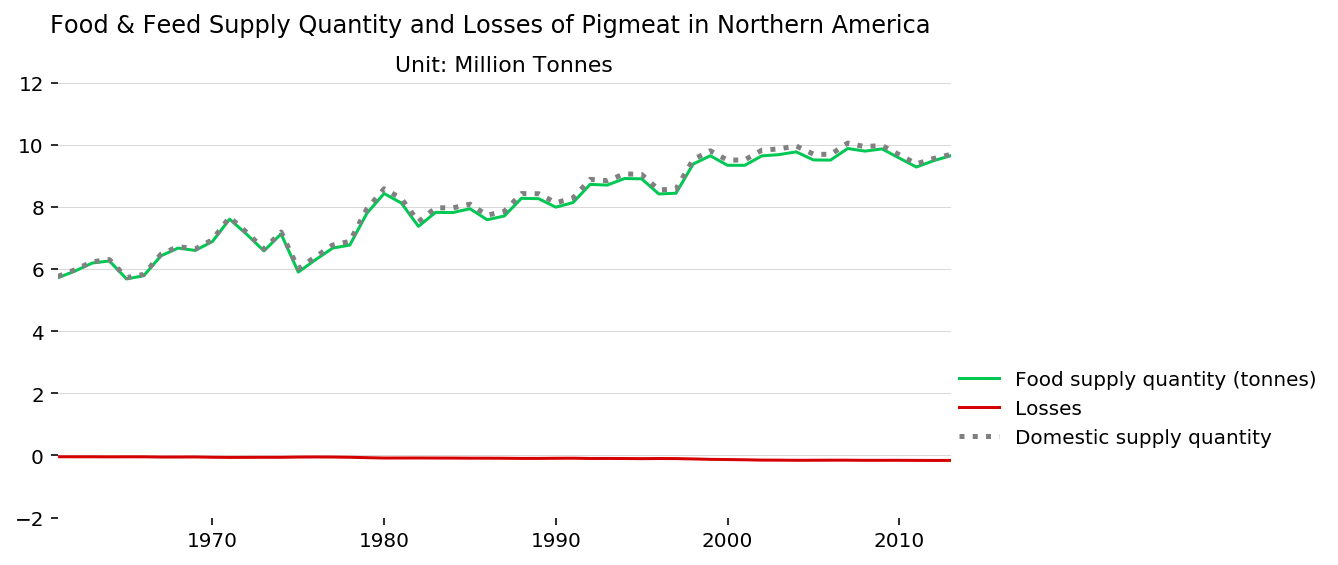

In [52]:
I = 'Pigmeat'

plotTrendsLine2(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Consumption'], 
    ax1_ylim=(5,12),
    ax2_ylim=(-2,5),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

Food supply quantity (tonnes)      Losses  Processing  \
Year                                                          
2009                        13.2993  1.0100e-04         0.0   
2010                        13.0898  1.0100e-04         0.0   
2011                        12.6170  1.0600e-04         0.0   
2012                        12.8021  1.0600e-04         0.0   
2013                        12.6648  5.4000e-05         0.0   

      Domestic supply quantity  
Year                            
2009                   13.3093  
2010                   13.0951  
2011                   12.6118  
2012                   12.7909  
2013                   12.6536

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_02_Food & Feed Supply Quantity and Losses of Bovine Meat in Northern America.png


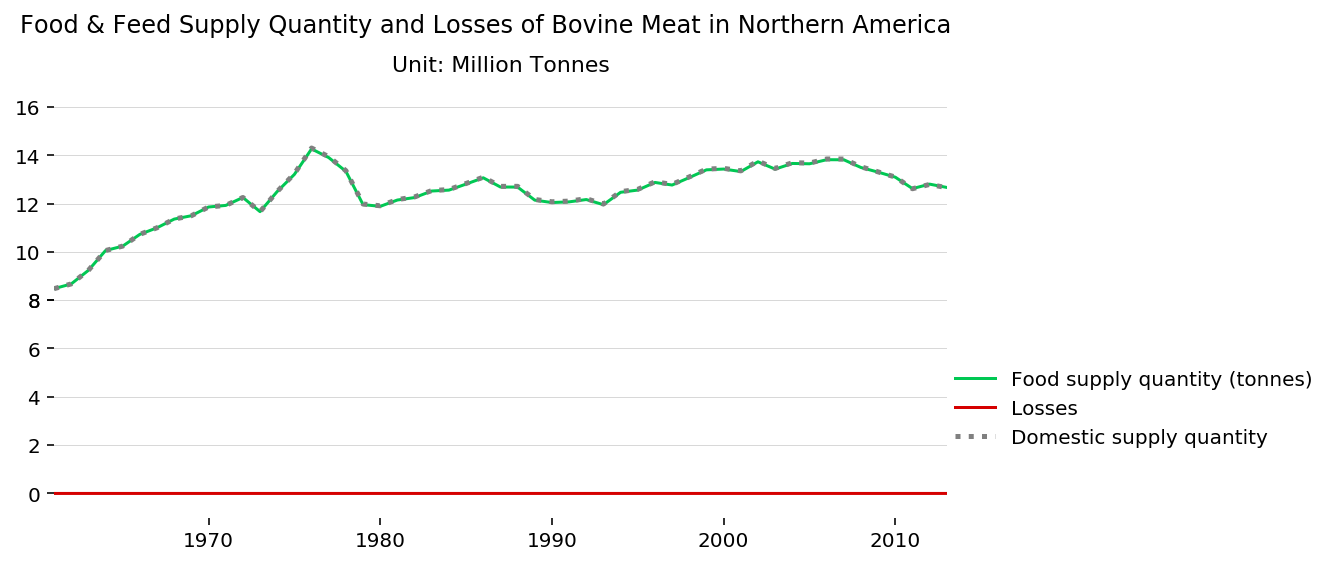

In [53]:
I = 'Bovine Meat'

plotTrendsLine2(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Consumption'], 
    ax1_ylim=(8,17),
    ax2_ylim=(-1,8),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

Food supply quantity (tonnes)    Feed  Domestic supply quantity
Year                                                                 
2009                         0.1795  0.0126                    0.1929
2010                         0.1707  0.0158                    0.1865
2011                         0.1620  0.0171                    0.1792
2012                         0.1618  0.0174                    0.1793
2013                         0.1731  0.0177                    0.1908

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_02_Food & Feed Supply Quantity and Losses of Mutton & Goat Meat in Northern America.png


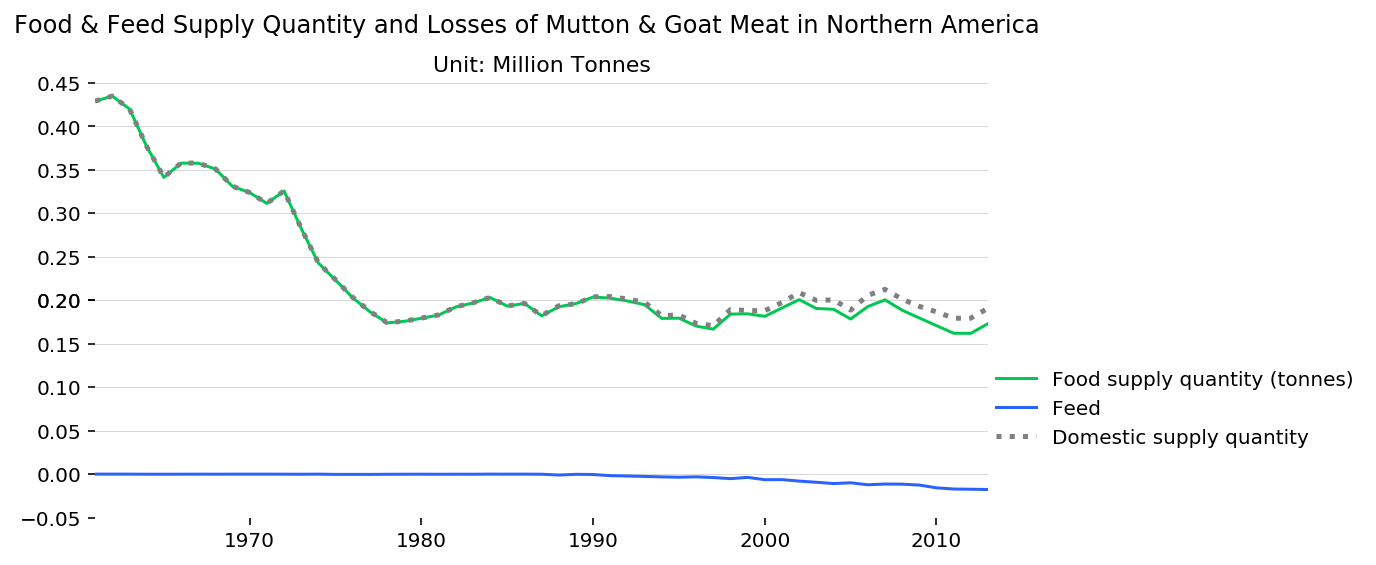

In [54]:
I = 'Mutton & Goat Meat'

plotTrendsLine2(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Consumption'], 
    ax1_ylim=(0.2,0.45),
    ax2_ylim=(-0.05,0.2),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

Food supply quantity (tonnes)  Processing  Domestic supply quantity
Year                                                                     
2009                        16.3246      0.0000                   16.3981
2010                        17.1623      0.0000                   17.2348
2011                        17.4789      0.0000                   17.5501
2012                        17.0033      0.0308                   17.1049
2013                        17.2987      0.0241                   17.3943

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_02_Food & Feed Supply Quantity and Losses of Poultry Meat in Northern America.png


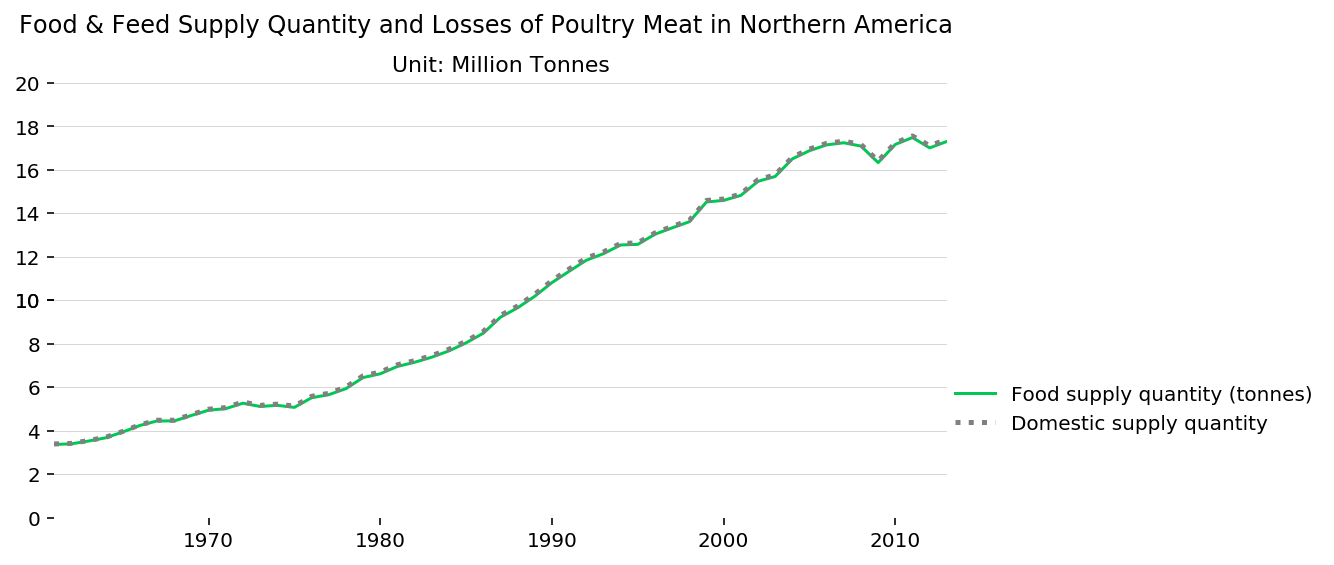

In [55]:
I = 'Poultry Meat'

plotTrendsLine2(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Consumption'], 
    ax1_ylim=(10,20),
    ax2_ylim=(-0,10),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

Food supply quantity (tonnes)    Feed  Domestic supply quantity
Year                                                                 
2009                         7.4063  0.9223                    8.6518
2010                         7.5543  1.0373                    8.9827
2011                         7.5180  1.1485                    9.0746
2012                         7.5319  0.9479                    8.9868
2013                         7.6787  0.8095                    9.1212

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_02_Food & Feed Supply Quantity and Losses of Fish, Seafood in Northern America.png


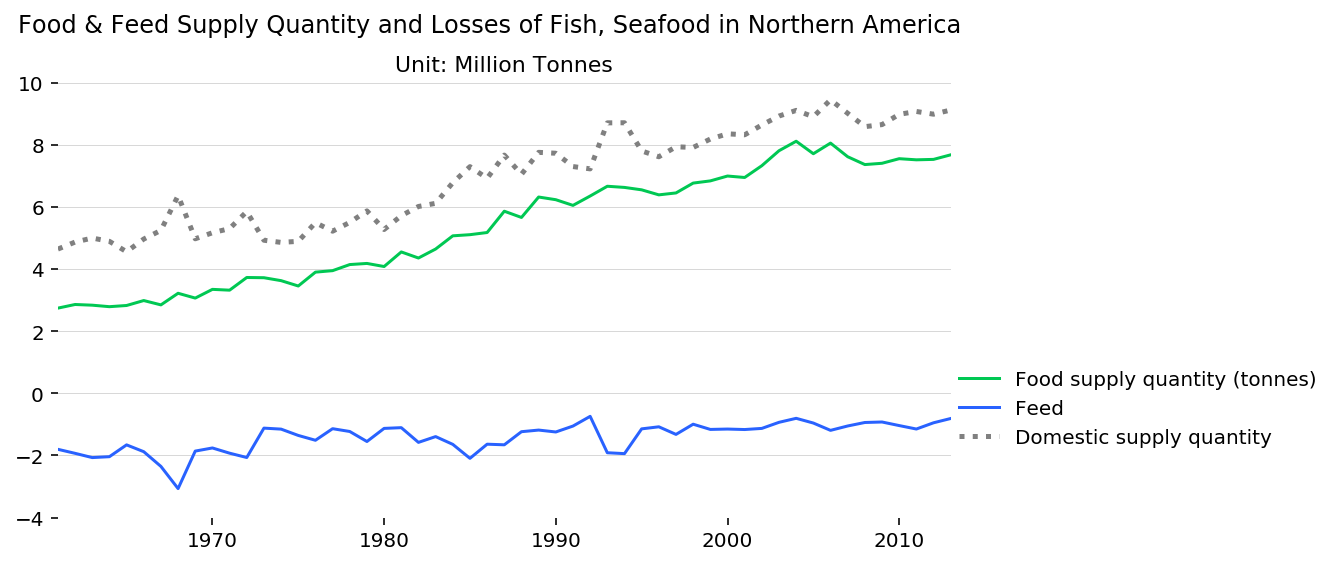

In [56]:
I = 'Fish, Seafood'

plotTrendsLine2(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Consumption'], 
    ax1_ylim=(3,10),
    ax2_ylim=(-4,3),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

Food supply quantity (tonnes)  Losses  Other uses  Processing  \
Year                                                                  
2009                         4.7450  0.1187      0.0002  0.0000e+00   
2010                         4.8049  0.1188      0.0002  0.0000e+00   
2011                         4.8297  0.1190      0.0002  0.0000e+00   
2012                         4.9645  0.1222      0.0001  0.0000e+00   
2013                         5.1237  0.1263      0.0002 -1.0000e-06   

      Domestic supply quantity  
Year                            
2009                    5.6573  
2010                    5.7253  
2011                    5.7502  
2012                    5.8495  
2013                    6.0258

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_02_Food & Feed Supply Quantity and Losses of Eggs in Northern America.png


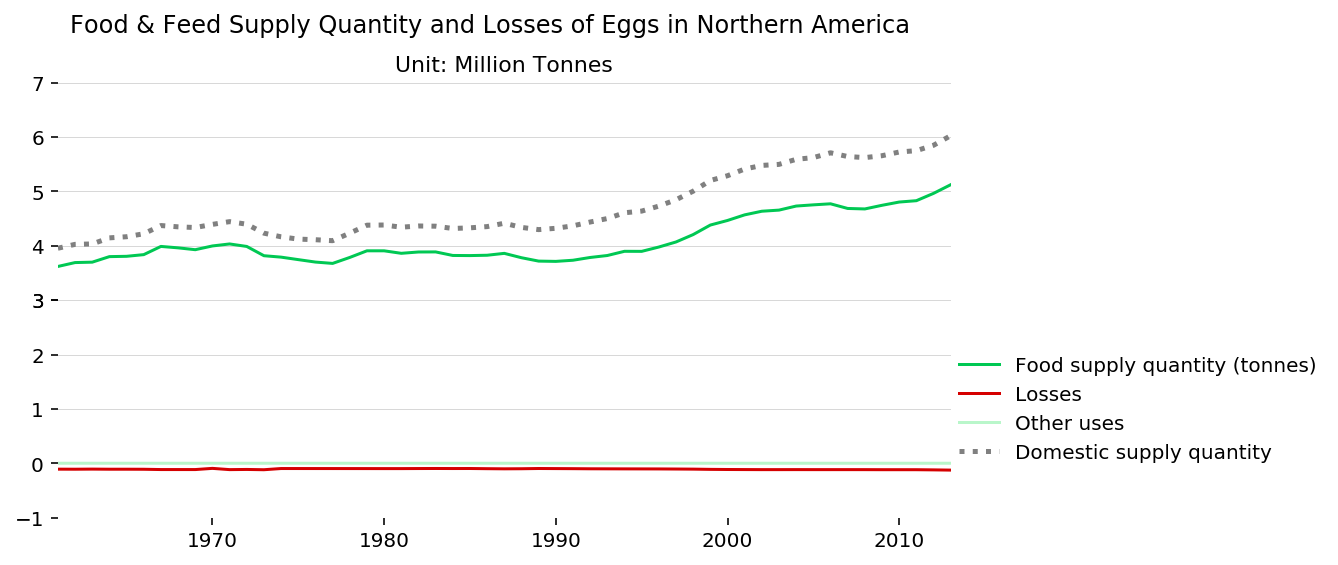

In [66]:
I = 'Eggs'

plotTrendsLine2(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Consumption'], 
    ax1_ylim=(3, 7),
    ax2_ylim=(-1,3),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)

Food supply quantity (tonnes)  Other uses    Feed  Processing  \
Year                                                                  
2009                        86.1102      5.8648  1.0170  4.0000e-06   
2010                        85.5023      5.5899  1.0159 -1.0000e-06   
2011                        85.9242      6.8896  1.0185 -8.0000e-06   
2012                        88.0051      7.8945  1.0276 -6.0000e-06   
2013                        88.1250      7.7731  1.0283 -1.0000e-06   

      Domestic supply quantity  
Year                            
2009                   92.9830  
2010                   92.0942  
2011                   93.8161  
2012                   96.9162  
2013                   96.9170

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyItems_02_Food & Feed Supply Quantity and Losses of Milk Excluding Butter in Northern America.png


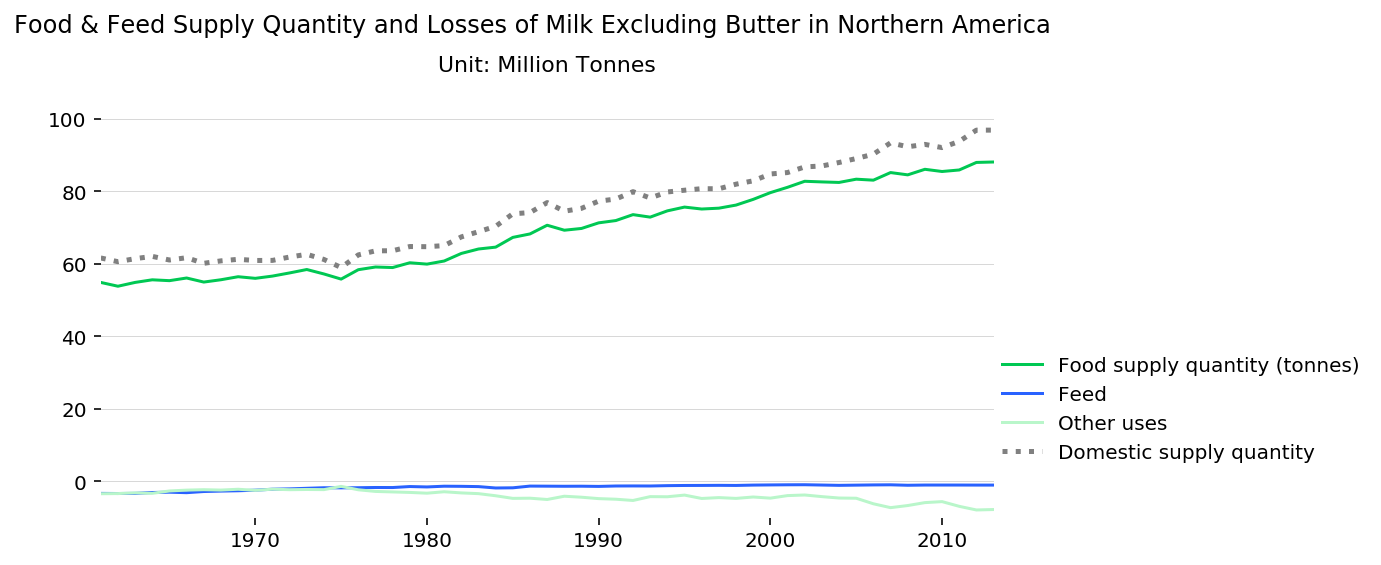

In [67]:
I = 'Milk - Excluding Butter'

plotTrendsLine2(
    area=A, 
    item=I,
    elements=Es['Domestic Supply, Consumption'], 
    ax1_ylim=(50,110),
    ax2_ylim=(-10,50),
    toUnit='Million Tonnes',   
    changeUnit = 1/1000000,
    fig_size = FIG_size,
    colors=CLs,
)